# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from Modules import Preprocess_DARP as prd
from Modules import DARP_to_DYNA as dtd
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
import random
%load_ext autoreload
%autoreload 2

In [637]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
#Trip mode
#1 Drive alone free; 2 Drive alone pay; 3 Shared ride 2 free; 4 Shared ride 2 pay ;
#5 Shared ride 3+ free; 6 Shared ride 3+ pay; 7 Walk; 8 Bike; 9 Walk to local transit; 
#10 Walk to premium transit; 11 Drive to local transit; 12 Drive to premium transit; 
#13 Taxi; 14 School bus

# traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
# #Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
# traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
# traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
# traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
# traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
# traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
# traveler_trips.orig_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.dest_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.loc[:,'person_type']=traveler_trips.person_id.apply(lambda x: person_type_dic[x])
# value_latearr_penalty_per_min=pd.read_csv('input/LateArrPenalty.dat',sep='\t',index_col =0)
# value_earlyarr_penalty_per_min=pd.read_csv('input/EarlyArrPenalty.dat',sep='\t',index_col =0)
# early_penalty_threshold=pd.read_csv('input/EarlyArrPenaltyThreshold.dat',sep='\t',index_col=0)
# late_penalty_threshold=pd.read_csv('input/LateArrPenaltyThreshold.dat',sep='\t',index_col=0)

# traveler_trips.loc[:,'earlyarr_penalty']=traveler_trips.apply(lambda row: value_earlyarr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'latearr_penalty']=traveler_trips.apply(lambda row: value_latearr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'early_penalty_threshold']=traveler_trips.apply(lambda row: early_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'late_penalty_threshold']=traveler_trips.apply(lambda row: late_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.to_csv('input/traveler_trip_info_improved.csv')
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv',index_col=0)
num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
origin_links['length']=origin_links.apply(lambda row: 
                                          link_detail[int(link_id[node_id[row.u_node],node_id[row.d_node]])][0,4],axis=1)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim,Vehicular_Skim_Dict=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
Transit_AB_Cost_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Cost_Skim,TransitSkimTimeIntervalLength)
Transit_AB_Time_Skim_Dict=dy.convert_skim_dataframe_to_dict(Transit_AB_Time_Skim,TransitSkimTimeIntervalLength)
transit_zone_dict={}
for link_zone in three_link_walk.three_link_zone.unique():
    transit_zone_dict[link_zone]=list(three_link_walk[three_link_walk.three_link_zone==link_zone]['transit_zone'].astype(int))
three_link_walk_dict={}
for index,group in three_link_walk.groupby(['three_link_zone']):
    three_link_walk_dict[index]={}
    for inx,row in group.iterrows():
        three_link_walk_dict[index][row.transit_zone]=row.distance
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
drivingcost_per_mile=0.5
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
traveler_trips=prd.compare_mode_utlity(traveler_trips,TransitMazTazFlag,
                        three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
                        Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
                        Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')

56 57 72


In [638]:
car_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>=1)]
car_trips=car_trips.loc[(car_trips.orig_taz !=car_trips.dest_taz) | (car_trips.trip_counter==1)]
car_transit_trips=car_trips.append(traveler_trips[traveler_trips.tripmode>8])
# car_transit_trips=prd.compare_mode_utlity(car_transit_trips,TransitMazTazFlag,
#                         three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
#                         Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
#                         Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)
np.random.seed(100)
car_transit_trips_sample=car_transit_trips[car_transit_trips.hh_id.isin(random.sample(list(car_transit_trips.hh_id.unique()),3000))]
car_trips_sample=car_trips[car_trips.hh_id.isin(random.sample(list(car_transit_trips.hh_id.unique()),3000))]

In [639]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
# car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
# for share_ride_factor in [1,1.25,1.5]:
print('********************************')
print(share_ride_factor)
# target_trips=car_trips_sample[car_trips_sample.hh_id==1486727]
# car_transit_trip_samplediscountvot=car_transit_trips_sample.copy()
# car_transit_trip_samplediscountvot.value_of_time=car_transit_trip_samplediscountvot.value_of_time*0
route_info_ca15sample,darp_solutions_ca15_sample=\
sod.get_route_info_allhh(car_trips_sample,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )
output_filepath='Output/3000SampleHH/'
dtd.save_run_result('CA15_newdeviation/',route_info_ca15sample,darp_solutions_ca15_sample,output_filepath)
# pod.analysis_network_level_results(route_info,darp_solutions,car_trips_sample,
#                                    Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

********************************
1.5
Estimate Route for the  0 th household  2018-07-30 09:59:56.088790
Estimate Route for the  1000 th household  2018-07-30 10:08:51.051356
Estimate Route for the  2000 th household  2018-07-30 10:16:47.958475


In [694]:
from Modules import Misc
num_veh=[]
hh_id_list=[]
trip_length=[]
num_cav=[]
for index,group in car_trips.groupby('hh_id'):
    num_veh.extend([Misc.estimate_num_vehicle_household(group,3)])
    hh_id_list.extend([index])
    trip_length.extend([len(group)])
    num_cav.extend([darp_solutions_2avoptional[index]['num_cav']])

In [695]:
zz=pd.DataFrame({'hh_id':hh_id_list,'num_veh':num_veh,'num_trips':trip_length,'num_cav':num_cav})

In [700]:
zz=zz.groupby(['num_veh','num_cav'])['hh_id'].count().unstack('num_cav')

In [678]:
zz[zz.num_veh>1]['num_veh'].sum()

2361.0

In [671]:
car_trips_sample[car_trips_sample.hh_id==72774]

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,travel_time,person_type,earlyarr_penalty,latearr_penalty,early_penalty_threshold,late_penalty_threshold,transit_utility,car_utility,predicted_mode,actual_mode
161311,145547,7,0.0226,1,5.0,1,Home,Escort,37,10,...,7.0,Full-time-worker,0.2,1.0,5.0,5.0,7.355013,1.19967,Car,Car
161312,145547,7,0.0226,2,10.0,1,Escort,Work,24,6,...,1.0,Full-time-worker,0.2,0.5,30.0,15.0,6.083569,0.51413,Car,Car
161316,145547,7,0.0226,6,7.0,1,Work,Escort,19,5,...,9.0,Full-time-worker,0.2,1.0,5.0,5.0,4.522252,2.25035,Car,Car


In [115]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.25
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
# car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
# for share_ride_factor in [1,1.25,1.5]:
print('********************************')
print(share_ride_factor)
# target_trips=car_trips_sample[car_trips_sample.hh_id==1486727]
# car_transit_trip_samplediscountvot=car_transit_trips_sample.copy()
# car_transit_trip_samplediscountvot.value_of_time=car_transit_trip_samplediscountvot.value_of_time*0
route_info_ca125,darp_solutions_ca125=\
sod.get_route_info_allhh(car_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )
output_filepath='Output/AllHH/'
dtd.save_run_result('CA125/',route_info_ca125,darp_solutions_ca125,output_filepath)
# pod.analysis_network_level_results(route_info,darp_solutions,car_trips_sample,
#                                    Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

********************************
1.25
Estimate Route for the  0 th household  2018-07-18 21:37:44.816148
Estimate Route for the  1000 th household  2018-07-18 21:50:31.702704
Estimate Route for the  2000 th household  2018-07-18 22:01:57.911981
Estimate Route for the  3000 th household  2018-07-18 22:12:52.270880
Estimate Route for the  4000 th household  2018-07-18 22:24:32.735986
Estimate Route for the  5000 th household  2018-07-18 22:34:38.015076
Estimate Route for the  6000 th household  2018-07-18 22:42:57.867157
Estimate Route for the  7000 th household  2018-07-18 22:52:26.478782
Estimate Route for the  8000 th household  2018-07-18 23:01:13.594749
Estimate Route for the  9000 th household  2018-07-18 23:09:46.038845
Estimate Route for the  10000 th household  2018-07-18 23:18:04.151163
Estimate Route for the  11000 th household  2018-07-18 23:25:59.642042
Estimate Route for the  12000 th household  2018-07-18 23:34:10.136044
Estimate Route for the  13000 th household  2018-07-

In [116]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
# car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
# for share_ride_factor in [1,1.25,1.5]:
print('********************************')
print(share_ride_factor)
# target_trips=car_trips_sample[car_trips_sample.hh_id==1486727]
# car_transit_trip_samplediscountvot=car_transit_trips_sample.copy()
# car_transit_trip_samplediscountvot.value_of_time=car_transit_trip_samplediscountvot.value_of_time*0
route_info_ca1,darp_solutions_ca1=\
sod.get_route_info_allhh(car_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )
output_filepath='Output/AllHH/'
dtd.save_run_result('CA1/',route_info_ca1,darp_solutions_ca1,output_filepath)
# pod.analysis_network_level_results(route_info,darp_solutions,car_trips_sample,
#                                    Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

********************************
1
Estimate Route for the  0 th household  2018-07-19 01:58:45.148968
Estimate Route for the  1000 th household  2018-07-19 02:06:38.559020
Estimate Route for the  2000 th household  2018-07-19 02:13:55.580690
Estimate Route for the  3000 th household  2018-07-19 02:21:06.333179
Estimate Route for the  4000 th household  2018-07-19 02:28:08.232893
Estimate Route for the  5000 th household  2018-07-19 02:34:32.012946
Estimate Route for the  6000 th household  2018-07-19 02:41:02.228130
Estimate Route for the  7000 th household  2018-07-19 02:47:37.994163
Estimate Route for the  8000 th household  2018-07-19 02:54:12.708032
Estimate Route for the  9000 th household  2018-07-19 03:00:39.876043
Estimate Route for the  10000 th household  2018-07-19 03:07:12.982755
Estimate Route for the  11000 th household  2018-07-19 03:13:33.593993
Estimate Route for the  12000 th household  2018-07-19 03:19:51.210461
Estimate Route for the  13000 th household  2018-07-19 

In [134]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=2
share_ride_factor=1.5
time_window_flag=0
# target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
# target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
# target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])
# target_trips.value_of_time=target_trips.value_of_time*0.8
# car_transit_trips_sample.value_of_time=car_transit_trips_sample.value_of_time*0.7
# for share_ride_factor in [1,1.25,1.5]:
print('********************************')
print(share_ride_factor)
# target_trips=car_trips_sample[car_trips_sample.hh_id==1486727]
# car_transit_trip_samplediscountvot=car_transit_trips_sample.copy()
# car_transit_trip_samplediscountvot.value_of_time=car_transit_trip_samplediscountvot.value_of_time*0
route_info_mv,darp_solutions_mv=\
sod.get_route_info_allhh(car_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength)
output_filepath='Output/AllHH/'
dtd.save_run_result('MV/',route_info_mv,darp_solutions_mv,output_filepath)
# pod.analysis_network_level_results(route_info,darp_solutions,car_trips_sample,
#                                    Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

********************************
1.5
Estimate Route for the  0 th household  2018-07-19 13:45:32.688866
Estimate Route for the  1000 th household  2018-07-19 14:23:01.689206
Estimate Route for the  2000 th household  2018-07-19 15:10:43.144628
Estimate Route for the  3000 th household  2018-07-19 16:10:40.203120
Estimate Route for the  4000 th household  2018-07-19 17:06:16.590685
Estimate Route for the  5000 th household  2018-07-19 17:35:20.532794
Estimate Route for the  6000 th household  2018-07-19 17:56:09.772776
Estimate Route for the  7000 th household  2018-07-19 18:25:42.903610
Estimate Route for the  8000 th household  2018-07-19 18:47:31.344305
Estimate Route for the  9000 th household  2018-07-19 19:12:32.473603
Estimate Route for the  10000 th household  2018-07-19 19:32:00.193952
Estimate Route for the  11000 th household  2018-07-19 19:47:32.702929
Estimate Route for the  12000 th household  2018-07-19 20:05:26.979381
Estimate Route for the  13000 th household  2018-07-1

226735

In [135]:
pod.analysis_network_level_results(route_info_ca1,darp_solutions_ca1,car_trips,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)
print('*********************************************')
pod.analysis_network_level_results(route_info_ca125,darp_solutions_ca125,car_trips,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)
print('*********************************************')
pod.analysis_network_level_results(route_info_ca15,darp_solutions_ca15,car_trips,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)
print('*********************************************')

Number of AV Trips: 	 229226
Number of Shared Rides: 	 0
Total VMT: 	 1689079.9889999104
Number of occupied trips: 	 180007
Number of unoccupied trips: 	 49219
Number of transit trips: 	 4
total_convention_vehicle_driving_time: 	 13194.786666664204
total_convention_vehicle_driving_distance: 	 1351117.135999888
total_AV_driving_time: 	 16330.204999999743
total_AV_unoccupied_driving_time: 	 3180.083333333279
total_AV_driving_distance: 	 1689463.9459999169
total_AV_unoccupied_driving_distance: 	 338370.3679999976
Number of pickup trips: 	 180007
*********************************************
Number of AV Trips: 	 229355
Number of Shared Rides: 	 1613
Total VMT: 	 1680154.8369999179
Number of occupied trips: 	 181626
Number of unoccupied trips: 	 47729
Number of transit trips: 	 4
total_convention_vehicle_driving_time: 	 13194.786666664204
total_convention_vehicle_driving_distance: 	 1351117.135999888
total_AV_driving_time: 	 16199.023333333094
total_AV_unoccupied_driving_time: 	 3104.28833

In [207]:
pod.analysis_network_level_results(route_info_2avoptional,darp_solutions_2avoptional,car_trips,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 226735
Number of Shared Rides: 	 2874.0
Total VMT: 	 1646784.3569999177
Number of occupied trips: 	 182891
Number of unoccupied trips: 	 43844
Number of transit trips: 	 5.0
total_convention_vehicle_driving_time: 	 13194.786666664204
total_convention_vehicle_driving_distance: 	 1351117.135999888
total_AV_driving_time: 	 15825.404999999355
total_AV_unoccupied_driving_time: 	 2748.103333333312
total_AV_driving_distance: 	 1647250.9409999256
total_AV_unoccupied_driving_distance: 	 295128.3490000177
Number of pickup trips: 	 180006.0


In [214]:
from Modules import Misc
total_num_car=0
for index, group in car_trips.groupby('hh_id'):
    total_num_car+=Misc.estimate_num_vehicle_household(group,3)

In [382]:
darp_solutions_mv[target_hh_id]

{'cav_use_mode': 0,
 'drivingcost_per_mile': 0.5,
 'hh_id': 2238733,
 'hh_num_trips': 21,
 'num_cav': 2,
 'num_cav_trips': 28,
 'num_convention car trips': 21,
 'num_occupied_trips': 23,
 'num_pickup_trips': 21,
 'num_shared_trips': 2,
 'num_unoccupied_trips': 5,
 'objective_value': 3305.54644,
 'reward_mode': 2,
 'route_info':     orig_zone  dest_zone  orig_node_index  dest_node_index  person_id  \
 0          18         18                1               22    7657707   
 2          18         14                2               23    7657707   
 0          18         20                3               24    7657708   
 2          20         18                4               25    7657708   
 0          18         14                5               26    7657708   
 0          14          9                6               27    7657707   
 1           9         18               27               10          0   
 2          14         18                7               28    7657708   
 3   

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


21
num_cav_trips 28
num_occupied_trips 23
num_unoccupied_trips 5
num_pickup_trips 21
num_shared_trips 2
num_convention car trips 21
total_convention_vehicle_driving_time 2.145
total_AV_driving_time 2.395
total_AV_unoccupied_driving_time 0.3266666666666667
total_convention_vehicle_driving_distance 206.07599999999996
total_AV_driving_distance 237.264
total_AV_unoccupied_driving_distance 35.614
total_reward 3150.0
total_schedule_penalty 1.3665000000000216
total_travel_cost 154.17994
reward_mode 2
drivingcost_per_mile 0.5
share_ride_factor 1.5
run_mode 0
num_cav 2
cav_use_mode 0
time_window_flag 0


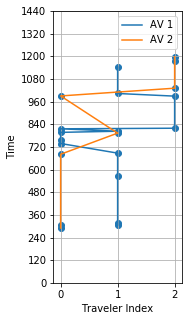

In [380]:
target_hh_id=2238733
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions_mv,car_trips,2,
    Vehicular_Skim_Dict,superzone_map)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


21
num_cav_trips 34
num_occupied_trips 25
num_unoccupied_trips 9
num_pickup_trips 21
num_shared_trips 4
num_convention car trips 21
total_convention_vehicle_driving_time 2.145
total_AV_driving_time 2.891666666666666
total_AV_unoccupied_driving_time 0.7266666666666667
total_convention_vehicle_driving_distance 206.07599999999996
total_AV_driving_distance 286.91900000000004
total_AV_unoccupied_driving_distance 72.744
total_reward 3150.0
total_schedule_penalty 5.14850000000016
total_travel_cost 177.00476
reward_mode 2
drivingcost_per_mile 0.5
share_ride_factor 1.5
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


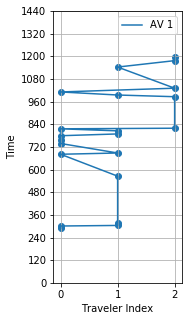

In [378]:
target_hh_id=2238733
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions_ca15,car_trips,1,
    Vehicular_Skim_Dict,superzone_map)

In [383]:
target_hh_id

2238733

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


21
num_cav_trips 35
num_occupied_trips 22
num_unoccupied_trips 13
num_pickup_trips 21
num_shared_trips 1
num_convention car trips 21
total_convention_vehicle_driving_time 2.145
total_AV_driving_time 3.0933333333333333
total_AV_unoccupied_driving_time 0.9600000000000002
total_convention_vehicle_driving_distance 206.07599999999996
total_AV_driving_distance 304.93500000000006
total_AV_unoccupied_driving_distance 96.839
total_reward 3150.0
total_schedule_penalty 4.992000000000051
total_travel_cost 182.75534000000002
reward_mode 2
drivingcost_per_mile 0.5
share_ride_factor 1.25
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


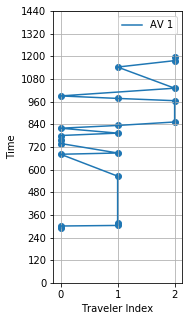

In [377]:
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions_ca125,car_trips,1,
    Vehicular_Skim_Dict,superzone_map)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


21
num_cav_trips 34
num_occupied_trips 21
num_unoccupied_trips 13
num_pickup_trips 21
num_shared_trips 0
num_convention car trips 21
total_convention_vehicle_driving_time 2.145
total_AV_driving_time 3.0916666666666663
total_AV_unoccupied_driving_time 0.9466666666666668
total_convention_vehicle_driving_distance 206.07599999999996
total_AV_driving_distance 300.71500000000003
total_AV_unoccupied_driving_distance 94.63900000000001
total_reward 3150.0
total_schedule_penalty 8.02779999999982
total_travel_cost 180.70110000000003
reward_mode 2
drivingcost_per_mile 0.5
share_ride_factor 1
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


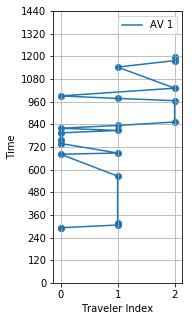

In [384]:
target_hh_id=2238733
pod.analysis_one_hh_result_new_darpsolution(target_hh_id,darp_solutions_ca1,car_trips,1,
    Vehicular_Skim_Dict,superzone_map)

In [386]:
route_info_ca15.columns

Index(['orig_zone', 'dest_zone', 'orig_node_index', 'dest_node_index',
       'person_id', 'origin_arrival_time', 'dest_arrival_time',
       'dest_expected_arrival_time', 'value_of_time', 'start_time',
       'Activity_Time', 'hh_id', 'hh_vehicle_id', 'shared_ride_flag',
       'pickup_trip_flag', 'transit_utility', 'car_utility', 'orig_traveler',
       'dest_traveler', 'intrasuperzone_flag', 'seg_index', 'veh_seg_index',
       'first_trip_start_time'],
      dtype='object')

In [388]:
ca15_40_vehicle=dtd.read_vehicledat('Output/AllHH/CA15/40/vehicle.dat')

In [ ]:
for start_time,activity_time in ca15_

In [410]:
starttime=[]
for first_starttime,activity_time_list in zip(ca15_40_vehicle.StartTime,ca15_40_vehicle.activity_time):
    starttime.extend([first_starttime])
    starttime_temp=first_starttime
    for activity_time in activity_time_list[:-1]:
        starttime_temp+=float(activity_time)
        starttime.extend([starttime_temp])

In [420]:
len(route_info_ca15)

229371

In [444]:
route_info_ca15['distance']=route_info_ca15.apply(lambda row: 
        prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.origin_arrival_time,row.value_of_time,
        Vehicular_Skim_Dict,1,superzone_map,drivingcost_per_mile),axis=1)

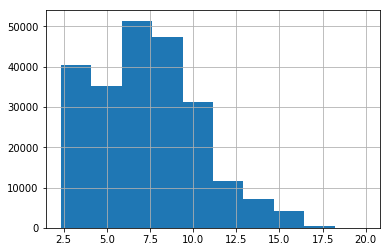

In [428]:
route_info_ca15.distance.hist()

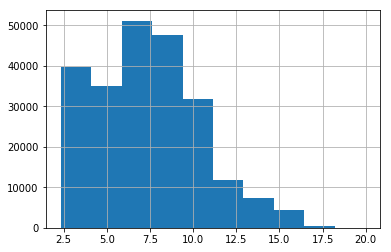

In [426]:
route_info_ca125.distance.hist()

In [445]:
route_info_ca125['distance']=route_info_ca125.apply(lambda row: 
        prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.origin_arrival_time,row.value_of_time,
        Vehicular_Skim_Dict,1,superzone_map,drivingcost_per_mile),axis=1)

In [446]:
route_info_ca1['distance']=route_info_ca1.apply(lambda row: 
        prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.origin_arrival_time,row.value_of_time,
        Vehicular_Skim_Dict,1,superzone_map,drivingcost_per_mile),axis=1)

In [447]:
route_info_ca125.distance.sum()

610722.4185000426

In [448]:
route_info_ca1.distance.sum()

615313.9945000339

In [449]:
route_info_ca15.distance.sum()

607101.9250000478

In [573]:
z=pd.DataFrame()
z['num_shared_rides']=route_info_ca15.groupby('hh_id')['shared_ride_flag'].sum()
z['num_trips']=route_info_ca15.groupby('hh_id')['shared_ride_flag'].count()
z.reset_index(inplace=True)
temp=z.num_trips.unique()
counts = zz.unstack(level=1)
counts.columns = counts.columns.droplevel(level=0)
counts = counts.fillna(0)
s=counts[counts.index>30].sum()
s.name=50
counts=counts.append(s)
for i in range(6):
    counts['percentage'+str(i)]=counts.apply(lambda row: row[i]/(row[0]+row[1]+row[2]+row[3]+row[4]+row[5]),axis=1 )
counts['percentage_withsharedtrip']=counts.apply(lambda row: 1-row['percentage0'],axis=1 )

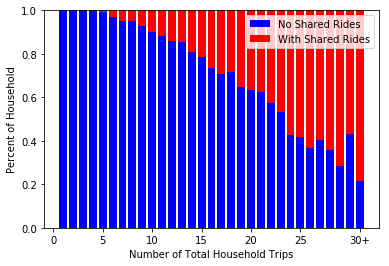

In [604]:
plt.pyplot.bar(list(range(1,31)), counts[counts.index<=30]['percentage0'], bottom=None, color='blue', 
               label='No Shared Rides')
color_list=['red','yellow','red','green','black']

bottom_temp=counts[counts.index<=30]['percentage0'].copy()
# for i in range(1,6):
#     plt.pyplot.bar(temp, counts['percentage'+str(i)], bottom=bottom_temp, color=color_list[i-1], label=str(i))
#     bottom_temp+=counts['percentage'+str(i)]
plt.pyplot.bar(list(range(1,31)), counts[counts.index<=30]['percentage_withsharedtrip'], 
               bottom=bottom_temp, color='red', label='With Shared Rides')
plt.pyplot.bar(31, counts[counts.index==50]['percentage0'], bottom=None, color='blue')
plt.pyplot.bar(31, counts[counts.index==50]['percentage_withsharedtrip'], 
               bottom=counts[counts.index==50]['percentage0'], color='red')

Labels=list(range(0,26,5))
Labels.extend(['30+'])
plt.pyplot.xticks([0,5,10,15,20,25,31],Labels)
plt.pyplot.xlabel('Number of Total Household Trips')
plt.pyplot.ylabel('Percent of Household')
plt.pyplot.legend()

In [607]:
traveler_trips.columnsmns

Index(['person_id', 'num_trips', 'value_of_time', 'trip_counter',
       'ActivityTime', 'tripmode', 'orig_purpose', 'dest_purpose', 'orig_maz',
       'orig_taz', 'dest_maz', 'dest_taz', 'driver_passenger_flag',
       'joint_trip_flag', 'park&ride_flag', 'starttimeinterval', 'starttime',
       'hh_id', 'origin_node', 'destination_node', 'Diff_bet_starttime',
       'travel_time', 'person_type', 'earlyarr_penalty', 'latearr_penalty',
       'early_penalty_threshold', 'late_penalty_threshold', 'transit_utility',
       'car_utility', 'predicted_mode', 'actual_mode'],
      dtype='object')

In [611]:
traveler_trips[traveler_trips.joint_trip_flagag==1].head()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,travel_time,person_type,earlyarr_penalty,latearr_penalty,early_penalty_threshold,late_penalty_threshold,transit_utility,car_utility,predicted_mode,actual_mode
9,8600957,11,0.1164,10,77.0,3,Home,Discretionary,1,1,...,7.0,Part-time-worker,0.01,0.01,60.0,60.0,15.340069,2.64463,Car,Car
10,8600957,11,0.1164,11,437.0,3,Discretionary,Home,38,10,...,5.0,Part-time-worker,0.01,0.02,120.0,30.0,10.219050,2.28659,Car,Car
11,9902110,10,0.2456,1,154.0,5,Home,Discretionary,9,3,...,6.0,Full-time-worker,0.01,0.01,60.0,60.0,49.821007,3.33073,Car,Car
12,9902110,10,0.2456,2,8.0,5,Discretionary,Home,73,19,...,5.0,Full-time-worker,0.01,0.02,120.0,30.0,3.518306,4.35194,NonCar,Car
21,9902112,11,0.2456,1,154.0,5,Home,Discretionary,9,3,...,6.0,Full-time-worker,0.01,0.01,60.0,60.0,51.054915,3.33073,Car,Car


In [613]:
len(route_info_ca15)

229371

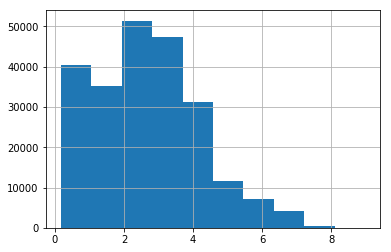

In [614]:
route_info_ca15.distance.hist()

In [615]:
route_info_ca15.columns

Index(['orig_zone', 'dest_zone', 'orig_node_index', 'dest_node_index',
       'person_id', 'origin_arrival_time', 'dest_arrival_time',
       'dest_expected_arrival_time', 'value_of_time', 'start_time',
       'Activity_Time', 'hh_id', 'hh_vehicle_id', 'shared_ride_flag',
       'pickup_trip_flag', 'transit_utility', 'car_utility', 'orig_traveler',
       'dest_traveler', 'intrasuperzone_flag', 'seg_index', 'veh_seg_index',
       'first_trip_start_time', 'distance'],
      dtype='object')

In [610]:
len(traveler_trips[traveler_trips.joint_trip_flag==1])/len(traveler_trips)

0.12794184604273626

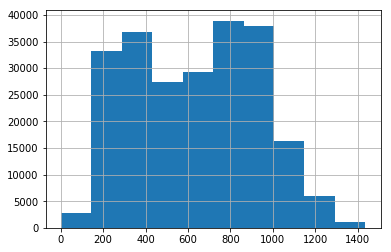

In [618]:
route_info_ca15.origin_arrival_time.hist()

In [123]:
average_value_of_time=round(car_trips.value_of_time.mean(),4)
for external_factor in [30,40,50]:
    dtd.write_darp_solution_to_file('CA1/',output_filepath,route_info_ca1,darp_solutions_ca1,origin_links,
        superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)
    dtd.write_darp_solution_to_file('CA125/',output_filepath,route_info_ca125,darp_solutions_ca125,origin_links,
        superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)
    dtd.write_darp_solution_to_file('CA15/',output_filepath,route_info_ca15,darp_solutions_ca15,origin_links,
        superzone_map,intrasuperzone_path_dic,average_value_of_time,external_factor)

2018-07-19 08:44:05.042085
2018-07-19 08:44:43.898546
20000 2018-07-19 08:45:54.209006
30000 2018-07-19 08:46:34.088529
40000 2018-07-19 08:47:16.018187
50000 2018-07-19 08:47:58.100647
80000 2018-07-19 08:49:19.350261
100000 2018-07-19 08:51:10.216568
110000 2018-07-19 08:52:13.037135
150000 2018-07-19 08:53:34.204754
160000 2018-07-19 08:54:03.221399
180000 2018-07-19 08:55:08.226095
190000 2018-07-19 08:55:43.130079
2018-07-19 08:56:07.057439
2018-07-19 08:56:44.965594
10000 2018-07-19 08:57:23.735798
20000 2018-07-19 08:57:53.360482
30000 2018-07-19 08:58:33.357756
40000 2018-07-19 08:59:16.605221
50000 2018-07-19 08:59:57.852560
60000 2018-07-19 09:00:31.292466
80000 2018-07-19 09:01:15.817992
90000 2018-07-19 09:01:51.184002
100000 2018-07-19 09:02:28.856168
150000 2018-07-19 09:04:21.571317
160000 2018-07-19 09:04:51.584216
170000 2018-07-19 09:05:21.680123
180000 2018-07-19 09:05:56.452327
190000 2018-07-19 09:06:30.057457
2018-07-19 09:06:55.547073
2018-07-19 09:07:34.979511
3

In [39]:
pod.analysis_network_level_results(route_info_modechoice00,darp_solutions_modechoice00,car_transit_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 23156
Number of Shared Rides: 	 249.0
Total VMT: 	 167104.60000000437
Number of occupied trips: 	 18188
Number of unoccupied trips: 	 4968
Number of transit trips: 	 1118.0
total_convention_vehicle_driving_time: 	 1311.3933333333218
total_convention_vehicle_driving_distance: 	 134187.67900000012
total_AV_driving_time: 	 1604.6750000000088
total_AV_unoccupied_driving_time: 	 315.0033333333334
total_AV_driving_distance: 	 167133.8910000043
total_AV_unoccupied_driving_distance: 	 33684.41599999989
Number of pickup trips: 	 17938.0


In [24]:
pod.analysis_network_level_results(route_info_modechoice,darp_solutions_modechoice,car_transit_trips_sample,
                                   Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile)

Number of AV Trips: 	 22938
Number of Shared Rides: 	 323.0
Total VMT: 	 165206.44100000442
Number of occupied trips: 	 18095
Number of unoccupied trips: 	 4843
Number of transit trips: 	 1285.0
total_convention_vehicle_driving_time: 	 1311.3933333333218
total_convention_vehicle_driving_distance: 	 134187.67900000012
total_AV_driving_time: 	 1585.1516666666744
total_AV_unoccupied_driving_time: 	 310.73500000000047
total_AV_driving_distance: 	 165247.7750000043
total_AV_unoccupied_driving_distance: 	 33104.79399999985
Number of pickup trips: 	 17771.0


In [101]:
output_filepath='Output/3000SampleHH/'
dtd.save_run_result('CA/',route_info,darp_solutions_modechoice07,output_filepath)

In [619]:
route_info_ca15['origin_schedule_deviation']=route_info_ca15.origin_arrival_time-route_info_ca15.start_time

In [631]:
schedule_deviation=pd.DataFrame()
deviation=[]
num_car_trips=[]
for hh_id in car_trips.hh_id.unique():
    deviation.extend([darp_solutions_ca15[hh_id]['schedule_deviation']])
    num_car_trips.extend([darp_solutions_ca15[hh_id]['hh_num_trips']])
    

In [632]:
schedule_deviation=pd.DataFrame({'hh_id':list(car_trips.hh_id.unique()),'deviation':deviation,'car_trips':num_car_trips})

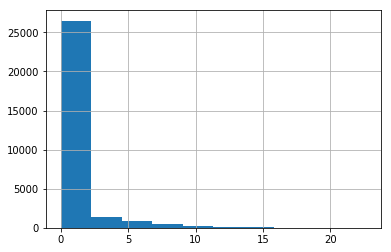

In [635]:
(schedule_deviation.deviation/schedule_deviation.car_trips).hist()

In [623]:
route_info_ca15[route_info_ca15.origin_schedule_deviation<-100].hh_id

1       72808.0
1     1972436.0
1     1589512.0
1      555395.0
1      763675.0
1     1489776.0
1     3427429.0
1      763704.0
1     3044738.0
1     1839436.0
1     1588493.0
1      867843.0
1     2105127.0
1     1113432.0
1     1975074.0
1     1843916.0
1     3391775.0
1     1486888.0
1     1309880.0
1      584674.0
1     1310005.0
1     1630301.0
1     1113446.0
1     1486379.0
1     2287058.0
1      644500.0
1     1588612.0
1      364711.0
1     1489787.0
1     1114043.0
        ...    
21    1843874.0
21    1265723.0
7     1588604.0
13    1844339.0
11    2035719.0
19    1840057.0
19    2175476.0
15    2287464.0
28    1114244.0
21    1630834.0
27    2238663.0
21    3131215.0
1     2287001.0
4     2175472.0
25    1486254.0
3     2285754.0
9     2105050.0
5     1043650.0
21    1588523.0
23    2101902.0
9      869093.0
5     2212082.0
25    1120517.0
14     644396.0
19    1839706.0
9     1486889.0
5     1840614.0
19     555244.0
21    1845678.0
23    1401753.0
Name: hh_id, Length: 199

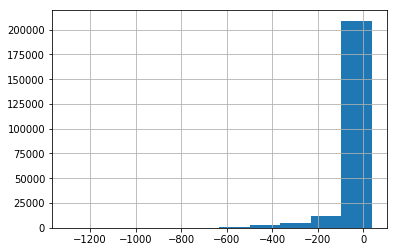

In [620]:
route_info_ca15.origin_schedule_deviation.hist()

In [ ]:
# Test the schedule adjustment solve with exact method
reward_mode=2
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=prd.extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,drivingcost_per_mile,num_time_interval)
R=prd.estimate_trip_reward(hh_num_trips,sorted_trips,Vehicular_Skim,reward_mode,superzone_map,drivingcost_per_mile)
num_cav=1
run_mode=2
single_model_runtime=60*30
m1,x,y,T,obj1,obj2,obj3=sod.dial_n_ride_model_schedule_adjustment(num_hh_member,hh_num_trips,C,TT,TL,TU,sorted_trips,
                    expected_arrival_time,early_penalty,late_penalty,
                    early_penalty_threshold,late_penalty_threshold,R,Vehicular_Skim,
                    share_ride_factor,output_flag,run_mode,reward_mode,
                    num_cav,num_time_interval,cav_use_mode,time_window_flag,single_model_runtime)

In [792]:
output_flag=1
target_hh_id=72808
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*0.5
drivingcost_per_mile=1
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=1
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
target_hh=target_trips[target_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]

num_cav=1
share_ride_factor=1.5
time_window_flag=0
#         time_window_flag=1
# num_cav=1
# share_ride_factor=1.5
# time_window_flag=0
print('**************')
print('Num_CAV',num_cav,share_ride_factor,time_window_flag)
print('**************')
darp_solutions.extend([sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim_Dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                                    superzone_map,min_length,max_length,reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                                    cav_use_mode,time_window_flag,single_model_runtime,num_time_interval,TL,TU,transit_zone_dict,transit_zone_candidates,
                                    TransitMazTazFlag,TransitSkimTimeIntervalLength)])

**************
Num_CAV 1 1.5 0
**************
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 30.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
***********************
2.77095 7.4659 4.05715 5.36345 7.787
***********************
Optimize a model with 1063 rows, 624 columns and 6099 nonzeros
Variable types: 48 continuous, 576 integer (576 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 3e+05]

Loaded MIP start with objective 5258.03

Presolve removed 308 rows and 287 columns
Presolve time: 0.27s
Presolved: 755 rows, 337 columns, 3568 nonzeros
Variable types: 48 continuous, 289 integer (289 binary)

Root relaxation: objective 5.311076e+03, 131 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

In [ ]:
print(datetime.datetime.now())
for i in range(100):
    for j in initial_route_info.orig_node_index:
        z=1
print(datetime.datetime.now())

for i in range(100):
    for index, row in initial_route_info.iterrows():
        z=1
    
print(datetime.datetime.now())

# Solve for all households car trips only

In [989]:
output_flag=1
target_hh_id=1589512
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1
time_window_flag=0
print(datetime.datetime.now())
route_info1=sod.find_av_schedule_exact_method(target_hh_id,traveler_trips.loc[traveler_trips.tripmode<=6],output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,Transit_AB_Cost_Skim,superzone_map,TL,TU)
print(datetime.datetime.now())
target_hh=traveler_trips[(traveler_trips['hh_id']==target_hh_id) &(traveler_trips.tripmode<=6)]\
        .drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose',
                                 'starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
hh_num_trips=sorted_trips.shape[0]

sorted_trips["hh_index"]=(range(hh_num_trips))
print(datetime.datetime.now())
darp_solution1=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim_Dict,Transit_AB_Cost_Skim,superzone_map,min_length,max_length,
                                    reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                                    cav_use_mode,time_window_flag,single_model_runtime,num_time_interval,TL,TU)
print(datetime.datetime.now())

2018-07-16 14:43:21.213721


TypeError: find_av_schedule_exact_method() missing 2 required positional arguments: 'TU' and 'transit_zone_dict'

In [285]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=1
reward_mode=2
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.25
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]

route_info_allcartrips125,darp_solutions_allcartrips_temp125=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,Transit_AB_Cost_Skim,superzone_map,TL,TU)

Estimate Route for the  0 th household  2018-07-12 20:55:01.397791
1 9 2018-07-12 20:55:01.810821
2 14 2018-07-12 20:55:02.657866
3 13 2018-07-12 20:55:03.153901
4 25 2018-07-12 20:55:04.607987
5 9 2018-07-12 20:55:04.979008
6 6 2018-07-12 20:55:05.282019
7 8 2018-07-12 20:55:05.726046
8 9 2018-07-12 20:55:06.224075
9 8 2018-07-12 20:55:06.593103
10 7 2018-07-12 20:55:07.021122
11 11 2018-07-12 20:55:08.024187
12 12 2018-07-12 20:55:08.484214
13 4 2018-07-12 20:55:08.674220
14 6 2018-07-12 20:55:08.963242
15 13 2018-07-12 20:55:09.612275
16 14 2018-07-12 20:55:10.135311
17 11 2018-07-12 20:55:10.702344
18 8 2018-07-12 20:55:11.109370
19 6 2018-07-12 20:55:11.469511
20 5 2018-07-12 20:55:11.830532
21 6 2018-07-12 20:55:12.132555
22 10 2018-07-12 20:55:12.595583
23 15 2018-07-12 20:55:13.165613
24 18 2018-07-12 20:55:16.665823
25 14 2018-07-12 20:55:18.593930
26 6 2018-07-12 20:55:18.876947
27 9 2018-07-12 20:55:19.289970
28 6 2018-07-12 20:55:19.553986
29 5 2018-07-12 20:55:19.813002
30

243 13 2018-07-12 20:57:39.079328
244 21 2018-07-12 20:57:40.510406
245 14 2018-07-12 20:57:41.218448
246 10 2018-07-12 20:57:41.619471
247 8 2018-07-12 20:57:41.955491
248 9 2018-07-12 20:57:42.314513
249 10 2018-07-12 20:57:42.747538
250 12 2018-07-12 20:57:43.991611
251 20 2018-07-12 20:57:45.342690
252 27 2018-07-12 20:57:48.181857
253 2 2018-07-12 20:57:48.324872
254 20 2018-07-12 20:57:51.125037
255 4 2018-07-12 20:57:51.339043
256 16 2018-07-12 20:57:52.596117
257 11 2018-07-12 20:57:53.230156
258 13 2018-07-12 20:57:54.636239
259 8 2018-07-12 20:57:54.973256
260 10 2018-07-12 20:57:55.379280
261 26 2018-07-12 20:57:59.525525
262 25 2018-07-12 20:58:14.243395
263 11 2018-07-12 20:58:14.736425
264 2 2018-07-12 20:58:14.882432
265 11 2018-07-12 20:58:15.406458
266 13 2018-07-12 20:58:15.920494
267 9 2018-07-12 20:58:16.273509
268 9 2018-07-12 20:58:16.724540
269 4 2018-07-12 20:58:16.926548
270 10 2018-07-12 20:58:17.320570
271 7 2018-07-12 20:58:17.614587
272 8 2018-07-12 20:58:1

484 8 2018-07-12 21:01:08.628639
485 4 2018-07-12 21:01:08.873653
486 14 2018-07-12 21:01:09.423685
487 10 2018-07-12 21:01:09.750704
488 12 2018-07-12 21:01:10.447752
489 7 2018-07-12 21:01:10.737763
490 10 2018-07-12 21:01:11.105784
491 9 2018-07-12 21:01:11.489807
492 14 2018-07-12 21:01:12.464864
493 8 2018-07-12 21:01:12.759881
494 7 2018-07-12 21:01:13.061899
495 7 2018-07-12 21:01:13.339916
496 7 2018-07-12 21:01:13.626932
497 5 2018-07-12 21:01:13.848945
498 6 2018-07-12 21:01:14.140962
499 9 2018-07-12 21:01:14.508990
500 11 2018-07-12 21:01:15.038021
Estimate Route for the  500 th household  2018-07-12 21:01:15.044022
501 7 2018-07-12 21:01:15.322032
502 14 2018-07-12 21:01:16.201083
503 18 2018-07-12 21:01:17.194142
504 20 2018-07-12 21:01:18.443215
505 10 2018-07-12 21:01:19.101254
506 11 2018-07-12 21:01:19.826297
507 5 2018-07-12 21:01:20.090312
508 11 2018-07-12 21:01:20.607342
509 8 2018-07-12 21:01:20.936362
510 2 2018-07-12 21:01:21.078371
511 13 2018-07-12 21:01:21.7

723 12 2018-07-12 21:03:19.085313
724 6 2018-07-12 21:03:19.269317
725 2 2018-07-12 21:03:19.413326
726 3 2018-07-12 21:03:19.559336
727 5 2018-07-12 21:03:19.838350
728 13 2018-07-12 21:03:21.612455
729 13 2018-07-12 21:03:22.290495
730 4 2018-07-12 21:03:22.461505
731 18 2018-07-12 21:03:24.410619
732 6 2018-07-12 21:03:24.704636
733 14 2018-07-12 21:03:26.051717
734 13 2018-07-12 21:03:27.377794
735 10 2018-07-12 21:03:27.945833
736 13 2018-07-12 21:03:28.621867
737 19 2018-07-12 21:03:29.362911
738 10 2018-07-12 21:03:29.800942
739 2 2018-07-12 21:03:29.943950
740 17 2018-07-12 21:03:30.973005
741 6 2018-07-12 21:03:31.226020
742 9 2018-07-12 21:03:31.622043
743 9 2018-07-12 21:03:32.000065
744 10 2018-07-12 21:03:32.475093
745 14 2018-07-12 21:03:33.021125
746 7 2018-07-12 21:03:33.241138
747 12 2018-07-12 21:03:33.767169
748 6 2018-07-12 21:03:34.010184
749 13 2018-07-12 21:03:34.737226
750 3 2018-07-12 21:03:34.893236
751 10 2018-07-12 21:03:35.294259
752 9 2018-07-12 21:03:35.5

965 17 2018-07-12 21:05:41.381670
966 10 2018-07-12 21:05:41.859698
967 15 2018-07-12 21:05:43.113772
968 7 2018-07-12 21:05:43.425790
969 8 2018-07-12 21:05:43.927820
970 3 2018-07-12 21:05:44.083829
971 15 2018-07-12 21:05:44.933879
972 8 2018-07-12 21:05:45.185893
973 5 2018-07-12 21:05:45.401906
974 11 2018-07-12 21:05:46.317963
975 6 2018-07-12 21:05:46.631978
976 4 2018-07-12 21:05:46.803988
977 20 2018-07-12 21:05:48.982116
978 10 2018-07-12 21:05:49.409148
979 5 2018-07-12 21:05:49.683164
980 9 2018-07-12 21:05:50.094189
981 19 2018-07-12 21:05:51.640274
982 19 2018-07-12 21:05:52.394317
983 20 2018-07-12 21:05:55.914524
984 5 2018-07-12 21:05:56.146538
985 7 2018-07-12 21:05:56.447555
986 2 2018-07-12 21:05:56.594566
987 10 2018-07-12 21:05:58.097659
988 6 2018-07-12 21:05:58.400670
989 16 2018-07-12 21:05:59.354728
990 8 2018-07-12 21:05:59.684745
991 5 2018-07-12 21:05:59.927760
992 11 2018-07-12 21:06:01.046826
993 7 2018-07-12 21:06:01.329842
994 15 2018-07-12 21:06:02.544

1201 12 2018-07-12 21:08:07.062232
1202 5 2018-07-12 21:08:07.326248
1203 20 2018-07-12 21:08:11.401488
1204 14 2018-07-12 21:08:12.530554
1205 11 2018-07-12 21:08:13.796628
1206 8 2018-07-12 21:08:14.114647
1207 3 2018-07-12 21:08:14.296659
1208 13 2018-07-12 21:08:15.198710
1209 4 2018-07-12 21:08:15.370721
1210 7 2018-07-12 21:08:15.696745
1211 16 2018-07-12 21:08:16.547790
1212 10 2018-07-12 21:08:16.992816
1213 1 2018-07-12 21:08:17.093822
1214 8 2018-07-12 21:08:17.642854
1215 6 2018-07-12 21:08:17.921870
1216 9 2018-07-12 21:08:18.169885
1217 7 2018-07-12 21:08:18.420900
1218 23 2018-07-12 21:08:19.460961
1219 8 2018-07-12 21:08:19.812982
1220 5 2018-07-12 21:08:20.095998
1221 13 2018-07-12 21:08:20.596028
1222 4 2018-07-12 21:08:20.832041
1223 4 2018-07-12 21:08:20.975055
1224 6 2018-07-12 21:08:21.225065
1225 10 2018-07-12 21:08:21.585086
1226 9 2018-07-12 21:08:21.995110
1227 6 2018-07-12 21:08:22.292127
1228 16 2018-07-12 21:08:22.903163
1229 5 2018-07-12 21:08:23.174180
123

1435 5 2018-07-12 21:11:05.648729
1436 17 2018-07-12 21:11:06.483783
1437 14 2018-07-12 21:11:07.063814
1438 24 2018-07-12 21:11:09.438957
1439 11 2018-07-12 21:11:10.052988
1440 11 2018-07-12 21:11:10.573024
1441 6 2018-07-12 21:11:10.821033
1442 10 2018-07-12 21:11:11.979107
1443 4 2018-07-12 21:11:12.216120
1444 12 2018-07-12 21:11:12.704144
1445 16 2018-07-12 21:11:13.323181
1446 14 2018-07-12 21:11:15.087289
1447 14 2018-07-12 21:11:16.776388
1448 8 2018-07-12 21:11:17.047404
1449 19 2018-07-12 21:11:20.489606
1450 14 2018-07-12 21:11:22.233704
1451 5 2018-07-12 21:11:22.497719
1452 5 2018-07-12 21:11:22.717733
1453 7 2018-07-12 21:11:23.015756
1454 8 2018-07-12 21:11:23.276765
1455 10 2018-07-12 21:11:23.746798
1456 10 2018-07-12 21:11:24.274829
1457 11 2018-07-12 21:11:24.829856
1458 8 2018-07-12 21:11:25.233880
1459 4 2018-07-12 21:11:25.407896
1460 19 2018-07-12 21:11:30.739209
1461 5 2018-07-12 21:11:30.983218
1462 7 2018-07-12 21:11:31.279235
1463 9 2018-07-12 21:11:32.07228

1670 11 2018-07-12 21:14:17.405000
1671 8 2018-07-12 21:14:17.800023
1672 11 2018-07-12 21:14:18.378062
1673 3 2018-07-12 21:14:18.541071
1674 14 2018-07-12 21:14:20.130165
1675 4 2018-07-12 21:14:20.304175
1676 6 2018-07-12 21:14:20.591188
1677 6 2018-07-12 21:14:20.841206
1678 6 2018-07-12 21:14:21.142219
1679 10 2018-07-12 21:14:21.964269
1680 10 2018-07-12 21:14:22.295286
1681 15 2018-07-12 21:14:23.069338
1682 11 2018-07-12 21:14:23.624371
1683 6 2018-07-12 21:14:23.883381
1684 5 2018-07-12 21:14:24.162396
1685 7 2018-07-12 21:14:24.412417
1686 13 2018-07-12 21:14:24.837442
1687 7 2018-07-12 21:14:25.142454
1688 7 2018-07-12 21:14:25.450478
1689 10 2018-07-12 21:14:25.911500
1690 8 2018-07-12 21:14:26.268526
1691 10 2018-07-12 21:14:26.733553
1692 4 2018-07-12 21:14:26.941565
1693 20 2018-07-12 21:14:31.357820
1694 4 2018-07-12 21:14:31.529830
1695 19 2018-07-12 21:14:41.322411
1696 11 2018-07-12 21:14:41.638430
1697 8 2018-07-12 21:14:41.932447
1698 8 2018-07-12 21:14:42.289462
1

1902 18 2018-07-12 21:16:46.656777
1903 3 2018-07-12 21:16:46.814787
1904 9 2018-07-12 21:16:47.130801
1905 5 2018-07-12 21:16:47.404816
1906 9 2018-07-12 21:16:47.682833
1907 10 2018-07-12 21:16:48.402880
1908 12 2018-07-12 21:16:49.019911
1909 4 2018-07-12 21:16:49.239929
1910 8 2018-07-12 21:16:49.808962
1911 12 2018-07-12 21:16:50.856024
1912 16 2018-07-12 21:16:52.691132
1913 9 2018-07-12 21:16:53.213158
1914 8 2018-07-12 21:16:53.622187
1915 12 2018-07-12 21:16:54.248218
1916 10 2018-07-12 21:16:54.773254
1917 10 2018-07-12 21:16:55.236282
1918 6 2018-07-12 21:16:55.490297
1919 4 2018-07-12 21:16:55.884314
1920 5 2018-07-12 21:16:56.128334
1921 7 2018-07-12 21:16:56.435352
1922 2 2018-07-12 21:16:56.590356
1923 2 2018-07-12 21:16:56.741370
1924 20 2018-07-12 21:16:57.818428
1925 12 2018-07-12 21:16:58.459471
1926 11 2018-07-12 21:16:58.949494
1927 13 2018-07-12 21:16:59.800550
1928 3 2018-07-12 21:16:59.974554
1929 10 2018-07-12 21:17:00.818605
1930 11 2018-07-12 21:17:01.418644


2136 9 2018-07-12 21:19:48.009432
2137 22 2018-07-12 21:19:48.695477
2138 12 2018-07-12 21:19:49.409514
2139 8 2018-07-12 21:19:49.715532
2140 8 2018-07-12 21:19:50.064553
2141 4 2018-07-12 21:19:50.210560
2142 15 2018-07-12 21:19:51.068617
2143 7 2018-07-12 21:19:51.421637
2144 9 2018-07-12 21:19:51.831661
2145 4 2018-07-12 21:19:52.088671
2146 4 2018-07-12 21:19:52.267687
2147 8 2018-07-12 21:19:52.628708
2148 10 2018-07-12 21:19:53.088735
2149 17 2018-07-12 21:19:54.114795
2150 5 2018-07-12 21:19:54.369810
2151 19 2018-07-12 21:19:56.338920
2152 10 2018-07-12 21:19:56.666945
2153 8 2018-07-12 21:19:57.033967
2154 4 2018-07-12 21:19:57.197977
2155 5 2018-07-12 21:19:57.466992
2156 15 2018-07-12 21:19:58.322037
2157 11 2018-07-12 21:19:58.642055
2158 27 2018-07-12 21:20:04.003374
2159 18 2018-07-12 21:20:05.984488
2160 13 2018-07-12 21:20:06.796535
2161 9 2018-07-12 21:20:07.204561
2162 11 2018-07-12 21:20:08.468633
2163 24 2018-07-12 21:20:11.549816
2164 4 2018-07-12 21:20:11.802831


2371 6 2018-07-12 21:22:25.028665
2372 2 2018-07-12 21:22:25.185669
2373 7 2018-07-12 21:22:25.475687
2374 18 2018-07-12 21:22:26.552756
2375 5 2018-07-12 21:22:26.789769
2376 6 2018-07-12 21:22:27.069780
2377 10 2018-07-12 21:22:27.593811
2378 12 2018-07-12 21:22:28.107842
2379 10 2018-07-12 21:22:28.754880
2380 7 2018-07-12 21:22:29.137904
2381 5 2018-07-12 21:22:29.397922
2382 3 2018-07-12 21:22:29.559926
2383 8 2018-07-12 21:22:29.907947
2384 9 2018-07-12 21:22:30.364979
2385 2 2018-07-12 21:22:30.526998
2386 7 2018-07-12 21:22:30.857006
2387 6 2018-07-12 21:22:31.121018
2388 5 2018-07-12 21:22:31.362038
2389 6 2018-07-12 21:22:31.704052
2390 3 2018-07-12 21:22:31.861067
2391 2 2018-07-12 21:22:32.017071
2392 4 2018-07-12 21:22:32.227089
2393 5 2018-07-12 21:22:32.455097
2394 10 2018-07-12 21:22:33.987187
2395 9 2018-07-12 21:22:34.350209
2396 14 2018-07-12 21:22:35.431275
2397 4 2018-07-12 21:22:35.678289
2398 11 2018-07-12 21:22:36.160317
2399 7 2018-07-12 21:22:36.692347
2400 9 

2604 8 2018-07-12 21:24:49.807169
2605 8 2018-07-12 21:24:50.167191
2606 11 2018-07-12 21:24:50.578218
2607 3 2018-07-12 21:24:50.704221
2608 10 2018-07-12 21:24:51.158249
2609 2 2018-07-12 21:24:51.314258
2610 5 2018-07-12 21:24:51.477267
2611 9 2018-07-12 21:24:51.897292
2612 11 2018-07-12 21:24:52.608340
2613 7 2018-07-12 21:24:52.854348
2614 8 2018-07-12 21:24:53.211369
2615 3 2018-07-12 21:24:53.375379
2616 6 2018-07-12 21:24:53.735401
2617 8 2018-07-12 21:24:54.174427
2618 8 2018-07-12 21:24:54.592451
2619 9 2018-07-12 21:24:54.991479
2620 26 2018-07-12 21:25:03.603980
2621 4 2018-07-12 21:25:03.786997
2622 7 2018-07-12 21:25:04.044012
2623 10 2018-07-12 21:25:04.514037
2624 7 2018-07-12 21:25:04.826053
2625 2 2018-07-12 21:25:04.991062
2626 8 2018-07-12 21:25:05.438088
2627 3 2018-07-12 21:25:05.607104
2628 10 2018-07-12 21:25:06.093129
2629 12 2018-07-12 21:25:06.630159
2630 4 2018-07-12 21:25:06.861177
2631 7 2018-07-12 21:25:07.193196
2632 7 2018-07-12 21:25:07.458207
2633 6 

2839 5 2018-07-12 21:28:04.730627
2840 5 2018-07-12 21:28:04.996642
2841 8 2018-07-12 21:28:05.353663
2842 10 2018-07-12 21:28:05.915696
2843 18 2018-07-12 21:28:07.041762
2844 7 2018-07-12 21:28:07.777806
2845 5 2018-07-12 21:28:08.080823
2846 8 2018-07-12 21:28:08.496853
2847 5 2018-07-12 21:28:08.735861
2848 10 2018-07-12 21:28:09.081882
2849 4 2018-07-12 21:28:09.271893
2850 9 2018-07-12 21:28:09.664917
2851 6 2018-07-12 21:28:09.956934
2852 6 2018-07-12 21:28:10.452962
2853 9 2018-07-12 21:28:10.828986
2854 2 2018-07-12 21:28:11.028996
2855 11 2018-07-12 21:28:11.509024
2856 8 2018-07-12 21:28:11.879047
2857 12 2018-07-12 21:28:12.635091
2858 16 2018-07-12 21:28:13.373139
2859 4 2018-07-12 21:28:13.576152
2860 14 2018-07-12 21:28:14.209189
2861 6 2018-07-12 21:28:14.522202
2862 13 2018-07-12 21:28:16.095295
2863 6 2018-07-12 21:28:16.398312
2864 4 2018-07-12 21:28:16.631331
2865 12 2018-07-12 21:28:17.187363
2866 6 2018-07-12 21:28:17.456374
2867 11 2018-07-12 21:28:18.060415
2868

3074 6 2018-07-12 21:30:08.052879
3075 6 2018-07-12 21:30:08.371896
3076 11 2018-07-12 21:30:08.934926
3077 2 2018-07-12 21:30:09.093935
3078 4 2018-07-12 21:30:09.310950
3079 12 2018-07-12 21:30:10.036991
3080 3 2018-07-12 21:30:10.245004
3081 7 2018-07-12 21:30:10.719036
3082 5 2018-07-12 21:30:10.991053
3083 3 2018-07-12 21:30:11.138061
3084 12 2018-07-12 21:30:11.544081
3085 6 2018-07-12 21:30:11.832103
3086 17 2018-07-12 21:30:12.767151
3087 10 2018-07-12 21:30:13.149183
3088 17 2018-07-12 21:30:13.818214
3089 11 2018-07-12 21:30:14.174239
3090 2 2018-07-12 21:30:14.333249
3091 3 2018-07-12 21:30:14.494258
3092 6 2018-07-12 21:30:14.758274
3093 7 2018-07-12 21:30:15.061292
3094 10 2018-07-12 21:30:15.571317
3095 2 2018-07-12 21:30:15.738331
3096 12 2018-07-12 21:30:16.145350
3097 2 2018-07-12 21:30:16.307365
3098 10 2018-07-12 21:30:16.846392
3099 6 2018-07-12 21:30:17.103412
3100 11 2018-07-12 21:30:17.547433
Estimate Route for the  3100 th household  2018-07-12 21:30:17.570435
3

3307 5 2018-07-12 21:32:45.287121
3308 6 2018-07-12 21:32:45.537130
3309 6 2018-07-12 21:32:45.800147
3310 4 2018-07-12 21:32:45.991162
3311 10 2018-07-12 21:32:46.475191
3312 5 2018-07-12 21:32:46.717201
3313 12 2018-07-12 21:32:47.211233
3314 9 2018-07-12 21:32:47.856272
3315 6 2018-07-12 21:32:48.139289
3316 1 2018-07-12 21:32:48.252295
3317 7 2018-07-12 21:32:48.463308
3318 4 2018-07-12 21:32:48.681321
3319 11 2018-07-12 21:32:49.594375
3320 13 2018-07-12 21:32:50.366420
3321 11 2018-07-12 21:32:51.048456
3322 5 2018-07-12 21:32:51.292469
3323 6 2018-07-12 21:32:51.599488
3324 4 2018-07-12 21:32:51.859507
3325 9 2018-07-12 21:32:52.529542
3326 3 2018-07-12 21:32:52.710553
3327 4 2018-07-12 21:32:52.890564
3328 6 2018-07-12 21:32:53.189586
3329 1 2018-07-12 21:32:53.303587
3330 13 2018-07-12 21:32:53.910629
3331 13 2018-07-12 21:32:55.138698
3332 7 2018-07-12 21:32:55.467715
3333 5 2018-07-12 21:32:55.711732
3334 4 2018-07-12 21:32:55.929744
3335 9 2018-07-12 21:32:56.299763
3336 6 

3542 14 2018-07-12 21:35:35.629131
3543 5 2018-07-12 21:35:35.930149
3544 6 2018-07-12 21:35:36.207165
3545 13 2018-07-12 21:35:37.446239
3546 11 2018-07-12 21:35:39.109339
3547 4 2018-07-12 21:35:39.319351
3548 6 2018-07-12 21:35:39.596367
3549 8 2018-07-12 21:35:39.971385
3550 7 2018-07-12 21:35:40.201399
3551 8 2018-07-12 21:35:40.568424
3552 5 2018-07-12 21:35:40.849441
3553 5 2018-07-12 21:35:41.135458
3554 5 2018-07-12 21:35:41.389472
3555 9 2018-07-12 21:35:41.986501
3556 4 2018-07-12 21:35:42.200520
3557 11 2018-07-12 21:35:42.773548
3558 3 2018-07-12 21:35:42.967565
3559 7 2018-07-12 21:35:43.420588
3560 7 2018-07-12 21:35:43.869617
3561 10 2018-07-12 21:35:44.178635
3562 13 2018-07-12 21:35:44.899673
3563 11 2018-07-12 21:35:45.284701
3564 8 2018-07-12 21:35:45.661723
3565 5 2018-07-12 21:35:45.907738
3566 11 2018-07-12 21:35:46.291755
3567 22 2018-07-12 21:35:48.926910
3568 11 2018-07-12 21:35:49.511944
3569 18 2018-07-12 21:35:50.944032
3570 20 2018-07-12 21:35:54.064217
35

3777 9 2018-07-12 21:38:00.408639
3778 11 2018-07-12 21:38:00.849663
3779 6 2018-07-12 21:38:01.230689
3780 6 2018-07-12 21:38:01.698714
3781 7 2018-07-12 21:38:02.024732
3782 7 2018-07-12 21:38:02.340757
3783 9 2018-07-12 21:38:03.596825
3784 10 2018-07-12 21:38:03.968852
3785 6 2018-07-12 21:38:04.257865
3786 7 2018-07-12 21:38:04.588883
3787 5 2018-07-12 21:38:04.876905
3788 5 2018-07-12 21:38:05.125915
3789 3 2018-07-12 21:38:05.300931
3790 7 2018-07-12 21:38:05.563940
3791 3 2018-07-12 21:38:05.741956
3792 7 2018-07-12 21:38:06.082971
3793 3 2018-07-12 21:38:06.240985
3794 6 2018-07-12 21:38:06.508997
3795 5 2018-07-12 21:38:06.749015
3796 2 2018-07-12 21:38:06.911025
3797 12 2018-07-12 21:38:07.299042
3798 8 2018-07-12 21:38:07.783076
3799 5 2018-07-12 21:38:08.029087
3800 8 2018-07-12 21:38:08.445109
Estimate Route for the  3800 th household  2018-07-12 21:38:08.469111
3801 7 2018-07-12 21:38:08.762135
3802 5 2018-07-12 21:38:09.000142
3803 5 2018-07-12 21:38:09.282164
3804 14 2

4011 12 2018-07-12 21:40:26.121202
4012 10 2018-07-12 21:40:26.458222
4013 8 2018-07-12 21:40:26.945255
4014 5 2018-07-12 21:40:27.252268
4015 5 2018-07-12 21:40:27.504288
4016 6 2018-07-12 21:40:27.790305
4017 12 2018-07-12 21:40:28.266328
4018 8 2018-07-12 21:40:28.659351
4019 9 2018-07-12 21:40:28.992370
4020 3 2018-07-12 21:40:29.194384
4021 4 2018-07-12 21:40:29.430401
4022 16 2018-07-12 21:40:30.155439
4023 12 2018-07-12 21:40:30.762475
4024 4 2018-07-12 21:40:30.919484
4025 4 2018-07-12 21:40:31.153505
4026 10 2018-07-12 21:40:31.669528
4027 5 2018-07-12 21:40:31.922544
4028 7 2018-07-12 21:40:32.263568
4029 12 2018-07-12 21:40:32.662586
4030 9 2018-07-12 21:40:33.053615
4031 21 2018-07-12 21:40:34.844715
4032 18 2018-07-12 21:40:37.976902
4033 7 2018-07-12 21:40:38.350926
4034 2 2018-07-12 21:40:38.511935
4035 2 2018-07-12 21:40:38.679946
4036 7 2018-07-12 21:40:39.039962
4037 12 2018-07-12 21:40:39.837014
4038 4 2018-07-12 21:40:40.032021
4039 9 2018-07-12 21:40:40.721060
4040

4247 10 2018-07-12 21:42:50.396681
4248 8 2018-07-12 21:42:50.650696
4249 6 2018-07-12 21:42:50.952720
4250 9 2018-07-12 21:42:51.336737
4251 20 2018-07-12 21:42:52.229789
4252 6 2018-07-12 21:42:52.568810
4253 7 2018-07-12 21:42:52.886828
4254 14 2018-07-12 21:42:53.495866
4255 11 2018-07-12 21:42:54.111905
4256 13 2018-07-12 21:42:55.430982
4257 4 2018-07-12 21:42:55.623995
4258 6 2018-07-12 21:42:55.896012
4259 6 2018-07-12 21:42:56.194027
4260 2 2018-07-12 21:42:56.364037
4261 9 2018-07-12 21:42:57.169080
4262 8 2018-07-12 21:42:57.521100
4263 13 2018-07-12 21:42:58.121136
4264 14 2018-07-12 21:42:59.820237
4265 6 2018-07-12 21:43:00.143257
4266 12 2018-07-12 21:43:00.631288
4267 3 2018-07-12 21:43:00.781292
4268 8 2018-07-12 21:43:01.133313
4269 4 2018-07-12 21:43:01.394328
4270 7 2018-07-12 21:43:02.012370
4271 7 2018-07-12 21:43:02.329388
4272 6 2018-07-12 21:43:02.628406
4273 10 2018-07-12 21:43:02.939419
4274 12 2018-07-12 21:43:04.070491
4275 9 2018-07-12 21:43:04.549514
4276

4484 3 2018-07-12 21:44:50.630749
4485 8 2018-07-12 21:44:51.120778
4486 5 2018-07-12 21:44:51.371792
4487 8 2018-07-12 21:44:51.667815
4488 4 2018-07-12 21:44:51.829820
4489 6 2018-07-12 21:44:52.070839
4490 11 2018-07-12 21:44:53.596923
4491 9 2018-07-12 21:44:53.892941
4492 4 2018-07-12 21:44:54.085952
4493 8 2018-07-12 21:44:54.435978
4494 8 2018-07-12 21:44:54.696993
4495 8 2018-07-12 21:44:55.068015
4496 9 2018-07-12 21:44:55.523036
4497 2 2018-07-12 21:44:55.689047
4498 4 2018-07-12 21:44:55.912064
4499 11 2018-07-12 21:44:56.726107
4500 8 2018-07-12 21:44:57.088134
Estimate Route for the  4500 th household  2018-07-12 21:44:57.120135
4501 9 2018-07-12 21:44:57.570162
4502 3 2018-07-12 21:44:57.758173
4503 20 2018-07-12 21:44:58.938237
4504 4 2018-07-12 21:44:59.132254
4505 7 2018-07-12 21:44:59.351264
4506 7 2018-07-12 21:44:59.663285
4507 2 2018-07-12 21:44:59.830291
4508 4 2018-07-12 21:45:00.091305
4509 2 2018-07-12 21:45:00.247315
4510 5 2018-07-12 21:45:00.490331
4511 13 2

4717 8 2018-07-12 21:47:02.045474
4718 4 2018-07-12 21:47:02.324494
4719 11 2018-07-12 21:47:03.061536
4720 4 2018-07-12 21:47:03.305546
4721 11 2018-07-12 21:47:04.563621
4722 7 2018-07-12 21:47:04.879639
4723 15 2018-07-12 21:47:06.416739
4724 6 2018-07-12 21:47:06.875756
4725 10 2018-07-12 21:47:07.471793
4726 10 2018-07-12 21:47:07.960821
4727 2 2018-07-12 21:47:08.239839
4728 3 2018-07-12 21:47:08.542855
4729 4 2018-07-12 21:47:08.804870
4730 8 2018-07-12 21:47:09.234900
4731 5 2018-07-12 21:47:09.745927
4732 10 2018-07-12 21:47:10.341966
4733 3 2018-07-12 21:47:10.532972
4734 10 2018-07-12 21:47:11.280015
4735 16 2018-07-12 21:47:12.364079
4736 12 2018-07-12 21:47:13.182128
4737 9 2018-07-12 21:47:14.112183
4738 9 2018-07-12 21:47:14.654215
4739 11 2018-07-12 21:47:15.389257
4740 6 2018-07-12 21:47:15.679278
4741 8 2018-07-12 21:47:16.249307
4742 4 2018-07-12 21:47:16.560327
4743 5 2018-07-12 21:47:16.917349
4744 5 2018-07-12 21:47:17.204365
4745 13 2018-07-12 21:47:19.083476
474

4954 4 2018-07-12 21:49:11.731095
4955 12 2018-07-12 21:49:13.149180
4956 6 2018-07-12 21:49:13.423199
4957 13 2018-07-12 21:49:14.106235
4958 9 2018-07-12 21:49:14.730272
4959 12 2018-07-12 21:49:16.048349
4960 6 2018-07-12 21:49:16.377369
4961 6 2018-07-12 21:49:16.684386
4962 11 2018-07-12 21:49:17.193422
4963 1 2018-07-12 21:49:17.359426
4964 2 2018-07-12 21:49:17.541438
4965 3 2018-07-12 21:49:17.717447
4966 2 2018-07-12 21:49:17.890457
4967 4 2018-07-12 21:49:18.093471
4968 4 2018-07-12 21:49:18.374488
4969 14 2018-07-12 21:49:19.015524
4970 2 2018-07-12 21:49:19.197534
4971 13 2018-07-12 21:49:20.154592
4972 7 2018-07-12 21:49:20.672626
4973 9 2018-07-12 21:49:21.169650
4974 3 2018-07-12 21:49:21.330659
4975 9 2018-07-12 21:49:21.877691
4976 8 2018-07-12 21:49:22.250718
4977 5 2018-07-12 21:49:22.494728
4978 15 2018-07-12 21:49:23.868813
4979 14 2018-07-12 21:49:24.686856
4980 7 2018-07-12 21:49:24.947872
4981 3 2018-07-12 21:49:25.115887
4982 6 2018-07-12 21:49:25.434901
4983 1

5189 5 2018-07-12 21:51:11.290126
5190 9 2018-07-12 21:51:11.667144
5191 6 2018-07-12 21:51:11.960166
5192 4 2018-07-12 21:51:12.160174
5193 3 2018-07-12 21:51:12.393190
5194 5 2018-07-12 21:51:12.698204
5195 2 2018-07-12 21:51:12.865214
5196 5 2018-07-12 21:51:13.121230
5197 7 2018-07-12 21:51:13.458251
5198 4 2018-07-12 21:51:13.709266
5199 10 2018-07-12 21:51:14.199293
5200 8 2018-07-12 21:51:14.612322
Estimate Route for the  5200 th household  2018-07-12 21:51:14.645320
5201 9 2018-07-12 21:51:15.040343
5202 8 2018-07-12 21:51:15.804392
5203 2 2018-07-12 21:51:15.974403
5204 10 2018-07-12 21:51:16.821450
5205 7 2018-07-12 21:51:17.132469
5206 10 2018-07-12 21:51:17.750504
5207 7 2018-07-12 21:51:18.074521
5208 5 2018-07-12 21:51:18.396541
5209 10 2018-07-12 21:51:19.063579
5210 5 2018-07-12 21:51:19.413605
5211 16 2018-07-12 21:51:20.336656
5212 6 2018-07-12 21:51:20.634673
5213 7 2018-07-12 21:51:21.040701
5214 2 2018-07-12 21:51:21.209710
5215 7 2018-07-12 21:51:21.536724
5216 10

5422 7 2018-07-12 21:53:02.360657
5423 4 2018-07-12 21:53:02.557667
5424 17 2018-07-12 21:53:04.101756
5425 12 2018-07-12 21:53:05.094817
5426 12 2018-07-12 21:53:05.563845
5427 12 2018-07-12 21:53:05.990864
5428 6 2018-07-12 21:53:06.295887
5429 17 2018-07-12 21:53:06.866921
5430 8 2018-07-12 21:53:07.190940
5431 4 2018-07-12 21:53:07.452955
5432 6 2018-07-12 21:53:07.753966
5433 3 2018-07-12 21:53:07.940979
5434 10 2018-07-12 21:53:08.504014
5435 11 2018-07-12 21:53:08.902036
5436 8 2018-07-12 21:53:09.239060
5437 11 2018-07-12 21:53:09.695083
5438 1 2018-07-12 21:53:09.826095
5439 14 2018-07-12 21:53:11.303181
5440 4 2018-07-12 21:53:11.538195
5441 4 2018-07-12 21:53:11.810205
5442 5 2018-07-12 21:53:12.100228
5443 23 2018-07-12 21:53:14.278356
5444 10 2018-07-12 21:53:15.634433
5445 5 2018-07-12 21:53:15.887446
5446 3 2018-07-12 21:53:16.066456
5447 9 2018-07-12 21:53:16.477480
5448 7 2018-07-12 21:53:16.772497
5449 4 2018-07-12 21:53:16.970509
5450 7 2018-07-12 21:53:17.286531
545

5658 5 2018-07-12 21:55:09.003094
5659 10 2018-07-12 21:55:09.579127
5660 15 2018-07-12 21:55:10.975215
5661 4 2018-07-12 21:55:11.242230
5662 2 2018-07-12 21:55:11.415237
5663 10 2018-07-12 21:55:11.911270
5664 5 2018-07-12 21:55:12.204287
5665 2 2018-07-12 21:55:12.374297
5666 3 2018-07-12 21:55:12.535301
5667 14 2018-07-12 21:55:13.229344
5668 7 2018-07-12 21:55:13.505358
5669 11 2018-07-12 21:55:13.901389
5670 7 2018-07-12 21:55:14.162399
5671 8 2018-07-12 21:55:14.563421
5672 12 2018-07-12 21:55:15.269463
5673 7 2018-07-12 21:55:16.092510
5674 2 2018-07-12 21:55:16.262520
5675 7 2018-07-12 21:55:16.519535
5676 9 2018-07-12 21:55:16.930560
5677 7 2018-07-12 21:55:17.305582
5678 9 2018-07-12 21:55:17.746612
5679 10 2018-07-12 21:55:18.266639
5680 5 2018-07-12 21:55:18.493657
5681 10 2018-07-12 21:55:18.957680
5682 7 2018-07-12 21:55:19.221694
5683 2 2018-07-12 21:55:19.393705
5684 2 2018-07-12 21:55:19.567721
5685 3 2018-07-12 21:55:19.751727
5686 8 2018-07-12 21:55:20.050746
5687 8

5893 5 2018-07-12 21:56:57.128454
5894 3 2018-07-12 21:56:57.326465
5895 10 2018-07-12 21:56:57.857492
5896 4 2018-07-12 21:56:58.057504
5897 10 2018-07-12 21:56:58.528533
5898 16 2018-07-12 21:56:59.081569
5899 10 2018-07-12 21:56:59.551597
5900 6 2018-07-12 21:56:59.867616
Estimate Route for the  5900 th household  2018-07-12 21:56:59.904612
5901 4 2018-07-12 21:57:00.073627
5902 8 2018-07-12 21:57:00.359638
5903 6 2018-07-12 21:57:00.649661
5904 4 2018-07-12 21:57:00.849669
5905 7 2018-07-12 21:57:01.212690
5906 2 2018-07-12 21:57:01.405706
5907 8 2018-07-12 21:57:01.669721
5908 5 2018-07-12 21:57:01.962738
5909 10 2018-07-12 21:57:02.564773
5910 18 2018-07-12 21:57:03.406824
5911 3 2018-07-12 21:57:03.703837
5912 11 2018-07-12 21:57:05.246931
5913 9 2018-07-12 21:57:05.704952
5914 5 2018-07-12 21:57:05.948968
5915 2 2018-07-12 21:57:06.123983
5916 7 2018-07-12 21:57:06.524003
5917 5 2018-07-12 21:57:06.821022
5918 21 2018-07-12 21:57:09.071156
5919 1 2018-07-12 21:57:09.215164
5920

6127 13 2018-07-12 21:58:49.499055
6128 4 2018-07-12 21:58:49.709071
6129 4 2018-07-12 21:58:49.936079
6130 13 2018-07-12 21:58:50.575122
6131 6 2018-07-12 21:58:50.875134
6132 9 2018-07-12 21:58:51.325166
6133 23 2018-07-12 21:58:56.323460
6134 8 2018-07-12 21:58:56.758485
6135 12 2018-07-12 21:58:57.772541
6136 6 2018-07-12 21:58:58.139564
6137 11 2018-07-12 21:58:58.897606
6138 12 2018-07-12 21:58:59.628649
6139 10 2018-07-12 21:59:00.019671
6140 13 2018-07-12 21:59:00.726714
6141 7 2018-07-12 21:59:00.996731
6142 15 2018-07-12 21:59:01.583771
6143 10 2018-07-12 21:59:01.972788
6144 4 2018-07-12 21:59:02.211806
6145 4 2018-07-12 21:59:02.412819
6146 8 2018-07-12 21:59:02.766833
6147 6 2018-07-12 21:59:03.029854
6148 5 2018-07-12 21:59:03.386875
6149 17 2018-07-12 21:59:04.273928
6150 8 2018-07-12 21:59:04.623944
6151 5 2018-07-12 21:59:04.839956
6152 4 2018-07-12 21:59:05.048968
6153 5 2018-07-12 21:59:05.269980
6154 5 2018-07-12 21:59:05.478998
6155 3 2018-07-12 21:59:05.666009
615

6362 2 2018-07-12 22:00:47.234975
6363 11 2018-07-12 22:00:47.736009
6364 2 2018-07-12 22:00:47.916014
6365 4 2018-07-12 22:00:48.130027
6366 8 2018-07-12 22:00:48.558053
6367 7 2018-07-12 22:00:48.938074
6368 12 2018-07-12 22:00:49.639115
6369 7 2018-07-12 22:00:50.296159
6370 9 2018-07-12 22:00:50.631173
6371 8 2018-07-12 22:00:50.922190
6372 2 2018-07-12 22:00:51.111202
6373 6 2018-07-12 22:00:51.403220
6374 9 2018-07-12 22:00:52.704301
6375 17 2018-07-12 22:00:53.422338
6376 17 2018-07-12 22:00:56.843539
6377 13 2018-07-12 22:00:58.107613
6378 10 2018-07-12 22:00:59.293684
6379 6 2018-07-12 22:00:59.612701
6380 5 2018-07-12 22:00:59.860721
6381 6 2018-07-12 22:01:00.104737
6382 6 2018-07-12 22:01:00.429754
6383 9 2018-07-12 22:01:00.856779
6384 7 2018-07-12 22:01:01.150793
6385 9 2018-07-12 22:01:01.583817
6386 5 2018-07-12 22:01:01.883839
6387 12 2018-07-12 22:01:02.345862
6388 5 2018-07-12 22:01:02.625878
6389 9 2018-07-12 22:01:02.953898
6390 8 2018-07-12 22:01:03.358920
6391 6 

6598 7 2018-07-12 22:02:55.580518
6599 6 2018-07-12 22:02:55.942539
6600 11 2018-07-12 22:02:56.982603
Estimate Route for the  6600 th household  2018-07-12 22:02:57.031604
6601 6 2018-07-12 22:02:57.409625
6602 6 2018-07-12 22:02:57.691641
6603 7 2018-07-12 22:02:58.074669
6604 7 2018-07-12 22:02:58.496694
6605 9 2018-07-12 22:02:59.116726
6606 7 2018-07-12 22:02:59.589754
6607 2 2018-07-12 22:02:59.782764
6608 3 2018-07-12 22:02:59.982778
6609 1 2018-07-12 22:03:00.120789
6610 5 2018-07-12 22:03:00.429803
6611 12 2018-07-12 22:03:01.220849
6612 14 2018-07-12 22:03:03.181966
6613 14 2018-07-12 22:03:04.133026
6614 6 2018-07-12 22:03:04.470040
6615 8 2018-07-12 22:03:04.838061
6616 12 2018-07-12 22:03:05.654110
6617 4 2018-07-12 22:03:05.870127
6618 6 2018-07-12 22:03:06.172140
6619 6 2018-07-12 22:03:06.466162
6620 6 2018-07-12 22:03:06.743176
6621 5 2018-07-12 22:03:07.047190
6622 4 2018-07-12 22:03:07.351211
6623 8 2018-07-12 22:03:07.729235
6624 3 2018-07-12 22:03:07.956249
6625 6 

6832 6 2018-07-12 22:05:07.870294
6833 7 2018-07-12 22:05:08.291320
6834 10 2018-07-12 22:05:09.118367
6835 10 2018-07-12 22:05:09.646399
6836 14 2018-07-12 22:05:10.773466
6837 3 2018-07-12 22:05:10.968474
6838 3 2018-07-12 22:05:11.157486
6839 12 2018-07-12 22:05:11.650520
6840 2 2018-07-12 22:05:11.828526
6841 5 2018-07-12 22:05:12.120542
6842 7 2018-07-12 22:05:12.392564
6843 6 2018-07-12 22:05:12.722583
6844 7 2018-07-12 22:05:13.070603
6845 5 2018-07-12 22:05:13.375621
6846 9 2018-07-12 22:05:13.855644
6847 5 2018-07-12 22:05:14.152662
6848 12 2018-07-12 22:05:14.538684
6849 17 2018-07-12 22:05:15.812760
6850 6 2018-07-12 22:05:16.168781
6851 8 2018-07-12 22:05:16.565805
6852 2 2018-07-12 22:05:16.744814
6853 6 2018-07-12 22:05:17.069838
6854 5 2018-07-12 22:05:17.330855
6855 7 2018-07-12 22:05:17.687875
6856 4 2018-07-12 22:05:17.873882
6857 4 2018-07-12 22:05:18.088895
6858 7 2018-07-12 22:05:18.553920
6859 11 2018-07-12 22:05:19.118959
6860 14 2018-07-12 22:05:21.417091
6861 4

7067 5 2018-07-12 22:07:04.381140
7068 16 2018-07-12 22:07:05.243191
7069 11 2018-07-12 22:07:06.147249
7070 3 2018-07-12 22:07:06.312259
7071 5 2018-07-12 22:07:06.606271
7072 2 2018-07-12 22:07:06.790287
7073 8 2018-07-12 22:07:07.217308
7074 2 2018-07-12 22:07:07.403324
7075 21 2018-07-12 22:07:08.362377
7076 12 2018-07-12 22:07:08.991411
7077 8 2018-07-12 22:07:09.379435
7078 12 2018-07-12 22:07:09.862463
7079 14 2018-07-12 22:07:11.938586
7080 4 2018-07-12 22:07:12.206606
7081 10 2018-07-12 22:07:12.545621
7082 4 2018-07-12 22:07:12.733633
7083 4 2018-07-12 22:07:12.993652
7084 6 2018-07-12 22:07:13.302665
7085 8 2018-07-12 22:07:13.690687
7086 8 2018-07-12 22:07:13.964705
7087 7 2018-07-12 22:07:14.345727
7088 5 2018-07-12 22:07:14.656744
7089 11 2018-07-12 22:07:15.417791
7090 7 2018-07-12 22:07:16.472852
7091 6 2018-07-12 22:07:16.811871
7092 5 2018-07-12 22:07:17.188898
7093 2 2018-07-12 22:07:17.515912
7094 3 2018-07-12 22:07:17.711924
7095 10 2018-07-12 22:07:18.279964
7096 

7301 3 2018-07-12 22:09:22.745273
7302 4 2018-07-12 22:09:22.954285
7303 3 2018-07-12 22:09:23.194299
7304 2 2018-07-12 22:09:23.412316
7305 9 2018-07-12 22:09:23.819342
7306 8 2018-07-12 22:09:24.297370
7307 8 2018-07-12 22:09:24.612390
7308 14 2018-07-12 22:09:25.686452
7309 16 2018-07-12 22:09:26.397488
7310 12 2018-07-12 22:09:28.426607
7311 6 2018-07-12 22:09:28.718625
7312 12 2018-07-12 22:09:29.370663
7313 2 2018-07-12 22:09:29.561675
7314 2 2018-07-12 22:09:29.730685
7315 3 2018-07-12 22:09:29.917695
7316 11 2018-07-12 22:09:30.610741
7317 5 2018-07-12 22:09:30.888752
7318 2 2018-07-12 22:09:31.072768
7319 8 2018-07-12 22:09:31.348779
7320 6 2018-07-12 22:09:31.672797
7321 4 2018-07-12 22:09:31.916812
7322 4 2018-07-12 22:09:32.185830
7323 6 2018-07-12 22:09:32.479852
7324 5 2018-07-12 22:09:32.692864
7325 8 2018-07-12 22:09:33.125884
7326 5 2018-07-12 22:09:33.385898
7327 5 2018-07-12 22:09:33.624918
7328 3 2018-07-12 22:09:33.813931
7329 4 2018-07-12 22:09:34.025938
7330 8 20

7537 2 2018-07-12 22:11:06.918396
7538 2 2018-07-12 22:11:07.104408
7539 7 2018-07-12 22:11:07.438426
7540 6 2018-07-12 22:11:07.782447
7541 19 2018-07-12 22:11:09.990582
7542 8 2018-07-12 22:11:10.374599
7543 11 2018-07-12 22:11:11.031638
7544 7 2018-07-12 22:11:11.304653
7545 10 2018-07-12 22:11:11.889687
7546 3 2018-07-12 22:11:12.086699
7547 6 2018-07-12 22:11:12.372716
7548 2 2018-07-12 22:11:12.567731
7549 9 2018-07-12 22:11:13.194769
7550 9 2018-07-12 22:11:13.779800
7551 6 2018-07-12 22:11:14.074822
7552 7 2018-07-12 22:11:14.863865
7553 11 2018-07-12 22:11:16.147939
7554 2 2018-07-12 22:11:16.332949
7555 6 2018-07-12 22:11:16.673969
7556 7 2018-07-12 22:11:17.008994
7557 11 2018-07-12 22:11:17.386014
7558 6 2018-07-12 22:11:17.737038
7559 7 2018-07-12 22:11:18.028052
7560 11 2018-07-12 22:11:19.317125
7561 9 2018-07-12 22:11:20.026166
7562 3 2018-07-12 22:11:20.226183
7563 9 2018-07-12 22:11:20.664209
7564 2 2018-07-12 22:11:20.855217
7565 8 2018-07-12 22:11:21.363244
7566 9 2

7773 9 2018-07-12 22:13:01.886742
7774 4 2018-07-12 22:13:02.092754
7775 10 2018-07-12 22:13:02.563787
7776 11 2018-07-12 22:13:03.080817
7777 15 2018-07-12 22:13:03.598842
7778 4 2018-07-12 22:13:03.893865
7779 7 2018-07-12 22:13:04.255882
7780 8 2018-07-12 22:13:04.532900
7781 7 2018-07-12 22:13:04.823914
7782 3 2018-07-12 22:13:05.008931
7783 6 2018-07-12 22:13:05.694969
7784 8 2018-07-12 22:13:06.146992
7785 11 2018-07-12 22:13:06.864041
7786 3 2018-07-12 22:13:07.107048
7787 3 2018-07-12 22:13:07.354067
7788 7 2018-07-12 22:13:07.829097
7789 4 2018-07-12 22:13:08.066105
7790 11 2018-07-12 22:13:08.502131
7791 5 2018-07-12 22:13:08.931156
7792 6 2018-07-12 22:13:09.253178
7793 12 2018-07-12 22:13:09.824211
7794 2 2018-07-12 22:13:10.044227
7795 8 2018-07-12 22:13:10.417244
7796 7 2018-07-12 22:13:10.707260
7797 16 2018-07-12 22:13:11.631315
7798 7 2018-07-12 22:13:11.942333
7799 12 2018-07-12 22:13:12.770382
7800 6 2018-07-12 22:13:13.068400
Estimate Route for the  7800 th househol

8007 5 2018-07-12 22:15:05.850094
8008 2 2018-07-12 22:15:06.058105
8009 10 2018-07-12 22:15:06.490139
8010 7 2018-07-12 22:15:06.767158
8011 4 2018-07-12 22:15:06.956169
8012 3 2018-07-12 22:15:07.183178
8013 5 2018-07-12 22:15:07.537202
8014 3 2018-07-12 22:15:07.738216
8015 1 2018-07-12 22:15:07.881224
8016 8 2018-07-12 22:15:08.556270
8017 11 2018-07-12 22:15:09.810356
8018 11 2018-07-12 22:15:11.120437
8019 9 2018-07-12 22:15:11.637472
8020 4 2018-07-12 22:15:11.857486
8021 4 2018-07-12 22:15:12.229509
8022 3 2018-07-12 22:15:12.421521
8023 4 2018-07-12 22:15:12.696545
8024 6 2018-07-12 22:15:12.953561
8025 4 2018-07-12 22:15:13.178572
8026 13 2018-07-12 22:15:13.683604
8027 7 2018-07-12 22:15:13.948623
8028 12 2018-07-12 22:15:14.461655
8029 3 2018-07-12 22:15:14.697671
8030 2 2018-07-12 22:15:14.892683
8031 6 2018-07-12 22:15:15.289709
8032 2 2018-07-12 22:15:15.491723
8033 5 2018-07-12 22:15:15.846746
8034 8 2018-07-12 22:15:16.383785
8035 7 2018-07-12 22:15:16.640798
8036 7 20

8243 12 2018-07-12 22:17:04.952875
8244 4 2018-07-12 22:17:05.266895
8245 5 2018-07-12 22:17:05.834931
8246 7 2018-07-12 22:17:06.339967
8247 6 2018-07-12 22:17:06.812996
8248 8 2018-07-12 22:17:07.483042
8249 8 2018-07-12 22:17:08.231090
8250 8 2018-07-12 22:17:08.983140
8251 10 2018-07-12 22:17:10.040208
8252 2 2018-07-12 22:17:10.420230
8253 5 2018-07-12 22:17:11.048273
8254 3 2018-07-12 22:17:11.300288
8255 5 2018-07-12 22:17:11.567309
8256 2 2018-07-12 22:17:11.757321
8257 12 2018-07-12 22:17:12.433366
8258 2 2018-07-12 22:17:12.620375
8259 2 2018-07-12 22:17:12.807390
8260 7 2018-07-12 22:17:13.082408
8261 6 2018-07-12 22:17:13.364426
8262 2 2018-07-12 22:17:13.553439
8263 21 2018-07-12 22:17:14.338490
8264 6 2018-07-12 22:17:14.672507
8265 8 2018-07-12 22:17:15.082533
8266 19 2018-07-12 22:17:16.612633
8267 4 2018-07-12 22:17:16.825647
8268 3 2018-07-12 22:17:17.000664
8269 11 2018-07-12 22:17:17.583702
8270 6 2018-07-12 22:17:17.921721
8271 5 2018-07-12 22:17:18.202742
8272 4 2

8479 5 2018-07-12 22:18:59.593365
8480 5 2018-07-12 22:18:59.913380
8481 19 2018-07-12 22:19:02.002518
8482 17 2018-07-12 22:19:03.656626
8483 6 2018-07-12 22:19:04.000651
8484 12 2018-07-12 22:19:04.761699
8485 16 2018-07-12 22:19:06.321799
8486 5 2018-07-12 22:19:06.589822
8487 6 2018-07-12 22:19:06.942845
8488 1 2018-07-12 22:19:07.091850
8489 2 2018-07-12 22:19:07.294864
8490 7 2018-07-12 22:19:07.624883
8491 4 2018-07-12 22:19:07.822901
8492 5 2018-07-12 22:19:08.127918
8493 5 2018-07-12 22:19:08.444931
8494 3 2018-07-12 22:19:08.647943
8495 5 2018-07-12 22:19:08.923965
8496 6 2018-07-12 22:19:09.241983
8497 10 2018-07-12 22:19:09.780015
8498 1 2018-07-12 22:19:09.918023
8499 9 2018-07-12 22:19:10.338049
8500 3 2018-07-12 22:19:10.537054
Estimate Route for the  8500 th household  2018-07-12 22:19:10.590058
8501 5 2018-07-12 22:19:10.848073
8502 10 2018-07-12 22:19:11.484115
8503 5 2018-07-12 22:19:11.748131
8504 8 2018-07-12 22:19:12.100151
8505 9 2018-07-12 22:19:12.925195
8506 1

8713 7 2018-07-12 22:20:40.510343
8714 6 2018-07-12 22:20:40.822362
8715 10 2018-07-12 22:20:41.159386
8716 2 2018-07-12 22:20:41.350397
8717 3 2018-07-12 22:20:41.551409
8718 6 2018-07-12 22:20:41.902430
8719 3 2018-07-12 22:20:42.092441
8720 7 2018-07-12 22:20:42.368458
8721 6 2018-07-12 22:20:42.690471
8722 2 2018-07-12 22:20:42.878482
8723 6 2018-07-12 22:20:43.186505
8724 2 2018-07-12 22:20:43.369511
8725 9 2018-07-12 22:20:43.808538
8726 2 2018-07-12 22:20:44.003548
8727 3 2018-07-12 22:20:44.183559
8728 7 2018-07-12 22:20:44.552581
8729 5 2018-07-12 22:20:44.814595
8730 2 2018-07-12 22:20:45.008608
8731 19 2018-07-12 22:20:54.407159
8732 12 2018-07-12 22:20:55.132207
8733 11 2018-07-12 22:20:56.240272
8734 7 2018-07-12 22:20:56.705295
8735 6 2018-07-12 22:20:57.069320
8736 12 2018-07-12 22:20:58.761416
8737 13 2018-07-12 22:20:59.595467
8738 13 2018-07-12 22:21:01.282567
8739 9 2018-07-12 22:21:01.740596
8740 4 2018-07-12 22:21:01.961604
8741 7 2018-07-12 22:21:02.374633
8742 10

8949 6 2018-07-12 22:22:33.742003
8950 9 2018-07-12 22:22:34.215031
8951 12 2018-07-12 22:22:35.903125
8952 10 2018-07-12 22:22:36.402160
8953 3 2018-07-12 22:22:36.600171
8954 10 2018-07-12 22:22:37.592226
8955 7 2018-07-12 22:22:37.928249
8956 6 2018-07-12 22:22:38.166263
8957 5 2018-07-12 22:22:38.424278
8958 7 2018-07-12 22:22:38.864299
8959 2 2018-07-12 22:22:39.058310
8960 2 2018-07-12 22:22:39.252321
8961 12 2018-07-12 22:22:39.757357
8962 7 2018-07-12 22:22:40.112378
8963 3 2018-07-12 22:22:40.307384
8964 3 2018-07-12 22:22:40.509401
8965 4 2018-07-12 22:22:40.895424
8966 7 2018-07-12 22:22:41.250445
8967 6 2018-07-12 22:22:41.577464
8968 3 2018-07-12 22:22:41.812477
8969 4 2018-07-12 22:22:42.027490
8970 12 2018-07-12 22:22:42.769529
8971 13 2018-07-12 22:22:44.301624
8972 6 2018-07-12 22:22:44.662646
8973 6 2018-07-12 22:22:44.970663
8974 10 2018-07-12 22:22:45.442690
8975 11 2018-07-12 22:22:46.092724
8976 2 2018-07-12 22:22:46.280735
8977 9 2018-07-12 22:22:47.236793
8978 8

9185 4 2018-07-12 22:24:15.382977
9186 4 2018-07-12 22:24:15.597990
9187 5 2018-07-12 22:24:15.861005
9188 5 2018-07-12 22:24:16.079018
9189 9 2018-07-12 22:24:16.390036
9190 11 2018-07-12 22:24:16.847057
9191 11 2018-07-12 22:24:17.850123
9192 11 2018-07-12 22:24:19.084190
9193 2 2018-07-12 22:24:19.273206
9194 6 2018-07-12 22:24:19.585224
9195 13 2018-07-12 22:24:20.429274
9196 4 2018-07-12 22:24:20.708289
9197 3 2018-07-12 22:24:20.896301
9198 9 2018-07-12 22:24:21.335327
9199 7 2018-07-12 22:24:21.577343
9200 10 2018-07-12 22:24:22.095372
Estimate Route for the  9200 th household  2018-07-12 22:24:22.145370
9201 8 2018-07-12 22:24:22.500395
9202 3 2018-07-12 22:24:22.695407
9203 6 2018-07-12 22:24:22.942421
9204 8 2018-07-12 22:24:23.499449
9205 2 2018-07-12 22:24:23.689465
9206 12 2018-07-12 22:24:24.564512
9207 8 2018-07-12 22:24:24.965541
9208 11 2018-07-12 22:24:25.450564
9209 19 2018-07-12 22:24:26.486625
9210 13 2018-07-12 22:24:27.364681
9211 6 2018-07-12 22:24:27.631691
921

9419 8 2018-07-12 22:26:03.659341
9420 7 2018-07-12 22:26:03.976359
9421 13 2018-07-12 22:26:06.175489
9422 10 2018-07-12 22:26:07.222551
9423 4 2018-07-12 22:26:07.497563
9424 11 2018-07-12 22:26:08.175606
9425 15 2018-07-12 22:26:08.883642
9426 3 2018-07-12 22:26:09.088656
9427 2 2018-07-12 22:26:09.279672
9428 9 2018-07-12 22:26:09.758694
9429 3 2018-07-12 22:26:09.964711
9430 9 2018-07-12 22:26:10.387736
9431 13 2018-07-12 22:26:11.358793
9432 3 2018-07-12 22:26:11.557805
9433 4 2018-07-12 22:26:11.804820
9434 9 2018-07-12 22:26:12.141840
9435 2 2018-07-12 22:26:12.332851
9436 8 2018-07-12 22:26:12.636868
9437 9 2018-07-12 22:26:12.943887
9438 4 2018-07-12 22:26:13.159894
9439 3 2018-07-12 22:26:13.365912
9440 7 2018-07-12 22:26:13.650923
9441 13 2018-07-12 22:26:14.227962
9442 6 2018-07-12 22:26:14.512978
9443 7 2018-07-12 22:26:14.805996
9444 10 2018-07-12 22:26:15.395032
9445 5 2018-07-12 22:26:15.678047
9446 4 2018-07-12 22:26:15.921061
9447 2 2018-07-12 22:26:16.109073
9448 12

9655 5 2018-07-12 22:27:44.721281
9656 4 2018-07-12 22:27:44.969296
9657 3 2018-07-12 22:27:45.187303
9658 4 2018-07-12 22:27:45.482325
9659 4 2018-07-12 22:27:45.728340
9660 3 2018-07-12 22:27:45.928347
9661 4 2018-07-12 22:27:46.171362
9662 6 2018-07-12 22:27:46.515386
9663 12 2018-07-12 22:27:48.686509
9664 6 2018-07-12 22:27:49.092532
9665 5 2018-07-12 22:27:49.384551
9666 8 2018-07-12 22:27:50.557622
9667 6 2018-07-12 22:27:51.031652
9668 4 2018-07-12 22:27:51.264661
9669 7 2018-07-12 22:27:51.632687
9670 6 2018-07-12 22:27:51.928699
9671 2 2018-07-12 22:27:52.116716
9672 12 2018-07-12 22:27:52.687744
9673 6 2018-07-12 22:27:53.062770
9674 2 2018-07-12 22:27:53.345784
9675 4 2018-07-12 22:27:53.693804
9676 4 2018-07-12 22:27:53.885820
9677 4 2018-07-12 22:27:54.109833
9678 2 2018-07-12 22:27:54.298841
9679 6 2018-07-12 22:27:54.614863
9680 9 2018-07-12 22:27:55.050883
9681 6 2018-07-12 22:27:55.362906
9682 8 2018-07-12 22:27:55.731928
9683 10 2018-07-12 22:27:56.347959
9684 8 2018

9891 7 2018-07-12 22:29:36.210834
9892 6 2018-07-12 22:29:36.503851
9893 7 2018-07-12 22:29:36.786868
9894 5 2018-07-12 22:29:37.062883
9895 7 2018-07-12 22:29:37.404904
9896 8 2018-07-12 22:29:37.828929
9897 3 2018-07-12 22:29:38.027941
9898 5 2018-07-12 22:29:38.356960
9899 10 2018-07-12 22:29:38.863989
9900 6 2018-07-12 22:29:39.222005
Estimate Route for the  9900 th household  2018-07-12 22:29:39.275008
9901 5 2018-07-12 22:29:39.487026
9902 6 2018-07-12 22:29:39.771043
9903 14 2018-07-12 22:29:40.389074
9904 8 2018-07-12 22:29:40.781102
9905 8 2018-07-12 22:29:41.161119
9906 4 2018-07-12 22:29:41.469138
9907 6 2018-07-12 22:29:41.841159
9908 9 2018-07-12 22:29:42.470199
9909 10 2018-07-12 22:29:43.561266
9910 8 2018-07-12 22:29:43.972285
9911 18 2018-07-12 22:29:45.824395
9912 2 2018-07-12 22:29:46.037406
9913 4 2018-07-12 22:29:46.270421
9914 6 2018-07-12 22:29:46.587445
9915 2 2018-07-12 22:29:46.786455
9916 4 2018-07-12 22:29:47.059467
9917 5 2018-07-12 22:29:47.416487
9918 5 2

10121 12 2018-07-12 22:31:21.110997
10122 5 2018-07-12 22:31:21.429013
10123 10 2018-07-12 22:31:22.123054
10124 6 2018-07-12 22:31:22.426071
10125 4 2018-07-12 22:31:22.740090
10126 7 2018-07-12 22:31:23.093112
10127 4 2018-07-12 22:31:23.331125
10128 3 2018-07-12 22:31:23.526136
10129 5 2018-07-12 22:31:23.844160
10130 12 2018-07-12 22:31:25.366244
10131 9 2018-07-12 22:31:25.801270
10132 3 2018-07-12 22:31:26.004282
10133 5 2018-07-12 22:31:26.334302
10134 6 2018-07-12 22:31:26.654325
10135 2 2018-07-12 22:31:26.814335
10136 6 2018-07-12 22:31:27.061350
10137 12 2018-07-12 22:31:27.785387
10138 2 2018-07-12 22:31:27.977403
10139 9 2018-07-12 22:31:29.018464
10140 4 2018-07-12 22:31:29.248477
10141 5 2018-07-12 22:31:29.559497
10142 8 2018-07-12 22:31:29.958516
10143 9 2018-07-12 22:31:30.282538
10144 2 2018-07-12 22:31:30.472549
10145 2 2018-07-12 22:31:30.666561
10146 8 2018-07-12 22:31:31.036579
10147 3 2018-07-12 22:31:31.235594
10148 2 2018-07-12 22:31:31.426605
10149 1 2018-07-

10350 3 2018-07-12 22:32:59.051750
10351 4 2018-07-12 22:32:59.292766
10352 9 2018-07-12 22:32:59.793799
10353 9 2018-07-12 22:33:00.118816
10354 10 2018-07-12 22:33:00.752857
10355 4 2018-07-12 22:33:00.977869
10356 7 2018-07-12 22:33:01.324889
10357 4 2018-07-12 22:33:01.546902
10358 3 2018-07-12 22:33:01.744914
10359 2 2018-07-12 22:33:01.937925
10360 8 2018-07-12 22:33:02.339950
10361 16 2018-07-12 22:33:03.096991
10362 8 2018-07-12 22:33:03.513017
10363 7 2018-07-12 22:33:03.929039
10364 5 2018-07-12 22:33:04.395065
10365 9 2018-07-12 22:33:05.033102
10366 7 2018-07-12 22:33:05.323120
10367 9 2018-07-12 22:33:05.783146
10368 8 2018-07-12 22:33:06.116170
10369 4 2018-07-12 22:33:06.361184
10370 4 2018-07-12 22:33:06.603194
10371 8 2018-07-12 22:33:06.967216
10372 2 2018-07-12 22:33:07.174228
10373 2 2018-07-12 22:33:07.425243
10374 10 2018-07-12 22:33:08.204293
10375 7 2018-07-12 22:33:08.482310
10376 7 2018-07-12 22:33:08.783328
10377 4 2018-07-12 22:33:08.955338
10378 2 2018-07-1

10579 2 2018-07-12 22:34:32.114226
10580 4 2018-07-12 22:34:32.336239
10581 7 2018-07-12 22:34:32.637256
10582 7 2018-07-12 22:34:32.931273
10583 8 2018-07-12 22:34:33.411302
10584 2 2018-07-12 22:34:33.604313
10585 4 2018-07-12 22:34:33.879326
10586 9 2018-07-12 22:34:34.363353
10587 10 2018-07-12 22:34:34.715374
10588 4 2018-07-12 22:34:34.980389
10589 4 2018-07-12 22:34:35.227406
10590 6 2018-07-12 22:34:35.591428
10591 7 2018-07-12 22:34:36.120458
10592 5 2018-07-12 22:34:36.522483
10593 2 2018-07-12 22:34:36.767494
10594 12 2018-07-12 22:34:37.400531
10595 1 2018-07-12 22:34:37.550545
10596 2 2018-07-12 22:34:37.742557
10597 4 2018-07-12 22:34:37.964570
10598 9 2018-07-12 22:34:38.318591
10599 6 2018-07-12 22:34:38.606607
10600 8 2018-07-12 22:34:39.009631
Estimate Route for the  10600 th household  2018-07-12 22:34:39.072635
10601 5 2018-07-12 22:34:39.244640
10602 7 2018-07-12 22:34:39.561664
10603 2 2018-07-12 22:34:39.758675
10604 2 2018-07-12 22:34:39.948686
10605 4 2018-07-1

10807 17 2018-07-12 22:36:03.441594
10808 10 2018-07-12 22:36:03.771607
10809 6 2018-07-12 22:36:04.007626
10810 2 2018-07-12 22:36:04.206638
10811 8 2018-07-12 22:36:04.649665
10812 3 2018-07-12 22:36:04.852671
10813 4 2018-07-12 22:36:05.079684
10814 12 2018-07-12 22:36:06.233752
10815 2 2018-07-12 22:36:06.428764
10816 3 2018-07-12 22:36:06.631781
10817 6 2018-07-12 22:36:07.105809
10818 7 2018-07-12 22:36:07.631840
10819 2 2018-07-12 22:36:07.828851
10820 6 2018-07-12 22:36:08.126869
10821 6 2018-07-12 22:36:08.459889
10822 2 2018-07-12 22:36:08.662900
10823 2 2018-07-12 22:36:08.861912
10824 11 2018-07-12 22:36:09.258936
10825 8 2018-07-12 22:36:09.670954
10826 6 2018-07-12 22:36:10.023975
10827 6 2018-07-12 22:36:10.326998
10828 8 2018-07-12 22:36:10.740022
10829 5 2018-07-12 22:36:10.997032
10830 12 2018-07-12 22:36:11.429063
10831 2 2018-07-12 22:36:11.628074
10832 4 2018-07-12 22:36:11.859088
10833 4 2018-07-12 22:36:12.146099
10834 2 2018-07-12 22:36:12.360112
10835 2 2018-07

11036 9 2018-07-12 22:37:37.558126
11037 2 2018-07-12 22:37:37.756139
11038 2 2018-07-12 22:37:37.950150
11039 4 2018-07-12 22:37:38.206164
11040 8 2018-07-12 22:37:38.966208
11041 4 2018-07-12 22:37:39.197219
11042 4 2018-07-12 22:37:39.521238
11043 2 2018-07-12 22:37:39.751254
11044 4 2018-07-12 22:37:39.976268
11045 2 2018-07-12 22:37:40.179280
11046 2 2018-07-12 22:37:40.373291
11047 2 2018-07-12 22:37:40.568302
11048 3 2018-07-12 22:37:40.806316
11049 5 2018-07-12 22:37:41.086332
11050 4 2018-07-12 22:37:41.318346
11051 5 2018-07-12 22:37:41.606358
11052 9 2018-07-12 22:37:42.014382
11053 2 2018-07-12 22:37:42.230399
11054 8 2018-07-12 22:37:42.542414
11055 13 2018-07-12 22:37:43.062448
11056 14 2018-07-12 22:37:44.813549
11057 6 2018-07-12 22:37:45.240571
11058 6 2018-07-12 22:37:45.506594
11059 7 2018-07-12 22:37:45.848607
11060 7 2018-07-12 22:37:46.123624
11061 5 2018-07-12 22:37:46.405643
11062 13 2018-07-12 22:37:47.027682
11063 2 2018-07-12 22:37:47.223689
11064 6 2018-07-1

11265 3 2018-07-12 22:39:21.896258
11266 2 2018-07-12 22:39:22.095270
11267 11 2018-07-12 22:39:22.696305
11268 10 2018-07-12 22:39:23.103324
11269 8 2018-07-12 22:39:23.434348
11270 4 2018-07-12 22:39:23.657356
11271 2 2018-07-12 22:39:23.858373
11272 3 2018-07-12 22:39:24.067386
11273 8 2018-07-12 22:39:24.657415
11274 9 2018-07-12 22:39:25.156450
11275 7 2018-07-12 22:39:25.493469
11276 4 2018-07-12 22:39:25.717479
11277 3 2018-07-12 22:39:25.925495
11278 4 2018-07-12 22:39:26.202506
11279 4 2018-07-12 22:39:26.440522
11280 8 2018-07-12 22:39:26.954555
11281 2 2018-07-12 22:39:27.148566
11282 11 2018-07-12 22:39:28.775660
11283 2 2018-07-12 22:39:28.969674
11284 7 2018-07-12 22:39:29.323691
11285 2 2018-07-12 22:39:29.519702
11286 9 2018-07-12 22:39:29.973728
11287 6 2018-07-12 22:39:30.212747
11288 4 2018-07-12 22:39:30.473757
11289 8 2018-07-12 22:39:30.850779
11290 6 2018-07-12 22:39:31.162803
11291 6 2018-07-12 22:39:31.470820
11292 9 2018-07-12 22:39:32.048855
11293 16 2018-07-

11494 7 2018-07-12 22:41:00.120027
11495 2 2018-07-12 22:41:00.325043
11496 6 2018-07-12 22:41:00.650062
11497 6 2018-07-12 22:41:00.975082
11498 9 2018-07-12 22:41:01.546115
11499 8 2018-07-12 22:41:02.127145
11500 8 2018-07-12 22:41:02.449164
Estimate Route for the  11500 th household  2018-07-12 22:41:02.515167
11501 6 2018-07-12 22:41:02.799184
11502 7 2018-07-12 22:41:03.205212
11503 5 2018-07-12 22:41:03.526231
11504 13 2018-07-12 22:41:04.385282
11505 13 2018-07-12 22:41:04.919313
11506 6 2018-07-12 22:41:05.182328
11507 5 2018-07-12 22:41:05.420342
11508 2 2018-07-12 22:41:05.620354
11509 6 2018-07-12 22:41:05.939373
11510 6 2018-07-12 22:41:06.327394
11511 9 2018-07-12 22:41:06.936427
11512 4 2018-07-12 22:41:07.172446
11513 2 2018-07-12 22:41:07.368458
11514 10 2018-07-12 22:41:07.747479
11515 22 2018-07-12 22:41:17.660057
11516 9 2018-07-12 22:41:18.154091
11517 2 2018-07-12 22:41:18.352103
11518 2 2018-07-12 22:41:18.556116
11519 10 2018-07-12 22:41:19.287153
11520 8 2018-0

11721 8 2018-07-12 22:42:29.292267
11722 2 2018-07-12 22:42:29.503280
11723 2 2018-07-12 22:42:29.722293
11724 13 2018-07-12 22:42:31.275384
11725 2 2018-07-12 22:42:31.473395
11726 6 2018-07-12 22:42:31.717410
11727 4 2018-07-12 22:42:32.023428
11728 14 2018-07-12 22:42:34.043551
11729 4 2018-07-12 22:42:34.275565
11730 6 2018-07-12 22:42:34.592584
11731 9 2018-07-12 22:42:35.193620
11732 2 2018-07-12 22:42:35.403626
11733 7 2018-07-12 22:42:35.716646
11734 5 2018-07-12 22:42:36.086668
11735 5 2018-07-12 22:42:36.363688
11736 6 2018-07-12 22:42:36.721704
11737 4 2018-07-12 22:42:36.961718
11738 7 2018-07-12 22:42:37.328744
11739 2 2018-07-12 22:42:37.523756
11740 9 2018-07-12 22:42:38.602816
11741 7 2018-07-12 22:42:38.953840
11742 5 2018-07-12 22:42:39.269854
11743 9 2018-07-12 22:42:39.601873
11744 4 2018-07-12 22:42:39.831892
11745 2 2018-07-12 22:42:40.032903
11746 7 2018-07-12 22:42:40.408921
11747 7 2018-07-12 22:42:40.873948
11748 8 2018-07-12 22:42:41.518988
11749 1 2018-07-12

11951 6 2018-07-12 22:44:15.177490
11952 7 2018-07-12 22:44:15.549518
11953 5 2018-07-12 22:44:15.783532
11954 2 2018-07-12 22:44:16.001539
11955 4 2018-07-12 22:44:16.296557
11956 14 2018-07-12 22:44:16.842594
11957 1 2018-07-12 22:44:16.996602
11958 12 2018-07-12 22:44:19.286739
11959 6 2018-07-12 22:44:19.550749
11960 1 2018-07-12 22:44:19.714757
11961 2 2018-07-12 22:44:19.916770
11962 2 2018-07-12 22:44:20.111781
11963 11 2018-07-12 22:44:20.837823
11964 2 2018-07-12 22:44:21.037840
11965 14 2018-07-12 22:44:21.672877
11966 2 2018-07-12 22:44:21.871889
11967 1 2018-07-12 22:44:22.024898
11968 5 2018-07-12 22:44:22.258907
11969 6 2018-07-12 22:44:22.550929
11970 5 2018-07-12 22:44:22.992950
11971 2 2018-07-12 22:44:23.200967
11972 4 2018-07-12 22:44:23.421980
11973 4 2018-07-12 22:44:23.630993
11974 4 2018-07-12 22:44:23.884007
11975 10 2018-07-12 22:44:24.497038
11976 10 2018-07-12 22:44:25.050078
11977 7 2018-07-12 22:44:25.402097
11978 2 2018-07-12 22:44:25.601108
11979 4 2018-0

12180 14 2018-07-12 22:45:51.600163
12181 6 2018-07-12 22:45:51.945183
12182 2 2018-07-12 22:45:52.146195
12183 11 2018-07-12 22:45:52.537218
12184 13 2018-07-12 22:45:53.552277
12185 2 2018-07-12 22:45:53.749290
12186 6 2018-07-12 22:45:54.073308
12187 4 2018-07-12 22:45:54.306317
12188 7 2018-07-12 22:45:54.669339
12189 7 2018-07-12 22:45:55.005359
12190 10 2018-07-12 22:45:55.353384
12191 2 2018-07-12 22:45:55.551395
12192 8 2018-07-12 22:45:56.096428
12193 8 2018-07-12 22:45:56.496452
12194 6 2018-07-12 22:45:56.820470
12195 2 2018-07-12 22:45:57.026482
12196 4 2018-07-12 22:45:57.270491
12197 11 2018-07-12 22:45:58.686576
12198 8 2018-07-12 22:45:59.089605
12199 4 2018-07-12 22:45:59.321616
12200 2 2018-07-12 22:45:59.519629
Estimate Route for the  12200 th household  2018-07-12 22:45:59.586627
12201 2 2018-07-12 22:45:59.723641
12202 5 2018-07-12 22:46:00.068656
12203 10 2018-07-12 22:46:00.680696
12204 8 2018-07-12 22:46:01.089721
12205 10 2018-07-12 22:46:01.509740
12206 7 2018

12407 4 2018-07-12 22:47:25.448679
12408 2 2018-07-12 22:47:25.649690
12409 4 2018-07-12 22:47:25.862703
12410 2 2018-07-12 22:47:26.061709
12411 12 2018-07-12 22:47:26.743755
12412 7 2018-07-12 22:47:27.056774
12413 5 2018-07-12 22:47:27.304788
12414 1 2018-07-12 22:47:27.458797
12415 6 2018-07-12 22:47:27.777816
12416 4 2018-07-12 22:47:28.036828
12417 2 2018-07-12 22:47:28.239843
12418 4 2018-07-12 22:47:28.440849
12419 15 2018-07-12 22:47:29.624921
12420 6 2018-07-12 22:47:29.888940
12421 3 2018-07-12 22:47:30.122948
12422 2 2018-07-12 22:47:30.328960
12423 2 2018-07-12 22:47:30.480975
12424 6 2018-07-12 22:47:30.738985
12425 4 2018-07-12 22:47:31.027006
12426 7 2018-07-12 22:47:31.375027
12427 4 2018-07-12 22:47:31.604041
12428 6 2018-07-12 22:47:31.918054
12429 2 2018-07-12 22:47:32.117071
12430 3 2018-07-12 22:47:32.329084
12431 10 2018-07-12 22:47:32.714101
12432 3 2018-07-12 22:47:32.923114
12433 7 2018-07-12 22:47:33.379146
12434 4 2018-07-12 22:47:33.615160
12435 10 2018-07-

12637 12 2018-07-12 22:49:12.534973
12638 5 2018-07-12 22:49:12.813989
12639 10 2018-07-12 22:49:13.202013
12640 10 2018-07-12 22:49:13.577034
12641 11 2018-07-12 22:49:14.082064
12642 4 2018-07-12 22:49:14.339079
12643 4 2018-07-12 22:49:14.569093
12644 8 2018-07-12 22:49:14.970112
12645 2 2018-07-12 22:49:15.174128
12646 8 2018-07-12 22:49:15.574149
12647 4 2018-07-12 22:49:15.883164
12648 5 2018-07-12 22:49:16.210185
12649 2 2018-07-12 22:49:16.487204
12650 2 2018-07-12 22:49:16.782222
12651 1 2018-07-12 22:49:17.056236
12652 6 2018-07-12 22:49:17.469257
12653 3 2018-07-12 22:49:17.681270
12654 1 2018-07-12 22:49:17.840280
12655 2 2018-07-12 22:49:18.042297
12656 4 2018-07-12 22:49:18.272310
12657 7 2018-07-12 22:49:18.655333
12658 12 2018-07-12 22:49:19.247368
12659 2 2018-07-12 22:49:19.452379
12660 2 2018-07-12 22:49:19.653392
12661 2 2018-07-12 22:49:19.852403
12662 1 2018-07-12 22:49:20.009408
12663 8 2018-07-12 22:49:20.371434
12664 4 2018-07-12 22:49:20.633449
12665 7 2018-07

12866 2 2018-07-12 22:50:43.003287
12867 5 2018-07-12 22:50:43.538318
12868 18 2018-07-12 22:50:44.489373
12869 10 2018-07-12 22:50:45.048406
12870 8 2018-07-12 22:50:45.472431
12871 1 2018-07-12 22:50:45.708446
12872 6 2018-07-12 22:50:46.143474
12873 6 2018-07-12 22:50:46.712506
12874 2 2018-07-12 22:50:47.029524
12875 1 2018-07-12 22:50:47.317540
12876 4 2018-07-12 22:50:47.678565
12877 6 2018-07-12 22:50:48.188590
12878 4 2018-07-12 22:50:48.463607
12879 7 2018-07-12 22:50:48.854634
12880 6 2018-07-12 22:50:49.187653
12881 5 2018-07-12 22:50:49.499672
12882 2 2018-07-12 22:50:49.701684
12883 3 2018-07-12 22:50:49.883695
12884 14 2018-07-12 22:50:52.414839
12885 9 2018-07-12 22:50:52.790866
12886 7 2018-07-12 22:50:53.173889
12887 9 2018-07-12 22:50:53.719921
12888 7 2018-07-12 22:50:54.128944
12889 15 2018-07-12 22:50:55.190001
12890 7 2018-07-12 22:50:55.547027
12891 1 2018-07-12 22:50:55.705037
12892 7 2018-07-12 22:50:56.059055
12893 11 2018-07-12 22:50:56.750093
12894 4 2018-07

13096 4 2018-07-12 22:52:22.027110
13097 6 2018-07-12 22:52:22.357130
13098 10 2018-07-12 22:52:22.751154
13099 10 2018-07-12 22:52:25.696326
13100 4 2018-07-12 22:52:25.949341
Estimate Route for the  13100 th household  2018-07-12 22:52:26.018345
13101 5 2018-07-12 22:52:26.374368
13102 2 2018-07-12 22:52:26.593373
13103 6 2018-07-12 22:52:26.902398
13104 4 2018-07-12 22:52:27.161407
13105 2 2018-07-12 22:52:27.372425
13106 5 2018-07-12 22:52:27.702444
13107 4 2018-07-12 22:52:27.939458
13108 7 2018-07-12 22:52:28.307476
13109 2 2018-07-12 22:52:28.510489
13110 4 2018-07-12 22:52:28.749500
13111 5 2018-07-12 22:52:28.997520
13112 6 2018-07-12 22:52:29.352540
13113 2 2018-07-12 22:52:29.560548
13114 12 2018-07-12 22:52:30.679619
13115 3 2018-07-12 22:52:30.894632
13116 3 2018-07-12 22:52:31.105644
13117 4 2018-07-12 22:52:31.340658
13118 6 2018-07-12 22:52:31.672678
13119 4 2018-07-12 22:52:31.947694
13120 9 2018-07-12 22:52:32.357719
13121 2 2018-07-12 22:52:32.564730
13122 10 2018-07

13324 7 2018-07-12 22:53:57.689733
13325 8 2018-07-12 22:53:58.200758
13326 16 2018-07-12 22:53:59.558843
13327 2 2018-07-12 22:53:59.748854
13328 10 2018-07-12 22:54:00.151880
13329 2 2018-07-12 22:54:00.353890
13330 2 2018-07-12 22:54:00.562902
13331 4 2018-07-12 22:54:00.845918
13332 5 2018-07-12 22:54:01.143931
13333 8 2018-07-12 22:54:01.463950
13334 7 2018-07-12 22:54:01.843972
13335 2 2018-07-12 22:54:02.064985
13336 14 2018-07-12 22:54:03.010046
13337 3 2018-07-12 22:54:03.226059
13338 8 2018-07-12 22:54:03.617082
13339 2 2018-07-12 22:54:03.824094
13340 4 2018-07-12 22:54:04.115111
13341 4 2018-07-12 22:54:04.353124
13342 2 2018-07-12 22:54:04.559132
13343 5 2018-07-12 22:54:04.871150
13344 11 2018-07-12 22:54:07.318296
13345 2 2018-07-12 22:54:07.537312
13346 5 2018-07-12 22:54:07.870327
13347 4 2018-07-12 22:54:08.137347
13348 11 2018-07-12 22:54:08.738382
13349 11 2018-07-12 22:54:09.169402
13350 1 2018-07-12 22:54:09.332417
13351 1 2018-07-12 22:54:09.489427
13352 5 2018-0

13554 10 2018-07-12 22:55:38.592664
13555 2 2018-07-12 22:55:38.795676
13556 5 2018-07-12 22:55:39.130690
13557 2 2018-07-12 22:55:39.299706
13558 2 2018-07-12 22:55:39.509718
13559 8 2018-07-12 22:55:40.011748
13560 5 2018-07-12 22:55:40.349762
13561 2 2018-07-12 22:55:40.568775
13562 2 2018-07-12 22:55:40.801792
13563 8 2018-07-12 22:55:41.284822
13564 4 2018-07-12 22:55:41.507835
13565 4 2018-07-12 22:55:41.703847
13566 2 2018-07-12 22:55:41.910859
13567 6 2018-07-12 22:55:42.232872
13568 5 2018-07-12 22:55:42.531890
13569 4 2018-07-12 22:55:42.772904
13570 2 2018-07-12 22:55:42.992923
13571 14 2018-07-12 22:55:44.245996
13572 6 2018-07-12 22:55:44.535013
13573 4 2018-07-12 22:55:44.802029
13574 11 2018-07-12 22:55:45.525072
13575 4 2018-07-12 22:55:45.783080
13576 4 2018-07-12 22:55:46.025100
13577 7 2018-07-12 22:55:46.404120
13578 9 2018-07-12 22:55:46.903154
13579 8 2018-07-12 22:55:47.200165
13580 9 2018-07-12 22:55:47.554191
13581 8 2018-07-12 22:55:47.979215
13582 1 2018-07-1

13784 2 2018-07-12 22:57:10.926088
13785 6 2018-07-12 22:57:11.261112
13786 5 2018-07-12 22:57:11.596125
13787 10 2018-07-12 22:57:12.306166
13788 7 2018-07-12 22:57:12.659190
13789 2 2018-07-12 22:57:12.868199
13790 6 2018-07-12 22:57:13.101221
13791 3 2018-07-12 22:57:13.326232
13792 4 2018-07-12 22:57:13.563246
13793 2 2018-07-12 22:57:13.769258
13794 5 2018-07-12 22:57:14.096277
13795 14 2018-07-12 22:57:15.001330
13796 4 2018-07-12 22:57:15.239339
13797 8 2018-07-12 22:57:15.666369
13798 2 2018-07-12 22:57:15.872381
13799 5 2018-07-12 22:57:16.177399
13800 12 2018-07-12 22:57:16.936444
Estimate Route for the  13800 th household  2018-07-12 22:57:17.005443
13801 11 2018-07-12 22:57:18.348527
13802 10 2018-07-12 22:57:18.885558
13803 6 2018-07-12 22:57:19.222578
13804 3 2018-07-12 22:57:19.437591
13805 2 2018-07-12 22:57:19.646598
13806 5 2018-07-12 22:57:19.969622
13807 5 2018-07-12 22:57:20.285641
13808 4 2018-07-12 22:57:20.478652
13809 7 2018-07-12 22:57:20.840673
13810 20 2018-

14011 4 2018-07-12 22:58:48.992855
14012 4 2018-07-12 22:58:49.261865
14013 2 2018-07-12 22:58:49.474883
14014 5 2018-07-12 22:58:49.858900
14015 5 2018-07-12 22:58:50.200921
14016 9 2018-07-12 22:58:50.710955
14017 2 2018-07-12 22:58:50.923968
14018 2 2018-07-12 22:58:51.130980
14019 7 2018-07-12 22:58:51.414997
14020 9 2018-07-12 22:58:52.031034
14021 12 2018-07-12 22:58:53.468113
14022 4 2018-07-12 22:58:53.709133
14023 6 2018-07-12 22:58:54.034151
14024 9 2018-07-12 22:58:54.467177
14025 6 2018-07-12 22:58:54.775193
14026 4 2018-07-12 22:58:55.013209
14027 5 2018-07-12 22:58:55.322227
14028 9 2018-07-12 22:58:55.681248
14029 4 2018-07-12 22:58:55.973261
14030 2 2018-07-12 22:58:56.187279
14031 9 2018-07-12 22:58:57.005327
14032 2 2018-07-12 22:58:57.221338
14033 4 2018-07-12 22:58:57.516356
14034 8 2018-07-12 22:58:58.414403
14035 6 2018-07-12 22:58:58.753423
14036 3 2018-07-12 22:58:58.975441
14037 6 2018-07-12 22:58:59.364465
14038 2 2018-07-12 22:58:59.575478
14039 6 2018-07-12 

14241 16 2018-07-12 23:00:28.094675
14242 15 2018-07-12 23:00:28.680709
14243 4 2018-07-12 23:00:28.967726
14244 7 2018-07-12 23:00:29.333747
14245 8 2018-07-12 23:00:29.664771
14246 2 2018-07-12 23:00:29.829781
14247 3 2018-07-12 23:00:30.039793
14248 10 2018-07-12 23:00:30.617828
14249 1 2018-07-12 23:00:30.785838
14250 2 2018-07-12 23:00:30.995850
14251 6 2018-07-12 23:00:31.318864
14252 7 2018-07-12 23:00:31.676891
14253 9 2018-07-12 23:00:32.128917
14254 2 2018-07-12 23:00:32.344929
14255 4 2018-07-12 23:00:32.634942
14256 4 2018-07-12 23:00:32.881960
14257 2 2018-07-12 23:00:33.089973
14258 10 2018-07-12 23:00:33.436993
14259 6 2018-07-12 23:00:33.709004
14260 4 2018-07-12 23:00:33.958019
14261 5 2018-07-12 23:00:34.292039
14262 18 2018-07-12 23:00:35.523112
14263 2 2018-07-12 23:00:35.735128
14264 4 2018-07-12 23:00:35.977143
14265 10 2018-07-12 23:00:36.345166
14266 12 2018-07-12 23:00:37.574237
14267 2 2018-07-12 23:00:37.780249
14268 5 2018-07-12 23:00:38.114270
14269 2 2018-

14470 2 2018-07-12 23:02:00.743119
14471 8 2018-07-12 23:02:01.173150
14472 8 2018-07-12 23:02:01.602176
14473 16 2018-07-12 23:02:03.064261
14474 3 2018-07-12 23:02:03.260273
14475 9 2018-07-12 23:02:03.777300
14476 5 2018-07-12 23:02:04.070316
14477 6 2018-07-12 23:02:04.344337
14478 4 2018-07-12 23:02:04.584346
14479 2 2018-07-12 23:02:04.801363
14480 6 2018-07-12 23:02:05.161386
14481 6 2018-07-12 23:02:05.511405
14482 13 2018-07-12 23:02:07.121496
14483 7 2018-07-12 23:02:07.870538
14484 5 2018-07-12 23:02:08.166556
14485 10 2018-07-12 23:02:08.709589
14486 7 2018-07-12 23:02:09.352626
14487 7 2018-07-12 23:02:09.713647
14488 7 2018-07-12 23:02:10.091670
14489 5 2018-07-12 23:02:10.745708
14490 10 2018-07-12 23:02:11.746771
14491 4 2018-07-12 23:02:12.141792
14492 2 2018-07-12 23:02:12.473809
14493 6 2018-07-12 23:02:12.866832
14494 9 2018-07-12 23:02:13.354861
14495 9 2018-07-12 23:02:14.573933
14496 4 2018-07-12 23:02:14.818947
14497 10 2018-07-12 23:02:15.431985
14498 7 2018-07

14700 14 2018-07-12 23:03:29.044314
Estimate Route for the  14700 th household  2018-07-12 23:03:29.122314
14701 10 2018-07-12 23:03:29.590347
14702 13 2018-07-12 23:03:30.309389
14703 8 2018-07-12 23:03:30.718413
14704 4 2018-07-12 23:03:30.959428
14705 2 2018-07-12 23:03:31.174440
14706 2 2018-07-12 23:03:31.387452
14707 3 2018-07-12 23:03:31.608466
14708 4 2018-07-12 23:03:31.847479
14709 14 2018-07-12 23:03:32.390512
14710 3 2018-07-12 23:03:32.593519
14711 1 2018-07-12 23:03:32.757527
14712 2 2018-07-12 23:03:32.975546
14713 4 2018-07-12 23:03:33.274563
14714 9 2018-07-12 23:03:33.673588
14715 6 2018-07-12 23:03:33.954603
14716 2 2018-07-12 23:03:34.176617
14717 7 2018-07-12 23:03:34.560635
14718 4 2018-07-12 23:03:34.819655
14719 7 2018-07-12 23:03:35.125672
14720 9 2018-07-12 23:03:35.683705
14721 6 2018-07-12 23:03:35.967722
14722 3 2018-07-12 23:03:36.192736
14723 2 2018-07-12 23:03:36.408745
14724 8 2018-07-12 23:03:37.008783
14725 6 2018-07-12 23:03:37.383805
14726 4 2018-07

14927 4 2018-07-12 23:04:57.790531
14928 4 2018-07-12 23:04:58.095549
14929 14 2018-07-12 23:04:58.907591
14930 2 2018-07-12 23:04:59.120604
14931 7 2018-07-12 23:04:59.460629
14932 4 2018-07-12 23:04:59.679642
14933 1 2018-07-12 23:04:59.845648
14934 6 2018-07-12 23:05:00.132664
14935 6 2018-07-12 23:05:00.450683
14936 11 2018-07-12 23:05:01.472747
14937 4 2018-07-12 23:05:01.749763
14938 10 2018-07-12 23:05:03.000836
14939 15 2018-07-12 23:05:06.066012
14940 6 2018-07-12 23:05:06.409040
14941 2 2018-07-12 23:05:06.627050
14942 7 2018-07-12 23:05:06.905066
14943 2 2018-07-12 23:05:07.118080
14944 2 2018-07-12 23:05:07.337092
14945 2 2018-07-12 23:05:07.551105
14946 6 2018-07-12 23:05:07.809120
14947 4 2018-07-12 23:05:08.074136
14948 2 2018-07-12 23:05:08.293149
14949 2 2018-07-12 23:05:08.509157
14950 9 2018-07-12 23:05:08.891180
14951 6 2018-07-12 23:05:09.189198
14952 6 2018-07-12 23:05:09.525217
14953 2 2018-07-12 23:05:09.723233
14954 4 2018-07-12 23:05:09.974242
14955 8 2018-07-

15156 5 2018-07-12 23:06:33.623158
15157 11 2018-07-12 23:06:34.102192
15158 3 2018-07-12 23:06:34.320204
15159 3 2018-07-12 23:06:34.544218
15160 5 2018-07-12 23:06:34.828235
15161 6 2018-07-12 23:06:35.196258
15162 5 2018-07-12 23:06:35.486275
15163 4 2018-07-12 23:06:35.792291
15164 7 2018-07-12 23:06:36.147308
15165 6 2018-07-12 23:06:36.495328
15166 7 2018-07-12 23:06:36.835353
15167 9 2018-07-12 23:06:37.305380
15168 7 2018-07-12 23:06:37.595392
15169 2 2018-07-12 23:06:37.811406
15170 3 2018-07-12 23:06:38.039418
15171 5 2018-07-12 23:06:38.415440
15172 8 2018-07-12 23:06:38.726459
15173 4 2018-07-12 23:06:38.949476
15174 2 2018-07-12 23:06:39.162489
15175 9 2018-07-12 23:06:39.613515
15176 2 2018-07-12 23:06:39.828528
15177 5 2018-07-12 23:06:40.180549
15178 3 2018-07-12 23:06:40.396562
15179 5 2018-07-12 23:06:40.676578
15180 2 2018-07-12 23:06:40.892585
15181 6 2018-07-12 23:06:41.268615
15182 7 2018-07-12 23:06:41.552630
15183 9 2018-07-12 23:06:42.032653
15184 9 2018-07-12 

15385 12 2018-07-12 23:11:12.420545
15386 8 2018-07-12 23:11:12.770567
15387 2 2018-07-12 23:11:13.000579
15388 8 2018-07-12 23:11:13.489610
15389 4 2018-07-12 23:11:13.752629
15390 4 2018-07-12 23:11:13.992644
15391 5 2018-07-12 23:11:14.317662
15392 4 2018-07-12 23:11:14.553676
15393 8 2018-07-12 23:11:14.945693
15394 6 2018-07-12 23:11:15.250717
15395 3 2018-07-12 23:11:15.487730
15396 3 2018-07-12 23:11:15.722744
15397 4 2018-07-12 23:11:15.991755
15398 7 2018-07-12 23:11:16.313773
15399 12 2018-07-12 23:11:16.859811
15400 6 2018-07-12 23:11:17.178824
Estimate Route for the  15400 th household  2018-07-12 23:11:17.261829
15401 1 2018-07-12 23:11:17.359840
15402 6 2018-07-12 23:11:17.698861
15403 4 2018-07-12 23:11:18.008879
15404 8 2018-07-12 23:11:18.781919
15405 2 2018-07-12 23:11:18.995931
15406 10 2018-07-12 23:11:19.561965
15407 2 2018-07-12 23:11:19.798982
15408 6 2018-07-12 23:11:20.153999
15409 3 2018-07-12 23:11:20.372014
15410 2 2018-07-12 23:11:20.545027
15411 2 2018-07-

15613 6 2018-07-12 23:12:30.483139
15614 3 2018-07-12 23:12:30.751154
15615 11 2018-07-12 23:12:32.015223
15616 6 2018-07-12 23:12:32.352249
15617 2 2018-07-12 23:12:32.574258
15618 7 2018-07-12 23:12:32.938284
15619 3 2018-07-12 23:12:33.159291
15620 8 2018-07-12 23:12:33.565321
15621 6 2018-07-12 23:12:33.825334
15622 4 2018-07-12 23:12:34.112352
15623 4 2018-07-12 23:12:34.387368
15624 9 2018-07-12 23:12:34.856395
15625 2 2018-07-12 23:12:35.072408
15626 7 2018-07-12 23:12:35.441430
15627 4 2018-07-12 23:12:35.692444
15628 4 2018-07-12 23:12:35.979462
15629 6 2018-07-12 23:12:36.591497
15630 5 2018-07-12 23:12:36.912517
15631 8 2018-07-12 23:12:37.242532
15632 2 2018-07-12 23:12:37.461549
15633 4 2018-07-12 23:12:37.708563
15634 6 2018-07-12 23:12:38.027581
15635 1 2018-07-12 23:12:38.200591
15636 4 2018-07-12 23:12:38.507610
15637 15 2018-07-12 23:12:39.388661
15638 2 2018-07-12 23:12:39.602668
15639 4 2018-07-12 23:12:39.941692
15640 10 2018-07-12 23:12:40.562730
15641 6 2018-07-1

15842 3 2018-07-12 23:15:03.376124
15843 2 2018-07-12 23:15:03.596137
15844 7 2018-07-12 23:15:03.901150
15845 6 2018-07-12 23:15:04.212172
15846 4 2018-07-12 23:15:04.528192
15847 8 2018-07-12 23:15:05.144228
15848 12 2018-07-12 23:15:05.746264
15849 4 2018-07-12 23:15:05.993279
15850 3 2018-07-12 23:15:06.203291
15851 6 2018-07-12 23:15:06.545311
15852 2 2018-07-12 23:15:06.764324
15853 2 2018-07-12 23:15:06.983336
15854 10 2018-07-12 23:15:07.528365
15855 4 2018-07-12 23:15:07.784380
15856 6 2018-07-12 23:15:08.143402
15857 4 2018-07-12 23:15:08.401415
15858 8 2018-07-12 23:15:08.892449
15859 8 2018-07-12 23:15:09.341476
15860 5 2018-07-12 23:15:09.641489
15861 6 2018-07-12 23:15:09.928504
15862 3 2018-07-12 23:15:10.196526
15863 11 2018-07-12 23:15:10.920568
15864 2 2018-07-12 23:15:11.143581
15865 7 2018-07-12 23:15:11.514598
15866 12 2018-07-12 23:15:12.805679
15867 6 2018-07-12 23:15:13.332709
15868 3 2018-07-12 23:15:13.522721
15869 9 2018-07-12 23:15:13.994749
15870 7 2018-07-

16071 5 2018-07-12 23:16:55.949737
16072 2 2018-07-12 23:16:56.293757
16073 21 2018-07-12 23:16:59.016922
16074 2 2018-07-12 23:16:59.242929
16075 13 2018-07-12 23:17:00.000979
16076 8 2018-07-12 23:17:00.408003
16077 2 2018-07-12 23:17:00.625011
16078 2 2018-07-12 23:17:00.841029
16079 5 2018-07-12 23:17:01.180044
16080 4 2018-07-12 23:17:01.531065
16081 21 2018-07-12 23:17:06.922382
16082 2 2018-07-12 23:17:07.158395
16083 7 2018-07-12 23:17:07.592421
16084 4 2018-07-12 23:17:07.944443
16085 5 2018-07-12 23:17:08.252459
16086 7 2018-07-12 23:17:08.628483
16087 4 2018-07-12 23:17:08.946505
16088 8 2018-07-12 23:17:09.278524
16089 2 2018-07-12 23:17:09.499537
16090 1 2018-07-12 23:17:09.672548
16091 14 2018-07-12 23:17:11.537653
16092 4 2018-07-12 23:17:11.816669
16093 9 2018-07-12 23:17:12.161694
16094 6 2018-07-12 23:17:12.462712
16095 7 2018-07-12 23:17:12.775730
16096 8 2018-07-12 23:17:13.132752
16097 8 2018-07-12 23:17:13.546775
16098 4 2018-07-12 23:17:13.839788
16099 6 2018-07-

16301 2 2018-07-12 23:18:31.617365
16302 6 2018-07-12 23:18:31.937384
16303 2 2018-07-12 23:18:32.163397
16304 3 2018-07-12 23:18:32.396410
16305 4 2018-07-12 23:18:32.620423
16306 12 2018-07-12 23:18:33.602481
16307 3 2018-07-12 23:18:33.833494
16308 6 2018-07-12 23:18:34.202516
16309 2 2018-07-12 23:18:34.418525
16310 2 2018-07-12 23:18:34.635541
16311 2 2018-07-12 23:18:34.856549
16312 2 2018-07-12 23:18:35.079567
16313 4 2018-07-12 23:18:35.409584
16314 5 2018-07-12 23:18:35.713605
16315 4 2018-07-12 23:18:35.982620
16316 7 2018-07-12 23:18:36.354644
16317 1 2018-07-12 23:18:36.532653
16318 1 2018-07-12 23:18:36.711664
16319 5 2018-07-12 23:18:37.018682
16320 14 2018-07-12 23:18:38.574775
16321 3 2018-07-12 23:18:38.802781
16322 10 2018-07-12 23:18:39.398816
16323 6 2018-07-12 23:18:39.750837
16324 7 2018-07-12 23:18:40.130864
16325 6 2018-07-12 23:18:40.505887
16326 6 2018-07-12 23:18:40.850907
16327 2 2018-07-12 23:18:41.071917
16328 6 2018-07-12 23:18:41.386938
16329 6 2018-07-1

16531 4 2018-07-12 23:20:23.706947
16532 6 2018-07-12 23:20:24.054967
16533 11 2018-07-12 23:20:24.656003
16534 4 2018-07-12 23:20:24.944025
16535 2 2018-07-12 23:20:25.165039
16536 17 2018-07-12 23:20:26.628125
16537 5 2018-07-12 23:20:26.926136
16538 5 2018-07-12 23:20:27.313159
16539 12 2018-07-12 23:20:27.897193
16540 2 2018-07-12 23:20:28.119212
16541 2 2018-07-12 23:20:28.342224
16542 6 2018-07-12 23:20:28.683245
16543 2 2018-07-12 23:20:28.919254
16544 16 2018-07-12 23:20:31.367398
16545 6 2018-07-12 23:20:31.797429
16546 13 2018-07-12 23:20:32.391463
16547 3 2018-07-12 23:20:32.589474
16548 2 2018-07-12 23:20:32.818489
16549 11 2018-07-12 23:20:33.417523
16550 5 2018-07-12 23:20:33.753543
16551 2 2018-07-12 23:20:33.993552
16552 2 2018-07-12 23:20:34.219566
16553 4 2018-07-12 23:20:34.440578
16554 7 2018-07-12 23:20:34.862602
16555 5 2018-07-12 23:20:35.152620
16556 7 2018-07-12 23:20:35.580646
16557 2 2018-07-12 23:20:35.813660
16558 7 2018-07-12 23:20:36.612706
16559 8 2018-0

16760 4 2018-07-12 23:21:55.281334
16761 4 2018-07-12 23:21:55.551350
16762 6 2018-07-12 23:21:55.846362
16763 4 2018-07-12 23:21:56.100382
16764 2 2018-07-12 23:21:56.327396
16765 3 2018-07-12 23:21:56.548403
16766 4 2018-07-12 23:21:56.815420
16767 5 2018-07-12 23:21:57.077435
16768 3 2018-07-12 23:21:57.311450
16769 13 2018-07-12 23:21:58.204501
16770 5 2018-07-12 23:21:58.690533
16771 6 2018-07-12 23:21:59.123560
16772 1 2018-07-12 23:21:59.306571
16773 15 2018-07-12 23:21:59.925608
16774 2 2018-07-12 23:22:00.149615
16775 4 2018-07-12 23:22:00.470634
16776 3 2018-07-12 23:22:00.707654
16777 8 2018-07-12 23:22:01.046673
16778 1 2018-07-12 23:22:01.220678
16779 5 2018-07-12 23:22:01.538703
16780 2 2018-07-12 23:22:01.760715
16781 7 2018-07-12 23:22:02.132732
16782 4 2018-07-12 23:22:02.420754
16783 4 2018-07-12 23:22:02.650762
16784 2 2018-07-12 23:22:02.871782
16785 4 2018-07-12 23:22:03.177794
16786 9 2018-07-12 23:22:03.655821
16787 7 2018-07-12 23:22:03.959845
16788 11 2018-07-1

16990 6 2018-07-12 23:23:19.618292
16991 26 2018-07-12 23:23:25.659643
16992 3 2018-07-12 23:23:25.895656
16993 6 2018-07-12 23:23:26.244682
16994 2 2018-07-12 23:23:26.470694
16995 2 2018-07-12 23:23:26.692702
16996 2 2018-07-12 23:23:26.916716
16997 15 2018-07-12 23:23:27.686762
16998 4 2018-07-12 23:23:27.909779
16999 2 2018-07-12 23:23:28.133792
17000 3 2018-07-12 23:23:28.413804
Estimate Route for the  17000 th household  2018-07-12 23:23:28.500808
17001 4 2018-07-12 23:23:28.667824
17002 4 2018-07-12 23:23:28.910836
17003 11 2018-07-12 23:23:29.627880
17004 4 2018-07-12 23:23:29.942898
17005 9 2018-07-12 23:23:30.455924
17006 3 2018-07-12 23:23:30.674942
17007 10 2018-07-12 23:23:31.340975
17008 2 2018-07-12 23:23:31.569989
17009 12 2018-07-12 23:23:32.579054
17010 11 2018-07-12 23:23:33.678113
17011 1 2018-07-12 23:23:33.854123
17012 4 2018-07-12 23:23:34.143139
17013 2 2018-07-12 23:23:34.364154
17014 5 2018-07-12 23:23:34.706174
17015 2 2018-07-12 23:23:34.934192
17016 11 2018

17218 4 2018-07-12 23:25:05.152490
17219 15 2018-07-12 23:25:06.411569
17220 5 2018-07-12 23:25:06.635581
17221 6 2018-07-12 23:25:07.003604
17222 4 2018-07-12 23:25:07.262618
17223 4 2018-07-12 23:25:07.515629
17224 2 2018-07-12 23:25:07.754647
17225 8 2018-07-12 23:25:08.189673
17226 3 2018-07-12 23:25:08.426687
17227 12 2018-07-12 23:25:09.487744
17228 8 2018-07-12 23:25:09.920774
17229 7 2018-07-12 23:25:10.229793
17230 2 2018-07-12 23:25:10.451806
17231 2 2018-07-12 23:25:10.685815
17232 6 2018-07-12 23:25:11.049841
17233 4 2018-07-12 23:25:11.307856
17234 6 2018-07-12 23:25:11.648876
17235 8 2018-07-12 23:25:11.975895
17236 7 2018-07-12 23:25:12.359914
17237 4 2018-07-12 23:25:12.668936
17238 8 2018-07-12 23:25:13.090961
17239 6 2018-07-12 23:25:13.423977
17240 2 2018-07-12 23:25:13.656995
17241 2 2018-07-12 23:25:13.878003
17242 5 2018-07-12 23:25:14.257025
17243 7 2018-07-12 23:25:14.642047
17244 9 2018-07-12 23:25:15.123076
17245 8 2018-07-12 23:25:15.639110
17246 6 2018-07-12

17448 2 2018-07-12 23:26:28.467386
17449 2 2018-07-12 23:26:28.700405
17450 4 2018-07-12 23:26:28.956420
17451 6 2018-07-12 23:26:29.301435
17452 3 2018-07-12 23:26:29.536454
17453 10 2018-07-12 23:26:30.298499
17454 9 2018-07-12 23:26:30.847526
17455 9 2018-07-12 23:26:31.537571
17456 1 2018-07-12 23:26:31.714577
17457 11 2018-07-12 23:26:32.179605
17458 2 2018-07-12 23:26:32.410619
17459 4 2018-07-12 23:26:32.686639
17460 4 2018-07-12 23:26:32.918653
17461 8 2018-07-12 23:26:33.345678
17462 7 2018-07-12 23:26:33.667697
17463 4 2018-07-12 23:26:33.933707
17464 3 2018-07-12 23:26:34.151719
17465 2 2018-07-12 23:26:34.384740
17466 2 2018-07-12 23:26:34.614753
17467 5 2018-07-12 23:26:34.938772
17468 3 2018-07-12 23:26:35.186782
17469 5 2018-07-12 23:26:35.555802
17470 5 2018-07-12 23:26:35.905824
17471 6 2018-07-12 23:26:36.203840
17472 2 2018-07-12 23:26:36.428859
17473 3 2018-07-12 23:26:36.665874
17474 2 2018-07-12 23:26:36.889886
17475 7 2018-07-12 23:26:37.266905
17476 12 2018-07-1

17678 6 2018-07-12 23:27:53.366376
17679 4 2018-07-12 23:27:53.656396
17680 1 2018-07-12 23:27:53.913411
17681 7 2018-07-12 23:27:54.358436
17682 5 2018-07-12 23:27:54.724456
17683 13 2018-07-12 23:27:56.513562
17684 6 2018-07-12 23:27:57.301607
17685 2 2018-07-12 23:27:57.544621
17686 10 2018-07-12 23:27:57.944650
17687 11 2018-07-12 23:27:58.598686
17688 4 2018-07-12 23:27:58.875700
17689 4 2018-07-12 23:27:59.163717
17690 2 2018-07-12 23:27:59.386729
17691 9 2018-07-12 23:27:59.797754
17692 2 2018-07-12 23:28:00.030768
17693 7 2018-07-12 23:28:00.387795
17694 6 2018-07-12 23:28:00.767813
17695 19 2018-07-12 23:28:02.335908
17696 3 2018-07-12 23:28:02.569922
17697 2 2018-07-12 23:28:02.794937
17698 5 2018-07-12 23:28:03.079952
17699 4 2018-07-12 23:28:03.340962
17700 2 2018-07-12 23:28:03.575981
Estimate Route for the  17700 th household  2018-07-12 23:28:03.665981
17701 4 2018-07-12 23:28:03.832997
17702 5 2018-07-12 23:28:04.136014
17703 2 2018-07-12 23:28:04.359022
17704 5 2018-07

17907 8 2018-07-12 23:29:42.284778
17908 4 2018-07-12 23:29:42.537797
17909 2 2018-07-12 23:29:42.763811
17910 6 2018-07-12 23:29:43.098831
17911 7 2018-07-12 23:29:43.450852
17912 11 2018-07-12 23:29:43.844875
17913 2 2018-07-12 23:29:44.068888
17914 1 2018-07-12 23:29:44.246899
17915 4 2018-07-12 23:29:44.505913
17916 6 2018-07-12 23:29:44.784930
17917 9 2018-07-12 23:29:45.148951
17918 2 2018-07-12 23:29:45.382965
17919 2 2018-07-12 23:29:45.609978
17920 2 2018-07-12 23:29:45.834993
17921 2 2018-07-12 23:29:46.064999
17922 3 2018-07-12 23:29:46.306015
17923 4 2018-07-12 23:29:46.572032
17924 7 2018-07-12 23:29:46.934056
17925 2 2018-07-12 23:29:47.193069
17926 6 2018-07-12 23:29:47.544093
17927 2 2018-07-12 23:29:47.770106
17928 14 2018-07-12 23:29:48.821167
17929 2 2018-07-12 23:29:49.047180
17930 2 2018-07-12 23:29:49.284194
17931 1 2018-07-12 23:29:49.463206
17932 8 2018-07-12 23:29:50.245251
17933 2 2018-07-12 23:29:50.472264
17934 6 2018-07-12 23:29:50.776276
17935 10 2018-07-1

18137 12 2018-07-12 23:32:18.095936
18138 11 2018-07-12 23:32:18.737979
18139 8 2018-07-12 23:32:19.078998
18140 7 2018-07-12 23:32:20.025054
18141 2 2018-07-12 23:32:20.268069
18142 7 2018-07-12 23:32:20.621089
18143 6 2018-07-12 23:32:20.960109
18144 5 2018-07-12 23:32:21.225125
18145 3 2018-07-12 23:32:21.443137
18146 8 2018-07-12 23:32:21.888166
18147 4 2018-07-12 23:32:22.113177
18148 2 2018-07-12 23:32:22.346190
18149 2 2018-07-12 23:32:22.572204
18150 2 2018-07-12 23:32:22.799212
18151 6 2018-07-12 23:32:23.141237
18152 13 2018-07-12 23:32:23.674269
18153 7 2018-07-12 23:32:24.069292
18154 4 2018-07-12 23:32:24.347308
18155 6 2018-07-12 23:32:24.647326
18156 14 2018-07-12 23:32:26.472428
18157 7 2018-07-12 23:32:26.849450
18158 4 2018-07-12 23:32:27.113468
18159 8 2018-07-12 23:32:27.564492
18160 2 2018-07-12 23:32:27.800505
18161 4 2018-07-12 23:32:28.089524
18162 4 2018-07-12 23:32:28.427545
18163 5 2018-07-12 23:32:28.934574
18164 9 2018-07-12 23:32:29.612621
18165 5 2018-07-

18367 2 2018-07-12 23:33:56.400714
18368 1 2018-07-12 23:33:56.604726
18369 6 2018-07-12 23:33:56.911749
18370 7 2018-07-12 23:33:57.356775
18371 10 2018-07-12 23:33:57.739798
18372 6 2018-07-12 23:33:58.086818
18373 5 2018-07-12 23:33:58.359834
18374 11 2018-07-12 23:33:58.841862
18375 9 2018-07-12 23:33:59.195883
18376 6 2018-07-12 23:33:59.477899
18377 4 2018-07-12 23:33:59.701907
18378 4 2018-07-12 23:33:59.992930
18379 4 2018-07-12 23:34:00.315949
18380 6 2018-07-12 23:34:00.692971
18381 5 2018-07-12 23:34:00.949986
18382 4 2018-07-12 23:34:01.208001
18383 10 2018-07-12 23:34:01.623028
18384 3 2018-07-12 23:34:01.890041
18385 3 2018-07-12 23:34:02.132056
18386 2 2018-07-12 23:34:02.384065
18387 7 2018-07-12 23:34:02.721084
18388 11 2018-07-12 23:34:03.348127
18389 10 2018-07-12 23:34:03.916161
18390 7 2018-07-12 23:34:04.319179
18391 6 2018-07-12 23:34:04.676201
18392 2 2018-07-12 23:34:04.906214
18393 4 2018-07-12 23:34:05.192230
18394 5 2018-07-12 23:34:05.523251
18395 2 2018-07

18597 5 2018-07-12 23:35:29.486190
18598 4 2018-07-12 23:35:29.744200
18599 6 2018-07-12 23:35:30.073224
18600 12 2018-07-12 23:35:30.619251
Estimate Route for the  18600 th household  2018-07-12 23:35:30.710256
18601 14 2018-07-12 23:35:32.749377
18602 2 2018-07-12 23:35:32.977395
18603 4 2018-07-12 23:35:33.235410
18604 4 2018-07-12 23:35:33.516427
18605 3 2018-07-12 23:35:33.764441
18606 5 2018-07-12 23:35:34.066459
18607 5 2018-07-12 23:35:34.407479
18608 5 2018-07-12 23:35:34.758500
18609 4 2018-07-12 23:35:34.983513
18610 8 2018-07-12 23:35:35.389538
18611 3 2018-07-12 23:35:35.686554
18612 15 2018-07-12 23:35:36.752613
18613 6 2018-07-12 23:35:37.113640
18614 5 2018-07-12 23:35:37.426657
18615 6 2018-07-12 23:35:37.755676
18616 8 2018-07-12 23:35:38.253705
18617 5 2018-07-12 23:35:38.548722
18618 4 2018-07-12 23:35:38.820739
18619 5 2018-07-12 23:35:39.344765
18620 7 2018-07-12 23:35:39.921803
18621 2 2018-07-12 23:35:40.151817
18622 3 2018-07-12 23:35:40.373830
18623 11 2018-07

18825 7 2018-07-12 23:36:56.772320
18826 5 2018-07-12 23:36:57.115341
18827 11 2018-07-12 23:36:58.260403
18828 9 2018-07-12 23:36:58.623424
18829 11 2018-07-12 23:36:59.926506
18830 5 2018-07-12 23:37:00.230524
18831 4 2018-07-12 23:37:00.477533
18832 4 2018-07-12 23:37:00.732552
18833 16 2018-07-12 23:37:02.309640
18834 5 2018-07-12 23:37:02.685668
18835 4 2018-07-12 23:37:02.943683
18836 2 2018-07-12 23:37:03.174691
18837 13 2018-07-12 23:37:03.757731
18838 4 2018-07-12 23:37:04.022746
18839 2 2018-07-12 23:37:04.260761
18840 5 2018-07-12 23:37:04.565780
18841 8 2018-07-12 23:37:05.012804
18842 9 2018-07-12 23:37:05.624835
18843 5 2018-07-12 23:37:05.974856
18844 1 2018-07-12 23:37:06.158869
18845 7 2018-07-12 23:37:06.564891
18846 2 2018-07-12 23:37:06.763903
18847 6 2018-07-12 23:37:07.049919
18848 2 2018-07-12 23:37:07.278938
18849 2 2018-07-12 23:37:07.512951
18850 5 2018-07-12 23:37:07.807969
18851 10 2018-07-12 23:37:08.432006
18852 4 2018-07-12 23:37:08.748024
18853 9 2018-07

19055 5 2018-07-12 23:38:33.441002
19056 3 2018-07-12 23:38:33.681016
19057 3 2018-07-12 23:38:33.924030
19058 2 2018-07-12 23:38:34.155044
19059 3 2018-07-12 23:38:34.391055
19060 3 2018-07-12 23:38:34.619067
19061 3 2018-07-12 23:38:34.845079
19062 8 2018-07-12 23:38:35.212102
19063 3 2018-07-12 23:38:35.451120
19064 14 2018-07-12 23:38:37.334226
19065 8 2018-07-12 23:38:37.771251
19066 2 2018-07-12 23:38:37.956262
19067 4 2018-07-12 23:38:38.220277
19068 4 2018-07-12 23:38:38.430295
19069 8 2018-07-12 23:38:38.843319
19070 8 2018-07-12 23:38:39.292341
19071 2 2018-07-12 23:38:39.534360
19072 4 2018-07-12 23:38:39.822376
19073 6 2018-07-12 23:38:40.169398
19074 20 2018-07-12 23:38:41.972503
19075 7 2018-07-12 23:38:42.362526
19076 8 2018-07-12 23:38:42.799552
19077 9 2018-07-12 23:38:43.720602
19078 6 2018-07-12 23:38:44.012624
19079 2 2018-07-12 23:38:44.246638
19080 5 2018-07-12 23:38:44.601658
19081 3 2018-07-12 23:38:44.849672
19082 4 2018-07-12 23:38:45.109683
19083 13 2018-07-1

19285 2 2018-07-12 23:40:23.559474
19286 6 2018-07-12 23:40:23.873487
19287 8 2018-07-12 23:40:24.313519
19288 4 2018-07-12 23:40:24.608536
19289 5 2018-07-12 23:40:24.856551
19290 3 2018-07-12 23:40:25.085564
19291 5 2018-07-12 23:40:25.327575
19292 9 2018-07-12 23:40:25.843603
19293 8 2018-07-12 23:40:26.186629
19294 6 2018-07-12 23:40:26.598648
19295 10 2018-07-12 23:40:27.282689
19296 7 2018-07-12 23:40:27.590707
19297 2 2018-07-12 23:40:27.780723
19298 2 2018-07-12 23:40:28.010736
19299 20 2018-07-12 23:40:29.588829
19300 5 2018-07-12 23:40:29.893847
Estimate Route for the  19300 th household  2018-07-12 23:40:29.996848
19301 9 2018-07-12 23:40:30.375875
19302 4 2018-07-12 23:40:30.611883
19303 3 2018-07-12 23:40:30.852904
19304 6 2018-07-12 23:40:31.128919
19305 2 2018-07-12 23:40:31.367934
19306 4 2018-07-12 23:40:31.641950
19307 4 2018-07-12 23:40:31.909965
19308 4 2018-07-12 23:40:32.175981
19309 7 2018-07-12 23:40:32.645003
19310 7 2018-07-12 23:40:33.020025
19311 5 2018-07-1

19513 9 2018-07-12 23:42:03.461341
19514 4 2018-07-12 23:42:03.744357
19515 7 2018-07-12 23:42:04.142386
19516 6 2018-07-12 23:42:04.436398
19517 3 2018-07-12 23:42:04.673417
19518 8 2018-07-12 23:42:05.067437
19519 10 2018-07-12 23:42:05.490466
19520 4 2018-07-12 23:42:05.753476
19521 9 2018-07-12 23:42:06.272511
19522 8 2018-07-12 23:42:06.917549
19523 4 2018-07-12 23:42:07.239563
19524 7 2018-07-12 23:42:07.665588
19525 3 2018-07-12 23:42:07.909609
19526 7 2018-07-12 23:42:08.308631
19527 9 2018-07-12 23:42:08.767658
19528 4 2018-07-12 23:42:09.042669
19529 6 2018-07-12 23:42:09.370693
19530 12 2018-07-12 23:42:11.563825
19531 1 2018-07-12 23:42:11.750833
19532 9 2018-07-12 23:42:12.271865
19533 5 2018-07-12 23:42:12.597879
19534 6 2018-07-12 23:42:12.889895
19535 12 2018-07-12 23:42:13.321925
19536 3 2018-07-12 23:42:13.570942
19537 6 2018-07-12 23:42:13.864958
19538 14 2018-07-12 23:42:15.061028
19539 13 2018-07-12 23:42:15.575058
19540 5 2018-07-12 23:42:15.932080
19541 4 2018-07

19743 6 2018-07-12 23:43:46.059371
19744 3 2018-07-12 23:43:46.308388
19745 7 2018-07-12 23:43:46.766418
19746 4 2018-07-12 23:43:47.057435
19747 3 2018-07-12 23:43:47.299449
19748 5 2018-07-12 23:43:47.588466
19749 9 2018-07-12 23:43:48.096496
19750 2 2018-07-12 23:43:48.329505
19751 11 2018-07-12 23:43:49.044547
19752 3 2018-07-12 23:43:49.320568
19753 2 2018-07-12 23:43:49.536575
19754 8 2018-07-12 23:43:49.873600
19755 4 2018-07-12 23:43:50.179619
19756 10 2018-07-12 23:43:50.843652
19757 4 2018-07-12 23:43:51.160671
19758 11 2018-07-12 23:43:51.745707
19759 9 2018-07-12 23:43:52.359747
19760 2 2018-07-12 23:43:52.602761
19761 7 2018-07-12 23:43:53.058787
19762 2 2018-07-12 23:43:53.292801
19763 9 2018-07-12 23:43:53.760829
19764 3 2018-07-12 23:43:54.004845
19765 4 2018-07-12 23:43:54.329863
19766 6 2018-07-12 23:43:54.629880
19767 8 2018-07-12 23:43:54.963900
19768 2 2018-07-12 23:43:55.216914
19769 7 2018-07-12 23:43:55.723940
19770 3 2018-07-12 23:43:55.946952
19771 2 2018-07-1

19973 2 2018-07-12 23:45:13.553946
19974 5 2018-07-12 23:45:13.902974
19975 4 2018-07-12 23:45:14.198994
19976 3 2018-07-12 23:45:14.435009
19977 5 2018-07-12 23:45:14.745030
19978 2 2018-07-12 23:45:14.986041
19979 11 2018-07-12 23:45:15.596085
19980 2 2018-07-12 23:45:15.826096
19981 4 2018-07-12 23:45:16.154116
19982 3 2018-07-12 23:45:16.407139
19983 8 2018-07-12 23:45:16.862168
19984 7 2018-07-12 23:45:17.249193
19985 8 2018-07-12 23:45:17.701222
19986 6 2018-07-12 23:45:18.068243
19987 4 2018-07-12 23:45:18.335264
19988 3 2018-07-12 23:45:18.572280
19989 5 2018-07-12 23:45:18.811291
19990 2 2018-07-12 23:45:19.045311
19991 9 2018-07-12 23:45:19.580341
19992 3 2018-07-12 23:45:19.817363
19993 7 2018-07-12 23:45:20.178384
19994 13 2018-07-12 23:45:21.230448
19995 8 2018-07-12 23:45:21.571470
19996 6 2018-07-12 23:45:21.910492
19997 2 2018-07-12 23:45:22.156515
19998 3 2018-07-12 23:45:22.433531
19999 7 2018-07-12 23:45:22.859561
20000 6 2018-07-12 23:45:23.254586
Estimate Route for

20201 3 2018-07-12 23:46:42.845784
20202 2 2018-07-12 23:46:43.080799
20203 8 2018-07-12 23:46:43.528829
20204 1 2018-07-12 23:46:43.724842
20205 11 2018-07-12 23:46:44.860916
20206 8 2018-07-12 23:46:45.304939
20207 10 2018-07-12 23:46:45.690966
20208 4 2018-07-12 23:46:45.962983
20209 8 2018-07-12 23:46:46.489018
20210 8 2018-07-12 23:46:46.934053
20211 11 2018-07-12 23:46:47.703096
20212 10 2018-07-12 23:46:48.107123
20213 5 2018-07-12 23:46:48.421148
20214 9 2018-07-12 23:46:49.022188
20215 2 2018-07-12 23:46:49.273200
20216 2 2018-07-12 23:46:49.507220
20217 2 2018-07-12 23:46:49.740236
20218 6 2018-07-12 23:46:50.116259
20219 4 2018-07-12 23:46:50.389277
20220 10 2018-07-12 23:46:50.797299
20221 6 2018-07-12 23:46:51.358337
20222 7 2018-07-12 23:46:51.707365
20223 7 2018-07-12 23:46:52.130385
20224 6 2018-07-12 23:46:52.485414
20225 8 2018-07-12 23:46:52.854438
20226 13 2018-07-12 23:46:53.635483
20227 2 2018-07-12 23:46:53.868504
20228 4 2018-07-12 23:46:54.124521
20229 2 2018-0

20431 6 2018-07-12 23:48:10.149481
20432 10 2018-07-12 23:48:10.515511
20433 4 2018-07-12 23:48:10.758527
20434 6 2018-07-12 23:48:11.062546
20435 4 2018-07-12 23:48:11.328559
20436 5 2018-07-12 23:48:11.634584
20437 2 2018-07-12 23:48:11.870597
20438 6 2018-07-12 23:48:12.169619
20439 2 2018-07-12 23:48:12.409635
20440 7 2018-07-12 23:48:12.776659
20441 2 2018-07-12 23:48:13.010674
20442 6 2018-07-12 23:48:13.305693
20443 2 2018-07-12 23:48:13.540709
20444 2 2018-07-12 23:48:13.773718
20445 12 2018-07-12 23:48:15.052807
20446 3 2018-07-12 23:48:15.299823
20447 8 2018-07-12 23:48:15.737847
20448 8 2018-07-12 23:48:16.183881
20449 4 2018-07-12 23:48:16.521903
20450 6 2018-07-12 23:48:16.816923
20451 6 2018-07-12 23:48:17.174945
20452 9 2018-07-12 23:48:17.823988
20453 3 2018-07-12 23:48:18.076004
20454 4 2018-07-12 23:48:18.348022
20455 5 2018-07-12 23:48:18.699045
20456 4 2018-07-12 23:48:18.990061
20457 7 2018-07-12 23:48:19.392091
20458 2 2018-07-12 23:48:19.634107
20459 6 2018-07-12

20660 2 2018-07-12 23:49:42.138268
20661 6 2018-07-12 23:49:42.492290
20662 9 2018-07-12 23:49:43.440345
20663 7 2018-07-12 23:49:43.764364
20664 2 2018-07-12 23:49:44.002378
20665 2 2018-07-12 23:49:44.243393
20666 7 2018-07-12 23:49:44.663416
20667 2 2018-07-12 23:49:44.896425
20668 6 2018-07-12 23:49:45.281448
20669 12 2018-07-12 23:49:46.542527
20670 9 2018-07-12 23:49:47.226567
20671 7 2018-07-12 23:49:47.628592
20672 4 2018-07-12 23:49:48.020614
20673 4 2018-07-12 23:49:48.296631
20674 11 2018-07-12 23:49:49.110673
20675 2 2018-07-12 23:49:49.324690
20676 7 2018-07-12 23:49:49.723715
20677 4 2018-07-12 23:49:49.978724
20678 4 2018-07-12 23:49:50.305748
20679 10 2018-07-12 23:49:50.796777
20680 4 2018-07-12 23:49:51.089794
20681 8 2018-07-12 23:49:51.437815
20682 8 2018-07-12 23:49:51.915843
20683 6 2018-07-12 23:49:52.260863
20684 3 2018-07-12 23:49:52.506872
20685 9 2018-07-12 23:49:53.024907
20686 6 2018-07-12 23:49:53.400931
20687 10 2018-07-12 23:49:54.551998
20688 12 2018-07

20890 4 2018-07-12 23:51:18.197914
20891 5 2018-07-12 23:51:18.564936
20892 3 2018-07-12 23:51:18.825951
20893 5 2018-07-12 23:51:19.092969
20894 2 2018-07-12 23:51:19.332981
20895 2 2018-07-12 23:51:19.575995
20896 15 2018-07-12 23:51:21.103083
20897 6 2018-07-12 23:51:21.452102
20898 6 2018-07-12 23:51:21.843129
20899 2 2018-07-12 23:51:22.076144
20900 3 2018-07-12 23:51:22.332157
Estimate Route for the  20900 th household  2018-07-12 23:51:22.428158
20901 6 2018-07-12 23:51:22.712174
20902 4 2018-07-12 23:51:23.004191
20903 1 2018-07-12 23:51:23.203208
20904 9 2018-07-12 23:51:23.570231
20905 4 2018-07-12 23:51:23.855241
20906 5 2018-07-12 23:51:24.161265
20907 6 2018-07-12 23:51:24.526286
20908 5 2018-07-12 23:51:24.833304
20909 12 2018-07-12 23:51:25.930366
20910 2 2018-07-12 23:51:26.176378
20911 12 2018-07-12 23:51:31.641699
20912 4 2018-07-12 23:51:31.901720
20913 4 2018-07-12 23:51:32.232741
20914 3 2018-07-12 23:51:32.481754
20915 5 2018-07-12 23:51:32.801773
20916 10 2018-07

21118 4 2018-07-12 23:53:00.287916
21119 5 2018-07-12 23:53:00.594932
21120 7 2018-07-12 23:53:00.991956
21121 12 2018-07-12 23:53:02.444036
21122 7 2018-07-12 23:53:02.804057
21123 8 2018-07-12 23:53:03.243083
21124 1 2018-07-12 23:53:03.436095
21125 2 2018-07-12 23:53:03.679113
21126 4 2018-07-12 23:53:03.953130
21127 6 2018-07-12 23:53:04.250147
21128 2 2018-07-12 23:53:04.490163
21129 8 2018-07-12 23:53:04.881184
21130 8 2018-07-12 23:53:05.402216
21131 5 2018-07-12 23:53:05.724234
21132 9 2018-07-12 23:53:06.220263
21133 6 2018-07-12 23:53:06.513276
21134 5 2018-07-12 23:53:06.816299
21135 2 2018-07-12 23:53:07.062308
21136 5 2018-07-12 23:53:07.444332
21137 3 2018-07-12 23:53:07.694346
21138 2 2018-07-12 23:53:07.957360
21139 4 2018-07-12 23:53:08.226381
21140 2 2018-07-12 23:53:08.464395
21141 9 2018-07-12 23:53:09.228435
21142 5 2018-07-12 23:53:09.586458
21143 8 2018-07-12 23:53:10.013486
21144 7 2018-07-12 23:53:10.415510
21145 4 2018-07-12 23:53:10.686529
21146 3 2018-07-12 

21348 4 2018-07-12 23:54:29.243137
21349 3 2018-07-12 23:54:29.509153
21350 4 2018-07-12 23:54:29.791170
21351 3 2018-07-12 23:54:30.063186
21352 6 2018-07-12 23:54:30.446210
21353 11 2018-07-12 23:54:31.256257
21354 4 2018-07-12 23:54:31.524277
21355 1 2018-07-12 23:54:31.716288
21356 2 2018-07-12 23:54:31.949302
21357 6 2018-07-12 23:54:32.310325
21358 2 2018-07-12 23:54:32.550333
21359 7 2018-07-12 23:54:32.930360
21360 4 2018-07-12 23:54:33.203377
21361 6 2018-07-12 23:54:33.586396
21362 8 2018-07-12 23:54:34.090430
21363 7 2018-07-12 23:54:34.482451
21364 5 2018-07-12 23:54:35.045484
21365 4 2018-07-12 23:54:35.310499
21366 5 2018-07-12 23:54:35.607520
21367 8 2018-07-12 23:54:36.065539
21368 5 2018-07-12 23:54:36.352561
21369 11 2018-07-12 23:54:37.022600
21370 2 2018-07-12 23:54:37.264614
21371 8 2018-07-12 23:54:37.769639
21372 4 2018-07-12 23:54:38.103658
21373 4 2018-07-12 23:54:38.362674
21374 13 2018-07-12 23:54:40.321788
21375 13 2018-07-12 23:54:41.173845
21376 3 2018-07-

21578 5 2018-07-12 23:56:13.393261
21579 5 2018-07-12 23:56:13.717284
21580 3 2018-07-12 23:56:13.986299
21581 2 2018-07-12 23:56:14.223308
21582 2 2018-07-12 23:56:14.466323
21583 3 2018-07-12 23:56:14.712342
21584 4 2018-07-12 23:56:14.982358
21585 5 2018-07-12 23:56:15.252374
21586 5 2018-07-12 23:56:15.557392
21587 8 2018-07-12 23:56:15.887406
21588 4 2018-07-12 23:56:16.169428
21589 8 2018-07-12 23:56:16.623455
21590 2 2018-07-12 23:56:16.871469
21591 2 2018-07-12 23:56:17.110483
21592 6 2018-07-12 23:56:17.453503
21593 7 2018-07-12 23:56:17.843526
21594 2 2018-07-12 23:56:18.036537
21595 10 2018-07-12 23:56:18.475566
21596 2 2018-07-12 23:56:18.718578
21597 3 2018-07-12 23:56:18.970588
21598 5 2018-07-12 23:56:19.288611
21599 9 2018-07-12 23:56:19.651628
21600 9 2018-07-12 23:56:20.101659
Estimate Route for the  21600 th household  2018-07-12 23:56:20.201659
21601 6 2018-07-12 23:56:20.450679
21602 8 2018-07-12 23:56:20.968710
21603 5 2018-07-12 23:56:21.233726
21604 10 2018-07-1

21806 4 2018-07-12 23:57:37.937234
21807 7 2018-07-12 23:57:38.605274
21808 4 2018-07-12 23:57:38.933292
21809 12 2018-07-12 23:57:39.650336
21810 11 2018-07-12 23:57:40.455376
21811 14 2018-07-12 23:57:41.108420
21812 5 2018-07-12 23:57:41.401439
21813 4 2018-07-12 23:57:41.680449
21814 5 2018-07-12 23:57:41.993472
21815 6 2018-07-12 23:57:42.307491
21816 6 2018-07-12 23:57:42.607508
21817 2 2018-07-12 23:57:42.847522
21818 6 2018-07-12 23:57:43.205538
21819 3 2018-07-12 23:57:43.472559
21820 13 2018-07-12 23:57:44.363612
21821 3 2018-07-12 23:57:44.610620
21822 5 2018-07-12 23:57:44.875636
21823 3 2018-07-12 23:57:45.125656
21824 2 2018-07-12 23:57:45.366670
21825 6 2018-07-12 23:57:45.653687
21826 8 2018-07-12 23:57:46.086712
21827 9 2018-07-12 23:57:46.480731
21828 2 2018-07-12 23:57:46.723745
21829 6 2018-07-12 23:57:47.231775
21830 4 2018-07-12 23:57:47.527798
21831 4 2018-07-12 23:57:47.853816
21832 3 2018-07-12 23:57:48.107833
21833 2 2018-07-12 23:57:48.316842
21834 3 2018-07-

22036 6 2018-07-12 23:58:58.704981
22037 3 2018-07-12 23:58:58.965996
22038 6 2018-07-12 23:58:59.262014
22039 10 2018-07-12 23:58:59.832047
22040 3 2018-07-12 23:59:00.082060
22041 3 2018-07-12 23:59:00.408077
22042 2 2018-07-12 23:59:00.675093
22043 3 2018-07-12 23:59:00.955110
22044 7 2018-07-12 23:59:01.436140
22045 3 2018-07-12 23:59:01.802163
22046 5 2018-07-12 23:59:02.131182
22047 11 2018-07-12 23:59:02.594209
22048 14 2018-07-12 23:59:03.646271
22049 12 2018-07-12 23:59:05.235359
22050 10 2018-07-12 23:59:05.633388
22051 4 2018-07-12 23:59:05.900404
22052 2 2018-07-12 23:59:06.148418
22053 2 2018-07-12 23:59:06.392432
22054 4 2018-07-12 23:59:06.626446
22055 2 2018-07-12 23:59:06.868461
22056 5 2018-07-12 23:59:07.191482
22057 3 2018-07-12 23:59:07.459495
22058 7 2018-07-12 23:59:07.849519
22059 9 2018-07-12 23:59:08.346547
22060 2 2018-07-12 23:59:08.556560
22061 11 2018-07-12 23:59:08.993586
22062 2 2018-07-12 23:59:09.245600
22063 9 2018-07-12 23:59:09.862638
22064 9 2018-0

22266 4 2018-07-13 00:00:22.324894
22267 4 2018-07-13 00:00:22.652913
22268 4 2018-07-13 00:00:23.016931
22269 7 2018-07-13 00:00:24.041992
22270 3 2018-07-13 00:00:24.284005
22271 1 2018-07-13 00:00:24.475022
22272 11 2018-07-13 00:00:25.660086
22273 11 2018-07-13 00:00:26.136120
22274 1 2018-07-13 00:00:26.330131
22275 6 2018-07-13 00:00:26.685151
22276 7 2018-07-13 00:00:27.054168
22277 6 2018-07-13 00:00:27.393189
22278 3 2018-07-13 00:00:27.609202
22279 1 2018-07-13 00:00:27.813213
22280 7 2018-07-13 00:00:28.278245
22281 5 2018-07-13 00:00:28.626266
22282 6 2018-07-13 00:00:28.992282
22283 5 2018-07-13 00:00:29.310306
22284 2 2018-07-13 00:00:29.558315
22285 1 2018-07-13 00:00:29.754332
22286 5 2018-07-13 00:00:30.073351
22287 3 2018-07-13 00:00:30.299359
22288 3 2018-07-13 00:00:30.565380
22289 9 2018-07-13 00:00:31.067405
22290 9 2018-07-13 00:00:31.451434
22291 6 2018-07-13 00:00:31.867457
22292 4 2018-07-13 00:00:32.116471
22293 7 2018-07-13 00:00:32.724501
22294 10 2018-07-1

22496 4 2018-07-13 00:01:53.782266
22497 5 2018-07-13 00:01:54.164289
22498 5 2018-07-13 00:01:54.461310
22499 8 2018-07-13 00:01:54.886336
22500 2 2018-07-13 00:01:55.126350
Estimate Route for the  22500 th household  2018-07-13 00:01:55.228351
22501 7 2018-07-13 00:01:55.567378
22502 4 2018-07-13 00:01:55.859393
22503 6 2018-07-13 00:01:56.222409
22504 4 2018-07-13 00:01:56.546433
22505 8 2018-07-13 00:01:57.017462
22506 2 2018-07-13 00:01:57.261476
22507 3 2018-07-13 00:01:57.513491
22508 6 2018-07-13 00:01:57.859508
22509 5 2018-07-13 00:01:58.119526
22510 4 2018-07-13 00:01:58.415545
22511 6 2018-07-13 00:01:58.820568
22512 8 2018-07-13 00:01:59.304590
22513 7 2018-07-13 00:01:59.706621
22514 8 2018-07-13 00:02:00.060640
22515 13 2018-07-13 00:02:04.771912
22516 10 2018-07-13 00:02:05.483959
22517 5 2018-07-13 00:02:05.841980
22518 2 2018-07-13 00:02:06.087994
22519 3 2018-07-13 00:02:06.350010
22520 7 2018-07-13 00:02:06.772034
22521 4 2018-07-13 00:02:07.123056
22522 3 2018-07-1

22724 4 2018-07-13 00:03:22.359478
22725 7 2018-07-13 00:03:22.802500
22726 3 2018-07-13 00:03:23.033518
22727 6 2018-07-13 00:03:23.435541
22728 5 2018-07-13 00:03:23.828566
22729 9 2018-07-13 00:03:24.375596
22730 8 2018-07-13 00:03:24.915627
22731 5 2018-07-13 00:03:25.292650
22732 2 2018-07-13 00:03:25.510664
22733 6 2018-07-13 00:03:25.893685
22734 3 2018-07-13 00:03:26.136699
22735 2 2018-07-13 00:03:26.382713
22736 8 2018-07-13 00:03:26.922745
22737 5 2018-07-13 00:03:27.255760
22738 9 2018-07-13 00:03:27.624782
22739 2 2018-07-13 00:03:27.908799
22740 3 2018-07-13 00:03:28.184816
22741 6 2018-07-13 00:03:28.547838
22742 4 2018-07-13 00:03:28.988864
22743 2 2018-07-13 00:03:29.327883
22744 1 2018-07-13 00:03:29.539894
22745 3 2018-07-13 00:03:29.826914
22746 11 2018-07-13 00:03:30.379946
22747 1 2018-07-13 00:03:30.714964
22748 2 2018-07-13 00:03:31.083985
22749 1 2018-07-13 00:03:31.290997
22750 12 2018-07-13 00:03:31.794026
22751 2 2018-07-13 00:03:32.051044
22752 10 2018-07-1

22954 4 2018-07-13 00:04:55.896975
22955 4 2018-07-13 00:04:56.143989
22956 2 2018-07-13 00:04:56.396006
22957 2 2018-07-13 00:04:56.646014
22958 3 2018-07-13 00:04:56.896034
22959 4 2018-07-13 00:04:57.204052
22960 4 2018-07-13 00:04:57.445066
22961 2 2018-07-13 00:04:57.695080
22962 12 2018-07-13 00:04:58.784140
22963 4 2018-07-13 00:04:59.108165
22964 4 2018-07-13 00:04:59.416183
22965 8 2018-07-13 00:04:59.848207
22966 4 2018-07-13 00:05:00.149220
22967 4 2018-07-13 00:05:00.480244
22968 2 2018-07-13 00:05:00.725259
22969 6 2018-07-13 00:05:01.078275
22970 8 2018-07-13 00:05:01.556303
22971 3 2018-07-13 00:05:01.872323
22972 9 2018-07-13 00:05:02.407353
22973 2 2018-07-13 00:05:02.743373
22974 6 2018-07-13 00:05:03.205400
22975 11 2018-07-13 00:05:04.229460
22976 2 2018-07-13 00:05:04.478481
22977 3 2018-07-13 00:05:04.732494
22978 3 2018-07-13 00:05:04.979509
22979 4 2018-07-13 00:05:05.241524
22980 4 2018-07-13 00:05:05.559540
22981 2 2018-07-13 00:05:05.808552
22982 2 2018-07-13

23184 6 2018-07-13 00:06:20.421943
23185 2 2018-07-13 00:06:20.662952
23186 2 2018-07-13 00:06:20.921967
23187 2 2018-07-13 00:06:21.183982
23188 4 2018-07-13 00:06:21.490007
23189 5 2018-07-13 00:06:21.837021
23190 2 2018-07-13 00:06:22.084041
23191 7 2018-07-13 00:06:22.586065
23192 2 2018-07-13 00:06:22.830085
23193 1 2018-07-13 00:06:23.028096
23194 13 2018-07-13 00:06:23.571123
23195 9 2018-07-13 00:06:24.680189
23196 7 2018-07-13 00:06:25.530237
23197 6 2018-07-13 00:06:26.060270
23198 1 2018-07-13 00:06:26.278281
23199 4 2018-07-13 00:06:26.569300
23200 2 2018-07-13 00:06:26.832318
Estimate Route for the  23200 th household  2018-07-13 00:06:26.954321
23201 7 2018-07-13 00:06:27.246341
23202 6 2018-07-13 00:06:27.561358
23203 4 2018-07-13 00:06:27.840374
23204 2 2018-07-13 00:06:28.100390
23205 4 2018-07-13 00:06:28.432410
23206 6 2018-07-13 00:06:28.825432
23207 5 2018-07-13 00:06:29.206456
23208 2 2018-07-13 00:06:29.563475
23209 5 2018-07-13 00:06:30.076506
23210 2 2018-07-13

23412 2 2018-07-13 00:07:46.091979
23413 5 2018-07-13 00:07:46.621006
23414 6 2018-07-13 00:07:46.936028
23415 2 2018-07-13 00:07:47.183042
23416 2 2018-07-13 00:07:47.383049
23417 9 2018-07-13 00:07:47.737070
23418 3 2018-07-13 00:07:48.009086
23419 6 2018-07-13 00:07:48.375114
23420 3 2018-07-13 00:07:48.619121
23421 5 2018-07-13 00:07:48.891145
23422 9 2018-07-13 00:07:49.565184
23423 8 2018-07-13 00:07:50.022209
23424 5 2018-07-13 00:07:50.390231
23425 5 2018-07-13 00:07:50.663243
23426 4 2018-07-13 00:07:50.942259
23427 2 2018-07-13 00:07:51.199278
23428 4 2018-07-13 00:07:51.512297
23429 12 2018-07-13 00:07:52.072325
23430 4 2018-07-13 00:07:52.329341
23431 4 2018-07-13 00:07:52.632357
23432 11 2018-07-13 00:07:53.112386
23433 5 2018-07-13 00:07:53.427409
23434 7 2018-07-13 00:07:53.817433
23435 3 2018-07-13 00:07:54.079447
23436 3 2018-07-13 00:07:54.337460
23437 4 2018-07-13 00:07:54.689484
23438 13 2018-07-13 00:07:55.913552
23439 7 2018-07-13 00:07:56.256576
23440 6 2018-07-1

23642 6 2018-07-13 00:09:13.690128
23643 7 2018-07-13 00:09:14.103154
23644 4 2018-07-13 00:09:14.456174
23645 4 2018-07-13 00:09:14.728183
23646 1 2018-07-13 00:09:14.932201
23647 4 2018-07-13 00:09:15.214216
23648 2 2018-07-13 00:09:15.458225
23649 10 2018-07-13 00:09:16.037265
23650 8 2018-07-13 00:09:16.491292
23651 2 2018-07-13 00:09:16.747307
23652 4 2018-07-13 00:09:17.088327
23653 2 2018-07-13 00:09:17.343342
23654 2 2018-07-13 00:09:17.606357
23655 4 2018-07-13 00:09:17.886374
23656 2 2018-07-13 00:09:18.147391
23657 5 2018-07-13 00:09:18.512412
23658 5 2018-07-13 00:09:18.806422
23659 5 2018-07-13 00:09:19.177444
23660 2 2018-07-13 00:09:19.435460
23661 3 2018-07-13 00:09:19.685474
23662 6 2018-07-13 00:09:20.176504
23663 8 2018-07-13 00:09:20.625534
23664 6 2018-07-13 00:09:20.989556
23665 1 2018-07-13 00:09:21.194567
23666 4 2018-07-13 00:09:21.457583
23667 8 2018-07-13 00:09:21.920610
23668 9 2018-07-13 00:09:22.382638
23669 2 2018-07-13 00:09:22.655650
23670 8 2018-07-13 

23872 6 2018-07-13 00:10:39.487169
23873 5 2018-07-13 00:10:39.788188
23874 2 2018-07-13 00:10:40.045203
23875 9 2018-07-13 00:10:40.457228
23876 2 2018-07-13 00:10:40.706241
23877 7 2018-07-13 00:10:41.025260
23878 9 2018-07-13 00:10:42.030319
23879 9 2018-07-13 00:10:42.480345
23880 5 2018-07-13 00:10:42.818365
23881 8 2018-07-13 00:10:43.185383
23882 2 2018-07-13 00:10:43.437402
23883 6 2018-07-13 00:10:44.099441
23884 3 2018-07-13 00:10:44.365456
23885 7 2018-07-13 00:10:44.715471
23886 7 2018-07-13 00:10:45.129502
23887 7 2018-07-13 00:10:45.439516
23888 4 2018-07-13 00:10:45.715536
23889 4 2018-07-13 00:10:45.963545
23890 10 2018-07-13 00:10:46.511583
23891 8 2018-07-13 00:10:46.875604
23892 6 2018-07-13 00:10:47.278629
23893 2 2018-07-13 00:10:47.524637
23894 2 2018-07-13 00:10:47.782657
23895 2 2018-07-13 00:10:48.035668
23896 9 2018-07-13 00:10:48.411694
23897 4 2018-07-13 00:10:48.752714
23898 2 2018-07-13 00:10:48.998725
23899 3 2018-07-13 00:10:49.273745
23900 2 2018-07-13 

24101 4 2018-07-13 00:12:05.675236
24102 1 2018-07-13 00:12:05.883249
24103 3 2018-07-13 00:12:06.125264
24104 8 2018-07-13 00:12:06.576286
24105 5 2018-07-13 00:12:06.965311
24106 6 2018-07-13 00:12:07.341333
24107 3 2018-07-13 00:12:07.584348
24108 5 2018-07-13 00:12:07.942369
24109 4 2018-07-13 00:12:08.221385
24110 5 2018-07-13 00:12:08.545399
24111 8 2018-07-13 00:12:09.012426
24112 1 2018-07-13 00:12:09.245445
24113 5 2018-07-13 00:12:09.575460
24114 6 2018-07-13 00:12:09.947487
24115 8 2018-07-13 00:12:10.408514
24116 2 2018-07-13 00:12:10.659528
24117 4 2018-07-13 00:12:10.993548
24118 2 2018-07-13 00:12:11.242563
24119 6 2018-07-13 00:12:11.550576
24120 7 2018-07-13 00:12:11.990606
24121 2 2018-07-13 00:12:12.254617
24122 5 2018-07-13 00:12:12.597637
24123 6 2018-07-13 00:12:13.099667
24124 2 2018-07-13 00:12:13.425688
24125 10 2018-07-13 00:12:14.068728
24126 1 2018-07-13 00:12:14.371741
24127 3 2018-07-13 00:12:14.647757
24128 5 2018-07-13 00:12:15.028786
24129 4 2018-07-13 

24331 3 2018-07-13 00:13:29.250143
24332 5 2018-07-13 00:13:29.567162
24333 4 2018-07-13 00:13:29.902186
24334 2 2018-07-13 00:13:30.159200
24335 2 2018-07-13 00:13:30.409217
24336 5 2018-07-13 00:13:30.732235
24337 2 2018-07-13 00:13:30.980249
24338 2 2018-07-13 00:13:31.230264
24339 3 2018-07-13 00:13:31.490279
24340 5 2018-07-13 00:13:31.859301
24341 7 2018-07-13 00:13:32.486333
24342 2 2018-07-13 00:13:32.756348
24343 10 2018-07-13 00:13:33.316387
24344 4 2018-07-13 00:13:33.594403
24345 5 2018-07-13 00:13:33.962422
24346 1 2018-07-13 00:13:34.175432
24347 2 2018-07-13 00:13:34.439452
24348 4 2018-07-13 00:13:34.770472
24349 3 2018-07-13 00:13:35.020488
24350 2 2018-07-13 00:13:35.275502
24351 4 2018-07-13 00:13:35.611521
24352 6 2018-07-13 00:13:36.000544
24353 1 2018-07-13 00:13:36.206557
24354 5 2018-07-13 00:13:36.526576
24355 4 2018-07-13 00:13:36.817587
24356 6 2018-07-13 00:13:37.210610
24357 6 2018-07-13 00:13:37.591633
24358 5 2018-07-13 00:13:38.002656
24359 9 2018-07-13 

24561 9 2018-07-13 00:14:49.501860
24562 4 2018-07-13 00:14:49.810878
24563 5 2018-07-13 00:14:50.203900
24564 2 2018-07-13 00:14:50.462921
24565 2 2018-07-13 00:14:50.717936
24566 2 2018-07-13 00:14:50.970951
24567 7 2018-07-13 00:14:51.388975
24568 2 2018-07-13 00:14:51.646990
24569 6 2018-07-13 00:14:52.050010
24570 5 2018-07-13 00:14:52.347031
24571 5 2018-07-13 00:14:52.627048
24572 4 2018-07-13 00:14:52.939067
24573 7 2018-07-13 00:14:53.314088
24574 2 2018-07-13 00:14:53.572105
24575 9 2018-07-13 00:14:53.972122
24576 9 2018-07-13 00:14:54.366151
24577 4 2018-07-13 00:14:54.643167
24578 4 2018-07-13 00:14:54.962188
24579 4 2018-07-13 00:14:55.243202
24580 3 2018-07-13 00:14:55.498217
24581 2 2018-07-13 00:14:55.746232
24582 4 2018-07-13 00:14:56.027249
24583 7 2018-07-13 00:14:56.432268
24584 10 2018-07-13 00:14:57.010305
24585 6 2018-07-13 00:14:57.330325
24586 1 2018-07-13 00:14:57.543337
24587 3 2018-07-13 00:14:57.783351
24588 4 2018-07-13 00:14:58.063367
24589 5 2018-07-13 

24791 1 2018-07-13 00:16:06.857411
24792 3 2018-07-13 00:16:07.108426
24793 2 2018-07-13 00:16:07.369442
24794 5 2018-07-13 00:16:07.665459
24795 2 2018-07-13 00:16:07.913474
24796 3 2018-07-13 00:16:08.177484
24797 4 2018-07-13 00:16:08.456505
24798 8 2018-07-13 00:16:08.918532
24799 15 2018-07-13 00:16:10.537628
24800 4 2018-07-13 00:16:10.825645
Estimate Route for the  24800 th household  2018-07-13 00:16:10.944646
24801 7 2018-07-13 00:16:11.215668
24802 2 2018-07-13 00:16:11.464682
24803 7 2018-07-13 00:16:11.873706
24804 7 2018-07-13 00:16:12.275724
24805 5 2018-07-13 00:16:12.643751
24806 6 2018-07-13 00:16:12.994774
24807 6 2018-07-13 00:16:13.355796
24808 4 2018-07-13 00:16:13.639810
24809 2 2018-07-13 00:16:13.891823
24810 2 2018-07-13 00:16:14.153835
24811 4 2018-07-13 00:16:14.472859
24812 2 2018-07-13 00:16:14.718874
24813 2 2018-07-13 00:16:14.923885
24814 7 2018-07-13 00:16:15.255905
24815 3 2018-07-13 00:16:15.507920
24816 11 2018-07-13 00:16:16.156958
24817 6 2018-07-1

25019 4 2018-07-13 00:17:29.586273
25020 8 2018-07-13 00:17:30.025296
25021 8 2018-07-13 00:17:30.419317
25022 8 2018-07-13 00:17:30.788339
25023 2 2018-07-13 00:17:31.123359
25024 6 2018-07-13 00:17:31.580385
25025 5 2018-07-13 00:17:31.962407
25026 2 2018-07-13 00:17:32.228429
25027 7 2018-07-13 00:17:32.563443
25028 2 2018-07-13 00:17:32.821464
25029 2 2018-07-13 00:17:33.068479
25030 5 2018-07-13 00:17:33.452495
25031 2 2018-07-13 00:17:33.713511
25032 4 2018-07-13 00:17:34.000530
25033 6 2018-07-13 00:17:34.358554
25034 6 2018-07-13 00:17:34.727576
25035 7 2018-07-13 00:17:35.143600
25036 3 2018-07-13 00:17:35.440618
25037 1 2018-07-13 00:17:35.646626
25038 2 2018-07-13 00:17:35.905645
25039 4 2018-07-13 00:17:36.191661
25040 2 2018-07-13 00:17:36.447676
25041 1 2018-07-13 00:17:36.650689
25042 4 2018-07-13 00:17:36.912706
25043 6 2018-07-13 00:17:37.271726
25044 5 2018-07-13 00:17:37.679749
25045 5 2018-07-13 00:17:37.970766
25046 2 2018-07-13 00:17:38.219781
25047 3 2018-07-13 0

25249 2 2018-07-13 00:18:52.458144
25250 2 2018-07-13 00:18:52.712154
25251 2 2018-07-13 00:18:52.973175
25252 3 2018-07-13 00:18:53.236190
25253 5 2018-07-13 00:18:53.605207
25254 9 2018-07-13 00:18:54.177240
25255 12 2018-07-13 00:18:54.967292
25256 8 2018-07-13 00:18:55.312312
25257 3 2018-07-13 00:18:55.578327
25258 5 2018-07-13 00:18:55.910347
25259 5 2018-07-13 00:18:56.291365
25260 5 2018-07-13 00:18:56.652391
25261 4 2018-07-13 00:18:56.933404
25262 10 2018-07-13 00:18:57.334431
25263 6 2018-07-13 00:18:57.634449
25264 6 2018-07-13 00:18:57.939466
25265 4 2018-07-13 00:18:58.230483
25266 6 2018-07-13 00:18:58.536502
25267 5 2018-07-13 00:18:58.853520
25268 3 2018-07-13 00:18:59.117536
25269 5 2018-07-13 00:18:59.462556
25270 2 2018-07-13 00:18:59.717571
25271 9 2018-07-13 00:19:00.257598
25272 4 2018-07-13 00:19:00.526619
25273 2 2018-07-13 00:19:00.774629
25274 4 2018-07-13 00:19:01.074650
25275 4 2018-07-13 00:19:01.313665
25276 8 2018-07-13 00:19:01.730689
25277 2 2018-07-13

25479 2 2018-07-13 00:20:10.933757
25480 4 2018-07-13 00:20:11.253771
25481 2 2018-07-13 00:20:11.518786
25482 5 2018-07-13 00:20:11.863812
25483 7 2018-07-13 00:20:12.289837
25484 4 2018-07-13 00:20:12.567848
25485 9 2018-07-13 00:20:13.033877
25486 3 2018-07-13 00:20:13.353894
25487 3 2018-07-13 00:20:13.639911
25488 4 2018-07-13 00:20:13.927927
25489 2 2018-07-13 00:20:14.238948
25490 6 2018-07-13 00:20:14.613968
25491 4 2018-07-13 00:20:14.900990
25492 2 2018-07-13 00:20:15.165002
25493 1 2018-07-13 00:20:15.380018
25494 2 2018-07-13 00:20:15.638033
25495 2 2018-07-13 00:20:15.898050
25496 6 2018-07-13 00:20:16.209068
25497 14 2018-07-13 00:20:17.145122
25498 5 2018-07-13 00:20:17.476138
25499 5 2018-07-13 00:20:17.879165
25500 4 2018-07-13 00:20:18.195182
Estimate Route for the  25500 th household  2018-07-13 00:20:18.306184
25501 2 2018-07-13 00:20:18.402191
25502 5 2018-07-13 00:20:18.750221
25503 4 2018-07-13 00:20:18.999228
25504 3 2018-07-13 00:20:19.267249
25505 2 2018-07-13

25707 2 2018-07-13 00:21:27.849278
25708 6 2018-07-13 00:21:28.232295
25709 7 2018-07-13 00:21:28.664320
25710 7 2018-07-13 00:21:29.138348
25711 8 2018-07-13 00:21:29.461372
25712 4 2018-07-13 00:21:29.743390
25713 4 2018-07-13 00:21:30.040406
25714 5 2018-07-13 00:21:30.399427
25715 2 2018-07-13 00:21:30.649442
25716 3 2018-07-13 00:21:30.964456
25717 5 2018-07-13 00:21:31.353481
25718 9 2018-07-13 00:21:32.214529
25719 4 2018-07-13 00:21:32.530547
25720 8 2018-07-13 00:21:33.018582
25721 2 2018-07-13 00:21:33.270591
25722 4 2018-07-13 00:21:33.547612
25723 5 2018-07-13 00:21:34.026637
25724 4 2018-07-13 00:21:34.279651
25725 2 2018-07-13 00:21:34.540666
25726 5 2018-07-13 00:21:34.897688
25727 2 2018-07-13 00:21:35.186704
25728 2 2018-07-13 00:21:35.440725
25729 2 2018-07-13 00:21:35.654736
25730 2 2018-07-13 00:21:35.865749
25731 2 2018-07-13 00:21:36.118764
25732 3 2018-07-13 00:21:36.391781
25733 5 2018-07-13 00:21:36.778802
25734 2 2018-07-13 00:21:37.033818
25735 3 2018-07-13 0

25937 4 2018-07-13 00:22:50.435133
25938 3 2018-07-13 00:22:50.700144
25939 9 2018-07-13 00:22:51.098172
25940 7 2018-07-13 00:22:51.533191
25941 4 2018-07-13 00:22:51.868216
25942 2 2018-07-13 00:22:52.127230
25943 4 2018-07-13 00:22:52.424249
25944 4 2018-07-13 00:22:52.736267
25945 4 2018-07-13 00:22:53.019284
25946 6 2018-07-13 00:22:53.356303
25947 7 2018-07-13 00:22:53.845332
25948 4 2018-07-13 00:22:54.184352
25949 8 2018-07-13 00:22:54.573375
25950 2 2018-07-13 00:22:54.826385
25951 3 2018-07-13 00:22:55.147404
25952 9 2018-07-13 00:22:55.721437
25953 6 2018-07-13 00:22:56.180464
25954 4 2018-07-13 00:22:56.480481
25955 4 2018-07-13 00:22:56.789505
25956 10 2018-07-13 00:22:57.955570
25957 8 2018-07-13 00:22:58.413600
25958 3 2018-07-13 00:22:58.790618
25959 4 2018-07-13 00:22:59.134643
25960 2 2018-07-13 00:22:59.399658
25961 2 2018-07-13 00:22:59.656674
25962 2 2018-07-13 00:22:59.905688
25963 3 2018-07-13 00:23:00.161704
25964 2 2018-07-13 00:23:00.444720
25965 2 2018-07-13 

26167 2 2018-07-13 00:24:20.525426
26168 4 2018-07-13 00:24:20.787444
26169 4 2018-07-13 00:24:21.130457
26170 6 2018-07-13 00:24:21.477483
26171 6 2018-07-13 00:24:21.865501
26172 2 2018-07-13 00:24:22.150517
26173 8 2018-07-13 00:24:22.537542
26174 2 2018-07-13 00:24:22.803556
26175 2 2018-07-13 00:24:23.068576
26176 5 2018-07-13 00:24:23.424597
26177 6 2018-07-13 00:24:23.799614
26178 5 2018-07-13 00:24:24.160641
26179 6 2018-07-13 00:24:24.614662
26180 2 2018-07-13 00:24:24.905685
26181 3 2018-07-13 00:24:25.140695
26182 7 2018-07-13 00:24:25.578724
26183 3 2018-07-13 00:24:25.840739
26184 4 2018-07-13 00:24:26.095754
26185 6 2018-07-13 00:24:26.418773
26186 6 2018-07-13 00:24:26.717791
26187 7 2018-07-13 00:24:27.066811
26188 4 2018-07-13 00:24:27.361830
26189 3 2018-07-13 00:24:27.607838
26190 3 2018-07-13 00:24:27.850859
26191 3 2018-07-13 00:24:28.069871
26192 3 2018-07-13 00:24:28.334885
26193 3 2018-07-13 00:24:28.652904
26194 2 2018-07-13 00:24:28.902919
26195 6 2018-07-13 0

26397 5 2018-07-13 00:25:36.928918
26398 2 2018-07-13 00:25:37.184927
26399 3 2018-07-13 00:25:37.435947
26400 9 2018-07-13 00:25:37.910976
Estimate Route for the  26400 th household  2018-07-13 00:25:38.044978
26401 4 2018-07-13 00:25:38.280991
26402 1 2018-07-13 00:25:38.513006
26403 3 2018-07-13 00:25:38.810026
26404 2 2018-07-13 00:25:39.160047
26405 2 2018-07-13 00:25:39.443061
26406 4 2018-07-13 00:25:39.794090
26407 2 2018-07-13 00:25:40.154102
26408 3 2018-07-13 00:25:40.443118
26409 3 2018-07-13 00:25:40.741136
26410 4 2018-07-13 00:25:41.019158
26411 3 2018-07-13 00:25:41.310170
26412 2 2018-07-13 00:25:41.555184
26413 4 2018-07-13 00:25:41.858203
26414 2 2018-07-13 00:25:42.131218
26415 3 2018-07-13 00:25:42.409235
26416 7 2018-07-13 00:25:42.852261
26417 1 2018-07-13 00:25:43.094276
26418 10 2018-07-13 00:25:43.717311
26419 2 2018-07-13 00:25:43.987329
26420 2 2018-07-13 00:25:44.257343
26421 5 2018-07-13 00:25:44.648366
26422 9 2018-07-13 00:25:45.175397
26423 6 2018-07-13

26625 4 2018-07-13 00:27:01.802901
26626 2 2018-07-13 00:27:02.065921
26627 3 2018-07-13 00:27:02.335937
26628 3 2018-07-13 00:27:02.618956
26629 4 2018-07-13 00:27:02.962975
26630 2 2018-07-13 00:27:03.248992
26631 8 2018-07-13 00:27:03.607006
26632 3 2018-07-13 00:27:03.883030
26633 2 2018-07-13 00:27:04.166045
26634 3 2018-07-13 00:27:04.454058
26635 6 2018-07-13 00:27:04.799079
26636 2 2018-07-13 00:27:05.072098
26637 6 2018-07-13 00:27:05.389118
26638 6 2018-07-13 00:27:05.777135
26639 4 2018-07-13 00:27:06.103161
26640 1 2018-07-13 00:27:06.326167
26641 2 2018-07-13 00:27:06.587190
26642 4 2018-07-13 00:27:06.874200
26643 8 2018-07-13 00:27:07.489242
26644 9 2018-07-13 00:27:07.895264
26645 7 2018-07-13 00:27:08.255281
26646 7 2018-07-13 00:27:08.587304
26647 2 2018-07-13 00:27:08.856316
26648 3 2018-07-13 00:27:09.114336
26649 2 2018-07-13 00:27:09.371351
26650 2 2018-07-13 00:27:09.636363
26651 2 2018-07-13 00:27:09.866374
26652 2 2018-07-13 00:27:10.122396
26653 8 2018-07-13 0

26855 2 2018-07-13 00:28:15.790255
26856 2 2018-07-13 00:28:16.056271
26857 3 2018-07-13 00:28:16.336283
26858 5 2018-07-13 00:28:16.720311
26859 4 2018-07-13 00:28:17.004321
26860 2 2018-07-13 00:28:17.266341
26861 4 2018-07-13 00:28:17.582360
26862 4 2018-07-13 00:28:17.870374
26863 3 2018-07-13 00:28:18.145394
26864 7 2018-07-13 00:28:18.754424
26865 3 2018-07-13 00:28:19.059447
26866 4 2018-07-13 00:28:19.374465
26867 3 2018-07-13 00:28:19.650481
26868 2 2018-07-13 00:28:19.912492
26869 5 2018-07-13 00:28:20.259519
26870 2 2018-07-13 00:28:20.523533
26871 2 2018-07-13 00:28:20.775542
26872 2 2018-07-13 00:28:21.042558
26873 2 2018-07-13 00:28:21.297573
26874 8 2018-07-13 00:28:21.757605
26875 3 2018-07-13 00:28:22.017620
26876 2 2018-07-13 00:28:22.291636
26877 1 2018-07-13 00:28:22.499649
26878 2 2018-07-13 00:28:22.770663
26879 2 2018-07-13 00:28:23.034675
26880 2 2018-07-13 00:28:23.305696
26881 3 2018-07-13 00:28:23.569714
26882 4 2018-07-13 00:28:23.879730
26883 4 2018-07-13 0

27085 5 2018-07-13 00:29:27.609471
27086 4 2018-07-13 00:29:27.911489
27087 2 2018-07-13 00:29:28.170508
27088 2 2018-07-13 00:29:28.451523
27089 3 2018-07-13 00:29:28.773542
27090 6 2018-07-13 00:29:29.309571
27091 5 2018-07-13 00:29:29.846602
27092 5 2018-07-13 00:29:30.308634
27093 7 2018-07-13 00:29:30.704654
27094 2 2018-07-13 00:29:30.921667
27095 5 2018-07-13 00:29:31.280687
27096 2 2018-07-13 00:29:31.541709
27097 11 2018-07-13 00:29:32.076733
27098 4 2018-07-13 00:29:32.399757
27099 2 2018-07-13 00:29:32.659773
27100 3 2018-07-13 00:29:32.917789
Estimate Route for the  27100 th household  2018-07-13 00:29:33.044789
27101 5 2018-07-13 00:29:33.240806
27102 2 2018-07-13 00:29:33.495822
27103 3 2018-07-13 00:29:33.774838
27104 3 2018-07-13 00:29:34.051851
27105 5 2018-07-13 00:29:34.445876
27106 2 2018-07-13 00:29:34.809894
27107 5 2018-07-13 00:29:35.121913
27108 4 2018-07-13 00:29:35.433931
27109 5 2018-07-13 00:29:35.734948
27110 3 2018-07-13 00:29:35.977962
27111 6 2018-07-13

27313 2 2018-07-13 00:30:35.175447
27314 6 2018-07-13 00:30:35.865483
27315 2 2018-07-13 00:30:36.131501
27316 3 2018-07-13 00:30:36.407519
27317 2 2018-07-13 00:30:36.673535
27318 3 2018-07-13 00:30:36.980549
27319 2 2018-07-13 00:30:37.247569
27320 2 2018-07-13 00:30:37.504584
27321 2 2018-07-13 00:30:37.758598
27322 7 2018-07-13 00:30:38.091618
27323 2 2018-07-13 00:30:38.309626
27324 2 2018-07-13 00:30:38.567648
27325 2 2018-07-13 00:30:38.826661
27326 2 2018-07-13 00:30:39.080672
27327 4 2018-07-13 00:30:39.404691
27328 5 2018-07-13 00:30:39.734716
27329 4 2018-07-13 00:30:39.975731
27330 7 2018-07-13 00:30:40.393750
27331 2 2018-07-13 00:30:40.615767
27332 3 2018-07-13 00:30:40.884782
27333 2 2018-07-13 00:30:41.139798
27334 6 2018-07-13 00:30:41.880843
27335 2 2018-07-13 00:30:42.141857
27336 3 2018-07-13 00:30:42.436874
27337 2 2018-07-13 00:30:42.687888
27338 5 2018-07-13 00:30:42.979906
27339 2 2018-07-13 00:30:43.235921
27340 1 2018-07-13 00:30:43.453933
27341 2 2018-07-13 0

27543 2 2018-07-13 00:31:47.438694
27544 12 2018-07-13 00:31:48.541754
27545 4 2018-07-13 00:31:48.893779
27546 2 2018-07-13 00:31:49.113794
27547 4 2018-07-13 00:31:49.465809
27548 3 2018-07-13 00:31:49.761832
27549 2 2018-07-13 00:31:50.027846
27550 2 2018-07-13 00:31:50.279861
27551 4 2018-07-13 00:31:50.597875
27552 1 2018-07-13 00:31:50.833889
27553 6 2018-07-13 00:31:51.160909
27554 6 2018-07-13 00:31:51.503928
27555 1 2018-07-13 00:31:51.738947
27556 2 2018-07-13 00:31:51.996962
27557 1 2018-07-13 00:31:52.206974
27558 4 2018-07-13 00:31:52.486991
27559 2 2018-07-13 00:31:52.759002
27560 1 2018-07-13 00:31:52.987017
27561 1 2018-07-13 00:31:53.262032
27562 4 2018-07-13 00:31:53.680056
27563 3 2018-07-13 00:31:54.062080
27564 4 2018-07-13 00:31:54.546107
27565 2 2018-07-13 00:31:54.938130
27566 2 2018-07-13 00:31:55.208146
27567 3 2018-07-13 00:31:55.462161
27568 2 2018-07-13 00:31:55.728176
27569 3 2018-07-13 00:31:56.010193
27570 5 2018-07-13 00:31:56.292210
27571 1 2018-07-13 

27773 2 2018-07-13 00:33:03.835179
27774 5 2018-07-13 00:33:04.124203
27775 3 2018-07-13 00:33:04.394217
27776 6 2018-07-13 00:33:04.783241
27777 3 2018-07-13 00:33:05.059257
27778 4 2018-07-13 00:33:05.358274
27779 2 2018-07-13 00:33:05.619289
27780 1 2018-07-13 00:33:05.831297
27781 3 2018-07-13 00:33:06.131320
27782 2 2018-07-13 00:33:06.352333
27783 7 2018-07-13 00:33:06.689352
27784 5 2018-07-13 00:33:06.970368
27785 3 2018-07-13 00:33:07.236386
27786 6 2018-07-13 00:33:07.600405
27787 2 2018-07-13 00:33:07.863416
27788 2 2018-07-13 00:33:08.118438
27789 4 2018-07-13 00:33:08.429450
27790 2 2018-07-13 00:33:08.686470
27791 4 2018-07-13 00:33:09.105494
27792 2 2018-07-13 00:33:09.364508
27793 3 2018-07-13 00:33:09.643526
27794 6 2018-07-13 00:33:09.960546
27795 2 2018-07-13 00:33:10.217555
27796 11 2018-07-13 00:33:10.665586
27797 2 2018-07-13 00:33:10.926596
27798 2 2018-07-13 00:33:11.185611
27799 3 2018-07-13 00:33:11.480633
27800 4 2018-07-13 00:33:11.767651
Estimate Route for 

28001 4 2018-07-13 00:34:11.906181
28002 1 2018-07-13 00:34:12.130195
28003 4 2018-07-13 00:34:12.440217
28004 3 2018-07-13 00:34:12.704227
28005 3 2018-07-13 00:34:13.038254
28006 5 2018-07-13 00:34:13.388272
28007 2 2018-07-13 00:34:13.651288
28008 3 2018-07-13 00:34:13.923301
28009 5 2018-07-13 00:34:14.284325
28010 3 2018-07-13 00:34:14.546342
28011 4 2018-07-13 00:34:14.897361
28012 2 2018-07-13 00:34:15.164377
28013 6 2018-07-13 00:34:15.585402
28014 2 2018-07-13 00:34:15.847413
28015 6 2018-07-13 00:34:16.198439
28016 1 2018-07-13 00:34:16.414451
28017 2 2018-07-13 00:34:16.667460
28018 2 2018-07-13 00:34:16.881478
28019 12 2018-07-13 00:34:18.821586
28020 2 2018-07-13 00:34:19.095603
28021 4 2018-07-13 00:34:19.461630
28022 2 2018-07-13 00:34:19.680642
28023 2 2018-07-13 00:34:19.935658
28024 4 2018-07-13 00:34:20.222674
28025 2 2018-07-13 00:34:20.489685
28026 2 2018-07-13 00:34:20.750705
28027 2 2018-07-13 00:34:21.007720
28028 4 2018-07-13 00:34:21.350740
28029 2 2018-07-13 

28231 2 2018-07-13 00:35:22.632340
28232 1 2018-07-13 00:35:22.866353
28233 5 2018-07-13 00:35:23.174370
28234 4 2018-07-13 00:35:23.499395
28235 2 2018-07-13 00:35:23.768409
28236 2 2018-07-13 00:35:24.029425
28237 3 2018-07-13 00:35:24.273434
28238 2 2018-07-13 00:35:24.506453
28239 9 2018-07-13 00:35:25.220494
28240 2 2018-07-13 00:35:25.487510
28241 2 2018-07-13 00:35:25.753525
28242 2 2018-07-13 00:35:26.025542
28243 2 2018-07-13 00:35:26.293558
28244 6 2018-07-13 00:35:26.659579
28245 2 2018-07-13 00:35:26.915594
28246 2 2018-07-13 00:35:27.146608
28247 2 2018-07-13 00:35:27.403622
28248 4 2018-07-13 00:35:27.719641
28249 2 2018-07-13 00:35:28.005655
28250 2 2018-07-13 00:35:28.277674
28251 3 2018-07-13 00:35:28.535689
28252 2 2018-07-13 00:35:28.814701
28253 2 2018-07-13 00:35:29.076716
28254 2 2018-07-13 00:35:29.350739
28255 4 2018-07-13 00:35:29.678757
28256 5 2018-07-13 00:35:30.063779
28257 4 2018-07-13 00:35:30.393798
28258 3 2018-07-13 00:35:30.661814
28259 3 2018-07-13 0

28461 3 2018-07-13 00:36:30.807350
28462 2 2018-07-13 00:36:31.068365
28463 3 2018-07-13 00:36:31.342383
28464 3 2018-07-13 00:36:31.611397
28465 4 2018-07-13 00:36:31.927417
28466 2 2018-07-13 00:36:32.192431
28467 4 2018-07-13 00:36:32.544452
28468 2 2018-07-13 00:36:32.751464
28469 2 2018-07-13 00:36:33.015481
28470 2 2018-07-13 00:36:33.230493
28471 4 2018-07-13 00:36:33.526510
28472 2 2018-07-13 00:36:33.783525
28473 5 2018-07-13 00:36:34.063543
28474 2 2018-07-13 00:36:34.301550
28475 4 2018-07-13 00:36:34.572566
28476 2 2018-07-13 00:36:34.836586
28477 4 2018-07-13 00:36:35.137605
28478 6 2018-07-13 00:36:35.626633
28479 5 2018-07-13 00:36:35.975648
28480 3 2018-07-13 00:36:36.335670
28481 2 2018-07-13 00:36:36.613686
28482 5 2018-07-13 00:36:37.037715
28483 6 2018-07-13 00:36:37.361735
28484 2 2018-07-13 00:36:37.624750
28485 2 2018-07-13 00:36:37.907767
28486 6 2018-07-13 00:36:38.264783
28487 2 2018-07-13 00:36:38.529798
28488 2 2018-07-13 00:36:38.808822
28489 2 2018-07-13 0

28692 2 2018-07-13 00:37:36.587215
28693 2 2018-07-13 00:37:36.844226
28694 4 2018-07-13 00:37:37.161250
28695 2 2018-07-13 00:37:37.429267
28696 2 2018-07-13 00:37:37.691276
28697 5 2018-07-13 00:37:38.047296
28698 2 2018-07-13 00:37:38.307317
28699 4 2018-07-13 00:37:38.782341
28700 3 2018-07-13 00:37:39.085357
Estimate Route for the  28700 th household  2018-07-13 00:37:39.202364
28701 4 2018-07-13 00:37:39.439383
28702 2 2018-07-13 00:37:39.698399
28703 3 2018-07-13 00:37:39.970415
28704 2 2018-07-13 00:37:40.240430
28705 5 2018-07-13 00:37:40.608453
28706 10 2018-07-13 00:37:41.361496
28707 2 2018-07-13 00:37:41.619507
28708 4 2018-07-13 00:37:41.966531
28709 2 2018-07-13 00:37:42.234547
28710 2 2018-07-13 00:37:42.494557
28711 2 2018-07-13 00:37:42.765579
28712 1 2018-07-13 00:37:42.973587
28713 2 2018-07-13 00:37:43.241608
28714 5 2018-07-13 00:37:43.598630
28715 2 2018-07-13 00:37:43.814640
28716 2 2018-07-13 00:37:44.071655
28717 2 2018-07-13 00:37:44.336665
28718 2 2018-07-13

28920 1 2018-07-13 00:38:40.957996
28921 2 2018-07-13 00:38:41.231016
28922 3 2018-07-13 00:38:41.498031
28923 7 2018-07-13 00:38:41.913051
28924 2 2018-07-13 00:38:42.174072
28925 2 2018-07-13 00:38:42.438088
28926 1 2018-07-13 00:38:42.653100
28927 1 2018-07-13 00:38:42.872112
28928 5 2018-07-13 00:38:43.233135
28929 2 2018-07-13 00:38:43.454146
28930 6 2018-07-13 00:38:43.780165
28931 4 2018-07-13 00:38:44.090184
28932 2 2018-07-13 00:38:44.349198
28933 2 2018-07-13 00:38:44.612213
28934 3 2018-07-13 00:38:44.879227
28935 2 2018-07-13 00:38:45.146246
28936 4 2018-07-13 00:38:45.441262
28937 2 2018-07-13 00:38:45.702278
28938 3 2018-07-13 00:38:45.972289
28939 3 2018-07-13 00:38:46.215305
28940 1 2018-07-13 00:38:46.471318
28941 2 2018-07-13 00:38:46.763341
28942 5 2018-07-13 00:38:47.115361
28943 2 2018-07-13 00:38:47.384377
28944 2 2018-07-13 00:38:47.611390
28945 2 2018-07-13 00:38:47.893402
28946 5 2018-07-13 00:38:48.242428
28947 2 2018-07-13 00:38:48.504442
28948 2 2018-07-13 0

29151 3 2018-07-13 00:39:44.923759
29152 1 2018-07-13 00:39:45.141767
29153 2 2018-07-13 00:39:45.422788
29154 2 2018-07-13 00:39:45.690804
29155 2 2018-07-13 00:39:45.961820
29156 2 2018-07-13 00:39:46.230830
29157 1 2018-07-13 00:39:46.468847
29158 4 2018-07-13 00:39:46.847872
29159 2 2018-07-13 00:39:47.104886
29160 2 2018-07-13 00:39:47.369903
29161 2 2018-07-13 00:39:47.655915
29162 4 2018-07-13 00:39:47.922935
29163 2 2018-07-13 00:39:48.190951
29164 3 2018-07-13 00:39:48.459966
29165 2 2018-07-13 00:39:48.675977
29166 3 2018-07-13 00:39:48.987992
29167 2 2018-07-13 00:39:49.261013
29168 5 2018-07-13 00:39:49.890045
29169 3 2018-07-13 00:39:50.167067
29170 2 2018-07-13 00:39:50.436084
29171 4 2018-07-13 00:39:50.765102
29172 2 2018-07-13 00:39:51.019111
29173 2 2018-07-13 00:39:51.299133
29174 2 2018-07-13 00:39:51.566150
29175 1 2018-07-13 00:39:51.787161
29176 2 2018-07-13 00:39:52.050178
29177 4 2018-07-13 00:39:52.376197
29178 1 2018-07-13 00:39:52.598210
29179 2 2018-07-13 0

29382 2 2018-07-13 00:40:50.876633
29383 6 2018-07-13 00:40:51.209650
29384 1 2018-07-13 00:40:51.425662
29385 2 2018-07-13 00:40:51.683683
29386 2 2018-07-13 00:40:51.943699
29387 2 2018-07-13 00:40:52.204713
29388 5 2018-07-13 00:40:52.498732
29389 2 2018-07-13 00:40:52.717744
29390 3 2018-07-13 00:40:53.010761
29391 3 2018-07-13 00:40:53.307778
29392 2 2018-07-13 00:40:53.561793
29393 2 2018-07-13 00:40:53.868807
29394 2 2018-07-13 00:40:54.145829
29395 3 2018-07-13 00:40:54.402844
29396 3 2018-07-13 00:40:54.709857
29397 4 2018-07-13 00:40:55.058881
29398 2 2018-07-13 00:40:55.331897
29399 2 2018-07-13 00:40:55.603914
29400 2 2018-07-13 00:40:55.869930
Estimate Route for the  29400 th household  2018-07-13 00:40:55.994931
29401 2 2018-07-13 00:40:56.134944
29402 2 2018-07-13 00:40:56.399960
29403 4 2018-07-13 00:40:56.720981
29404 1 2018-07-13 00:40:56.942988
29405 2 2018-07-13 00:40:57.220005
29406 3 2018-07-13 00:40:57.483024
29407 2 2018-07-13 00:40:57.747039
29408 2 2018-07-13 

29610 4 2018-07-13 00:41:53.456314
29611 2 2018-07-13 00:41:53.696327
29612 2 2018-07-13 00:41:53.922340
29613 2 2018-07-13 00:41:54.180356
29614 2 2018-07-13 00:41:54.446373
29615 2 2018-07-13 00:41:54.706387


#### Write the route to DYNASMART input file vehicle.dat

In [279]:
import pickle
from Modules import DARP_to_DYNA as dtd

run_name='allhhcartrip1.25/'
output_filepath='Output/'+run_name
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
route_info_allcartrips125.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_allcartrips_temp125,'darp_solutions',output_filepath)
vehicle_filepath=output_filepath+'vehicle.dat'
path_filepath=output_filepath+'path.dat'
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
# z=route_info_allcartrips_temp
# external_vehicle_filepath='Input/external_vehicle.dat'
# average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
# z=dtd.preprocess_routeinfo_for_vehicledat(z)
dtd.route_to_vehiclepathdat(z,origin_links,output_filepath,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [683]:
deviation_list=[]
num_trips=[]
hh_id_list=[]
target_darp_solutions=darp_solutions_2avoptional
for hh_id in car_trips.hh_id.unique():
    hh_id_list.extend([hh_id])
    num_trips.extend([target_darp_solutions[hh_id]['num_pickup_trips']])
    deviation_list.extend([target_darp_solutions[hh_id]['schedule_deviation']])
deviation=pd.DataFrame({'hh_id':hh_id_list,'num_trips':num_trips,'deviation_list':deviation_list})
deviation.deviation_list.sum()/deviation.num_trips.sum()

0.9981280359046586

In [685]:
len(route_info_mv)

198990

In [800]:
dtd.write_darp_solution_to_file(run_name,route_info_allcartrips125,darp_solutions_allcartrips_temp125,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time)

2018-07-15 00:34:44.246677
2018-07-15 00:35:30.470413
1000 2018-07-15 00:35:37.264813
2000 2018-07-15 00:35:41.566065
3000 2018-07-15 00:35:45.619304
4000 2018-07-15 00:35:49.582542
8000 2018-07-15 00:35:58.928092
10000 2018-07-15 00:36:02.338290
12000 2018-07-15 00:36:05.818496
14000 2018-07-15 00:36:09.806731
15000 2018-07-15 00:36:11.725839
17000 2018-07-15 00:36:16.274111
19000 2018-07-15 00:36:21.141397
20000 2018-07-15 00:36:23.160512
21000 2018-07-15 00:36:25.068622
22000 2018-07-15 00:36:27.217750
23000 2018-07-15 00:36:29.347875
24000 2018-07-15 00:36:31.604013
25000 2018-07-15 00:36:34.003153
26000 2018-07-15 00:36:37.485352
27000 2018-07-15 00:36:40.907559
28000 2018-07-15 00:36:44.328755
29000 2018-07-15 00:36:47.885963
30000 2018-07-15 00:36:51.415176
31000 2018-07-15 00:36:54.863374
32000 2018-07-15 00:36:58.230571
33000 2018-07-15 00:37:01.753779
34000 2018-07-15 00:37:05.245989
35000 2018-07-15 00:37:08.768191
36000 2018-07-15 00:37:12.343401
37000 2018-07-15 00:37:15.9

In [822]:
dtd.write_darp_solution_to_file('allcar125so/',route_info_allcartrips125,darp_solutions_allcartrips_temp125,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time)

2018-07-15 11:44:30.753890
2018-07-15 11:45:06.979021
1000 2018-07-15 11:45:13.833421
2000 2018-07-15 11:45:18.081677
3000 2018-07-15 11:45:22.464929
4000 2018-07-15 11:45:26.929197
6000 2018-07-15 11:45:33.587584
7000 2018-07-15 11:45:36.319744
9000 2018-07-15 11:45:41.203036
10000 2018-07-15 11:45:44.107201
12000 2018-07-15 11:45:50.098558
15000 2018-07-15 11:46:00.143149
16000 2018-07-15 11:46:03.089317
18000 2018-07-15 11:46:08.999670
19000 2018-07-15 11:46:12.161855
20000 2018-07-15 11:46:14.980015
21000 2018-07-15 11:46:18.506229
23000 2018-07-15 11:46:26.348689
24000 2018-07-15 11:46:30.287915
25000 2018-07-15 11:46:34.314155
26000 2018-07-15 11:46:38.218387
27000 2018-07-15 11:46:42.140612
28000 2018-07-15 11:46:45.993844
29000 2018-07-15 11:46:50.023076
30000 2018-07-15 11:46:54.009311
31000 2018-07-15 11:46:58.015550
32000 2018-07-15 11:47:02.216793
33000 2018-07-15 11:47:06.247034
34000 2018-07-15 11:47:10.349275
35000 2018-07-15 11:47:14.437515
36000 2018-07-15 11:47:18.454

In [ ]:
run_name='allhhcartrip1.5/'
output_filepath='Output/'+run_name
# route_info_allcar15=pd.read_csv(output_filepath+'route_info.csv')
# darp_solution15=pod.load_obj('darp_solutions',output_filepath)
dtd.write_darp_solution_to_file(run_name,route_info_allcar15,darp_solution15,origin_links,
    superzone_map,intrasuperzone_path_dic,average_value_of_time)

In [ ]:
traveler_trips

In [221]:
from sklearn.linear_model import LogisticRegression

In [222]:
logisticRegr=LogisticRegression()

In [226]:
car_transit_trips_sample.columns

Index(['person_id', 'num_trips', 'value_of_time', 'trip_counter',
       'ActivityTime', 'tripmode', 'orig_purpose', 'dest_purpose', 'orig_maz',
       'orig_taz', 'dest_maz', 'dest_taz', 'driver_passenger_flag',
       'joint_trip_flag', 'park&ride_flag', 'starttimeinterval', 'starttime',
       'hh_id', 'origin_node', 'destination_node', 'Diff_bet_starttime',
       'travel_time', 'person_type', 'earlyarr_penalty', 'latearr_penalty',
       'early_penalty_threshold', 'late_penalty_threshold', 'transit_utility',
       'car_utility', 'predicted_mode', 'actual_mode'],
      dtype='object')

In [236]:
car_transit_trips_sample.groupby('actual_mode').count()

,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,orig_taz,...,Diff_bet_starttime,travel_time,person_type,earlyarr_penalty,latearr_penalty,early_penalty_threshold,late_penalty_threshold,transit_utility,car_utility,predicted_mode
actual_mode,,,,,,,,,,,,,,,,,,,,,
Car,17869,17869,17869,17869,17869,17869,17869,17869,17869,17869,...,17869,17869,17869,17869,17869,17869,17869,17869,17869,17869
NonCar,1187,1187,1187,1187,1187,1187,1187,1187,1187,1187,...,1187,1187,1187,1187,1187,1187,1187,1187,1187,1187


In [246]:
transit_fare=2.5
car_transit_trips_sample['cost_transit']=transit_fare
# car_transit_trips_sample['cost_car']=car_transit_trips_sample.apply
car_transit_trips_sample['ivtt_transit']=car_transit_trips_sample.apply(lambda row: 
    row.value_of_time*prd.estimate_single_transit_trip_cost(row.orig_maz,row.dest_maz,row.starttime,row.value_of_time,
    TransitMazTazFlag,three_link_walk_dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength
    ,transit_zone_dict,1),axis=1)

car_transit_trips_sample['walktime_transit']=car_transit_trips_sample.apply(lambda row: 
    row.value_of_time*prd.estimate_single_transit_trip_cost(row.orig_maz,row.dest_maz,row.starttime,row.value_of_time,
    TransitMazTazFlag,three_link_walk_dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength
    ,transit_zone_dict,2),axis=1)
car_transit_trips_sample['dist_car']=car_transit_trips_sample.apply(lambda row: 
        prd.estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,
        Vehicular_Skim_Dict,1,superzone_map,drivingcost_per_mile),axis=1)
car_transit_trips_sample['ivtt_car']=car_transit_trips_sample.apply(lambda row: 
        row.value_of_time*prd.estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,
        Vehicular_Skim_Dict,1,superzone_map,drivingcost_per_mile),axis=1)
car_transit_trips_sample['toll_cost']=car_transit_trips_sample.apply(lambda row:
 prd.estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,
    Vehicular_Skim_Dict,3,superzone_map,drivingcost_per_mile),axis=1)
car_transit_trips_sample['asc_transit']=1
car_transit_trips_sample['asc_car']=1
car_transit_trips_sample['waittime_transit']=5
car_transit_trips_sample['actual_mode']=car_transit_trips_sample.actual_mode.apply(lambda x: 1 if x=='NonCar' else 2)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [345]:
car_transit_trips_sample['actual_walk_time']=car_transit_trips_sample.apply(lambda row: 
    prd.estimate_single_transit_trip_cost(row.orig_maz,row.dest_maz,row.starttime,row.value_of_time,
    TransitMazTazFlag,three_link_walk_dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength
    ,transit_zone_dict,2),axis=1)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [357]:
three_link_walk['walk_time']=three_link_walk.distance/WalkSpeed/60

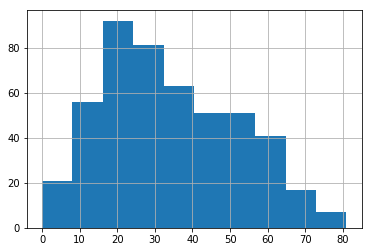

In [360]:
three_link_walk.walk_time.hist()

In [353]:
WalkSpeed

4.55672

In [250]:
car_transit_trips_sample.columns

Index(['person_id', 'num_trips', 'value_of_time', 'trip_counter',
       'ActivityTime', 'tripmode', 'orig_purpose', 'dest_purpose', 'orig_maz',
       'orig_taz', 'dest_maz', 'dest_taz', 'driver_passenger_flag',
       'joint_trip_flag', 'park&ride_flag', 'starttimeinterval', 'starttime',
       'hh_id', 'origin_node', 'destination_node', 'Diff_bet_starttime',
       'travel_time', 'person_type', 'earlyarr_penalty', 'latearr_penalty',
       'early_penalty_threshold', 'late_penalty_threshold', 'transit_utility',
       'car_utility', 'predicted_mode', 'actual_mode', 'cost_transit',
       'cost_car', 'ivtt_transit', 'walktime_transit', 'dist_car', 'ivtt_car',
       'toll_cost', 'asc_transit', 'asc_car', 'waittime_transit'],
      dtype='object')

In [300]:
ind_variables=[]
alt_varying_variables={
    'ivtt':dict([(1,'ivtt_transit'),
                (2,'ivtt_car')]),
    'travel_cost':dict([(1,'cost_transit'),
                      (2,'dist_car')]),
    'walk_time':dict([(1,'walktime_transit')]),
    'waittime':dict([(1,'waittime_transit')]),
}
availability_variables={1: 'asc_transit',
                       2: 'asc_car'}

In [297]:
custom_alt_id='mode_id'
obs_id_column='custom_id'
car_transit_trips_sample[obs_id_solumn]=np.arange(car_transit_trips_sample.shape[0],dtype=int)+1
choice_column='actual_mode'

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [308]:
long_transit_trip_sample=pl.convert_wide_to_long(car_transit_trips_sample, 
                                           ind_variables, 
                                           alt_varying_variables, 
                                           availability_variables, 
                                           obs_id_column, 
                                           choice_column,
                                           new_alt_id_name=custom_alt_id)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pylogit\choice_tools.py:453: UserWarning: Note, there are 42 variables in wide_data but the inputs ind_vars, alt_specific_vars, and subset_specific_vars only account for 10 variables.
  msg_2 + msg_3.format(num_vars_accounted_for))


In [327]:
long_transit_trip_sample.head()

,custom_id,mode_id,actual_mode,ivtt,travel_cost,walk_time,waittime,intercept
0,1,1,0,0.524700,2.500,3.185434,0.165,1.0
1,1,2,1,0.280500,8.500,0.000000,0.000,1.0
2,2,1,0,0.627000,2.500,1.820175,0.165,1.0
3,2,2,1,0.252087,7.639,0.000000,0.000,1.0
4,3,1,0,0.158400,2.500,3.185434,0.165,1.0


In [339]:
from collections import OrderedDict
basic_specification = OrderedDict()
basic_names = OrderedDict()

basic_specification["intercept"] = [1, 2]
basic_names["intercept"] = ['ASC Train',
                            'ASC Car']
basic_specification['ivtt']=[1,2]
basic_names['ivtt']=['ivtt transit','ivtt car']

basic_specification['travel_cost']=[1,2]
basic_names['travel_cost']=['cost_transit','cost_car']

basic_specification['walk_time']=[1]
basic_names['walk_time']=['walk_transit']
                            
basic_specification['waittime']=[1]
basic_names['waittime']=['wait_transit']


In [340]:
swissmetro_mnl = pl.create_choice_model(data=long_transit_trip_sample,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)

In [341]:
swissmetro_mnl.fit_mle(np.zeros(8))

Log-likelihood at zero: -13,208.6127
Initial Log-likelihood: -13,208.6127


C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:385: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.75 seconds.
Final log-likelihood: -4,398.5120


C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pylogit\base_multinomial_cm_v2.py:1228: RuntimeWarning: invalid value encountered in sqrt
  self._store_inferential_results(np.sqrt(np.diag(self.cov)),
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pylogit\base_multinomial_cm_v2.py:1259: RuntimeWarning: invalid value encountered in sqrt
  self._store_inferential_

In [342]:
swissmetro_mnl.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                 actual_mode   No. Observations:               19,056
Model:             Multinomial Logit Model   Df Residuals:                   19,048
Method:                                MLE   Df Model:                            8
Date:                     Tue, 24 Jul 2018   Pseudo R-squ.:                   0.667
Time:                             16:51:22   Pseudo R-bar-squ.:               0.666
AIC:                             8,813.024   Log-Likelihood:             -4,398.512
BIC:                             8,875.865   LL-Null:                   -13,208.613
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ASC Train       -0.3052   1.67e+06  -1.83e-07      1.000   -3.27e+06    3.27e+06
ASC Car          0.3052    2.1e+06   1.46e-07      1.000   -4.11e+06    4.11e+06
ivtt transit    -0.0067      0.010     -0.649      0.516      -0.027       0.013
ivtt car        -0.0782      0.064     -1.215      0.224      -0.204       0.048
cost_transit    -0.7631        nan        nan        nan         nan         nan
cost_car         0.0277      0.014      1.919      0.055      -0.001       0.056
walk_transit     0.0049      0.010      0.478      0.633      -0.015       0.025
wait_transit     0.1564      0.113      1.390      0.165      -0.064       0.377
================================================================================
"""

#### Mode Choice Extension

In [990]:
output_flag=0
# target_hh_id=2744264
min_length=15
max_length=20
single_model_runtime=60*3
drivingcost_per_mile=0.5
reward_mode=1
run_mode=0
darp_solutions=[]
cav_use_mode=0
num_time_interval=1
TL=[i*1440/num_time_interval for i in range(num_time_interval)]
TU=[(i+1)*1440/num_time_interval for i in range(num_time_interval)]
num_cav=1
share_ride_factor=1.5
time_window_flag=0
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])

route_info_modechoice1,bdarp_solutions_modechoice1=\
sod.get_route_info_allhh(target_trips,
                         output_flag,min_length,max_length,single_model_runtime,drivingcost_per_mile,
                         reward_mode,run_mode,cav_use_mode,num_time_interval,num_cav,share_ride_factor
                         ,time_window_flag,Vehicular_Skim_Dict,
                         Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,three_link_walk_dict,
                         superzone_map,TL,TU,
                         transit_zone_dict,transit_zone_candidates,TransitMazTazFlag,
                         TransitSkimTimeIntervalLength )

Estimate Route for the  0 th household  2018-07-16 14:43:53.475235
1 9 2018-07-16 14:43:54.041291
2 16 2018-07-16 14:43:54.998384
3 13 2018-07-16 14:43:55.791462
4 27 2018-07-16 14:43:57.391617
5 9 2018-07-16 14:43:57.799657
6 9 2018-07-16 14:43:58.282705
7 8 2018-07-16 14:43:58.720746
8 9 2018-07-16 14:43:59.247796
9 8 2018-07-16 14:43:59.916863
10 7 2018-07-16 14:44:00.260897
11 11 2018-07-16 14:44:01.543022
12 12 2018-07-16 14:44:02.016069
13 4 2018-07-16 14:44:02.378102
14 9 2018-07-16 14:44:02.987162
15 14 2018-07-16 14:44:04.443302
16 14 2018-07-16 14:44:05.557414
17 11 2018-07-16 14:44:06.215477
18 8 2018-07-16 14:44:06.523505
19 6 2018-07-16 14:44:06.845536
20 5 2018-07-16 14:44:07.182569
21 6 2018-07-16 14:44:07.747626
22 10 2018-07-16 14:44:08.374685
23 19 2018-07-16 14:44:13.456178
24 18 2018-07-16 14:44:14.801311
25 14 2018-07-16 14:44:16.259452
26 6 2018-07-16 14:44:16.676493
27 11 2018-07-16 14:44:17.472584
28 6 2018-07-16 14:44:17.945616
29 5 2018-07-16 14:44:18.283648
3

243 15 2018-07-16 14:47:00.165401
244 21 2018-07-16 14:47:02.334613
245 16 2018-07-16 14:47:03.135683
246 10 2018-07-16 14:47:03.635735
247 10 2018-07-16 14:47:04.232791
248 9 2018-07-16 14:47:04.645831
249 10 2018-07-16 14:47:05.148882
250 12 2018-07-16 14:47:06.111973
251 21 2018-07-16 14:47:07.139073
252 27 2018-07-16 14:47:10.925441
253 2 2018-07-16 14:47:11.083458
254 20 2018-07-16 14:47:14.684807
255 4 2018-07-16 14:47:14.891827
256 18 2018-07-16 14:47:17.672098
257 11 2018-07-16 14:47:18.058135
258 14 2018-07-16 14:47:18.590186
259 8 2018-07-16 14:47:18.964224
260 10 2018-07-16 14:47:19.430275
261 26 2018-07-16 14:47:23.351650
262 25 2018-07-16 14:47:35.754856
263 11 2018-07-16 14:47:36.261911
264 2 2018-07-16 14:47:36.417922
265 13 2018-07-16 14:47:36.995976
266 13 2018-07-16 14:47:37.827057
267 9 2018-07-16 14:47:38.235100
268 10 2018-07-16 14:47:38.748150
269 4 2018-07-16 14:47:38.953168
270 10 2018-07-16 14:47:39.296201
271 7 2018-07-16 14:47:39.621232
272 9 2018-07-16 14:47

483 9 2018-07-16 14:50:45.695401
484 8 2018-07-16 14:50:46.072417
485 4 2018-07-16 14:50:46.315431
486 17 2018-07-16 14:50:47.024474
487 10 2018-07-16 14:50:47.409500
488 14 2018-07-16 14:50:48.396556
489 7 2018-07-16 14:50:48.711572
490 11 2018-07-16 14:50:49.051597
491 9 2018-07-16 14:50:49.442615
492 14 2018-07-16 14:50:49.990649
493 9 2018-07-16 14:50:50.449676
494 7 2018-07-16 14:50:50.825699
495 7 2018-07-16 14:50:51.094712
496 7 2018-07-16 14:50:51.401729
497 5 2018-07-16 14:50:51.649750
498 8 2018-07-16 14:50:52.040774
499 9 2018-07-16 14:50:52.477799
500 11 2018-07-16 14:50:53.036831
Estimate Route for the  500 th household  2018-07-16 14:50:53.046832
501 7 2018-07-16 14:50:53.345844
502 16 2018-07-16 14:50:53.884877
503 18 2018-07-16 14:50:54.681925
504 20 2018-07-16 14:50:56.202012
505 10 2018-07-16 14:50:57.294076
506 12 2018-07-16 14:50:58.121129
507 5 2018-07-16 14:50:58.410142
508 11 2018-07-16 14:50:59.005183
509 8 2018-07-16 14:50:59.363199
510 2 2018-07-16 14:50:59.53

722 19 2018-07-16 14:53:10.922337
723 15 2018-07-16 14:53:12.685441
724 8 2018-07-16 14:53:12.939455
725 4 2018-07-16 14:53:13.131467
726 3 2018-07-16 14:53:13.293482
727 5 2018-07-16 14:53:13.587498
728 13 2018-07-16 14:53:16.126642
729 13 2018-07-16 14:53:17.010701
730 4 2018-07-16 14:53:17.192711
731 18 2018-07-16 14:53:18.842807
732 7 2018-07-16 14:53:19.155822
733 14 2018-07-16 14:53:19.841866
734 13 2018-07-16 14:53:21.662973
735 11 2018-07-16 14:53:23.063052
736 13 2018-07-16 14:53:23.974109
737 19 2018-07-16 14:53:24.766152
738 10 2018-07-16 14:53:25.351187
739 5 2018-07-16 14:53:25.633205
740 19 2018-07-16 14:53:27.063288
741 6 2018-07-16 14:53:27.352307
742 9 2018-07-16 14:53:27.773328
743 12 2018-07-16 14:53:28.418367
744 12 2018-07-16 14:53:28.979404
745 14 2018-07-16 14:53:29.645437
746 7 2018-07-16 14:53:29.899457
747 14 2018-07-16 14:53:30.700500
748 8 2018-07-16 14:53:31.086529
749 13 2018-07-16 14:53:31.849567
750 3 2018-07-16 14:53:32.012576
751 12 2018-07-16 14:53:32

963 7 2018-07-16 14:56:13.118631
964 5 2018-07-16 14:56:13.406651
965 19 2018-07-16 14:56:14.765728
966 10 2018-07-16 14:56:15.259758
967 15 2018-07-16 14:56:15.956803
968 8 2018-07-16 14:56:16.436828
969 8 2018-07-16 14:56:17.032862
970 3 2018-07-16 14:56:17.244874
971 15 2018-07-16 14:56:18.785969
972 8 2018-07-16 14:56:19.253996
973 5 2018-07-16 14:56:19.785029
974 11 2018-07-16 14:56:20.804085
975 6 2018-07-16 14:56:21.102106
976 4 2018-07-16 14:56:21.358116
977 21 2018-07-16 14:56:24.527304
978 10 2018-07-16 14:56:25.066334
979 5 2018-07-16 14:56:25.358353
980 11 2018-07-16 14:56:26.030393
981 19 2018-07-16 14:56:26.765436
982 19 2018-07-16 14:56:27.480477
983 20 2018-07-16 14:56:31.936740
984 8 2018-07-16 14:56:32.545773
985 7 2018-07-16 14:56:32.862794
986 2 2018-07-16 14:56:33.027802
987 10 2018-07-16 14:56:34.487889
988 6 2018-07-16 14:56:34.783906
989 16 2018-07-16 14:56:35.908973
990 8 2018-07-16 14:56:36.685931
991 5 2018-07-16 14:56:36.984966
992 15 2018-07-16 14:56:37.893

1198 14 2018-07-16 14:59:26.710001
1199 4 2018-07-16 14:59:27.171028
1200 3 2018-07-16 14:59:27.497051
Estimate Route for the  1200 th household  2018-07-16 14:59:27.527050
1201 12 2018-07-16 14:59:28.844127
1202 5 2018-07-16 14:59:29.268153
1203 20 2018-07-16 14:59:35.708532
1204 14 2018-07-16 14:59:37.117612
1205 13 2018-07-16 14:59:38.367687
1206 8 2018-07-16 14:59:38.790711
1207 3 2018-07-16 14:59:39.170730
1208 13 2018-07-16 14:59:40.476814
1209 4 2018-07-16 14:59:40.723827
1210 7 2018-07-16 14:59:41.369861
1211 16 2018-07-16 14:59:42.585477
1212 10 2018-07-16 14:59:43.464324
1213 1 2018-07-16 14:59:43.636346
1214 8 2018-07-16 14:59:43.977390
1215 7 2018-07-16 14:59:44.390946
1216 9 2018-07-16 14:59:44.974018
1217 7 2018-07-16 14:59:45.390074
1218 24 2018-07-16 14:59:49.706624
1219 8 2018-07-16 14:59:50.268702
1220 5 2018-07-16 14:59:50.578722
1221 13 2018-07-16 14:59:51.149752
1222 5 2018-07-16 14:59:51.490775
1223 4 2018-07-16 14:59:51.717784
1224 6 2018-07-16 14:59:52.050806
12

1430 8 2018-07-16 15:02:52.827043
1431 11 2018-07-16 15:02:53.318070
1432 12 2018-07-16 15:02:53.839102
1433 11 2018-07-16 15:02:54.218124
1434 3 2018-07-16 15:02:54.410140
1435 5 2018-07-16 15:02:54.668155
1436 17 2018-07-16 15:02:55.448196
1437 14 2018-07-16 15:02:55.974227
1438 24 2018-07-16 15:02:58.155360
1439 12 2018-07-16 15:02:58.917402
1440 11 2018-07-16 15:02:59.428436
1441 6 2018-07-16 15:02:59.713452
1442 10 2018-07-16 15:03:01.160532
1443 4 2018-07-16 15:03:01.442556
1444 14 2018-07-16 15:03:01.987580
1445 16 2018-07-16 15:03:02.593615
1446 14 2018-07-16 15:03:03.352662
1447 16 2018-07-16 15:03:05.449790
1448 8 2018-07-16 15:03:05.740801
1449 19 2018-07-16 15:03:07.730917
1450 14 2018-07-16 15:03:09.450019
1451 5 2018-07-16 15:03:09.754038
1452 5 2018-07-16 15:03:10.005052
1453 9 2018-07-16 15:03:10.524081
1454 8 2018-07-16 15:03:10.807099
1455 14 2018-07-16 15:03:11.531147
1456 10 2018-07-16 15:03:12.032172
1457 11 2018-07-16 15:03:12.638212
1458 10 2018-07-16 15:03:13.94

1664 23 2018-07-16 15:07:00.836621
1665 12 2018-07-16 15:07:01.602663
1666 6 2018-07-16 15:07:01.837677
1667 12 2018-07-16 15:07:02.373714
1668 10 2018-07-16 15:07:02.695730
1669 3 2018-07-16 15:07:02.885739
1670 11 2018-07-16 15:07:03.542778
1671 8 2018-07-16 15:07:04.027807
1672 14 2018-07-16 15:07:05.068868
1673 3 2018-07-16 15:07:05.308882
1674 14 2018-07-16 15:07:06.816972
1675 4 2018-07-16 15:07:07.187996
1676 6 2018-07-16 15:07:07.664023
1677 6 2018-07-16 15:07:08.115047
1678 6 2018-07-16 15:07:08.757086
1679 10 2018-07-16 15:07:09.880149
1680 10 2018-07-16 15:07:10.243171
1681 15 2018-07-16 15:07:11.518247
1682 11 2018-07-16 15:07:12.346300
1683 6 2018-07-16 15:07:12.718323
1684 7 2018-07-16 15:07:13.043341
1685 7 2018-07-16 15:07:13.330353
1686 16 2018-07-16 15:07:13.879387
1687 7 2018-07-16 15:07:14.291411
1688 7 2018-07-16 15:07:14.656433
1689 14 2018-07-16 15:07:15.721498
1690 8 2018-07-16 15:07:16.108516
1691 10 2018-07-16 15:07:16.603545
1692 4 2018-07-16 15:07:16.831558


1898 9 2018-07-16 15:09:38.672895
1899 8 2018-07-16 15:09:39.087920
1900 22 2018-07-16 15:09:40.394003
Estimate Route for the  1900 th household  2018-07-16 15:09:40.411997
1901 14 2018-07-16 15:09:41.344058
1902 18 2018-07-16 15:09:42.215109
1903 3 2018-07-16 15:09:42.396119
1904 9 2018-07-16 15:09:42.696132
1905 5 2018-07-16 15:09:42.986154
1906 9 2018-07-16 15:09:43.290172
1907 12 2018-07-16 15:09:44.655252
1908 12 2018-07-16 15:09:45.373289
1909 8 2018-07-16 15:09:45.746311
1910 8 2018-07-16 15:09:46.134336
1911 12 2018-07-16 15:09:46.874377
1912 16 2018-07-16 15:09:48.138457
1913 11 2018-07-16 15:09:49.282519
1914 8 2018-07-16 15:09:49.781549
1915 12 2018-07-16 15:09:50.365584
1916 12 2018-07-16 15:09:51.411646
1917 10 2018-07-16 15:09:52.361702
1918 9 2018-07-16 15:09:53.267755
1919 6 2018-07-16 15:09:54.172808
1920 5 2018-07-16 15:09:54.679837
1921 11 2018-07-16 15:09:56.046922
1922 2 2018-07-16 15:09:56.254930
1923 2 2018-07-16 15:09:56.500947
1924 20 2018-07-16 15:09:58.106039

2130 12 2018-07-16 15:12:54.551587
2131 3 2018-07-16 15:12:54.727603
2132 10 2018-07-16 15:12:55.352641
2133 16 2018-07-16 15:12:57.072740
2134 9 2018-07-16 15:12:57.527763
2135 13 2018-07-16 15:12:59.301866
2136 9 2018-07-16 15:12:59.793895
2137 22 2018-07-16 15:13:00.646946
2138 14 2018-07-16 15:13:02.389049
2139 10 2018-07-16 15:13:02.894077
2140 11 2018-07-16 15:13:03.671123
2141 4 2018-07-16 15:13:03.949145
2142 15 2018-07-16 15:13:05.121208
2143 7 2018-07-16 15:13:05.443230
2144 10 2018-07-16 15:13:06.040265
2145 6 2018-07-16 15:13:06.328279
2146 4 2018-07-16 15:13:06.552292
2147 9 2018-07-16 15:13:07.054323
2148 11 2018-07-16 15:13:07.760367
2149 19 2018-07-16 15:13:09.706483
2150 5 2018-07-16 15:13:10.038497
2151 19 2018-07-16 15:13:11.537587
2152 10 2018-07-16 15:13:12.172622
2153 8 2018-07-16 15:13:13.186689
2154 4 2018-07-16 15:13:13.723716
2155 7 2018-07-16 15:13:14.202741
2156 19 2018-07-16 15:13:17.240923
2157 11 2018-07-16 15:13:17.933961
2158 27 2018-07-16 15:13:24.5183

2364 8 2018-07-16 15:17:39.345543
2365 4 2018-07-16 15:17:39.710561
2366 11 2018-07-16 15:17:40.667621
2367 11 2018-07-16 15:17:41.719682
2368 15 2018-07-16 15:17:43.367777
2369 6 2018-07-16 15:17:43.696795
2370 8 2018-07-16 15:17:43.986812
2371 10 2018-07-16 15:17:44.500844
2372 2 2018-07-16 15:17:44.672852
2373 7 2018-07-16 15:17:44.995872
2374 18 2018-07-16 15:17:45.851925
2375 5 2018-07-16 15:17:46.091940
2376 10 2018-07-16 15:17:46.588966
2377 12 2018-07-16 15:17:47.118996
2378 12 2018-07-16 15:17:47.585026
2379 10 2018-07-16 15:17:47.972049
2380 7 2018-07-16 15:17:48.327068
2381 5 2018-07-16 15:17:48.647091
2382 3 2018-07-16 15:17:48.824101
2383 8 2018-07-16 15:17:49.193118
2384 9 2018-07-16 15:17:49.660148
2385 2 2018-07-16 15:17:49.841157
2386 7 2018-07-16 15:17:50.120178
2387 6 2018-07-16 15:17:50.390194
2388 5 2018-07-16 15:17:50.648204
2389 6 2018-07-16 15:17:50.920220
2390 3 2018-07-16 15:17:51.183238
2391 2 2018-07-16 15:17:51.372247
2392 8 2018-07-16 15:17:51.658266
2393 

2599 6 2018-07-16 15:20:30.317439
2600 3 2018-07-16 15:20:30.553451
Estimate Route for the  2600 th household  2018-07-16 15:20:30.581454
2601 7 2018-07-16 15:20:30.948474
2602 8 2018-07-16 15:20:31.317495
2603 15 2018-07-16 15:20:32.288557
2604 8 2018-07-16 15:20:32.716579
2605 9 2018-07-16 15:20:33.184607
2606 11 2018-07-16 15:20:33.702635
2607 5 2018-07-16 15:20:33.959652
2608 10 2018-07-16 15:20:34.529687
2609 2 2018-07-16 15:20:34.709701
2610 5 2018-07-16 15:20:34.898711
2611 9 2018-07-16 15:20:35.351739
2612 11 2018-07-16 15:20:36.151786
2613 7 2018-07-16 15:20:36.407801
2614 10 2018-07-16 15:20:36.898829
2615 3 2018-07-16 15:20:37.088840
2616 6 2018-07-16 15:20:37.418857
2617 8 2018-07-16 15:20:37.834879
2618 8 2018-07-16 15:20:38.210901
2619 9 2018-07-16 15:20:38.567928
2620 30 2018-07-16 15:20:40.831055
2621 5 2018-07-16 15:20:41.112071
2622 7 2018-07-16 15:20:41.403091
2623 10 2018-07-16 15:20:41.949120
2624 7 2018-07-16 15:20:42.330151
2625 2 2018-07-16 15:20:42.571157
2626 

2832 8 2018-07-16 15:23:30.358021
2833 2 2018-07-16 15:23:30.551033
2834 7 2018-07-16 15:23:30.914053
2835 5 2018-07-16 15:23:31.471085
2836 2 2018-07-16 15:23:31.654096
2837 4 2018-07-16 15:23:31.889110
2838 3 2018-07-16 15:23:32.154126
2839 5 2018-07-16 15:23:32.419141
2840 5 2018-07-16 15:23:32.723158
2841 12 2018-07-16 15:23:34.800281
2842 10 2018-07-16 15:23:35.447322
2843 19 2018-07-16 15:23:36.632390
2844 7 2018-07-16 15:23:37.244425
2845 5 2018-07-16 15:23:37.594447
2846 8 2018-07-16 15:23:37.942466
2847 5 2018-07-16 15:23:38.255485
2848 10 2018-07-16 15:23:38.655507
2849 4 2018-07-16 15:23:38.887522
2850 11 2018-07-16 15:23:39.486558
2851 6 2018-07-16 15:23:39.788573
2852 8 2018-07-16 15:23:40.267604
2853 9 2018-07-16 15:23:40.886638
2854 2 2018-07-16 15:23:41.092651
2855 11 2018-07-16 15:23:41.542677
2856 10 2018-07-16 15:23:41.938701
2857 14 2018-07-16 15:23:43.808811
2858 16 2018-07-16 15:23:44.561856
2859 4 2018-07-16 15:23:44.837872
2860 14 2018-07-16 15:23:45.569914
2861

3067 15 2018-07-16 15:25:50.649266
3068 7 2018-07-16 15:25:50.923287
3069 7 2018-07-16 15:25:51.695328
3070 15 2018-07-16 15:25:52.868396
3071 14 2018-07-16 15:25:53.352429
3072 13 2018-07-16 15:25:54.181473
3073 7 2018-07-16 15:25:54.434489
3074 6 2018-07-16 15:25:54.777510
3075 6 2018-07-16 15:25:55.112529
3076 11 2018-07-16 15:25:55.734564
3077 2 2018-07-16 15:25:55.920574
3078 4 2018-07-16 15:25:56.192591
3079 12 2018-07-16 15:25:57.115649
3080 4 2018-07-16 15:25:57.381667
3081 7 2018-07-16 15:25:57.820687
3082 5 2018-07-16 15:25:58.137707
3083 5 2018-07-16 15:25:58.437722
3084 12 2018-07-16 15:25:59.011757
3085 6 2018-07-16 15:25:59.318777
3086 17 2018-07-16 15:26:00.607850
3087 10 2018-07-16 15:26:00.950873
3088 18 2018-07-16 15:26:01.769919
3089 11 2018-07-16 15:26:02.231947
3090 2 2018-07-16 15:26:02.442959
3091 3 2018-07-16 15:26:02.677975
3092 9 2018-07-16 15:26:03.197002
3093 10 2018-07-16 15:26:03.683034
3094 14 2018-07-16 15:26:04.369071
3095 2 2018-07-16 15:26:04.563082
3

3301 4 2018-07-16 15:28:38.897159
3302 7 2018-07-16 15:28:39.157170
3303 7 2018-07-16 15:28:39.497194
3304 3 2018-07-16 15:28:39.686205
3305 6 2018-07-16 15:28:39.948222
3306 7 2018-07-16 15:28:40.314242
3307 5 2018-07-16 15:28:40.536257
3308 8 2018-07-16 15:28:40.958275
3309 6 2018-07-16 15:28:41.248292
3310 4 2018-07-16 15:28:41.458310
3311 10 2018-07-16 15:28:41.979336
3312 5 2018-07-16 15:28:42.245350
3313 12 2018-07-16 15:28:42.679381
3314 9 2018-07-16 15:28:43.121401
3315 6 2018-07-16 15:28:43.445422
3316 1 2018-07-16 15:28:43.574430
3317 7 2018-07-16 15:28:43.789443
3318 4 2018-07-16 15:28:44.019455
3319 11 2018-07-16 15:28:44.605491
3320 13 2018-07-16 15:28:45.131520
3321 12 2018-07-16 15:28:45.858568
3322 5 2018-07-16 15:28:46.116578
3323 6 2018-07-16 15:28:46.410595
3324 4 2018-07-16 15:28:46.675610
3325 10 2018-07-16 15:28:47.225643
3326 3 2018-07-16 15:28:47.440657
3327 4 2018-07-16 15:28:47.633671
3328 6 2018-07-16 15:28:48.022690
3329 1 2018-07-16 15:28:48.187702
3330 13 

3536 16 2018-07-16 15:31:17.729490
3537 3 2018-07-16 15:31:17.927501
3538 16 2018-07-16 15:31:18.760551
3539 11 2018-07-16 15:31:19.393588
3540 6 2018-07-16 15:31:19.692604
3541 4 2018-07-16 15:31:19.904622
3542 14 2018-07-16 15:31:22.068748
3543 5 2018-07-16 15:31:22.390763
3544 6 2018-07-16 15:31:22.685781
3545 13 2018-07-16 15:31:24.238872
3546 11 2018-07-16 15:31:25.747960
3547 4 2018-07-16 15:31:25.995980
3548 6 2018-07-16 15:31:26.287992
3549 8 2018-07-16 15:31:26.675020
3550 7 2018-07-16 15:31:26.920029
3551 8 2018-07-16 15:31:27.338055
3552 5 2018-07-16 15:31:27.632076
3553 5 2018-07-16 15:31:27.943092
3554 5 2018-07-16 15:31:28.211110
3555 9 2018-07-16 15:31:28.567131
3556 4 2018-07-16 15:31:28.796145
3557 15 2018-07-16 15:31:29.850204
3558 3 2018-07-16 15:31:30.081215
3559 9 2018-07-16 15:31:30.777257
3560 7 2018-07-16 15:31:31.294289
3561 10 2018-07-16 15:31:32.047330
3562 13 2018-07-16 15:31:32.777378
3563 11 2018-07-16 15:31:33.182404
3564 8 2018-07-16 15:31:33.614422
3565

3771 8 2018-07-16 15:34:11.456997
3772 5 2018-07-16 15:34:11.711013
3773 13 2018-07-16 15:34:12.376051
3774 9 2018-07-16 15:34:12.885080
3775 2 2018-07-16 15:34:13.069097
3776 20 2018-07-16 15:34:14.415172
3777 9 2018-07-16 15:34:14.900201
3778 11 2018-07-16 15:34:15.344229
3779 8 2018-07-16 15:34:15.789252
3780 8 2018-07-16 15:34:16.149275
3781 10 2018-07-16 15:34:16.678306
3782 10 2018-07-16 15:34:17.365351
3783 9 2018-07-16 15:34:18.749426
3784 10 2018-07-16 15:34:19.139448
3785 6 2018-07-16 15:34:19.476470
3786 7 2018-07-16 15:34:19.912500
3787 5 2018-07-16 15:34:20.216513
3788 5 2018-07-16 15:34:20.499532
3789 3 2018-07-16 15:34:20.717541
3790 7 2018-07-16 15:34:21.003562
3791 3 2018-07-16 15:34:21.223575
3792 7 2018-07-16 15:34:21.592599
3793 5 2018-07-16 15:34:21.909611
3794 6 2018-07-16 15:34:22.217633
3795 5 2018-07-16 15:34:22.513652
3796 2 2018-07-16 15:34:22.718659
3797 14 2018-07-16 15:34:23.284693
3798 8 2018-07-16 15:34:23.847731
3799 7 2018-07-16 15:34:24.206752
3800 8 

4004 3 2018-07-16 15:36:43.418929
4005 4 2018-07-16 15:36:43.668944
4006 14 2018-07-16 15:36:45.320040
4007 2 2018-07-16 15:36:45.516053
4008 8 2018-07-16 15:36:45.900076
4009 5 2018-07-16 15:36:46.191095
4010 2 2018-07-16 15:36:46.385103
4011 12 2018-07-16 15:36:47.151150
4012 10 2018-07-16 15:36:47.544171
4013 10 2018-07-16 15:36:48.845250
4014 5 2018-07-16 15:36:49.171267
4015 5 2018-07-16 15:36:49.447284
4016 6 2018-07-16 15:36:49.792307
4017 12 2018-07-16 15:36:50.345338
4018 8 2018-07-16 15:36:50.754361
4019 9 2018-07-16 15:36:51.435401
4020 3 2018-07-16 15:36:51.670414
4021 4 2018-07-16 15:36:52.308451
4022 18 2018-07-16 15:36:53.522527
4023 14 2018-07-16 15:36:54.611587
4024 4 2018-07-16 15:36:54.781597
4025 4 2018-07-16 15:36:55.028617
4026 17 2018-07-16 15:36:56.121676
4027 6 2018-07-16 15:36:56.401692
4028 7 2018-07-16 15:36:56.746719
4029 12 2018-07-16 15:36:57.195740
4030 9 2018-07-16 15:36:57.661767
4031 25 2018-07-16 15:37:00.198915
4032 20 2018-07-16 15:37:01.688003
403

4240 8 2018-07-16 15:39:08.930595
4241 16 2018-07-16 15:39:09.663639
4242 3 2018-07-16 15:39:09.924658
4243 11 2018-07-16 15:39:10.571692
4244 9 2018-07-16 15:39:11.115723
4245 4 2018-07-16 15:39:11.376738
4246 7 2018-07-16 15:39:11.801765
4247 10 2018-07-16 15:39:12.363796
4248 8 2018-07-16 15:39:12.723817
4249 6 2018-07-16 15:39:13.061836
4250 12 2018-07-16 15:39:14.110899
4251 20 2018-07-16 15:39:15.068958
4252 6 2018-07-16 15:39:15.818009
4253 7 2018-07-16 15:39:16.488039
4254 14 2018-07-16 15:39:17.162079
4255 11 2018-07-16 15:39:18.024135
4256 13 2018-07-16 15:39:19.118193
4257 4 2018-07-16 15:39:19.366207
4258 6 2018-07-16 15:39:19.686227
4259 6 2018-07-16 15:39:20.069250
4260 2 2018-07-16 15:39:20.321263
4261 9 2018-07-16 15:39:21.392329
4262 10 2018-07-16 15:39:22.142372
4263 13 2018-07-16 15:39:22.940420
4264 15 2018-07-16 15:39:25.934594
4265 6 2018-07-16 15:39:26.291616
4266 12 2018-07-16 15:39:26.722640
4267 3 2018-07-16 15:39:26.896656
4268 8 2018-07-16 15:39:27.303678
42

4475 2 2018-07-16 15:41:38.126363
4476 7 2018-07-16 15:41:38.483388
4477 9 2018-07-16 15:41:38.991415
4478 3 2018-07-16 15:41:39.220431
4479 12 2018-07-16 15:41:43.077655
4480 10 2018-07-16 15:41:43.767695
4481 4 2018-07-16 15:41:44.035715
4482 11 2018-07-16 15:41:44.866762
4483 4 2018-07-16 15:41:45.055773
4484 3 2018-07-16 15:41:45.300787
4485 10 2018-07-16 15:41:46.656865
4486 5 2018-07-16 15:41:46.967884
4487 8 2018-07-16 15:41:47.342907
4488 4 2018-07-16 15:41:47.621922
4489 6 2018-07-16 15:41:48.041949
4490 11 2018-07-16 15:41:49.973061
4491 10 2018-07-16 15:41:50.424089
4492 4 2018-07-16 15:41:50.680105
4493 8 2018-07-16 15:41:51.142130
4494 9 2018-07-16 15:41:51.512152
4495 8 2018-07-16 15:41:51.980178
4496 11 2018-07-16 15:41:52.656219
4497 2 2018-07-16 15:41:52.866230
4498 4 2018-07-16 15:41:53.156248
4499 11 2018-07-16 15:41:54.172309
4500 8 2018-07-16 15:41:54.791347
Estimate Route for the  4500 th household  2018-07-16 15:41:54.847347
4501 11 2018-07-16 15:41:55.736400
450

4708 11 2018-07-16 15:44:35.777806
4709 11 2018-07-16 15:44:36.483846
4710 7 2018-07-16 15:44:36.873870
4711 7 2018-07-16 15:44:37.164889
4712 8 2018-07-16 15:44:37.630915
4713 4 2018-07-16 15:44:37.893929
4714 2 2018-07-16 15:44:38.110943
4715 8 2018-07-16 15:44:38.576969
4716 9 2018-07-16 15:44:38.963993
4717 8 2018-07-16 15:44:39.389024
4718 4 2018-07-16 15:44:39.701037
4719 13 2018-07-16 15:44:41.275128
4720 4 2018-07-16 15:44:41.529143
4721 11 2018-07-16 15:44:42.052175
4722 7 2018-07-16 15:44:42.382193
4723 15 2018-07-16 15:44:43.274246
4724 6 2018-07-16 15:44:43.601265
4725 10 2018-07-16 15:44:44.078295
4726 10 2018-07-16 15:44:44.566323
4727 2 2018-07-16 15:44:44.724332
4728 3 2018-07-16 15:44:45.021349
4729 4 2018-07-16 15:44:45.285365
4730 10 2018-07-16 15:44:45.853398
4731 5 2018-07-16 15:44:46.211420
4732 13 2018-07-16 15:44:46.757451
4733 3 2018-07-16 15:44:46.989464
4734 10 2018-07-16 15:44:47.652506
4735 18 2018-07-16 15:44:48.605560
4736 12 2018-07-16 15:44:49.469611
47

4943 9 2018-07-16 15:46:45.273418
4944 1 2018-07-16 15:46:45.434425
4945 5 2018-07-16 15:46:45.726442
4946 5 2018-07-16 15:46:46.012462
4947 5 2018-07-16 15:46:46.352482
4948 13 2018-07-16 15:46:48.097584
4949 4 2018-07-16 15:46:48.442604
4950 4 2018-07-16 15:46:48.974633
4951 21 2018-07-16 15:46:51.224767
4952 14 2018-07-16 15:46:54.251944
4953 7 2018-07-16 15:46:54.668972
4954 4 2018-07-16 15:46:54.935984
4955 12 2018-07-16 15:46:55.720033
4956 6 2018-07-16 15:46:56.042051
4957 13 2018-07-16 15:46:56.595082
4958 9 2018-07-16 15:46:57.006106
4959 12 2018-07-16 15:46:57.830157
4960 6 2018-07-16 15:46:58.169177
4961 6 2018-07-16 15:46:58.539195
4962 13 2018-07-16 15:46:59.044232
4963 1 2018-07-16 15:46:59.196236
4964 2 2018-07-16 15:46:59.395246
4965 3 2018-07-16 15:46:59.615259
4966 2 2018-07-16 15:46:59.807275
4967 4 2018-07-16 15:47:00.028288
4968 4 2018-07-16 15:47:00.313300
4969 14 2018-07-16 15:47:00.858332
4970 2 2018-07-16 15:47:01.061345
4971 13 2018-07-16 15:47:01.904399
4972 

5178 7 2018-07-16 15:49:02.783499
5179 5 2018-07-16 15:49:03.117519
5180 5 2018-07-16 15:49:03.369537
5181 5 2018-07-16 15:49:03.662553
5182 7 2018-07-16 15:49:04.059574
5183 7 2018-07-16 15:49:04.377594
5184 16 2018-07-16 15:49:05.467657
5185 10 2018-07-16 15:49:05.870686
5186 6 2018-07-16 15:49:06.160700
5187 21 2018-07-16 15:49:07.609782
5188 3 2018-07-16 15:49:07.809799
5189 5 2018-07-16 15:49:08.127813
5190 10 2018-07-16 15:49:08.664847
5191 6 2018-07-16 15:49:08.978868
5192 4 2018-07-16 15:49:09.228884
5193 7 2018-07-16 15:49:09.622900
5194 5 2018-07-16 15:49:10.057926
5195 4 2018-07-16 15:49:10.382947
5196 5 2018-07-16 15:49:10.784968
5197 7 2018-07-16 15:49:11.204994
5198 4 2018-07-16 15:49:11.435009
5199 10 2018-07-16 15:49:11.884034
5200 8 2018-07-16 15:49:12.301060
Estimate Route for the  5200 th household  2018-07-16 15:49:12.373063
5201 11 2018-07-16 15:49:13.060104
5202 11 2018-07-16 15:49:14.351179
5203 2 2018-07-16 15:49:14.635199
5204 10 2018-07-16 15:49:15.411245
5205

5411 11 2018-07-16 15:51:05.050684
5412 7 2018-07-16 15:51:05.356704
5413 1 2018-07-16 15:51:05.530712
5414 12 2018-07-16 15:51:05.960745
5415 12 2018-07-16 15:51:07.151810
5416 7 2018-07-16 15:51:07.462828
5417 6 2018-07-16 15:51:07.860851
5418 1 2018-07-16 15:51:08.021860
5419 4 2018-07-16 15:51:08.262874
5420 16 2018-07-16 15:51:09.024919
5421 12 2018-07-16 15:51:09.663962
5422 7 2018-07-16 15:51:09.967975
5423 4 2018-07-16 15:51:10.235989
5424 17 2018-07-16 15:51:12.050098
5425 12 2018-07-16 15:51:13.583187
5426 14 2018-07-16 15:51:14.757256
5427 12 2018-07-16 15:51:15.272286
5428 6 2018-07-16 15:51:15.631307
5429 20 2018-07-16 15:51:16.560362
5430 10 2018-07-16 15:51:16.900384
5431 4 2018-07-16 15:51:17.200399
5432 6 2018-07-16 15:51:17.559424
5433 5 2018-07-16 15:51:17.905444
5434 10 2018-07-16 15:51:18.355469
5435 13 2018-07-16 15:51:19.484533
5436 9 2018-07-16 15:51:21.136632
5437 11 2018-07-16 15:51:21.555656
5438 1 2018-07-16 15:51:21.695662
5439 14 2018-07-16 15:51:22.694722

5646 11 2018-07-16 15:53:23.671834
5647 8 2018-07-16 15:53:24.195864
5648 9 2018-07-16 15:53:24.654890
5649 4 2018-07-16 15:53:24.922912
5650 11 2018-07-16 15:53:26.268990
5651 2 2018-07-16 15:53:26.488998
5652 16 2018-07-16 15:53:27.558062
5653 7 2018-07-16 15:53:27.918084
5654 1 2018-07-16 15:53:28.135095
5655 4 2018-07-16 15:53:28.422112
5656 12 2018-07-16 15:53:29.197158
5657 1 2018-07-16 15:53:29.416171
5658 5 2018-07-16 15:53:29.731188
5659 10 2018-07-16 15:53:30.269220
5660 15 2018-07-16 15:53:31.391288
5661 4 2018-07-16 15:53:31.761311
5662 2 2018-07-16 15:53:32.019329
5663 10 2018-07-16 15:53:32.607359
5664 7 2018-07-16 15:53:32.906375
5665 3 2018-07-16 15:53:33.118387
5666 3 2018-07-16 15:53:33.333406
5667 14 2018-07-16 15:53:34.129447
5668 7 2018-07-16 15:53:34.444471
5669 11 2018-07-16 15:53:34.861490
5670 7 2018-07-16 15:53:35.170511
5671 8 2018-07-16 15:53:35.596533
5672 12 2018-07-16 15:53:36.386582
5673 7 2018-07-16 15:53:37.090622
5674 6 2018-07-16 15:53:37.449641
5675

5881 4 2018-07-16 15:55:31.429346
5882 11 2018-07-16 15:55:32.124382
5883 4 2018-07-16 15:55:32.432402
5884 5 2018-07-16 15:55:32.816423
5885 5 2018-07-16 15:55:33.157445
5886 5 2018-07-16 15:55:33.480462
5887 6 2018-07-16 15:55:33.827487
5888 5 2018-07-16 15:55:34.147501
5889 3 2018-07-16 15:55:34.359515
5890 4 2018-07-16 15:55:34.677538
5891 9 2018-07-16 15:55:35.263567
5892 13 2018-07-16 15:55:38.125736
5893 5 2018-07-16 15:55:38.408755
5894 3 2018-07-16 15:55:38.653767
5895 10 2018-07-16 15:55:39.192803
5896 4 2018-07-16 15:55:39.419816
5897 11 2018-07-16 15:55:39.801838
5898 16 2018-07-16 15:55:40.441872
5899 10 2018-07-16 15:55:41.022905
5900 6 2018-07-16 15:55:41.351924
Estimate Route for the  5900 th household  2018-07-16 15:55:41.416929
5901 4 2018-07-16 15:55:41.601941
5902 8 2018-07-16 15:55:41.920961
5903 6 2018-07-16 15:55:42.255979
5904 4 2018-07-16 15:55:42.524994
5905 7 2018-07-16 15:55:42.937019
5906 4 2018-07-16 15:55:43.195033
5907 8 2018-07-16 15:55:43.504052
5908 7

6115 15 2018-07-16 15:57:33.964543
6116 7 2018-07-16 15:57:34.434573
6117 20 2018-07-16 15:57:42.168028
6118 8 2018-07-16 15:57:42.589050
6119 6 2018-07-16 15:57:42.947071
6120 9 2018-07-16 15:57:43.343095
6121 2 2018-07-16 15:57:43.612110
6122 5 2018-07-16 15:57:43.908128
6123 7 2018-07-16 15:57:44.347155
6124 5 2018-07-16 15:57:44.688174
6125 9 2018-07-16 15:57:45.042200
6126 10 2018-07-16 15:57:45.627235
6127 14 2018-07-16 15:57:46.635288
6128 4 2018-07-16 15:57:46.879305
6129 6 2018-07-16 15:57:47.223323
6130 14 2018-07-16 15:57:48.027375
6131 7 2018-07-16 15:57:48.459396
6132 9 2018-07-16 15:57:48.972426
6133 23 2018-07-16 15:57:53.181674
6134 10 2018-07-16 15:57:53.708705
6135 14 2018-07-16 15:57:56.660877
6136 6 2018-07-16 15:57:57.025902
6137 11 2018-07-16 15:57:57.726940
6138 12 2018-07-16 15:57:58.438986
6139 10 2018-07-16 15:57:58.894009
6140 15 2018-07-16 15:58:00.494102
6141 7 2018-07-16 15:58:00.936133
6142 19 2018-07-16 15:58:02.021193
6143 10 2018-07-16 15:58:02.423217


6350 18 2018-07-16 16:00:07.947596
6351 4 2018-07-16 16:00:08.227612
6352 8 2018-07-16 16:00:08.648636
6353 7 2018-07-16 16:00:09.045658
6354 12 2018-07-16 16:00:09.557690
6355 7 2018-07-16 16:00:09.928711
6356 4 2018-07-16 16:00:10.231728
6357 11 2018-07-16 16:00:10.639752
6358 9 2018-07-16 16:00:10.982774
6359 3 2018-07-16 16:00:11.183790
6360 2 2018-07-16 16:00:11.417803
6361 4 2018-07-16 16:00:11.625812
6362 2 2018-07-16 16:00:11.844823
6363 11 2018-07-16 16:00:12.288849
6364 2 2018-07-16 16:00:12.505862
6365 4 2018-07-16 16:00:12.831882
6366 8 2018-07-16 16:00:13.271913
6367 7 2018-07-16 16:00:13.694935
6368 14 2018-07-16 16:00:14.527982
6369 7 2018-07-16 16:00:14.816999
6370 9 2018-07-16 16:00:15.203021
6371 10 2018-07-16 16:00:15.574044
6372 2 2018-07-16 16:00:15.811059
6373 6 2018-07-16 16:00:16.182078
6374 9 2018-07-16 16:00:17.395148
6375 17 2018-07-16 16:00:18.182194
6376 17 2018-07-16 16:00:18.982244
6377 13 2018-07-16 16:00:20.455329
6378 12 2018-07-16 16:00:22.250434
6379

6585 15 2018-07-16 16:02:44.626273
6586 2 2018-07-16 16:02:44.837286
6587 8 2018-07-16 16:02:45.169311
6588 7 2018-07-16 16:02:45.543333
6589 9 2018-07-16 16:02:46.051358
6590 11 2018-07-16 16:02:46.577389
6591 2 2018-07-16 16:02:46.816405
6592 4 2018-07-16 16:02:47.063418
6593 2 2018-07-16 16:02:47.282432
6594 7 2018-07-16 16:02:47.748461
6595 6 2018-07-16 16:02:48.106479
6596 8 2018-07-16 16:02:48.422498
6597 3 2018-07-16 16:02:48.648514
6598 11 2018-07-16 16:02:49.727574
6599 6 2018-07-16 16:02:50.105597
6600 11 2018-07-16 16:02:50.743635
Estimate Route for the  6600 th household  2018-07-16 16:02:50.811642
6601 6 2018-07-16 16:02:51.047652
6602 6 2018-07-16 16:02:51.409675
6603 7 2018-07-16 16:02:51.786695
6604 7 2018-07-16 16:02:52.178718
6605 9 2018-07-16 16:02:52.606748
6606 8 2018-07-16 16:02:53.527797
6607 2 2018-07-16 16:02:53.755811
6608 3 2018-07-16 16:02:54.003826
6609 1 2018-07-16 16:02:54.167840
6610 5 2018-07-16 16:02:54.454851
6611 12 2018-07-16 16:02:55.087889
6612 14

6818 2 2018-07-16 16:05:15.597147
6819 9 2018-07-16 16:05:16.013172
6820 4 2018-07-16 16:05:16.308190
6821 8 2018-07-16 16:05:16.653212
6822 13 2018-07-16 16:05:17.689276
6823 7 2018-07-16 16:05:18.062293
6824 2 2018-07-16 16:05:18.302313
6825 2 2018-07-16 16:05:18.517320
6826 4 2018-07-16 16:05:18.764334
6827 6 2018-07-16 16:05:19.131358
6828 10 2018-07-16 16:05:19.721392
6829 2 2018-07-16 16:05:19.952406
6830 4 2018-07-16 16:05:20.205419
6831 19 2018-07-16 16:05:23.228597
6832 6 2018-07-16 16:05:23.562621
6833 7 2018-07-16 16:05:24.018643
6834 10 2018-07-16 16:05:24.881693
6835 10 2018-07-16 16:05:25.411725
6836 16 2018-07-16 16:05:26.432785
6837 3 2018-07-16 16:05:26.681802
6838 3 2018-07-16 16:05:26.951817
6839 12 2018-07-16 16:05:27.903871
6840 2 2018-07-16 16:05:28.136891
6841 5 2018-07-16 16:05:28.500912
6842 7 2018-07-16 16:05:28.835927
6843 6 2018-07-16 16:05:29.224948
6844 7 2018-07-16 16:05:29.612974
6845 5 2018-07-16 16:05:29.963993
6846 9 2018-07-16 16:05:30.437023
6847 5 

7053 4 2018-07-16 16:07:39.354598
7054 7 2018-07-16 16:07:39.796624
7055 7 2018-07-16 16:07:40.248651
7056 4 2018-07-16 16:07:40.508665
7057 6 2018-07-16 16:07:40.800683
7058 14 2018-07-16 16:07:42.563788
7059 7 2018-07-16 16:07:42.866804
7060 9 2018-07-16 16:07:43.325833
7061 3 2018-07-16 16:07:43.569845
7062 4 2018-07-16 16:07:43.850861
7063 3 2018-07-16 16:07:44.083875
7064 8 2018-07-16 16:07:44.443896
7065 10 2018-07-16 16:07:44.933926
7066 5 2018-07-16 16:07:45.236943
7067 5 2018-07-16 16:07:45.482958
7068 16 2018-07-16 16:07:46.301006
7069 11 2018-07-16 16:07:46.861040
7070 3 2018-07-16 16:07:47.066049
7071 5 2018-07-16 16:07:47.418073
7072 3 2018-07-16 16:07:47.679092
7073 8 2018-07-16 16:07:48.130114
7074 2 2018-07-16 16:07:48.346126
7075 21 2018-07-16 16:07:49.524195
7076 13 2018-07-16 16:07:50.479252
7077 8 2018-07-16 16:07:50.980282
7078 12 2018-07-16 16:07:51.562314
7079 14 2018-07-16 16:07:52.714385
7080 4 2018-07-16 16:07:53.072409
7081 10 2018-07-16 16:07:53.913455
7082 

7289 6 2018-07-16 16:10:05.807209
7290 22 2018-07-16 16:10:06.756260
7291 12 2018-07-16 16:10:07.572310
7292 5 2018-07-16 16:10:07.857326
7293 7 2018-07-16 16:10:08.247348
7294 4 2018-07-16 16:10:08.518370
7295 4 2018-07-16 16:10:08.766382
7296 7 2018-07-16 16:10:09.329417
7297 7 2018-07-16 16:10:09.727436
7298 7 2018-07-16 16:10:10.179464
7299 6 2018-07-16 16:10:10.502486
7300 6 2018-07-16 16:10:10.879506
Estimate Route for the  7300 th household  2018-07-16 16:10:10.949506
7301 3 2018-07-16 16:10:11.115518
7302 4 2018-07-16 16:10:11.360531
7303 3 2018-07-16 16:10:11.616547
7304 4 2018-07-16 16:10:11.897563
7305 9 2018-07-16 16:10:12.231583
7306 8 2018-07-16 16:10:12.588606
7307 9 2018-07-16 16:10:12.909622
7308 14 2018-07-16 16:10:13.943686
7309 18 2018-07-16 16:10:14.674727
7310 12 2018-07-16 16:10:15.563778
7311 6 2018-07-16 16:10:15.893799
7312 12 2018-07-16 16:10:16.635842
7313 2 2018-07-16 16:10:16.862857
7314 2 2018-07-16 16:10:17.143876
7315 3 2018-07-16 16:10:17.364885
7316 1

7522 14 2018-07-16 16:12:07.531361
7523 15 2018-07-16 16:12:08.168397
7524 4 2018-07-16 16:12:08.489416
7525 4 2018-07-16 16:12:08.787434
7526 5 2018-07-16 16:12:09.146459
7527 3 2018-07-16 16:12:09.343469
7528 2 2018-07-16 16:12:09.517481
7529 11 2018-07-16 16:12:09.971508
7530 10 2018-07-16 16:12:10.576540
7531 4 2018-07-16 16:12:10.830555
7532 5 2018-07-16 16:12:11.077567
7533 4 2018-07-16 16:12:11.361584
7534 7 2018-07-16 16:12:11.710606
7535 12 2018-07-16 16:12:13.052690
7536 6 2018-07-16 16:12:13.383703
7537 2 2018-07-16 16:12:13.597719
7538 2 2018-07-16 16:12:13.820730
7539 7 2018-07-16 16:12:14.207754
7540 6 2018-07-16 16:12:14.585774
7541 20 2018-07-16 16:12:15.652840
7542 8 2018-07-16 16:12:16.090862
7543 12 2018-07-16 16:12:16.974915
7544 7 2018-07-16 16:12:17.376939
7545 10 2018-07-16 16:12:17.868967
7546 3 2018-07-16 16:12:18.129986
7547 6 2018-07-16 16:12:18.471002
7548 2 2018-07-16 16:12:18.683017
7549 9 2018-07-16 16:12:19.433066
7550 9 2018-07-16 16:12:20.062102
7551 6

7758 11 2018-07-16 16:14:19.397115
7759 19 2018-07-16 16:14:22.564295
7760 7 2018-07-16 16:14:23.026332
7761 8 2018-07-16 16:14:23.526358
7762 6 2018-07-16 16:14:23.913376
7763 10 2018-07-16 16:14:24.344406
7764 11 2018-07-16 16:14:25.277457
7765 9 2018-07-16 16:14:25.726484
7766 9 2018-07-16 16:14:26.145507
7767 19 2018-07-16 16:14:28.036617
7768 12 2018-07-16 16:14:28.492644
7769 21 2018-07-16 16:14:30.022735
7770 4 2018-07-16 16:14:30.320755
7771 17 2018-07-16 16:14:33.466938
7772 16 2018-07-16 16:14:34.345991
7773 9 2018-07-16 16:14:34.718011
7774 4 2018-07-16 16:14:34.973027
7775 10 2018-07-16 16:14:35.397054
7776 11 2018-07-16 16:14:36.060091
7777 17 2018-07-16 16:14:36.835137
7778 4 2018-07-16 16:14:37.213158
7779 9 2018-07-16 16:14:37.763191
7780 8 2018-07-16 16:14:38.172218
7781 7 2018-07-16 16:14:38.707247
7782 3 2018-07-16 16:14:38.921263
7783 10 2018-07-16 16:14:39.844324
7784 8 2018-07-16 16:14:40.374342
7785 11 2018-07-16 16:14:41.156389
7786 3 2018-07-16 16:14:41.413404


7993 8 2018-07-16 16:16:44.137617
7994 7 2018-07-16 16:16:44.546643
7995 7 2018-07-16 16:16:44.934665
7996 11 2018-07-16 16:16:46.106734
7997 4 2018-07-16 16:16:46.388749
7998 5 2018-07-16 16:16:46.749777
7999 7 2018-07-16 16:16:47.031787
8000 11 2018-07-16 16:16:47.806836
Estimate Route for the  8000 th household  2018-07-16 16:16:47.882837
8001 9 2018-07-16 16:16:48.166856
8002 4 2018-07-16 16:16:48.437871
8003 8 2018-07-16 16:16:48.776893
8004 14 2018-07-16 16:16:50.503991
8005 2 2018-07-16 16:16:50.753005
8006 9 2018-07-16 16:16:51.114027
8007 5 2018-07-16 16:16:51.416047
8008 2 2018-07-16 16:16:51.660062
8009 10 2018-07-16 16:16:52.161094
8010 7 2018-07-16 16:16:52.497107
8011 4 2018-07-16 16:16:52.721121
8012 3 2018-07-16 16:16:52.972136
8013 6 2018-07-16 16:16:53.342160
8014 3 2018-07-16 16:16:53.600174
8015 1 2018-07-16 16:16:53.775190
8016 8 2018-07-16 16:16:54.072206
8017 11 2018-07-16 16:16:54.595237
8018 11 2018-07-16 16:16:55.184271
8019 9 2018-07-16 16:16:55.697297
8020 5

8226 10 2018-07-16 16:18:47.999899
8227 14 2018-07-16 16:18:49.573996
8228 6 2018-07-16 16:18:49.931011
8229 8 2018-07-16 16:18:50.244032
8230 9 2018-07-16 16:18:50.782068
8231 7 2018-07-16 16:18:51.185085
8232 15 2018-07-16 16:18:52.108138
8233 8 2018-07-16 16:18:52.518163
8234 4 2018-07-16 16:18:52.749178
8235 5 2018-07-16 16:18:53.098200
8236 7 2018-07-16 16:18:53.491225
8237 11 2018-07-16 16:18:53.932252
8238 10 2018-07-16 16:18:54.418276
8239 8 2018-07-16 16:18:54.861303
8240 6 2018-07-16 16:18:55.202322
8241 4 2018-07-16 16:18:55.461337
8242 12 2018-07-16 16:18:56.571403
8243 14 2018-07-16 16:18:57.125433
8244 6 2018-07-16 16:18:57.493460
8245 5 2018-07-16 16:18:57.875483
8246 7 2018-07-16 16:18:58.322504
8247 8 2018-07-16 16:18:58.941546
8248 8 2018-07-16 16:18:59.368567
8249 8 2018-07-16 16:18:59.817597
8250 8 2018-07-16 16:19:00.267620
8251 10 2018-07-16 16:19:01.315682
8252 2 2018-07-16 16:19:01.577695
8253 5 2018-07-16 16:19:01.901714
8254 3 2018-07-16 16:19:02.156729
8255 6

8461 4 2018-07-16 16:20:48.165966
8462 9 2018-07-16 16:20:48.692990
8463 5 2018-07-16 16:20:48.994013
8464 8 2018-07-16 16:20:49.324030
8465 6 2018-07-16 16:20:49.710050
8466 2 2018-07-16 16:20:49.950070
8467 16 2018-07-16 16:20:50.752117
8468 4 2018-07-16 16:20:51.053136
8469 4 2018-07-16 16:20:51.297148
8470 4 2018-07-16 16:20:51.568162
8471 15 2018-07-16 16:20:52.526217
8472 5 2018-07-16 16:20:52.843240
8473 10 2018-07-16 16:20:53.257260
8474 3 2018-07-16 16:20:53.502273
8475 9 2018-07-16 16:20:53.913298
8476 3 2018-07-16 16:20:54.153312
8477 10 2018-07-16 16:20:54.658342
8478 7 2018-07-16 16:20:55.072368
8479 5 2018-07-16 16:20:55.391390
8480 6 2018-07-16 16:20:55.766412
8481 19 2018-07-16 16:20:59.015603
8482 17 2018-07-16 16:21:00.121665
8483 6 2018-07-16 16:21:00.450687
8484 14 2018-07-16 16:21:01.545747
8485 20 2018-07-16 16:21:03.060840
8486 5 2018-07-16 16:21:03.358853
8487 6 2018-07-16 16:21:03.720879
8488 1 2018-07-16 16:21:03.909887
8489 2 2018-07-16 16:21:04.057900
8490 7

8697 9 2018-07-16 16:22:40.929590
8698 13 2018-07-16 16:22:41.833642
8699 3 2018-07-16 16:22:42.097657
8700 18 2018-07-16 16:22:44.483799
Estimate Route for the  8700 th household  2018-07-16 16:22:44.562801
8701 4 2018-07-16 16:22:44.812818
8702 5 2018-07-16 16:22:45.203841
8703 3 2018-07-16 16:22:45.462855
8704 10 2018-07-16 16:22:45.897881
8705 6 2018-07-16 16:22:46.282905
8706 9 2018-07-16 16:22:46.812933
8707 4 2018-07-16 16:22:47.023948
8708 6 2018-07-16 16:22:47.400974
8709 2 2018-07-16 16:22:47.633985
8710 4 2018-07-16 16:22:48.032007
8711 9 2018-07-16 16:22:48.583042
8712 9 2018-07-16 16:22:48.956066
8713 7 2018-07-16 16:22:49.351084
8714 6 2018-07-16 16:22:49.680108
8715 10 2018-07-16 16:22:50.048129
8716 2 2018-07-16 16:22:50.313139
8717 4 2018-07-16 16:22:50.618158
8718 6 2018-07-16 16:22:51.119188
8719 3 2018-07-16 16:22:51.376203
8720 7 2018-07-16 16:22:51.719229
8721 6 2018-07-16 16:22:52.116250
8722 2 2018-07-16 16:22:52.383260
8723 6 2018-07-16 16:22:52.755283
8724 2 2

8931 5 2018-07-16 16:24:46.137948
8932 13 2018-07-16 16:24:46.661978
8933 4 2018-07-16 16:24:46.939999
8934 3 2018-07-16 16:24:47.214010
8935 3 2018-07-16 16:24:47.499030
8936 4 2018-07-16 16:24:47.799044
8937 15 2018-07-16 16:24:49.499149
8938 6 2018-07-16 16:24:49.886168
8939 8 2018-07-16 16:24:50.378199
8940 1 2018-07-16 16:24:50.570207
8941 4 2018-07-16 16:24:50.849223
8942 3 2018-07-16 16:24:51.089243
8943 11 2018-07-16 16:24:51.768278
8944 11 2018-07-16 16:24:52.511323
8945 6 2018-07-16 16:24:52.870343
8946 14 2018-07-16 16:24:55.271483
8947 5 2018-07-16 16:24:55.646510
8948 8 2018-07-16 16:24:56.119535
8949 6 2018-07-16 16:24:56.502555
8950 9 2018-07-16 16:24:57.030595
8951 14 2018-07-16 16:24:57.738628
8952 10 2018-07-16 16:24:58.324663
8953 3 2018-07-16 16:24:58.580678
8954 10 2018-07-16 16:24:59.834754
8955 7 2018-07-16 16:25:00.230780
8956 6 2018-07-16 16:25:00.552795
8957 5 2018-07-16 16:25:00.849817
8958 7 2018-07-16 16:25:01.316842
8959 2 2018-07-16 16:25:01.544859
8960 2

9166 8 2018-07-16 16:27:09.367365
9167 8 2018-07-16 16:27:09.836393
9168 9 2018-07-16 16:27:10.402429
9169 8 2018-07-16 16:27:10.798453
9170 13 2018-07-16 16:27:11.446489
9171 6 2018-07-16 16:27:11.774508
9172 5 2018-07-16 16:27:12.390544
9173 5 2018-07-16 16:27:12.919574
9174 8 2018-07-16 16:27:13.686623
9175 13 2018-07-16 16:27:15.578733
9176 13 2018-07-16 16:27:16.315779
9177 12 2018-07-16 16:27:17.330834
9178 8 2018-07-16 16:27:17.657856
9179 8 2018-07-16 16:27:18.046880
9180 4 2018-07-16 16:27:18.372900
9181 12 2018-07-16 16:27:19.174943
9182 7 2018-07-16 16:27:19.529964
9183 6 2018-07-16 16:27:19.934988
9184 3 2018-07-16 16:27:20.161000
9185 4 2018-07-16 16:27:20.434016
9186 4 2018-07-16 16:27:20.688030
9187 5 2018-07-16 16:27:20.964053
9188 5 2018-07-16 16:27:21.241063
9189 11 2018-07-16 16:27:23.090178
9190 11 2018-07-16 16:27:23.545205
9191 13 2018-07-16 16:27:24.521256
9192 11 2018-07-16 16:27:25.423309
9193 2 2018-07-16 16:27:25.682329
9194 7 2018-07-16 16:27:26.742386
9195 

9401 4 2018-07-16 16:29:29.637611
9402 5 2018-07-16 16:29:29.956629
9403 3 2018-07-16 16:29:30.267653
9404 9 2018-07-16 16:29:30.794678
9405 6 2018-07-16 16:29:31.209706
9406 10 2018-07-16 16:29:31.754739
9407 4 2018-07-16 16:29:32.048751
9408 14 2018-07-16 16:29:32.644793
9409 3 2018-07-16 16:29:32.918807
9410 6 2018-07-16 16:29:33.233827
9411 4 2018-07-16 16:29:33.585847
9412 3 2018-07-16 16:29:33.855863
9413 9 2018-07-16 16:29:34.375888
9414 2 2018-07-16 16:29:34.614903
9415 8 2018-07-16 16:29:35.000932
9416 4 2018-07-16 16:29:35.236939
9417 7 2018-07-16 16:29:35.615966
9418 5 2018-07-16 16:29:35.997989
9419 8 2018-07-16 16:29:36.456012
9420 8 2018-07-16 16:29:36.929044
9421 13 2018-07-16 16:29:38.430128
9422 12 2018-07-16 16:29:40.278237
9423 4 2018-07-16 16:29:40.720262
9424 11 2018-07-16 16:29:41.463310
9425 15 2018-07-16 16:29:42.088341
9426 3 2018-07-16 16:29:42.363359
9427 2 2018-07-16 16:29:42.618376
9428 9 2018-07-16 16:29:43.168405
9429 3 2018-07-16 16:29:43.393420
9430 9 2

9637 14 2018-07-16 16:31:27.855961
9638 3 2018-07-16 16:31:28.126977
9639 11 2018-07-16 16:31:28.623003
9640 9 2018-07-16 16:31:29.013032
9641 6 2018-07-16 16:31:29.446058
9642 9 2018-07-16 16:31:30.178109
9643 14 2018-07-16 16:31:30.954157
9644 12 2018-07-16 16:31:31.710205
9645 10 2018-07-16 16:31:32.130233
9646 6 2018-07-16 16:31:32.573259
9647 4 2018-07-16 16:31:32.885280
9648 2 2018-07-16 16:31:33.142299
9649 2 2018-07-16 16:31:33.385317
9650 12 2018-07-16 16:31:33.909348
9651 9 2018-07-16 16:31:34.411380
9652 18 2018-07-16 16:31:35.540454
9653 7 2018-07-16 16:31:35.972487
9654 6 2018-07-16 16:31:36.348508
9655 5 2018-07-16 16:31:36.744539
9656 4 2018-07-16 16:31:37.046553
9657 4 2018-07-16 16:31:37.335572
9658 4 2018-07-16 16:31:37.681594
9659 5 2018-07-16 16:31:38.004621
9660 3 2018-07-16 16:31:38.265633
9661 4 2018-07-16 16:31:38.591655
9662 6 2018-07-16 16:31:38.991679
9663 12 2018-07-16 16:31:40.759796
9664 6 2018-07-16 16:31:41.214827
9665 5 2018-07-16 16:31:41.565853
9666 8

9873 4 2018-07-16 16:33:23.100480
9874 7 2018-07-16 16:33:23.896534
9875 7 2018-07-16 16:33:24.304564
9876 5 2018-07-16 16:33:24.705590
9877 13 2018-07-16 16:33:25.642646
9878 10 2018-07-16 16:33:26.074675
9879 2 2018-07-16 16:33:26.374694
9880 4 2018-07-16 16:33:26.672715
9881 4 2018-07-16 16:33:26.950732
9882 7 2018-07-16 16:33:27.457765
9883 9 2018-07-16 16:33:28.097807
9884 5 2018-07-16 16:33:28.399831
9885 11 2018-07-16 16:33:29.098877
9886 4 2018-07-16 16:33:29.463901
9887 11 2018-07-16 16:33:30.030935
9888 4 2018-07-16 16:33:30.310951
9889 7 2018-07-16 16:33:30.635972
9890 2 2018-07-16 16:33:30.878989
9891 7 2018-07-16 16:33:31.285016
9892 6 2018-07-16 16:33:31.620036
9893 7 2018-07-16 16:33:31.939058
9894 5 2018-07-16 16:33:32.277085
9895 7 2018-07-16 16:33:32.664110
9896 8 2018-07-16 16:33:33.097133
9897 3 2018-07-16 16:33:33.359151
9898 5 2018-07-16 16:33:33.756177
9899 10 2018-07-16 16:33:34.379218
9900 6 2018-07-16 16:33:34.866253
Estimate Route for the  9900 th household  

10103 4 2018-07-16 16:35:15.123797
10104 8 2018-07-16 16:35:16.132863
10105 11 2018-07-16 16:35:16.734902
10106 17 2018-07-16 16:35:18.064989
10107 15 2018-07-16 16:35:19.927112
10108 4 2018-07-16 16:35:20.256133
10109 2 2018-07-16 16:35:20.516149
10110 13 2018-07-16 16:35:21.465216
10111 15 2018-07-16 16:35:22.110255
10112 9 2018-07-16 16:35:22.457277
10113 2 2018-07-16 16:35:22.691296
10114 6 2018-07-16 16:35:23.045320
10115 3 2018-07-16 16:35:23.313333
10116 6 2018-07-16 16:35:23.724359
10117 9 2018-07-16 16:35:25.596482
10118 5 2018-07-16 16:35:25.956504
10119 6 2018-07-16 16:35:26.665552
10120 4 2018-07-16 16:35:27.009574
10121 16 2018-07-16 16:35:29.785743
10122 5 2018-07-16 16:35:30.176765
10123 13 2018-07-16 16:35:31.560846
10124 6 2018-07-16 16:35:31.937868
10125 6 2018-07-16 16:35:32.423896
10126 7 2018-07-16 16:35:32.964930
10127 4 2018-07-16 16:35:33.257944
10128 3 2018-07-16 16:35:33.502965
10129 5 2018-07-16 16:35:33.879983
10130 12 2018-07-16 16:35:36.349132
10131 9 2018

10332 6 2018-07-16 16:37:24.645494
10333 11 2018-07-16 16:37:25.898565
10334 7 2018-07-16 16:37:26.246585
10335 8 2018-07-16 16:37:26.742616
10336 5 2018-07-16 16:37:27.076637
10337 5 2018-07-16 16:37:27.445659
10338 4 2018-07-16 16:37:27.743681
10339 3 2018-07-16 16:37:28.006691
10340 7 2018-07-16 16:37:28.432716
10341 2 2018-07-16 16:37:28.701730
10342 2 2018-07-16 16:37:28.959751
10343 6 2018-07-16 16:37:29.313771
10344 6 2018-07-16 16:37:29.752793
10345 6 2018-07-16 16:37:30.146814
10346 6 2018-07-16 16:37:30.523838
10347 5 2018-07-16 16:37:30.905865
10348 4 2018-07-16 16:37:31.202878
10349 11 2018-07-16 16:37:31.937921
10350 3 2018-07-16 16:37:32.231938
10351 4 2018-07-16 16:37:32.510958
10352 9 2018-07-16 16:37:33.036990
10353 9 2018-07-16 16:37:33.435013
10354 10 2018-07-16 16:37:33.851036
10355 4 2018-07-16 16:37:34.117054
10356 7 2018-07-16 16:37:34.549079
10357 4 2018-07-16 16:37:34.854098
10358 4 2018-07-16 16:37:35.203114
10359 2 2018-07-16 16:37:35.499130
10360 8 2018-07-1

10561 10 2018-07-16 16:39:18.433185
10562 12 2018-07-16 16:39:19.177224
10563 2 2018-07-16 16:39:19.420237
10564 12 2018-07-16 16:39:20.283294
10565 6 2018-07-16 16:39:20.606312
10566 2 2018-07-16 16:39:20.849325
10567 12 2018-07-16 16:39:21.821378
10568 2 2018-07-16 16:39:22.097400
10569 4 2018-07-16 16:39:22.388412
10570 5 2018-07-16 16:39:22.715431
10571 2 2018-07-16 16:39:22.961447
10572 3 2018-07-16 16:39:23.242461
10573 14 2018-07-16 16:39:23.919504
10574 1 2018-07-16 16:39:24.147517
10575 13 2018-07-16 16:39:25.423591
10576 6 2018-07-16 16:39:25.849623
10577 11 2018-07-16 16:39:26.655663
10578 2 2018-07-16 16:39:26.976684
10579 2 2018-07-16 16:39:27.423710
10580 4 2018-07-16 16:39:27.753729
10581 7 2018-07-16 16:39:28.147757
10582 9 2018-07-16 16:39:28.549777
10583 10 2018-07-16 16:39:29.294823
10584 4 2018-07-16 16:39:29.624838
10585 4 2018-07-16 16:39:29.948863
10586 11 2018-07-16 16:39:30.668905
10587 10 2018-07-16 16:39:31.121926
10588 7 2018-07-16 16:39:31.482949
10589 4 20

10790 4 2018-07-16 16:41:06.482531
10791 8 2018-07-16 16:41:06.935562
10792 3 2018-07-16 16:41:07.183577
10793 10 2018-07-16 16:41:07.712607
10794 9 2018-07-16 16:41:08.213638
10795 8 2018-07-16 16:41:08.656658
10796 4 2018-07-16 16:41:08.914680
10797 2 2018-07-16 16:41:09.154687
10798 7 2018-07-16 16:41:09.489707
10799 12 2018-07-16 16:41:10.359759
10800 4 2018-07-16 16:41:10.616773
Estimate Route for the  10800 th household  2018-07-16 16:41:10.719780
10801 4 2018-07-16 16:41:10.905797
10802 9 2018-07-16 16:41:11.412826
10803 7 2018-07-16 16:41:11.819844
10804 2 2018-07-16 16:41:12.061864
10805 6 2018-07-16 16:41:12.432882
10806 1 2018-07-16 16:41:12.653893
10807 17 2018-07-16 16:41:13.446940
10808 10 2018-07-16 16:41:13.800966
10809 7 2018-07-16 16:41:14.111985
10810 2 2018-07-16 16:41:14.343992
10811 10 2018-07-16 16:41:14.726015
10812 3 2018-07-16 16:41:14.968034
10813 6 2018-07-16 16:41:15.279053
10814 12 2018-07-16 16:41:16.295112
10815 2 2018-07-16 16:41:16.522120
10816 3 2018-

11017 4 2018-07-16 16:42:52.886789
11018 2 2018-07-16 16:42:53.119798
11019 4 2018-07-16 16:42:53.335816
11020 6 2018-07-16 16:42:53.687837
11021 1 2018-07-16 16:42:53.870845
11022 5 2018-07-16 16:42:54.098857
11023 10 2018-07-16 16:42:54.662889
11024 12 2018-07-16 16:42:55.251929
11025 4 2018-07-16 16:42:55.456935
11026 4 2018-07-16 16:42:55.713950
11027 5 2018-07-16 16:42:56.028974
11028 9 2018-07-16 16:42:56.540005
11029 5 2018-07-16 16:42:56.848022
11030 13 2018-07-16 16:42:57.347051
11031 9 2018-07-16 16:42:57.821075
11032 4 2018-07-16 16:42:58.088090
11033 17 2018-07-16 16:42:58.800132
11034 9 2018-07-16 16:42:59.295166
11035 5 2018-07-16 16:42:59.594178
11036 9 2018-07-16 16:42:59.983207
11037 2 2018-07-16 16:43:00.233221
11038 4 2018-07-16 16:43:00.508232
11039 4 2018-07-16 16:43:00.750246
11040 10 2018-07-16 16:43:01.381291
11041 4 2018-07-16 16:43:01.642304
11042 4 2018-07-16 16:43:01.912314
11043 2 2018-07-16 16:43:02.154334
11044 4 2018-07-16 16:43:02.420346
11045 2 2018-07

11246 13 2018-07-16 16:44:44.617351
11247 2 2018-07-16 16:44:44.857372
11248 6 2018-07-16 16:44:45.251395
11249 2 2018-07-16 16:44:45.512406
11250 8 2018-07-16 16:44:45.859431
11251 9 2018-07-16 16:44:46.220446
11252 14 2018-07-16 16:44:48.604586
11253 8 2018-07-16 16:44:48.956606
11254 8 2018-07-16 16:44:49.454636
11255 9 2018-07-16 16:44:50.232688
11256 5 2018-07-16 16:44:50.594704
11257 12 2018-07-16 16:44:51.105738
11258 9 2018-07-16 16:44:51.598766
11259 4 2018-07-16 16:44:51.902785
11260 8 2018-07-16 16:44:52.404809
11261 4 2018-07-16 16:44:52.663830
11262 9 2018-07-16 16:44:53.425875
11263 8 2018-07-16 16:44:53.872901
11264 4 2018-07-16 16:44:54.213916
11265 3 2018-07-16 16:44:54.477939
11266 2 2018-07-16 16:44:54.724950
11267 11 2018-07-16 16:44:55.455995
11268 10 2018-07-16 16:44:55.868013
11269 8 2018-07-16 16:44:56.266041
11270 4 2018-07-16 16:44:56.563053
11271 2 2018-07-16 16:44:56.816069
11272 3 2018-07-16 16:44:57.083084
11273 8 2018-07-16 16:44:58.078148
11274 9 2018-07

11475 6 2018-07-16 16:46:32.318687
11476 4 2018-07-16 16:46:32.623705
11477 10 2018-07-16 16:46:33.080730
11478 10 2018-07-16 16:46:33.684761
11479 8 2018-07-16 16:46:34.008783
11480 7 2018-07-16 16:46:34.436806
11481 10 2018-07-16 16:46:34.925837
11482 5 2018-07-16 16:46:35.364863
11483 7 2018-07-16 16:46:35.854894
11484 9 2018-07-16 16:46:36.529932
11485 7 2018-07-16 16:46:36.961958
11486 8 2018-07-16 16:46:37.328982
11487 1 2018-07-16 16:46:37.523987
11488 6 2018-07-16 16:46:37.942018
11489 2 2018-07-16 16:46:38.184028
11490 14 2018-07-16 16:46:39.844123
11491 4 2018-07-16 16:46:40.127141
11492 8 2018-07-16 16:46:40.594168
11493 4 2018-07-16 16:46:40.920187
11494 7 2018-07-16 16:46:41.383219
11495 4 2018-07-16 16:46:41.756242
11496 6 2018-07-16 16:46:42.186263
11497 6 2018-07-16 16:46:42.644294
11498 9 2018-07-16 16:46:43.341336
11499 8 2018-07-16 16:46:43.982367
11500 8 2018-07-16 16:46:44.352389
Estimate Route for the  11500 th household  2018-07-16 16:46:44.509398
11501 6 2018-07

11702 13 2018-07-16 16:48:20.914070
11703 2 2018-07-16 16:48:21.153079
11704 3 2018-07-16 16:48:21.430102
11705 3 2018-07-16 16:48:21.675116
11706 12 2018-07-16 16:48:22.560163
11707 2 2018-07-16 16:48:22.841179
11708 2 2018-07-16 16:48:23.092198
11709 3 2018-07-16 16:48:23.391215
11710 3 2018-07-16 16:48:23.650224
11711 2 2018-07-16 16:48:23.897245
11712 6 2018-07-16 16:48:24.253260
11713 2 2018-07-16 16:48:24.511281
11714 4 2018-07-16 16:48:24.808294
11715 1 2018-07-16 16:48:24.997309
11716 4 2018-07-16 16:48:25.177320
11717 11 2018-07-16 16:48:25.874361
11718 3 2018-07-16 16:48:26.174379
11719 2 2018-07-16 16:48:26.438394
11720 4 2018-07-16 16:48:26.745412
11721 11 2018-07-16 16:48:27.887476
11722 2 2018-07-16 16:48:28.130491
11723 2 2018-07-16 16:48:28.382504
11724 13 2018-07-16 16:48:29.698580
11725 3 2018-07-16 16:48:29.995600
11726 6 2018-07-16 16:48:30.398624
11727 4 2018-07-16 16:48:30.770645
11728 15 2018-07-16 16:48:31.874713
11729 4 2018-07-16 16:48:32.220735
11730 6 2018-0

11931 4 2018-07-16 16:50:16.864885
11932 4 2018-07-16 16:50:17.162896
11933 12 2018-07-16 16:50:18.102958
11934 5 2018-07-16 16:50:18.401975
11935 4 2018-07-16 16:50:18.743995
11936 12 2018-07-16 16:50:19.606046
11937 8 2018-07-16 16:50:20.066074
11938 10 2018-07-16 16:50:21.095134
11939 4 2018-07-16 16:50:21.387151
11940 3 2018-07-16 16:50:21.669168
11941 7 2018-07-16 16:50:22.026189
11942 2 2018-07-16 16:50:22.279204
11943 7 2018-07-16 16:50:22.598221
11944 9 2018-07-16 16:50:22.970240
11945 9 2018-07-16 16:50:23.425269
11946 3 2018-07-16 16:50:23.673284
11947 2 2018-07-16 16:50:23.911298
11948 10 2018-07-16 16:50:24.349325
11949 4 2018-07-16 16:50:24.730348
11950 4 2018-07-16 16:50:25.020363
11951 6 2018-07-16 16:50:25.354385
11952 9 2018-07-16 16:50:25.782409
11953 5 2018-07-16 16:50:26.153427
11954 3 2018-07-16 16:50:26.441443
11955 4 2018-07-16 16:50:26.819469
11956 14 2018-07-16 16:50:27.449501
11957 3 2018-07-16 16:50:27.721517
11958 12 2018-07-16 16:50:30.550685
11959 6 2018-0

12160 7 2018-07-16 16:51:59.648922
12161 2 2018-07-16 16:51:59.902942
12162 11 2018-07-16 16:52:00.624983
12163 7 2018-07-16 16:52:01.019006
12164 6 2018-07-16 16:52:01.381023
12165 2 2018-07-16 16:52:01.656038
12166 2 2018-07-16 16:52:01.899052
12167 4 2018-07-16 16:52:02.244073
12168 3 2018-07-16 16:52:02.504088
12169 3 2018-07-16 16:52:02.761103
12170 5 2018-07-16 16:52:03.014123
12171 9 2018-07-16 16:52:03.531156
12172 13 2018-07-16 16:52:04.029179
12173 2 2018-07-16 16:52:04.316197
12174 15 2018-07-16 16:52:04.961238
12175 2 2018-07-16 16:52:05.175245
12176 13 2018-07-16 16:52:09.617507
12177 4 2018-07-16 16:52:09.966526
12178 7 2018-07-16 16:52:10.465556
12179 4 2018-07-16 16:52:10.947587
12180 14 2018-07-16 16:52:11.640632
12181 6 2018-07-16 16:52:12.060651
12182 2 2018-07-16 16:52:12.385671
12183 13 2018-07-16 16:52:12.934704
12184 14 2018-07-16 16:52:14.001764
12185 2 2018-07-16 16:52:14.254779
12186 6 2018-07-16 16:52:14.630804
12187 4 2018-07-16 16:52:14.998828
12188 7 2018-

12389 6 2018-07-16 16:53:47.849281
12390 7 2018-07-16 16:53:48.276310
12391 14 2018-07-16 16:53:49.649391
12392 12 2018-07-16 16:53:50.097411
12393 9 2018-07-16 16:53:50.449438
12394 3 2018-07-16 16:53:50.697453
12395 4 2018-07-16 16:53:51.000465
12396 2 2018-07-16 16:53:51.207479
12397 10 2018-07-16 16:53:51.616506
12398 2 2018-07-16 16:53:51.863516
12399 15 2018-07-16 16:53:52.523560
12400 11 2018-07-16 16:53:53.161594
Estimate Route for the  12400 th household  2018-07-16 16:53:53.254598
12401 10 2018-07-16 16:53:53.725630
12402 4 2018-07-16 16:53:54.005642
12403 2 2018-07-16 16:53:54.233655
12404 7 2018-07-16 16:53:54.445673
12405 4 2018-07-16 16:53:54.712683
12406 9 2018-07-16 16:53:55.110713
12407 4 2018-07-16 16:53:55.346723
12408 2 2018-07-16 16:53:55.592736
12409 5 2018-07-16 16:53:55.871756
12410 2 2018-07-16 16:53:56.107770
12411 12 2018-07-16 16:53:56.905819
12412 7 2018-07-16 16:53:57.219836
12413 5 2018-07-16 16:53:57.492852
12414 1 2018-07-16 16:53:57.679859
12415 8 2018

12616 4 2018-07-16 16:58:30.974927
12617 2 2018-07-16 16:58:31.232942
12618 4 2018-07-16 16:58:31.515958
12619 8 2018-07-16 16:58:32.007982
12620 2 2018-07-16 16:58:32.260998
12621 6 2018-07-16 16:58:32.664022
12622 9 2018-07-16 16:58:33.076045
12623 4 2018-07-16 16:58:33.418066
12624 5 2018-07-16 16:58:33.806094
12625 8 2018-07-16 16:58:34.272118
12626 5 2018-07-16 16:58:34.608135
12627 2 2018-07-16 16:58:34.862150
12628 4 2018-07-16 16:58:35.264179
12629 4 2018-07-16 16:58:35.514189
12630 5 2018-07-16 16:58:35.848212
12631 2 2018-07-16 16:58:36.115229
12632 15 2018-07-16 16:58:36.930602
12633 4 2018-07-16 16:58:37.280628
12634 2 2018-07-16 16:58:37.592641
12635 6 2018-07-16 16:58:37.910660
12636 7 2018-07-16 16:58:38.297688
12637 12 2018-07-16 16:58:38.970723
12638 5 2018-07-16 16:58:39.285742
12639 11 2018-07-16 16:58:39.824773
12640 10 2018-07-16 16:58:40.285802
12641 14 2018-07-16 16:58:41.152854
12642 5 2018-07-16 16:58:41.563874
12643 4 2018-07-16 16:58:41.957902
12644 8 2018-07

12845 4 2018-07-16 17:00:39.048164
12846 6 2018-07-16 17:00:39.651197
12847 11 2018-07-16 17:00:40.254232
12848 11 2018-07-16 17:00:41.253295
12849 12 2018-07-16 17:00:42.135344
12850 6 2018-07-16 17:00:42.585375
12851 2 2018-07-16 17:00:42.892396
12852 13 2018-07-16 17:00:44.673496
12853 2 2018-07-16 17:00:45.028515
12854 6 2018-07-16 17:00:45.496542
12855 2 2018-07-16 17:00:45.743555
12856 6 2018-07-16 17:00:46.320593
12857 9 2018-07-16 17:00:47.021630
12858 5 2018-07-16 17:00:47.587663
12859 7 2018-07-16 17:00:48.251708
12860 2 2018-07-16 17:00:48.740736
12861 2 2018-07-16 17:00:49.072756
12862 8 2018-07-16 17:00:49.647786
12863 4 2018-07-16 17:00:50.088813
12864 2 2018-07-16 17:00:50.503839
12865 6 2018-07-16 17:00:50.952861
12866 4 2018-07-16 17:00:51.300888
12867 5 2018-07-16 17:00:51.828917
12868 20 2018-07-16 17:00:54.226058
12869 10 2018-07-16 17:00:54.993103
12870 8 2018-07-16 17:00:55.582133
12871 3 2018-07-16 17:00:56.035168
12872 6 2018-07-16 17:00:56.591194
12873 6 2018-0

13074 5 2018-07-16 17:02:59.450419
13075 18 2018-07-16 17:03:00.735495
13076 5 2018-07-16 17:03:01.162514
13077 4 2018-07-16 17:03:01.495536
13078 15 2018-07-16 17:03:04.732723
13079 2 2018-07-16 17:03:04.989739
13080 8 2018-07-16 17:03:05.543773
13081 2 2018-07-16 17:03:05.856794
13082 9 2018-07-16 17:03:06.289821
13083 6 2018-07-16 17:03:06.667839
13084 13 2018-07-16 17:03:07.227875
13085 6 2018-07-16 17:03:07.523888
13086 9 2018-07-16 17:03:07.888909
13087 7 2018-07-16 17:03:08.222932
13088 4 2018-07-16 17:03:08.501946
13089 1 2018-07-16 17:03:08.710958
13090 4 2018-07-16 17:03:08.903974
13091 2 2018-07-16 17:03:09.196992
13092 3 2018-07-16 17:03:09.431000
13093 6 2018-07-16 17:03:09.810028
13094 10 2018-07-16 17:03:10.219051
13095 4 2018-07-16 17:03:10.450065
13096 4 2018-07-16 17:03:10.758078
13097 7 2018-07-16 17:03:11.172106
13098 10 2018-07-16 17:03:11.569127
13099 10 2018-07-16 17:03:13.230228
13100 4 2018-07-16 17:03:13.542242
Estimate Route for the  13100 th household  2018-

13301 7 2018-07-16 17:04:45.470912
13302 4 2018-07-16 17:04:45.797927
13303 4 2018-07-16 17:04:46.078949
13304 14 2018-07-16 17:04:48.044058
13305 6 2018-07-16 17:04:48.419080
13306 8 2018-07-16 17:04:48.772100
13307 4 2018-07-16 17:04:49.050124
13308 22 2018-07-16 17:04:51.879284
13309 12 2018-07-16 17:04:52.664335
13310 6 2018-07-16 17:04:53.034353
13311 4 2018-07-16 17:04:53.313373
13312 12 2018-07-16 17:04:53.788401
13313 9 2018-07-16 17:04:54.185425
13314 2 2018-07-16 17:04:54.430435
13315 2 2018-07-16 17:04:54.674451
13316 7 2018-07-16 17:04:55.091477
13317 7 2018-07-16 17:04:55.425499
13318 8 2018-07-16 17:04:55.895525
13319 9 2018-07-16 17:04:56.297543
13320 6 2018-07-16 17:04:56.679571
13321 8 2018-07-16 17:04:57.067588
13322 10 2018-07-16 17:04:58.020645
13323 3 2018-07-16 17:04:58.273660
13324 7 2018-07-16 17:04:58.691689
13325 8 2018-07-16 17:04:59.172718
13326 18 2018-07-16 17:05:01.002821
13327 2 2018-07-16 17:05:01.365848
13328 10 2018-07-16 17:05:01.918878
13329 2 2018-

13530 10 2018-07-16 17:06:38.369548
13531 14 2018-07-16 17:06:39.654623
13532 8 2018-07-16 17:06:40.019639
13533 11 2018-07-16 17:06:40.698685
13534 5 2018-07-16 17:06:41.060706
13535 6 2018-07-16 17:06:41.433728
13536 2 2018-07-16 17:06:41.678742
13537 6 2018-07-16 17:06:42.049759
13538 2 2018-07-16 17:06:42.297774
13539 3 2018-07-16 17:06:42.569790
13540 6 2018-07-16 17:06:42.879808
13541 5 2018-07-16 17:06:43.168826
13542 5 2018-07-16 17:06:43.526851
13543 3 2018-07-16 17:06:43.780866
13544 6 2018-07-16 17:06:44.086884
13545 6 2018-07-16 17:06:44.405899
13546 11 2018-07-16 17:06:44.873925
13547 9 2018-07-16 17:06:45.248954
13548 8 2018-07-16 17:06:45.707980
13549 13 2018-07-16 17:06:46.235011
13550 2 2018-07-16 17:06:46.496025
13551 8 2018-07-16 17:06:46.942052
13552 2 2018-07-16 17:06:47.215068
13553 3 2018-07-16 17:06:47.474084
13554 13 2018-07-16 17:06:48.867165
13555 2 2018-07-16 17:06:49.111174
13556 5 2018-07-16 17:06:49.486201
13557 2 2018-07-16 17:06:49.709209
13558 2 2018-0

13760 15 2018-07-16 17:08:12.209543
13761 2 2018-07-16 17:08:12.477559
13762 3 2018-07-16 17:08:12.763577
13763 4 2018-07-16 17:08:13.071594
13764 7 2018-07-16 17:08:13.557629
13765 3 2018-07-16 17:08:13.853641
13766 2 2018-07-16 17:08:14.120656
13767 3 2018-07-16 17:08:14.426673
13768 5 2018-07-16 17:08:14.816702
13769 6 2018-07-16 17:08:15.225727
13770 13 2018-07-16 17:08:17.575865
13771 4 2018-07-16 17:08:17.849874
13772 1 2018-07-16 17:08:18.056888
13773 8 2018-07-16 17:08:18.547918
13774 2 2018-07-16 17:08:18.827933
13775 4 2018-07-16 17:08:19.207958
13776 7 2018-07-16 17:08:19.617984
13777 9 2018-07-16 17:08:20.097008
13778 4 2018-07-16 17:08:20.391024
13779 4 2018-07-16 17:08:20.757047
13780 2 2018-07-16 17:08:21.022061
13781 2 2018-07-16 17:08:21.275082
13782 2 2018-07-16 17:08:21.539099
13783 7 2018-07-16 17:08:22.036123
13784 2 2018-07-16 17:08:22.331140
13785 11 2018-07-16 17:08:22.998182
13786 5 2018-07-16 17:08:23.348204
13787 10 2018-07-16 17:08:24.319255
13788 7 2018-07-

13989 4 2018-07-16 17:10:01.145949
13990 2 2018-07-16 17:10:01.395963
13991 13 2018-07-16 17:10:03.117062
13992 4 2018-07-16 17:10:03.442086
13993 6 2018-07-16 17:10:03.829110
13994 6 2018-07-16 17:10:04.221127
13995 2 2018-07-16 17:10:04.476141
13996 7 2018-07-16 17:10:04.899172
13997 7 2018-07-16 17:10:05.284194
13998 8 2018-07-16 17:10:05.739221
13999 19 2018-07-16 17:10:07.192307
14000 9 2018-07-16 17:10:07.671335
Estimate Route for the  14000 th household  2018-07-16 17:10:07.794344
14001 4 2018-07-16 17:10:07.946351
14002 4 2018-07-16 17:10:08.285372
14003 8 2018-07-16 17:10:08.622391
14004 2 2018-07-16 17:10:08.867407
14005 12 2018-07-16 17:10:09.488442
14006 4 2018-07-16 17:10:09.760458
14007 4 2018-07-16 17:10:10.076477
14008 4 2018-07-16 17:10:10.369490
14009 7 2018-07-16 17:10:10.697508
14010 12 2018-07-16 17:10:11.514561
14011 4 2018-07-16 17:10:11.857581
14012 5 2018-07-16 17:10:12.209604
14013 2 2018-07-16 17:10:12.455616
14014 5 2018-07-16 17:10:12.852637
14015 5 2018-07

14216 2 2018-07-16 17:11:45.932106
14217 7 2018-07-16 17:11:46.269125
14218 11 2018-07-16 17:11:47.289190
14219 10 2018-07-16 17:11:47.826216
14220 4 2018-07-16 17:11:48.150241
14221 7 2018-07-16 17:11:48.560266
14222 4 2018-07-16 17:11:48.861283
14223 22 2018-07-16 17:11:51.788450
14224 15 2018-07-16 17:11:53.761568
14225 4 2018-07-16 17:11:54.011584
14226 2 2018-07-16 17:11:54.271602
14227 1 2018-07-16 17:11:54.475613
14228 16 2018-07-16 17:11:55.103644
14229 4 2018-07-16 17:11:55.430663
14230 3 2018-07-16 17:11:55.734681
14231 6 2018-07-16 17:11:56.074708
14232 2 2018-07-16 17:11:56.323721
14233 8 2018-07-16 17:11:56.804749
14234 5 2018-07-16 17:11:57.191767
14235 7 2018-07-16 17:11:57.584790
14236 13 2018-07-16 17:11:58.076819
14237 12 2018-07-16 17:11:59.288889
14238 8 2018-07-16 17:11:59.682913
14239 8 2018-07-16 17:12:00.236952
14240 9 2018-07-16 17:12:00.665972
14241 18 2018-07-16 17:12:03.377130
14242 15 2018-07-16 17:12:04.054175
14243 6 2018-07-16 17:12:04.358188
14244 7 201

14445 5 2018-07-16 17:13:28.662150
14446 2 2018-07-16 17:13:28.912163
14447 2 2018-07-16 17:13:29.169178
14448 10 2018-07-16 17:13:29.572201
14449 4 2018-07-16 17:13:29.949224
14450 4 2018-07-16 17:13:30.221240
14451 11 2018-07-16 17:13:30.656260
14452 10 2018-07-16 17:13:32.160355
14453 3 2018-07-16 17:13:32.410368
14454 7 2018-07-16 17:13:32.825388
14455 6 2018-07-16 17:13:33.206415
14456 10 2018-07-16 17:13:33.650437
14457 1 2018-07-16 17:13:33.855453
14458 6 2018-07-16 17:13:34.226475
14459 1 2018-07-16 17:13:34.433487
14460 2 2018-07-16 17:13:34.676498
14461 2 2018-07-16 17:13:34.927513
14462 5 2018-07-16 17:13:35.255536
14463 4 2018-07-16 17:13:35.556553
14464 17 2018-07-16 17:13:36.492608
14465 8 2018-07-16 17:13:36.872633
14466 12 2018-07-16 17:13:37.483662
14467 8 2018-07-16 17:13:37.956694
14468 4 2018-07-16 17:13:38.230705
14469 4 2018-07-16 17:13:38.563730
14470 2 2018-07-16 17:13:38.811740
14471 8 2018-07-16 17:13:39.292774
14472 8 2018-07-16 17:13:39.687797
14473 17 2018-

14675 4 2018-07-16 17:15:02.383657
14676 5 2018-07-16 17:15:02.649672
14677 6 2018-07-16 17:15:03.037696
14678 2 2018-07-16 17:15:03.287705
14679 2 2018-07-16 17:15:03.537725
14680 5 2018-07-16 17:15:04.020754
14681 10 2018-07-16 17:15:04.630789
14682 4 2018-07-16 17:15:04.961805
14683 7 2018-07-16 17:15:05.285822
14684 6 2018-07-16 17:15:05.626843
14685 9 2018-07-16 17:15:06.394889
14686 4 2018-07-16 17:15:06.826912
14687 7 2018-07-16 17:15:07.217937
14688 4 2018-07-16 17:15:07.556962
14689 11 2018-07-16 17:15:08.282004
14690 8 2018-07-16 17:15:08.740033
14691 4 2018-07-16 17:15:09.049048
14692 3 2018-07-16 17:15:09.332065
14693 4 2018-07-16 17:15:09.671080
14694 7 2018-07-16 17:15:10.303123
14695 4 2018-07-16 17:15:10.642137
14696 13 2018-07-16 17:15:12.501252
14697 6 2018-07-16 17:15:12.810269
14698 11 2018-07-16 17:15:13.217288
14699 6 2018-07-16 17:15:13.591315
14700 14 2018-07-16 17:15:14.621378
Estimate Route for the  14700 th household  2018-07-16 17:15:14.723376
14701 10 2018-

14902 8 2018-07-16 17:16:47.304825
14903 14 2018-07-16 17:16:48.089870
14904 7 2018-07-16 17:16:48.402882
14905 10 2018-07-16 17:16:48.983917
14906 2 2018-07-16 17:16:49.243933
14907 3 2018-07-16 17:16:49.521950
14908 2 2018-07-16 17:16:49.802970
14909 10 2018-07-16 17:16:50.420008
14910 13 2018-07-16 17:16:52.036096
14911 10 2018-07-16 17:16:52.689135
14912 2 2018-07-16 17:16:52.950151
14913 6 2018-07-16 17:16:53.275175
14914 8 2018-07-16 17:16:53.679193
14915 13 2018-07-16 17:16:54.264227
14916 7 2018-07-16 17:16:54.624254
14917 5 2018-07-16 17:16:54.959268
14918 5 2018-07-16 17:16:55.340296
14919 4 2018-07-16 17:16:55.598306
14920 8 2018-07-16 17:16:55.968334
14921 6 2018-07-16 17:16:56.339349
14922 2 2018-07-16 17:16:56.617371
14923 3 2018-07-16 17:16:56.876382
14924 7 2018-07-16 17:16:57.242404
14925 13 2018-07-16 17:16:57.897443
14926 2 2018-07-16 17:16:58.281466
14927 6 2018-07-16 17:16:58.654490
14928 4 2018-07-16 17:16:58.943508
14929 16 2018-07-16 17:17:01.187634
14930 2 2018

15131 11 2018-07-16 17:18:45.977797
15132 15 2018-07-16 17:18:46.823844
15133 13 2018-07-16 17:18:47.887906
15134 7 2018-07-16 17:18:48.531944
15135 13 2018-07-16 17:18:51.364115
15136 15 2018-07-16 17:18:52.046156
15137 7 2018-07-16 17:18:52.339172
15138 15 2018-07-16 17:18:53.435232
15139 6 2018-07-16 17:18:53.735254
15140 4 2018-07-16 17:18:54.041272
15141 2 2018-07-16 17:18:54.301283
15142 4 2018-07-16 17:18:54.587299
15143 2 2018-07-16 17:18:54.851320
15144 17 2018-07-16 17:18:56.319408
15145 5 2018-07-16 17:18:56.623426
15146 7 2018-07-16 17:18:57.044449
15147 3 2018-07-16 17:18:57.329465
15148 7 2018-07-16 17:18:57.699489
15149 4 2018-07-16 17:18:58.040504
15150 2 2018-07-16 17:18:58.302523
15151 6 2018-07-16 17:18:58.682540
15152 12 2018-07-16 17:18:59.544593
15153 7 2018-07-16 17:18:59.923615
15154 4 2018-07-16 17:19:00.270639
15155 4 2018-07-16 17:19:00.654661
15156 5 2018-07-16 17:19:01.015684
15157 13 2018-07-16 17:19:02.014742
15158 3 2018-07-16 17:19:02.323754
15159 3 201

15360 11 2018-07-16 17:20:50.122091
15361 7 2018-07-16 17:20:50.552121
15362 6 2018-07-16 17:20:50.946144
15363 2 2018-07-16 17:20:51.209153
15364 10 2018-07-16 17:20:51.732187
15365 2 2018-07-16 17:20:51.999205
15366 5 2018-07-16 17:20:52.411226
15367 4 2018-07-16 17:20:52.770251
15368 3 2018-07-16 17:20:53.066268
15369 6 2018-07-16 17:20:53.455285
15370 20 2018-07-16 17:21:04.922960
15371 7 2018-07-16 17:21:05.356987
15372 14 2018-07-16 17:21:07.060085
15373 6 2018-07-16 17:21:07.455109
15374 12 2018-07-16 17:21:07.991140
15375 7 2018-07-16 17:21:08.345167
15376 3 2018-07-16 17:21:08.610183
15377 4 2018-07-16 17:21:08.975198
15378 11 2018-07-16 17:21:09.467231
15379 8 2018-07-16 17:21:09.907257
15380 21 2018-07-16 17:21:12.555409
15381 2 2018-07-16 17:21:12.807428
15382 2 2018-07-16 17:21:13.074440
15383 4 2018-07-16 17:21:13.392463
15384 9 2018-07-16 17:21:13.787482
15385 12 2018-07-16 17:21:14.363514
15386 8 2018-07-16 17:21:14.787541
15387 3 2018-07-16 17:21:15.120560
15388 8 2018

15590 5 2018-07-16 17:22:39.312510
15591 4 2018-07-16 17:22:39.565528
15592 5 2018-07-16 17:22:39.945546
15593 6 2018-07-16 17:22:40.330572
15594 5 2018-07-16 17:22:40.664590
15595 2 2018-07-16 17:22:40.996614
15596 3 2018-07-16 17:22:41.528645
15597 3 2018-07-16 17:22:41.821656
15598 4 2018-07-16 17:22:42.197680
15599 11 2018-07-16 17:22:43.054728
15600 5 2018-07-16 17:22:43.398747
Estimate Route for the  15600 th household  2018-07-16 17:22:43.520755
15601 1 2018-07-16 17:22:43.624761
15602 6 2018-07-16 17:22:44.009784
15603 8 2018-07-16 17:22:44.512816
15604 10 2018-07-16 17:22:45.154851
15605 5 2018-07-16 17:22:45.459868
15606 4 2018-07-16 17:22:45.773892
15607 5 2018-07-16 17:22:46.154910
15608 6 2018-07-16 17:22:46.556936
15609 2 2018-07-16 17:22:46.916955
15610 4 2018-07-16 17:22:47.379982
15611 2 2018-07-16 17:22:47.652999
15612 5 2018-07-16 17:22:47.988025
15613 6 2018-07-16 17:22:48.543055
15614 3 2018-07-16 17:22:49.009078
15615 11 2018-07-16 17:22:51.116209
15616 6 2018-07-

15817 4 2018-07-16 17:24:52.580346
15818 9 2018-07-16 17:24:53.089371
15819 4 2018-07-16 17:24:53.417396
15820 10 2018-07-16 17:24:54.279446
15821 5 2018-07-16 17:24:54.657468
15822 5 2018-07-16 17:24:54.992482
15823 1 2018-07-16 17:24:55.228496
15824 2 2018-07-16 17:24:55.489517
15825 8 2018-07-16 17:24:55.848538
15826 7 2018-07-16 17:24:56.261564
15827 14 2018-07-16 17:24:56.815589
15828 4 2018-07-16 17:24:57.164610
15829 4 2018-07-16 17:24:57.458632
15830 4 2018-07-16 17:24:57.760650
15831 7 2018-07-16 17:24:58.095670
15832 14 2018-07-16 17:24:59.732761
15833 2 2018-07-16 17:24:59.989781
15834 10 2018-07-16 17:25:00.603817
15835 13 2018-07-16 17:25:01.272858
15836 2 2018-07-16 17:25:01.537873
15837 4 2018-07-16 17:25:01.796888
15838 7 2018-07-16 17:25:02.166909
15839 2 2018-07-16 17:25:02.423920
15840 17 2018-07-16 17:25:03.776004
15841 10 2018-07-16 17:25:04.445040
15842 3 2018-07-16 17:25:04.732062
15843 2 2018-07-16 17:25:04.996076
15844 7 2018-07-16 17:25:05.363099
15845 8 2018-

16046 8 2018-07-16 17:26:47.329086
16047 3 2018-07-16 17:26:47.598104
16048 4 2018-07-16 17:26:47.983125
16049 10 2018-07-16 17:26:48.577164
16050 10 2018-07-16 17:26:49.075193
16051 3 2018-07-16 17:26:49.343208
16052 4 2018-07-16 17:26:49.669228
16053 20 2018-07-16 17:26:52.607400
16054 4 2018-07-16 17:26:52.890418
16055 7 2018-07-16 17:26:53.390446
16056 8 2018-07-16 17:26:53.747467
16057 5 2018-07-16 17:26:54.093488
16058 8 2018-07-16 17:26:54.450510
16059 8 2018-07-16 17:26:54.782528
16060 7 2018-07-16 17:26:55.215554
16061 3 2018-07-16 17:26:55.564569
16062 4 2018-07-16 17:26:55.870587
16063 4 2018-07-16 17:26:56.329620
16064 3 2018-07-16 17:26:56.616631
16065 6 2018-07-16 17:26:57.017660
16066 6 2018-07-16 17:26:57.424685
16067 4 2018-07-16 17:26:57.762703
16068 14 2018-07-16 17:27:04.616103
16069 3 2018-07-16 17:27:04.889123
16070 2 2018-07-16 17:27:05.160133
16071 5 2018-07-16 17:27:05.475156
16072 5 2018-07-16 17:27:05.851179
16073 21 2018-07-16 17:27:06.813236
16074 2 2018-07

16276 6 2018-07-16 17:28:33.646334
16277 10 2018-07-16 17:28:34.428379
16278 10 2018-07-16 17:28:34.841404
16279 11 2018-07-16 17:28:35.612451
16280 5 2018-07-16 17:28:36.005472
16281 3 2018-07-16 17:28:36.293489
16282 4 2018-07-16 17:28:36.653516
16283 6 2018-07-16 17:28:37.049539
16284 24 2018-07-16 17:28:47.685166
16285 4 2018-07-16 17:28:48.026184
16286 2 2018-07-16 17:28:48.238197
16287 2 2018-07-16 17:28:48.530208
16288 6 2018-07-16 17:28:48.905236
16289 2 2018-07-16 17:28:49.140244
16290 10 2018-07-16 17:28:49.612279
16291 2 2018-07-16 17:28:49.870293
16292 5 2018-07-16 17:28:50.221313
16293 2 2018-07-16 17:28:50.513331
16294 8 2018-07-16 17:28:51.065363
16295 3 2018-07-16 17:28:51.338373
16296 2 2018-07-16 17:28:51.603390
16297 6 2018-07-16 17:28:51.910407
16298 4 2018-07-16 17:28:52.134421
16299 4 2018-07-16 17:28:52.444439
16300 14 2018-07-16 17:28:53.487504
Estimate Route for the  16300 th household  2018-07-16 17:28:53.679512
16301 2 2018-07-16 17:28:53.868524
16302 6 2018-

16503 2 2018-07-16 17:30:39.547736
16504 5 2018-07-16 17:30:39.957763
16505 2 2018-07-16 17:30:40.275783
16506 5 2018-07-16 17:30:40.628803
16507 4 2018-07-16 17:30:40.984821
16508 2 2018-07-16 17:30:41.264840
16509 14 2018-07-16 17:30:41.911874
16510 4 2018-07-16 17:30:42.215891
16511 4 2018-07-16 17:30:42.523910
16512 3 2018-07-16 17:30:42.810926
16513 4 2018-07-16 17:30:43.128946
16514 2 2018-07-16 17:30:43.440969
16515 2 2018-07-16 17:30:43.721980
16516 10 2018-07-16 17:30:44.164005
16517 5 2018-07-16 17:30:44.580035
16518 9 2018-07-16 17:30:45.031057
16519 4 2018-07-16 17:30:45.361076
16520 2 2018-07-16 17:30:45.645098
16521 2 2018-07-16 17:30:45.940109
16522 5 2018-07-16 17:30:46.288138
16523 2 2018-07-16 17:30:46.566152
16524 1 2018-07-16 17:30:46.828166
16525 6 2018-07-16 17:30:47.214190
16526 6 2018-07-16 17:30:47.576207
16527 8 2018-07-16 17:30:48.005231
16528 16 2018-07-16 17:30:48.650274
16529 4 2018-07-16 17:30:48.933291
16530 8 2018-07-16 17:30:49.318314
16531 4 2018-07-1

16732 6 2018-07-16 17:32:20.940701
16733 2 2018-07-16 17:32:21.214715
16734 5 2018-07-16 17:32:21.598734
16735 6 2018-07-16 17:32:21.926758
16736 9 2018-07-16 17:32:22.335781
16737 8 2018-07-16 17:32:22.774807
16738 5 2018-07-16 17:32:23.173831
16739 6 2018-07-16 17:32:23.574854
16740 2 2018-07-16 17:32:23.839869
16741 7 2018-07-16 17:32:24.276896
16742 9 2018-07-16 17:32:24.833927
16743 11 2018-07-16 17:32:25.292955
16744 7 2018-07-16 17:32:25.644975
16745 4 2018-07-16 17:32:25.943992
16746 1 2018-07-16 17:32:26.164006
16747 1 2018-07-16 17:32:26.394014
16748 2 2018-07-16 17:32:26.666036
16749 14 2018-07-16 17:32:27.261071
16750 3 2018-07-16 17:32:27.544088
16751 2 2018-07-16 17:32:27.818098
16752 8 2018-07-16 17:32:28.203120
16753 6 2018-07-16 17:32:28.566141
16754 7 2018-07-16 17:32:28.924168
16755 6 2018-07-16 17:32:29.288189
16756 8 2018-07-16 17:32:29.726216
16757 6 2018-07-16 17:32:30.121239
16758 4 2018-07-16 17:32:30.431256
16759 8 2018-07-16 17:32:30.922285
16760 5 2018-07-16

16962 11 2018-07-16 17:33:56.213298
16963 6 2018-07-16 17:33:56.583320
16964 3 2018-07-16 17:33:56.876337
16965 2 2018-07-16 17:33:57.137352
16966 5 2018-07-16 17:33:57.516376
16967 4 2018-07-16 17:33:57.830393
16968 5 2018-07-16 17:33:58.100405
16969 14 2018-07-16 17:33:59.375480
16970 15 2018-07-16 17:34:00.110528
16971 4 2018-07-16 17:34:00.465548
16972 6 2018-07-16 17:34:00.890573
16973 5 2018-07-16 17:34:01.196591
16974 1 2018-07-16 17:34:01.419604
16975 6 2018-07-16 17:34:01.847630
16976 10 2018-07-16 17:34:02.263654
16977 2 2018-07-16 17:34:02.523669
16978 14 2018-07-16 17:34:03.104703
16979 3 2018-07-16 17:34:03.388720
16980 2 2018-07-16 17:34:03.684738
16981 7 2018-07-16 17:34:04.122758
16982 9 2018-07-16 17:34:04.966812
16983 4 2018-07-16 17:34:05.271831
16984 4 2018-07-16 17:34:05.541841
16985 2 2018-07-16 17:34:05.812862
16986 4 2018-07-16 17:34:06.171884
16987 10 2018-07-16 17:34:06.682913
16988 3 2018-07-16 17:34:06.959924
16989 11 2018-07-16 17:34:07.389955
16990 6 2018-

17191 2 2018-07-16 17:35:43.153579
17192 6 2018-07-16 17:35:43.505604
17193 10 2018-07-16 17:35:43.965626
17194 7 2018-07-16 17:35:44.382656
17195 8 2018-07-16 17:35:44.875680
17196 2 2018-07-16 17:35:45.140701
17197 7 2018-07-16 17:35:45.588721
17198 16 2018-07-16 17:35:46.288762
17199 2 2018-07-16 17:35:46.586787
17200 7 2018-07-16 17:35:47.046812
Estimate Route for the  17200 th household  2018-07-16 17:35:47.176816
17201 9 2018-07-16 17:35:47.475839
17202 4 2018-07-16 17:35:47.865858
17203 6 2018-07-16 17:35:48.298886
17204 5 2018-07-16 17:35:48.692909
17205 3 2018-07-16 17:35:48.977920
17206 6 2018-07-16 17:35:49.348947
17207 7 2018-07-16 17:35:49.774974
17208 8 2018-07-16 17:35:50.277997
17209 4 2018-07-16 17:35:50.591016
17210 1 2018-07-16 17:35:50.882034
17211 9 2018-07-16 17:35:51.665079
17212 6 2018-07-16 17:35:52.021106
17213 16 2018-07-16 17:35:52.798147
17214 4 2018-07-16 17:35:53.130165
17215 12 2018-07-16 17:35:53.649200
17216 6 2018-07-16 17:35:54.034224
17217 1 2018-07

17419 14 2018-07-16 17:37:22.052552
17420 10 2018-07-16 17:37:22.610585
17421 10 2018-07-16 17:37:23.903660
17422 4 2018-07-16 17:37:24.265682
17423 2 2018-07-16 17:37:24.529698
17424 7 2018-07-16 17:37:24.912716
17425 7 2018-07-16 17:37:25.242736
17426 9 2018-07-16 17:37:25.836772
17427 1 2018-07-16 17:37:26.169792
17428 2 2018-07-16 17:37:26.506815
17429 12 2018-07-16 17:37:27.109845
17430 2 2018-07-16 17:37:27.415863
17431 4 2018-07-16 17:37:27.788884
17432 5 2018-07-16 17:37:28.219916
17433 4 2018-07-16 17:37:28.536933
17434 2 2018-07-16 17:37:28.820945
17435 3 2018-07-16 17:37:29.049965
17436 12 2018-07-16 17:37:29.919015
17437 9 2018-07-16 17:37:30.284030
17438 6 2018-07-16 17:37:30.669059
17439 5 2018-07-16 17:37:31.013079
17440 2 2018-07-16 17:37:31.280092
17441 4 2018-07-16 17:37:31.710122
17442 2 2018-07-16 17:37:31.982135
17443 5 2018-07-16 17:37:32.657176
17444 12 2018-07-16 17:37:33.143199
17445 6 2018-07-16 17:37:33.562223
17446 6 2018-07-16 17:37:33.984251
17447 3 2018-0

17649 5 2018-07-16 17:39:10.789943
17650 13 2018-07-16 17:39:11.891008
17651 5 2018-07-16 17:39:12.276030
17652 10 2018-07-16 17:39:13.542102
17653 22 2018-07-16 17:39:14.974190
17654 6 2018-07-16 17:39:15.339211
17655 4 2018-07-16 17:39:15.672226
17656 5 2018-07-16 17:39:16.074256
17657 1 2018-07-16 17:39:16.305267
17658 8 2018-07-16 17:39:16.801297
17659 3 2018-07-16 17:39:17.088313
17660 4 2018-07-16 17:39:17.449330
17661 3 2018-07-16 17:39:17.754352
17662 10 2018-07-16 17:39:18.363388
17663 11 2018-07-16 17:39:19.228435
17664 2 2018-07-16 17:39:19.509456
17665 2 2018-07-16 17:39:19.767470
17666 2 2018-07-16 17:39:20.029487
17667 1 2018-07-16 17:39:20.128492
17668 2 2018-07-16 17:39:20.275502
17669 7 2018-07-16 17:39:20.705528
17670 5 2018-07-16 17:39:21.092550
17671 9 2018-07-16 17:39:21.494572
17672 9 2018-07-16 17:39:22.048605
17673 4 2018-07-16 17:39:22.351623
17674 4 2018-07-16 17:39:22.714639
17675 2 2018-07-16 17:39:22.980660
17676 7 2018-07-16 17:39:23.385679
17677 3 2018-07

17878 5 2018-07-16 17:41:25.729873
17879 9 2018-07-16 17:41:26.501915
17880 6 2018-07-16 17:41:26.910940
17881 12 2018-07-16 17:41:27.837994
17882 3 2018-07-16 17:41:28.252019
17883 9 2018-07-16 17:41:29.168077
17884 3 2018-07-16 17:41:29.493095
17885 2 2018-07-16 17:41:29.800110
17886 8 2018-07-16 17:41:30.281142
17887 11 2018-07-16 17:41:30.792168
17888 13 2018-07-16 17:41:32.678278
17889 8 2018-07-16 17:41:33.085307
17890 4 2018-07-16 17:41:33.394327
17891 7 2018-07-16 17:41:33.818345
17892 4 2018-07-16 17:41:34.137368
17893 7 2018-07-16 17:41:34.572390
17894 7 2018-07-16 17:41:34.930410
17895 12 2018-07-16 17:41:35.445446
17896 9 2018-07-16 17:41:36.013478
17897 10 2018-07-16 17:41:36.449506
17898 3 2018-07-16 17:41:36.735518
17899 2 2018-07-16 17:41:37.014533
17900 12 2018-07-16 17:41:37.844582
Estimate Route for the  17900 th household  2018-07-16 17:41:37.966590
17901 2 2018-07-16 17:41:38.115598
17902 4 2018-07-16 17:41:38.471623
17903 2 2018-07-16 17:41:38.736639
17904 8 2018-

18106 2 2018-07-16 17:43:32.034294
18107 3 2018-07-16 17:43:32.381319
18108 2 2018-07-16 17:43:32.664335
18109 5 2018-07-16 17:43:33.077355
18110 20 2018-07-16 17:43:35.161476
18111 4 2018-07-16 17:43:35.538500
18112 9 2018-07-16 17:43:36.639566
18113 7 2018-07-16 17:43:37.077595
18114 6 2018-07-16 17:43:37.486617
18115 2 2018-07-16 17:43:37.772637
18116 4 2018-07-16 17:43:38.123651
18117 15 2018-07-16 17:43:38.921699
18118 5 2018-07-16 17:43:39.361725
18119 6 2018-07-16 17:43:39.797754
18120 4 2018-07-16 17:43:40.230778
18121 4 2018-07-16 17:43:40.605799
18122 6 2018-07-16 17:43:41.054823
18123 2 2018-07-16 17:43:41.337841
18124 5 2018-07-16 17:43:41.788869
18125 4 2018-07-16 17:43:42.092886
18126 3 2018-07-16 17:43:42.409903
18127 4 2018-07-16 17:43:42.722926
18128 7 2018-07-16 17:43:43.256954
18129 4 2018-07-16 17:43:43.597980
18130 2 2018-07-16 17:43:43.908992
18131 2 2018-07-16 17:43:44.259017
18132 6 2018-07-16 17:43:44.659036
18133 9 2018-07-16 17:43:45.270071
18134 1 2018-07-16

18336 9 2018-07-16 17:45:23.002820
18337 6 2018-07-16 17:45:23.446847
18338 5 2018-07-16 17:45:23.830866
18339 8 2018-07-16 17:45:24.850930
18340 7 2018-07-16 17:45:25.708974
18341 3 2018-07-16 17:45:26.003997
18342 2 2018-07-16 17:45:26.280014
18343 11 2018-07-16 17:45:27.144064
18344 13 2018-07-16 17:45:28.412135
18345 2 2018-07-16 17:45:28.714158
18346 5 2018-07-16 17:45:29.080174
18347 2 2018-07-16 17:45:29.388195
18348 6 2018-07-16 17:45:29.762218
18349 17 2018-07-16 17:45:30.560265
18350 9 2018-07-16 17:45:31.242305
18351 9 2018-07-16 17:45:31.833336
18352 4 2018-07-16 17:45:32.152353
18353 11 2018-07-16 17:45:33.256418
18354 3 2018-07-16 17:45:33.544437
18355 2 2018-07-16 17:45:33.791449
18356 9 2018-07-16 17:45:34.824512
18357 4 2018-07-16 17:45:35.139533
18358 10 2018-07-16 17:45:35.792569
18359 6 2018-07-16 17:45:36.221598
18360 13 2018-07-16 17:45:38.026703
18361 3 2018-07-16 17:45:38.419726
18362 12 2018-07-16 17:45:39.152770
18363 13 2018-07-16 17:45:39.731798
18364 2 2018

18565 5 2018-07-16 17:47:16.066017
18566 3 2018-07-16 17:47:16.382035
18567 11 2018-07-16 17:47:16.865058
18568 6 2018-07-16 17:47:17.183083
18569 10 2018-07-16 17:47:17.668108
18570 3 2018-07-16 17:47:17.983130
18571 9 2018-07-16 17:47:18.449157
18572 1 2018-07-16 17:47:18.676170
18573 5 2018-07-16 17:47:19.003189
18574 2 2018-07-16 17:47:19.278200
18575 5 2018-07-16 17:47:19.610220
18576 4 2018-07-16 17:47:19.963240
18577 12 2018-07-16 17:47:20.806296
18578 9 2018-07-16 17:47:22.295383
18579 4 2018-07-16 17:47:22.596397
18580 3 2018-07-16 17:47:22.883417
18581 4 2018-07-16 17:47:23.209436
18582 3 2018-07-16 17:47:23.496451
18583 2 2018-07-16 17:47:23.804466
18584 11 2018-07-16 17:47:24.490506
18585 4 2018-07-16 17:47:24.838527
18586 6 2018-07-16 17:47:25.294559
18587 6 2018-07-16 17:47:25.732585
18588 2 2018-07-16 17:47:25.962598
18589 5 2018-07-16 17:47:26.390625
18590 4 2018-07-16 17:47:26.714637
18591 16 2018-07-16 17:47:27.679693
18592 7 2018-07-16 17:47:28.030719
18593 9 2018-07

18795 2 2018-07-16 17:48:59.120073
18796 3 2018-07-16 17:48:59.351083
18797 2 2018-07-16 17:48:59.671106
18798 2 2018-07-16 17:48:59.980125
18799 10 2018-07-16 17:49:00.614156
18800 4 2018-07-16 17:49:00.975185
Estimate Route for the  18800 th household  2018-07-16 17:49:01.130186
18801 6 2018-07-16 17:49:01.423203
18802 10 2018-07-16 17:49:02.025239
18803 9 2018-07-16 17:49:02.834287
18804 5 2018-07-16 17:49:03.198313
18805 5 2018-07-16 17:49:03.607332
18806 3 2018-07-16 17:49:03.887352
18807 4 2018-07-16 17:49:04.194372
18808 4 2018-07-16 17:49:04.529386
18809 8 2018-07-16 17:49:05.022422
18810 2 2018-07-16 17:49:05.248433
18811 5 2018-07-16 17:49:05.524444
18812 3 2018-07-16 17:49:05.789461
18813 14 2018-07-16 17:49:07.566570
18814 6 2018-07-16 17:49:08.612632
18815 6 2018-07-16 17:49:09.051657
18816 7 2018-07-16 17:49:09.405678
18817 2 2018-07-16 17:49:09.637692
18818 7 2018-07-16 17:49:10.298730
18819 12 2018-07-16 17:49:10.947769
18820 6 2018-07-16 17:49:11.283790
18821 4 2018-07

19022 7 2018-07-16 17:50:45.527323
19023 4 2018-07-16 17:50:45.820342
19024 2 2018-07-16 17:50:46.132358
19025 10 2018-07-16 17:50:46.577390
19026 13 2018-07-16 17:50:47.158420
19027 20 2018-07-16 17:50:48.010473
19028 11 2018-07-16 17:50:48.493497
19029 8 2018-07-16 17:50:48.864524
19030 7 2018-07-16 17:50:49.312546
19031 2 2018-07-16 17:50:49.586566
19032 2 2018-07-16 17:50:49.857576
19033 9 2018-07-16 17:50:50.585625
19034 8 2018-07-16 17:50:51.045646
19035 2 2018-07-16 17:50:51.318668
19036 11 2018-07-16 17:50:51.911697
19037 11 2018-07-16 17:50:53.562801
19038 5 2018-07-16 17:50:54.044824
19039 3 2018-07-16 17:50:54.383849
19040 1 2018-07-16 17:50:54.645863
19041 6 2018-07-16 17:50:55.083884
19042 4 2018-07-16 17:50:55.454912
19043 6 2018-07-16 17:50:55.869937
19044 6 2018-07-16 17:50:56.214957
19045 2 2018-07-16 17:50:56.493973
19046 3 2018-07-16 17:50:56.787984
19047 4 2018-07-16 17:50:57.160011
19048 6 2018-07-16 17:50:57.503033
19049 2 2018-07-16 17:50:57.806045
19050 4 2018-0

19251 2 2018-07-16 17:52:44.515317
19252 7 2018-07-16 17:52:44.927341
19253 9 2018-07-16 17:52:45.426371
19254 14 2018-07-16 17:52:46.690445
19255 5 2018-07-16 17:52:46.992467
19256 17 2018-07-16 17:52:48.302545
19257 2 2018-07-16 17:52:48.618557
19258 5 2018-07-16 17:52:48.962577
19259 4 2018-07-16 17:52:49.270600
19260 4 2018-07-16 17:52:49.624621
19261 6 2018-07-16 17:52:50.002639
19262 4 2018-07-16 17:52:50.258661
19263 8 2018-07-16 17:52:50.677678
19264 6 2018-07-16 17:52:51.045701
19265 7 2018-07-16 17:52:51.525734
19266 2 2018-07-16 17:52:51.813750
19267 8 2018-07-16 17:52:52.242770
19268 8 2018-07-16 17:52:52.647794
19269 8 2018-07-16 17:52:53.128828
19270 2 2018-07-16 17:52:53.433846
19271 4 2018-07-16 17:52:53.736858
19272 8 2018-07-16 17:52:54.248888
19273 5 2018-07-16 17:52:54.612909
19274 10 2018-07-16 17:52:55.204944
19275 4 2018-07-16 17:52:55.497962
19276 8 2018-07-16 17:52:56.134005
19277 9 2018-07-16 17:52:56.635029
19278 2 2018-07-16 17:52:56.910044
19279 5 2018-07-1

19481 7 2018-07-16 17:54:37.180943
19482 7 2018-07-16 17:54:37.569966
19483 5 2018-07-16 17:54:37.896986
19484 2 2018-07-16 17:54:38.183001
19485 9 2018-07-16 17:54:38.627023
19486 7 2018-07-16 17:54:38.990050
19487 3 2018-07-16 17:54:39.268067
19488 6 2018-07-16 17:54:39.627083
19489 2 2018-07-16 17:54:39.906103
19490 10 2018-07-16 17:54:40.390127
19491 3 2018-07-16 17:54:40.676150
19492 3 2018-07-16 17:54:40.961165
19493 5 2018-07-16 17:54:41.325188
19494 6 2018-07-16 17:54:41.731211
19495 2 2018-07-16 17:54:41.953225
19496 7 2018-07-16 17:54:42.321239
19497 2 2018-07-16 17:54:42.643259
19498 2 2018-07-16 17:54:42.887273
19499 4 2018-07-16 17:54:43.214297
19500 6 2018-07-16 17:54:43.544317
Estimate Route for the  19500 th household  2018-07-16 17:54:43.668325
19501 12 2018-07-16 17:54:44.067343
19502 6 2018-07-16 17:54:44.434369
19503 9 2018-07-16 17:54:44.832393
19504 5 2018-07-16 17:54:45.144411
19505 2 2018-07-16 17:54:45.430422
19506 4 2018-07-16 17:54:45.705438
19507 11 2018-07-

19708 7 2018-07-16 17:56:22.495303
19709 8 2018-07-16 17:56:23.055328
19710 7 2018-07-16 17:56:23.488354
19711 8 2018-07-16 17:56:23.868382
19712 4 2018-07-16 17:56:24.198396
19713 20 2018-07-16 17:56:25.496473
19714 15 2018-07-16 17:56:26.327526
19715 2 2018-07-16 17:56:26.607539
19716 8 2018-07-16 17:56:26.974566
19717 4 2018-07-16 17:56:27.291584
19718 6 2018-07-16 17:56:27.691606
19719 9 2018-07-16 17:56:28.094631
19720 6 2018-07-16 17:56:28.486653
19721 8 2018-07-16 17:56:28.992682
19722 5 2018-07-16 17:56:29.295700
19723 12 2018-07-16 17:56:29.938736
19724 3 2018-07-16 17:56:30.210754
19725 4 2018-07-16 17:56:30.581776
19726 4 2018-07-16 17:56:30.943798
19727 2 2018-07-16 17:56:31.230814
19728 2 2018-07-16 17:56:31.469831
19729 2 2018-07-16 17:56:31.761840
19730 10 2018-07-16 17:56:32.174864
19731 8 2018-07-16 17:56:32.655892
19732 2 2018-07-16 17:56:32.935914
19733 3 2018-07-16 17:56:33.209925
19734 7 2018-07-16 17:56:33.620949
19735 3 2018-07-16 17:56:33.906966
19736 7 2018-07-

19937 7 2018-07-16 17:58:09.998619
19938 6 2018-07-16 17:58:10.406645
19939 2 2018-07-16 17:58:10.721656
19940 5 2018-07-16 17:58:11.120680
19941 6 2018-07-16 17:58:11.553705
19942 6 2018-07-16 17:58:12.063737
19943 4 2018-07-16 17:58:12.430757
19944 5 2018-07-16 17:58:12.856783
19945 4 2018-07-16 17:58:13.245807
19946 7 2018-07-16 17:58:13.626833
19947 3 2018-07-16 17:58:13.934846
19948 8 2018-07-16 17:58:14.502880
19949 6 2018-07-16 17:58:14.871907
19950 10 2018-07-16 17:58:16.416992
19951 3 2018-07-16 17:58:16.744017
19952 3 2018-07-16 17:58:17.039027
19953 10 2018-07-16 17:58:17.643063
19954 10 2018-07-16 17:58:18.862141
19955 6 2018-07-16 17:58:19.221163
19956 7 2018-07-16 17:58:19.752194
19957 4 2018-07-16 17:58:20.105208
19958 4 2018-07-16 17:58:20.433227
19959 3 2018-07-16 17:58:20.781247
19960 3 2018-07-16 17:58:21.070270
19961 2 2018-07-16 17:58:21.403288
19962 2 2018-07-16 17:58:21.752310
19963 6 2018-07-16 17:58:22.101328
19964 2 2018-07-16 17:58:22.436346
19965 5 2018-07-1

20167 8 2018-07-16 18:00:02.011200
20168 14 2018-07-16 18:00:02.673243
20169 2 2018-07-16 18:00:02.973260
20170 4 2018-07-16 18:00:03.317280
20171 10 2018-07-16 18:00:03.972313
20172 7 2018-07-16 18:00:04.444346
20173 2 2018-07-16 18:00:04.731357
20174 3 2018-07-16 18:00:05.042378
20175 4 2018-07-16 18:00:05.385397
20176 4 2018-07-16 18:00:05.833428
20177 2 2018-07-16 18:00:06.074439
20178 8 2018-07-16 18:00:06.579474
20179 7 2018-07-16 18:00:07.038494
20180 9 2018-07-16 18:00:07.473518
20181 7 2018-07-16 18:00:07.972555
20182 10 2018-07-16 18:00:08.414579
20183 3 2018-07-16 18:00:08.684589
20184 7 2018-07-16 18:00:09.130618
20185 6 2018-07-16 18:00:09.530640
20186 4 2018-07-16 18:00:09.833662
20187 6 2018-07-16 18:00:10.218687
20188 5 2018-07-16 18:00:10.603709
20189 2 2018-07-16 18:00:10.894720
20190 11 2018-07-16 18:00:11.723773
20191 3 2018-07-16 18:00:12.013791
20192 2 2018-07-16 18:00:12.326809
20193 3 2018-07-16 18:00:12.608826
20194 4 2018-07-16 18:00:12.905843
20195 6 2018-07-

20396 2 2018-07-16 18:01:42.617608
20397 4 2018-07-16 18:01:42.964626
20398 5 2018-07-16 18:01:43.337648
20399 2 2018-07-16 18:01:43.671676
20400 1 2018-07-16 18:01:43.928692
Estimate Route for the  20400 th household  2018-07-16 18:01:43.929692
20401 3 2018-07-16 18:01:44.084697
20402 3 2018-07-16 18:01:44.247713
20403 9 2018-07-16 18:01:44.687742
20404 5 2018-07-16 18:01:45.093763
20405 6 2018-07-16 18:01:45.499795
20406 10 2018-07-16 18:01:45.988826
20407 2 2018-07-16 18:01:46.322847
20408 7 2018-07-16 18:01:46.855879
20409 6 2018-07-16 18:01:47.288913
20410 10 2018-07-16 18:01:47.931950
20411 6 2018-07-16 18:01:48.362982
20412 6 2018-07-16 18:01:48.766004
20413 6 2018-07-16 18:01:49.247036
20414 4 2018-07-16 18:01:49.516057
20415 5 2018-07-16 18:01:49.901082
20416 1 2018-07-16 18:01:50.139098
20417 6 2018-07-16 18:01:50.578128
20418 5 2018-07-16 18:01:50.903148
20419 2 2018-07-16 18:01:51.256165
20420 8 2018-07-16 18:01:51.754198
20421 2 2018-07-16 18:01:52.086223
20422 2 2018-07-1

20623 7 2018-07-16 18:03:26.618400
20624 9 2018-07-16 18:03:27.022421
20625 11 2018-07-16 18:03:27.490454
20626 2 2018-07-16 18:03:27.777470
20627 3 2018-07-16 18:03:28.141497
20628 10 2018-07-16 18:03:28.648534
20629 12 2018-07-16 18:03:29.176563
20630 3 2018-07-16 18:03:29.509584
20631 6 2018-07-16 18:03:29.920610
20632 5 2018-07-16 18:03:30.251639
20633 10 2018-07-16 18:03:30.702662
20634 4 2018-07-16 18:03:31.050690
20635 3 2018-07-16 18:03:31.331708
20636 2 2018-07-16 18:03:31.622726
20637 6 2018-07-16 18:03:32.045754
20638 2 2018-07-16 18:03:32.323773
20639 5 2018-07-16 18:03:32.644790
20640 3 2018-07-16 18:03:32.938813
20641 4 2018-07-16 18:03:33.279830
20642 8 2018-07-16 18:03:33.777868
20643 6 2018-07-16 18:03:34.208896
20644 3 2018-07-16 18:03:34.487914
20645 12 2018-07-16 18:03:37.414101
20646 12 2018-07-16 18:03:39.277227
20647 4 2018-07-16 18:03:39.593242
20648 4 2018-07-16 18:03:39.953271
20649 4 2018-07-16 18:03:40.282293
20650 7 2018-07-16 18:03:40.714322
20651 4 2018-0

20852 2 2018-07-16 18:05:10.140161
20853 2 2018-07-16 18:05:10.455183
20854 7 2018-07-16 18:05:10.822201
20855 2 2018-07-16 18:05:11.148227
20856 4 2018-07-16 18:05:11.484246
20857 2 2018-07-16 18:05:11.809265
20858 5 2018-07-16 18:05:12.140292
20859 3 2018-07-16 18:05:12.448313
20860 3 2018-07-16 18:05:12.783334
20861 3 2018-07-16 18:05:13.108356
20862 1 2018-07-16 18:05:13.353371
20863 5 2018-07-16 18:05:13.730396
20864 3 2018-07-16 18:05:14.029412
20865 2 2018-07-16 18:05:14.323435
20866 5 2018-07-16 18:05:14.704462
20867 8 2018-07-16 18:05:15.215488
20868 3 2018-07-16 18:05:15.561516
20869 9 2018-07-16 18:05:16.013547
20870 4 2018-07-16 18:05:16.393570
20871 11 2018-07-16 18:05:16.965604
20872 12 2018-07-16 18:05:18.601711
20873 3 2018-07-16 18:05:18.938731
20874 20 2018-07-16 18:05:20.954868
20875 5 2018-07-16 18:05:21.392897
20876 4 2018-07-16 18:05:21.765921
20877 1 2018-07-16 18:05:22.012938
20878 9 2018-07-16 18:05:22.488963
20879 2 2018-07-16 18:05:22.773987
20880 8 2018-07-1

21081 11 2018-07-16 18:07:09.646296
21082 7 2018-07-16 18:07:10.111328
21083 2 2018-07-16 18:07:10.395339
21084 5 2018-07-16 18:07:10.791368
21085 6 2018-07-16 18:07:11.166390
21086 5 2018-07-16 18:07:11.493410
21087 11 2018-07-16 18:07:11.961436
21088 5 2018-07-16 18:07:12.367455
21089 6 2018-07-16 18:07:12.761479
21090 3 2018-07-16 18:07:13.131500
21091 4 2018-07-16 18:07:13.457519
21092 5 2018-07-16 18:07:13.856545
21093 2 2018-07-16 18:07:14.173567
21094 3 2018-07-16 18:07:14.488581
21095 3 2018-07-16 18:07:14.797604
21096 9 2018-07-16 18:07:15.226626
21097 6 2018-07-16 18:07:15.582649
21098 12 2018-07-16 18:07:16.251689
21099 1 2018-07-16 18:07:16.497703
21100 4 2018-07-16 18:07:16.853718
Estimate Route for the  21100 th household  2018-07-16 18:07:17.004727
21101 4 2018-07-16 18:07:17.235746
21102 4 2018-07-16 18:07:17.607765
21103 8 2018-07-16 18:07:18.196804
21104 9 2018-07-16 18:07:18.726830
21105 4 2018-07-16 18:07:19.093857
21106 2 2018-07-16 18:07:19.345871
21107 3 2018-07-

21309 2 2018-07-16 18:09:03.970835
21310 2 2018-07-16 18:09:04.276853
21311 7 2018-07-16 18:09:04.669875
21312 2 2018-07-16 18:09:04.964887
21313 5 2018-07-16 18:09:05.357913
21314 2 2018-07-16 18:09:05.645928
21315 1 2018-07-16 18:09:05.934944
21316 10 2018-07-16 18:09:06.376971
21317 4 2018-07-16 18:09:06.733993
21318 3 2018-07-16 18:09:07.136019
21319 5 2018-07-16 18:09:07.564040
21320 3 2018-07-16 18:09:07.926066
21321 8 2018-07-16 18:09:08.443094
21322 5 2018-07-16 18:09:08.812114
21323 4 2018-07-16 18:09:09.190142
21324 5 2018-07-16 18:09:09.591166
21325 4 2018-07-16 18:09:09.919177
21326 6 2018-07-16 18:09:10.276205
21327 4 2018-07-16 18:09:10.645228
21328 9 2018-07-16 18:09:11.221255
21329 6 2018-07-16 18:09:11.580278
21330 9 2018-07-16 18:09:12.809351
21331 5 2018-07-16 18:09:13.186376
21332 4 2018-07-16 18:09:13.576395
21333 7 2018-07-16 18:09:14.050423
21334 3 2018-07-16 18:09:14.377442
21335 3 2018-07-16 18:09:14.708467
21336 3 2018-07-16 18:09:15.054485
21337 4 2018-07-16 

21539 7 2018-07-16 18:10:53.007244
21540 2 2018-07-16 18:10:53.354260
21541 14 2018-07-16 18:10:54.015297
21542 7 2018-07-16 18:10:54.634339
21543 14 2018-07-16 18:10:55.340380
21544 10 2018-07-16 18:10:55.987418
21545 3 2018-07-16 18:10:56.323434
21546 2 2018-07-16 18:10:56.729455
21547 8 2018-07-16 18:10:57.198484
21548 2 2018-07-16 18:10:57.503508
21549 6 2018-07-16 18:10:57.972530
21550 13 2018-07-16 18:10:58.783577
21551 7 2018-07-16 18:10:59.226607
21552 4 2018-07-16 18:10:59.566624
21553 7 2018-07-16 18:11:00.053654
21554 9 2018-07-16 18:11:00.535686
21555 2 2018-07-16 18:11:00.840698
21556 6 2018-07-16 18:11:01.256722
21557 2 2018-07-16 18:11:01.557740
21558 6 2018-07-16 18:11:01.981767
21559 6 2018-07-16 18:11:02.361788
21560 4 2018-07-16 18:11:02.690812
21561 2 2018-07-16 18:11:03.004830
21562 14 2018-07-16 18:11:06.693044
21563 4 2018-07-16 18:11:07.092070
21564 5 2018-07-16 18:11:07.449086
21565 2 2018-07-16 18:11:07.741107
21566 5 2018-07-16 18:11:08.228137
21567 4 2018-07

21769 5 2018-07-16 18:12:35.594323
21770 11 2018-07-16 18:12:36.350363
21771 4 2018-07-16 18:12:36.679384
21772 4 2018-07-16 18:12:37.026407
21773 2 2018-07-16 18:12:37.310420
21774 4 2018-07-16 18:12:37.575442
21775 8 2018-07-16 18:12:38.066469
21776 5 2018-07-16 18:12:38.439490
21777 2 2018-07-16 18:12:38.753505
21778 11 2018-07-16 18:12:40.381599
21779 2 2018-07-16 18:12:40.671622
21780 5 2018-07-16 18:12:41.070645
21781 3 2018-07-16 18:12:41.372657
21782 3 2018-07-16 18:12:41.650674
21783 2 2018-07-16 18:12:41.974701
21784 6 2018-07-16 18:12:42.372716
21785 11 2018-07-16 18:12:43.330773
21786 3 2018-07-16 18:12:43.603796
21787 5 2018-07-16 18:12:43.978811
21788 4 2018-07-16 18:12:44.257829
21789 1 2018-07-16 18:12:44.511843
21790 6 2018-07-16 18:12:44.925872
21791 10 2018-07-16 18:12:45.530908
21792 3 2018-07-16 18:12:45.839926
21793 4 2018-07-16 18:12:46.169940
21794 8 2018-07-16 18:12:46.671975
21795 8 2018-07-16 18:12:47.045997
21796 3 2018-07-16 18:12:47.356010
21797 2 2018-07-

21999 3 2018-07-16 18:14:14.184114
22000 8 2018-07-16 18:14:14.595144
Estimate Route for the  22000 th household  2018-07-16 18:14:14.739145
22001 6 2018-07-16 18:14:14.992166
22002 6 2018-07-16 18:14:15.321185
22003 8 2018-07-16 18:14:15.697202
22004 12 2018-07-16 18:14:16.527253
22005 6 2018-07-16 18:14:16.942281
22006 4 2018-07-16 18:14:17.317302
22007 11 2018-07-16 18:14:18.108350
22008 3 2018-07-16 18:14:18.410368
22009 1 2018-07-16 18:14:18.673380
22010 5 2018-07-16 18:14:19.082408
22011 5 2018-07-16 18:14:19.438429
22012 2 2018-07-16 18:14:19.737446
22013 1 2018-07-16 18:14:19.990459
22014 3 2018-07-16 18:14:20.289477
22015 5 2018-07-16 18:14:20.644492
22016 6 2018-07-16 18:14:21.037517
22017 2 2018-07-16 18:14:21.326538
22018 7 2018-07-16 18:14:21.799566
22019 2 2018-07-16 18:14:22.090583
22020 2 2018-07-16 18:14:22.378599
22021 6 2018-07-16 18:14:22.831627
22022 12 2018-07-16 18:14:23.345657
22023 2 2018-07-16 18:14:23.633668
22024 2 2018-07-16 18:14:23.923691
22025 4 2018-07-

22227 4 2018-07-16 18:15:48.830626
22228 7 2018-07-16 18:15:49.201644
22229 6 2018-07-16 18:15:49.502660
22230 5 2018-07-16 18:15:49.870687
22231 4 2018-07-16 18:15:50.141703
22232 10 2018-07-16 18:15:51.993806
22233 16 2018-07-16 18:15:52.884864
22234 3 2018-07-16 18:15:53.190877
22235 10 2018-07-16 18:15:53.600907
22236 6 2018-07-16 18:15:53.962929
22237 4 2018-07-16 18:15:54.277942
22238 5 2018-07-16 18:15:54.639968
22239 6 2018-07-16 18:15:55.041986
22240 5 2018-07-16 18:15:55.431009
22241 8 2018-07-16 18:15:55.816032
22242 6 2018-07-16 18:15:56.201059
22243 7 2018-07-16 18:15:56.692088
22244 2 2018-07-16 18:15:56.979099
22245 4 2018-07-16 18:15:57.323125
22246 3 2018-07-16 18:15:57.620143
22247 2 2018-07-16 18:15:57.882154
22248 2 2018-07-16 18:15:58.172169
22249 8 2018-07-16 18:15:58.644197
22250 12 2018-07-16 18:15:59.152226
22251 4 2018-07-16 18:15:59.468251
22252 11 2018-07-16 18:16:00.063287
22253 2 2018-07-16 18:16:00.365303
22254 3 2018-07-16 18:16:00.646320
22255 1 2018-07

22457 7 2018-07-16 18:17:30.274332
22458 8 2018-07-16 18:17:30.781363
22459 7 2018-07-16 18:17:31.228387
22460 4 2018-07-16 18:17:31.512400
22461 10 2018-07-16 18:17:32.077438
22462 10 2018-07-16 18:17:32.693476
22463 3 2018-07-16 18:17:33.001492
22464 8 2018-07-16 18:17:33.415511
22465 1 2018-07-16 18:17:33.706528
22466 4 2018-07-16 18:17:33.912540
22467 15 2018-07-16 18:17:36.029670
22468 2 2018-07-16 18:17:36.322687
22469 6 2018-07-16 18:17:36.717707
22470 4 2018-07-16 18:17:37.008724
22471 3 2018-07-16 18:17:37.309740
22472 2 2018-07-16 18:17:37.601764
22473 2 2018-07-16 18:17:37.745770
22474 6 2018-07-16 18:17:38.157791
22475 2 2018-07-16 18:17:38.445807
22476 4 2018-07-16 18:17:38.778832
22477 7 2018-07-16 18:17:39.218859
22478 2 2018-07-16 18:17:39.530877
22479 12 2018-07-16 18:17:40.342925
22480 7 2018-07-16 18:17:40.719947
22481 4 2018-07-16 18:17:41.008964
22482 9 2018-07-16 18:17:41.416987
22483 15 2018-07-16 18:17:42.935071
22484 4 2018-07-16 18:17:43.322094
22485 2 2018-07

22687 8 2018-07-16 18:19:09.736173
22688 8 2018-07-16 18:19:10.180203
22689 9 2018-07-16 18:19:10.683227
22690 5 2018-07-16 18:19:11.074251
22691 2 2018-07-16 18:19:11.412273
22692 6 2018-07-16 18:19:11.981307
22693 11 2018-07-16 18:19:13.089375
22694 4 2018-07-16 18:19:13.502399
22695 5 2018-07-16 18:19:13.837414
22696 3 2018-07-16 18:19:14.178439
22697 4 2018-07-16 18:19:14.560457
22698 2 2018-07-16 18:19:14.853479
22699 1 2018-07-16 18:19:15.116494
22700 7 2018-07-16 18:19:15.601521
Estimate Route for the  22700 th household  2018-07-16 18:19:15.787530
22701 2 2018-07-16 18:19:15.937536
22702 11 2018-07-16 18:19:16.444573
22703 10 2018-07-16 18:19:16.888600
22704 3 2018-07-16 18:19:17.253620
22705 8 2018-07-16 18:19:17.672641
22706 2 2018-07-16 18:19:17.977662
22707 4 2018-07-16 18:19:18.331678
22708 3 2018-07-16 18:19:18.732705
22709 17 2018-07-16 18:19:19.723760
22710 4 2018-07-16 18:19:20.068787
22711 2 2018-07-16 18:19:20.399805
22712 4 2018-07-16 18:19:20.773826
22713 16 2018-0

22915 2 2018-07-16 18:20:48.053561
22916 5 2018-07-16 18:20:48.502584
22917 2 2018-07-16 18:20:48.809601
22918 4 2018-07-16 18:20:49.193625
22919 4 2018-07-16 18:20:49.594651
22920 5 2018-07-16 18:20:49.953673
22921 6 2018-07-16 18:20:50.438701
22922 4 2018-07-16 18:20:50.772721
22923 6 2018-07-16 18:20:51.237749
22924 8 2018-07-16 18:20:51.799775
22925 9 2018-07-16 18:20:52.351813
22926 4 2018-07-16 18:20:52.676833
22927 8 2018-07-16 18:20:53.146855
22928 2 2018-07-16 18:20:53.464876
22929 2 2018-07-16 18:20:53.791900
22930 3 2018-07-16 18:20:54.117917
22931 5 2018-07-16 18:20:54.521936
22932 6 2018-07-16 18:20:54.919964
22933 5 2018-07-16 18:20:55.289982
22934 5 2018-07-16 18:20:55.717012
22935 7 2018-07-16 18:20:56.236037
22936 3 2018-07-16 18:20:56.555057
22937 9 2018-07-16 18:20:57.148089
22938 7 2018-07-16 18:20:57.524112
22939 6 2018-07-16 18:20:57.881134
22940 7 2018-07-16 18:20:58.565179
22941 2 2018-07-16 18:20:59.348221
22942 4 2018-07-16 18:21:00.046260
22943 6 2018-07-16 1

23146 6 2018-07-16 18:22:38.471052
23147 7 2018-07-16 18:22:38.957074
23148 8 2018-07-16 18:22:39.481105
23149 3 2018-07-16 18:22:39.801123
23150 15 2018-07-16 18:22:40.506167
23151 4 2018-07-16 18:22:40.894189
23152 4 2018-07-16 18:22:41.277210
23153 8 2018-07-16 18:22:41.797246
23154 2 2018-07-16 18:22:42.115260
23155 2 2018-07-16 18:22:42.459284
23156 3 2018-07-16 18:22:42.825307
23157 14 2018-07-16 18:22:43.650350
23158 12 2018-07-16 18:22:44.259387
23159 3 2018-07-16 18:22:44.583405
23160 8 2018-07-16 18:22:45.290449
23161 3 2018-07-16 18:22:45.659473
23162 7 2018-07-16 18:22:46.205501
23163 5 2018-07-16 18:22:46.583528
23164 7 2018-07-16 18:22:47.088552
23165 4 2018-07-16 18:22:47.391575
23166 4 2018-07-16 18:22:47.798600
23167 4 2018-07-16 18:22:48.171615
23168 6 2018-07-16 18:22:48.599642
23169 5 2018-07-16 18:22:49.058673
23170 2 2018-07-16 18:22:49.367688
23171 2 2018-07-16 18:22:49.767711
23172 4 2018-07-16 18:22:50.098734
23173 5 2018-07-16 18:22:50.416749
23174 3 2018-07-1

23376 4 2018-07-16 18:24:20.654058
23377 2 2018-07-16 18:24:20.962076
23378 8 2018-07-16 18:24:21.493106
23379 6 2018-07-16 18:24:22.137144
23380 3 2018-07-16 18:24:22.467158
23381 2 2018-07-16 18:24:22.768176
23382 4 2018-07-16 18:24:23.136198
23383 4 2018-07-16 18:24:23.540227
23384 6 2018-07-16 18:24:23.960249
23385 3 2018-07-16 18:24:24.291267
23386 2 2018-07-16 18:24:24.640286
23387 2 2018-07-16 18:24:24.963304
23388 3 2018-07-16 18:24:25.254322
23389 2 2018-07-16 18:24:25.573341
23390 2 2018-07-16 18:24:25.895366
23391 2 2018-07-16 18:24:26.210383
23392 3 2018-07-16 18:24:26.524401
23393 2 2018-07-16 18:24:26.833415
23394 8 2018-07-16 18:24:27.338450
23395 2 2018-07-16 18:24:27.629461
23396 3 2018-07-16 18:24:27.760476
23397 4 2018-07-16 18:24:28.193495
23398 4 2018-07-16 18:24:28.490517
23399 10 2018-07-16 18:24:29.102548
23400 2 2018-07-16 18:24:29.397569
Estimate Route for the  23400 th household  2018-07-16 18:24:29.556575
23401 4 2018-07-16 18:24:29.717585
23402 8 2018-07-16

23604 15 2018-07-16 18:26:02.043623
23605 3 2018-07-16 18:26:02.345644
23606 2 2018-07-16 18:26:02.689665
23607 2 2018-07-16 18:26:03.012679
23608 9 2018-07-16 18:26:03.771727
23609 2 2018-07-16 18:26:04.080741
23610 6 2018-07-16 18:26:04.524770
23611 3 2018-07-16 18:26:04.866794
23612 4 2018-07-16 18:26:05.285811
23613 2 2018-07-16 18:26:05.657833
23614 3 2018-07-16 18:26:05.960851
23615 2 2018-07-16 18:26:06.234873
23616 2 2018-07-16 18:26:06.510884
23617 5 2018-07-16 18:26:06.942916
23618 6 2018-07-16 18:26:07.455940
23619 3 2018-07-16 18:26:07.853963
23620 5 2018-07-16 18:26:08.295988
23621 6 2018-07-16 18:26:08.722013
23622 2 2018-07-16 18:26:09.029037
23623 6 2018-07-16 18:26:09.472060
23624 15 2018-07-16 18:26:12.607244
23625 6 2018-07-16 18:26:13.059268
23626 5 2018-07-16 18:26:13.376289
23627 3 2018-07-16 18:26:13.715307
23628 1 2018-07-16 18:26:13.997324
23629 2 2018-07-16 18:26:14.334343
23630 2 2018-07-16 18:26:14.665364
23631 4 2018-07-16 18:26:15.212397
23632 8 2018-07-16

23834 9 2018-07-16 18:27:42.969553
23835 4 2018-07-16 18:27:43.293578
23836 2 2018-07-16 18:27:43.598591
23837 3 2018-07-16 18:27:43.906608
23838 1 2018-07-16 18:27:44.177629
23839 6 2018-07-16 18:27:44.528651
23840 8 2018-07-16 18:27:44.969677
23841 11 2018-07-16 18:27:45.486706
23842 5 2018-07-16 18:27:45.834728
23843 13 2018-07-16 18:27:46.375759
23844 11 2018-07-16 18:27:46.894789
23845 4 2018-07-16 18:27:47.224808
23846 5 2018-07-16 18:27:47.599825
23847 2 2018-07-16 18:27:47.986853
23848 3 2018-07-16 18:27:48.278870
23849 6 2018-07-16 18:27:48.701892
23850 4 2018-07-16 18:27:49.024914
23851 2 2018-07-16 18:27:49.335932
23852 4 2018-07-16 18:27:49.723955
23853 6 2018-07-16 18:27:50.077978
23854 7 2018-07-16 18:27:50.551004
23855 3 2018-07-16 18:27:50.846021
23856 4 2018-07-16 18:27:51.232039
23857 2 2018-07-16 18:27:51.552064
23858 7 2018-07-16 18:27:52.052092
23859 9 2018-07-16 18:27:52.471114
23860 6 2018-07-16 18:27:52.897138
23861 6 2018-07-16 18:27:53.318166
23862 3 2018-07-1

24064 7 2018-07-16 18:29:21.598355
24065 2 2018-07-16 18:29:21.912368
24066 4 2018-07-16 18:29:22.222392
24067 9 2018-07-16 18:29:22.704420
24068 2 2018-07-16 18:29:23.019433
24069 4 2018-07-16 18:29:23.440465
24070 15 2018-07-16 18:29:24.165506
24071 2 2018-07-16 18:29:24.489527
24072 8 2018-07-16 18:29:25.027552
24073 3 2018-07-16 18:29:25.342570
24074 3 2018-07-16 18:29:25.717592
24075 2 2018-07-16 18:29:26.047612
24076 3 2018-07-16 18:29:26.346630
24077 4 2018-07-16 18:29:26.734654
24078 4 2018-07-16 18:29:27.082677
24079 8 2018-07-16 18:29:27.588707
24080 7 2018-07-16 18:29:28.034731
24081 5 2018-07-16 18:29:28.570765
24082 4 2018-07-16 18:29:28.945782
24083 1 2018-07-16 18:29:29.200799
24084 4 2018-07-16 18:29:29.540817
24085 3 2018-07-16 18:29:29.866837
24086 12 2018-07-16 18:29:30.532881
24087 8 2018-07-16 18:29:30.938905
24088 3 2018-07-16 18:29:31.229918
24089 2 2018-07-16 18:29:31.503933
24090 14 2018-07-16 18:29:32.464989
24091 4 2018-07-16 18:29:32.805010
24092 5 2018-07-1

24294 8 2018-07-16 18:31:01.150201
24295 5 2018-07-16 18:31:01.580231
24296 5 2018-07-16 18:31:02.087259
24297 4 2018-07-16 18:31:02.541283
24298 4 2018-07-16 18:31:02.893305
24299 9 2018-07-16 18:31:03.523346
24300 4 2018-07-16 18:31:03.853365
Estimate Route for the  24300 th household  2018-07-16 18:31:04.029370
24301 2 2018-07-16 18:31:04.183381
24302 5 2018-07-16 18:31:04.537406
24303 8 2018-07-16 18:31:05.060433
24304 4 2018-07-16 18:31:05.537459
24305 2 2018-07-16 18:31:05.887479
24306 4 2018-07-16 18:31:06.293509
24307 6 2018-07-16 18:31:06.725537
24308 6 2018-07-16 18:31:07.152554
24309 5 2018-07-16 18:31:07.593582
24310 3 2018-07-16 18:31:07.938600
24311 5 2018-07-16 18:31:08.300621
24312 4 2018-07-16 18:31:08.762649
24313 2 2018-07-16 18:31:09.117669
24314 2 2018-07-16 18:31:09.450689
24315 5 2018-07-16 18:31:09.874715
24316 5 2018-07-16 18:31:10.365745
24317 7 2018-07-16 18:31:10.873773
24318 1 2018-07-16 18:31:11.163790
24319 3 2018-07-16 18:31:11.337803
24320 2 2018-07-16 

24522 3 2018-07-16 18:32:43.259208
24523 9 2018-07-16 18:32:43.915247
24524 2 2018-07-16 18:32:44.238265
24525 5 2018-07-16 18:32:44.589281
24526 5 2018-07-16 18:32:45.048314
24527 5 2018-07-16 18:32:45.522341
24528 4 2018-07-16 18:32:45.890358
24529 6 2018-07-16 18:32:46.321383
24530 2 2018-07-16 18:32:46.621401
24531 6 2018-07-16 18:32:47.073433
24532 4 2018-07-16 18:32:47.380445
24533 5 2018-07-16 18:32:47.845472
24534 2 2018-07-16 18:32:48.163494
24535 2 2018-07-16 18:32:48.488515
24536 3 2018-07-16 18:32:48.812534
24537 6 2018-07-16 18:32:49.281562
24538 2 2018-07-16 18:32:49.623582
24539 5 2018-07-16 18:32:50.041606
24540 6 2018-07-16 18:32:50.501635
24541 4 2018-07-16 18:32:50.969662
24542 2 2018-07-16 18:32:51.327680
24543 9 2018-07-16 18:32:51.830708
24544 2 2018-07-16 18:32:52.218735
24545 10 2018-07-16 18:32:52.803770
24546 3 2018-07-16 18:32:53.129784
24547 8 2018-07-16 18:32:53.748824
24548 2 2018-07-16 18:32:54.147842
24549 2 2018-07-16 18:32:54.518866
24550 8 2018-07-16 

24752 5 2018-07-16 18:34:16.335680
24753 5 2018-07-16 18:34:16.731702
24754 3 2018-07-16 18:34:17.022719
24755 6 2018-07-16 18:34:17.467746
24756 6 2018-07-16 18:34:17.838766
24757 6 2018-07-16 18:34:18.258793
24758 11 2018-07-16 18:34:19.049835
24759 2 2018-07-16 18:34:19.362857
24760 1 2018-07-16 18:34:19.632872
24761 9 2018-07-16 18:34:20.200900
24762 2 2018-07-16 18:34:20.500924
24763 10 2018-07-16 18:34:20.927951
24764 8 2018-07-16 18:34:21.653993
24765 5 2018-07-16 18:34:22.053009
24766 11 2018-07-16 18:34:22.558044
24767 5 2018-07-16 18:34:22.939066
24768 8 2018-07-16 18:34:23.459092
24769 3 2018-07-16 18:34:23.796118
24770 7 2018-07-16 18:34:24.178141
24771 2 2018-07-16 18:34:24.479157
24772 4 2018-07-16 18:34:24.824177
24773 5 2018-07-16 18:34:25.201200
24774 2 2018-07-16 18:34:25.510218
24775 2 2018-07-16 18:34:25.802231
24776 6 2018-07-16 18:34:26.241260
24777 4 2018-07-16 18:34:26.564279
24778 3 2018-07-16 18:34:26.866297
24779 6 2018-07-16 18:34:27.284316
24780 7 2018-07-1

24982 7 2018-07-16 18:35:56.662571
24983 2 2018-07-16 18:35:57.037592
24984 5 2018-07-16 18:35:57.477619
24985 4 2018-07-16 18:35:57.832641
24986 5 2018-07-16 18:35:58.271667
24987 8 2018-07-16 18:35:58.807697
24988 5 2018-07-16 18:35:59.229721
24989 3 2018-07-16 18:35:59.607743
24990 2 2018-07-16 18:35:59.932768
24991 2 2018-07-16 18:36:00.264787
24992 4 2018-07-16 18:36:00.638809
24993 5 2018-07-16 18:36:01.064834
24994 4 2018-07-16 18:36:01.460860
24995 2 2018-07-16 18:36:01.779872
24996 7 2018-07-16 18:36:02.329908
24997 6 2018-07-16 18:36:02.799937
24998 7 2018-07-16 18:36:03.225961
24999 6 2018-07-16 18:36:03.598984
25000 4 2018-07-16 18:36:03.936997
Estimate Route for the  25000 th household  2018-07-16 18:36:04.124008
25001 8 2018-07-16 18:36:04.380029
25002 2 2018-07-16 18:36:04.725046
25003 10 2018-07-16 18:36:05.400089
25004 2 2018-07-16 18:36:05.715103
25005 4 2018-07-16 18:36:06.082124
25006 7 2018-07-16 18:36:06.498148
25007 6 2018-07-16 18:36:06.929181
25008 8 2018-07-16

25210 4 2018-07-16 18:37:42.475796
25211 3 2018-07-16 18:37:42.790808
25212 2 2018-07-16 18:37:43.118830
25213 2 2018-07-16 18:37:43.439851
25214 4 2018-07-16 18:37:43.812867
25215 6 2018-07-16 18:37:44.250893
25216 2 2018-07-16 18:37:44.582918
25217 7 2018-07-16 18:37:44.957941
25218 1 2018-07-16 18:37:45.217951
25219 5 2018-07-16 18:37:45.618976
25220 4 2018-07-16 18:37:46.005002
25221 4 2018-07-16 18:37:46.399025
25222 3 2018-07-16 18:37:46.765041
25223 2 2018-07-16 18:37:47.067059
25224 2 2018-07-16 18:37:47.379082
25225 6 2018-07-16 18:37:47.854106
25226 3 2018-07-16 18:37:48.175130
25227 5 2018-07-16 18:37:48.560153
25228 2 2018-07-16 18:37:48.875165
25229 2 2018-07-16 18:37:49.177184
25230 6 2018-07-16 18:37:49.623211
25231 6 2018-07-16 18:37:50.075242
25232 3 2018-07-16 18:37:50.380253
25233 2 2018-07-16 18:37:50.695279
25234 5 2018-07-16 18:37:51.093295
25235 2 2018-07-16 18:37:51.391320
25236 1 2018-07-16 18:37:51.698337
25237 2 2018-07-16 18:37:52.007350
25238 3 2018-07-16 1

25440 6 2018-07-16 18:39:16.820341
25441 4 2018-07-16 18:39:17.293368
25442 4 2018-07-16 18:39:17.639389
25443 3 2018-07-16 18:39:17.989408
25444 7 2018-07-16 18:39:18.406428
25445 2 2018-07-16 18:39:18.735454
25446 2 2018-07-16 18:39:19.054465
25447 3 2018-07-16 18:39:19.378486
25448 3 2018-07-16 18:39:19.707507
25449 5 2018-07-16 18:39:20.177537
25450 6 2018-07-16 18:39:20.592558
25451 6 2018-07-16 18:39:21.019587
25452 4 2018-07-16 18:39:21.348606
25453 7 2018-07-16 18:39:21.773632
25454 5 2018-07-16 18:39:22.222655
25455 3 2018-07-16 18:39:22.563672
25456 4 2018-07-16 18:39:22.914698
25457 2 2018-07-16 18:39:23.198710
25458 7 2018-07-16 18:39:23.690738
25459 5 2018-07-16 18:39:24.043765
25460 10 2018-07-16 18:39:25.071825
25461 5 2018-07-16 18:39:25.411839
25462 2 2018-07-16 18:39:25.687855
25463 2 2018-07-16 18:39:26.043879
25464 8 2018-07-16 18:39:26.573908
25465 1 2018-07-16 18:39:26.837928
25466 4 2018-07-16 18:39:27.066937
25467 2 2018-07-16 18:39:27.399961
25468 3 2018-07-16 

25670 2 2018-07-16 18:40:44.999523
25671 3 2018-07-16 18:40:45.336537
25672 4 2018-07-16 18:40:45.764569
25673 4 2018-07-16 18:40:46.124583
25674 14 2018-07-16 18:40:46.894634
25675 2 2018-07-16 18:40:47.208652
25676 7 2018-07-16 18:40:47.822684
25677 4 2018-07-16 18:40:48.237713
25678 4 2018-07-16 18:40:48.641738
25679 3 2018-07-16 18:40:48.949749
25680 5 2018-07-16 18:40:49.347773
25681 5 2018-07-16 18:40:49.770804
25682 2 2018-07-16 18:40:50.076823
25683 2 2018-07-16 18:40:50.374838
25684 9 2018-07-16 18:40:51.019876
25685 2 2018-07-16 18:40:51.348895
25686 3 2018-07-16 18:40:51.655908
25687 2 2018-07-16 18:40:51.960931
25688 8 2018-07-16 18:40:52.684969
25689 2 2018-07-16 18:40:53.012993
25690 3 2018-07-16 18:40:53.326011
25691 5 2018-07-16 18:40:53.711035
25692 6 2018-07-16 18:40:54.134059
25693 2 2018-07-16 18:40:54.433071
25694 2 2018-07-16 18:40:54.678086
25695 2 2018-07-16 18:40:54.991109
25696 8 2018-07-16 18:40:55.508136
25697 2 2018-07-16 18:40:55.811159
25698 4 2018-07-16 

25900 5 2018-07-16 18:42:15.448838
Estimate Route for the  25900 th household  2018-07-16 18:42:15.596842
25901 2 2018-07-16 18:42:15.745851
25902 7 2018-07-16 18:42:16.240887
25903 4 2018-07-16 18:42:16.579905
25904 2 2018-07-16 18:42:16.889923
25905 3 2018-07-16 18:42:17.189936
25906 1 2018-07-16 18:42:17.442957
25907 2 2018-07-16 18:42:17.753974
25908 4 2018-07-16 18:42:18.130991
25909 10 2018-07-16 18:42:18.762029
25910 5 2018-07-16 18:42:19.107054
25911 8 2018-07-16 18:42:19.589084
25912 2 2018-07-16 18:42:19.903095
25913 1 2018-07-16 18:42:20.173113
25914 6 2018-07-16 18:42:20.442127
25915 3 2018-07-16 18:42:20.754150
25916 7 2018-07-16 18:42:21.212177
25917 2 2018-07-16 18:42:21.520190
25918 4 2018-07-16 18:42:21.849209
25919 4 2018-07-16 18:42:22.180236
25920 2 2018-07-16 18:42:22.492252
25921 3 2018-07-16 18:42:22.798273
25922 8 2018-07-16 18:42:23.223296
25923 2 2018-07-16 18:42:23.524313
25924 4 2018-07-16 18:42:23.876328
25925 6 2018-07-16 18:42:24.230354
25926 7 2018-07-16

26128 3 2018-07-16 18:43:47.699257
26129 5 2018-07-16 18:43:48.177289
26130 15 2018-07-16 18:43:50.526424
26131 2 2018-07-16 18:43:50.877445
26132 2 2018-07-16 18:43:51.217462
26133 5 2018-07-16 18:43:51.589489
26134 4 2018-07-16 18:43:51.922503
26135 4 2018-07-16 18:43:52.256528
26136 7 2018-07-16 18:43:52.705555
26137 5 2018-07-16 18:43:53.042572
26138 5 2018-07-16 18:43:53.420597
26139 2 2018-07-16 18:43:53.717614
26140 2 2018-07-16 18:43:54.038634
26141 2 2018-07-16 18:43:54.339653
26142 5 2018-07-16 18:43:54.707672
26143 2 2018-07-16 18:43:54.962683
26144 5 2018-07-16 18:43:55.393713
26145 4 2018-07-16 18:43:55.726731
26146 2 2018-07-16 18:43:56.030745
26147 7 2018-07-16 18:43:56.387771
26148 2 2018-07-16 18:43:56.693791
26149 5 2018-07-16 18:43:57.072812
26150 2 2018-07-16 18:43:57.379824
26151 2 2018-07-16 18:43:57.685848
26152 1 2018-07-16 18:43:57.960866
26153 2 2018-07-16 18:43:58.267882
26154 4 2018-07-16 18:43:58.611897
26155 1 2018-07-16 18:43:58.866912
26156 7 2018-07-16 

26358 8 2018-07-16 18:45:13.567307
26359 10 2018-07-16 18:45:14.559361
26360 7 2018-07-16 18:45:15.036395
26361 2 2018-07-16 18:45:15.349407
26362 7 2018-07-16 18:45:15.830443
26363 6 2018-07-16 18:45:16.245465
26364 10 2018-07-16 18:45:16.871496
26365 2 2018-07-16 18:45:17.139517
26366 4 2018-07-16 18:45:17.553542
26367 2 2018-07-16 18:45:17.854560
26368 1 2018-07-16 18:45:18.108576
26369 2 2018-07-16 18:45:18.458590
26370 2 2018-07-16 18:45:18.768614
26371 2 2018-07-16 18:45:19.084627
26372 4 2018-07-16 18:45:19.455655
26373 2 2018-07-16 18:45:19.757672
26374 5 2018-07-16 18:45:20.192693
26375 7 2018-07-16 18:45:20.672725
26376 3 2018-07-16 18:45:20.996739
26377 5 2018-07-16 18:45:21.415769
26378 8 2018-07-16 18:45:21.824787
26379 3 2018-07-16 18:45:22.158813
26380 2 2018-07-16 18:45:22.463830
26381 6 2018-07-16 18:45:22.881855
26382 8 2018-07-16 18:45:23.471891
26383 2 2018-07-16 18:45:23.776908
26384 2 2018-07-16 18:45:24.084927
26385 2 2018-07-16 18:45:24.379943
26386 2 2018-07-16

26588 4 2018-07-16 18:46:44.095623
26589 6 2018-07-16 18:46:44.530649
26590 2 2018-07-16 18:46:44.863668
26591 2 2018-07-16 18:46:45.203688
26592 7 2018-07-16 18:46:45.646714
26593 3 2018-07-16 18:46:45.990735
26594 5 2018-07-16 18:46:46.360757
26595 7 2018-07-16 18:46:46.777782
26596 5 2018-07-16 18:46:47.203806
26597 2 2018-07-16 18:46:47.739841
26598 10 2018-07-16 18:46:48.496882
26599 2 2018-07-16 18:46:48.825901
26600 7 2018-07-16 18:46:49.298929
Estimate Route for the  26600 th household  2018-07-16 18:46:49.485940
26601 5 2018-07-16 18:46:49.710955
26602 1 2018-07-16 18:46:49.992970
26603 2 2018-07-16 18:46:50.384994
26604 4 2018-07-16 18:46:50.811020
26605 2 2018-07-16 18:46:51.126042
26606 2 2018-07-16 18:46:51.442060
26607 2 2018-07-16 18:46:51.749078
26608 3 2018-07-16 18:46:51.897088
26609 2 2018-07-16 18:46:52.206105
26610 3 2018-07-16 18:46:52.510117
26611 5 2018-07-16 18:46:52.878139
26612 8 2018-07-16 18:46:53.399170
26613 6 2018-07-16 18:46:53.772194
26614 8 2018-07-16

26816 1 2018-07-16 18:48:12.337816
26817 3 2018-07-16 18:48:12.698837
26818 6 2018-07-16 18:48:13.143857
26819 2 2018-07-16 18:48:13.446881
26820 3 2018-07-16 18:48:13.800901
26821 7 2018-07-16 18:48:14.273929
26822 2 2018-07-16 18:48:14.584948
26823 6 2018-07-16 18:48:15.007972
26824 2 2018-07-16 18:48:15.326986
26825 2 2018-07-16 18:48:15.656010
26826 3 2018-07-16 18:48:15.970023
26827 9 2018-07-16 18:48:16.522058
26828 4 2018-07-16 18:48:16.887078
26829 7 2018-07-16 18:48:17.342109
26830 2 2018-07-16 18:48:17.628127
26831 2 2018-07-16 18:48:17.953145
26832 2 2018-07-16 18:48:18.219160
26833 4 2018-07-16 18:48:18.619179
26834 7 2018-07-16 18:48:19.043204
26835 4 2018-07-16 18:48:19.456229
26836 3 2018-07-16 18:48:19.794255
26837 3 2018-07-16 18:48:20.149273
26838 2 2018-07-16 18:48:20.514292
26839 2 2018-07-16 18:48:20.853311
26840 4 2018-07-16 18:48:21.199336
26841 4 2018-07-16 18:48:21.596359
26842 4 2018-07-16 18:48:21.983382
26843 4 2018-07-16 18:48:22.648421
26844 4 2018-07-16 1

27046 8 2018-07-16 18:49:37.288807
27047 5 2018-07-16 18:49:37.674828
27048 2 2018-07-16 18:49:38.002844
27049 2 2018-07-16 18:49:38.305868
27050 2 2018-07-16 18:49:38.611885
27051 2 2018-07-16 18:49:38.914904
27052 4 2018-07-16 18:49:39.313927
27053 4 2018-07-16 18:49:39.671948
27054 1 2018-07-16 18:49:39.941958
27055 2 2018-07-16 18:49:40.268978
27056 6 2018-07-16 18:49:40.631004
27057 1 2018-07-16 18:49:40.889015
27058 4 2018-07-16 18:49:41.225036
27059 6 2018-07-16 18:49:41.647064
27060 5 2018-07-16 18:49:42.035082
27061 6 2018-07-16 18:49:42.411104
27062 4 2018-07-16 18:49:42.794131
27063 1 2018-07-16 18:49:43.061147
27064 2 2018-07-16 18:49:43.158153
27065 7 2018-07-16 18:49:44.166208
27066 8 2018-07-16 18:49:44.575231
27067 6 2018-07-16 18:49:44.936258
27068 4 2018-07-16 18:49:45.279280
27069 3 2018-07-16 18:49:45.608299
27070 3 2018-07-16 18:49:45.895315
27071 4 2018-07-16 18:49:46.238335
27072 2 2018-07-16 18:49:46.545352
27073 4 2018-07-16 18:49:46.902373
27074 2 2018-07-16 1

27276 4 2018-07-16 18:50:56.910483
27277 4 2018-07-16 18:50:57.229504
27278 3 2018-07-16 18:50:57.558528
27279 4 2018-07-16 18:50:57.917546
27280 2 2018-07-16 18:50:58.237567
27281 2 2018-07-16 18:50:58.563586
27282 6 2018-07-16 18:50:59.037608
27283 3 2018-07-16 18:50:59.339626
27284 2 2018-07-16 18:50:59.485639
27285 4 2018-07-16 18:50:59.833654
27286 2 2018-07-16 18:51:00.188681
27287 10 2018-07-16 18:51:00.844719
27288 2 2018-07-16 18:51:01.175738
27289 3 2018-07-16 18:51:01.464757
27290 2 2018-07-16 18:51:01.729766
27291 4 2018-07-16 18:51:02.061791
27292 2 2018-07-16 18:51:02.397811
27293 2 2018-07-16 18:51:02.658823
27294 5 2018-07-16 18:51:02.997847
27295 4 2018-07-16 18:51:03.364863
27296 5 2018-07-16 18:51:03.708883
27297 2 2018-07-16 18:51:04.024901
27298 3 2018-07-16 18:51:04.349922
27299 2 2018-07-16 18:51:04.670945
27300 3 2018-07-16 18:51:04.976962
Estimate Route for the  27300 th household  2018-07-16 18:51:05.166969
27301 3 2018-07-16 18:51:05.277980
27302 5 2018-07-16

27504 3 2018-07-16 18:52:17.197207
27505 3 2018-07-16 18:52:17.514225
27506 2 2018-07-16 18:52:17.830244
27507 4 2018-07-16 18:52:18.172264
27508 3 2018-07-16 18:52:18.469281
27509 2 2018-07-16 18:52:18.774300
27510 2 2018-07-16 18:52:19.097320
27511 5 2018-07-16 18:52:19.441334
27512 4 2018-07-16 18:52:19.806356
27513 8 2018-07-16 18:52:20.251381
27514 4 2018-07-16 18:52:20.540398
27515 1 2018-07-16 18:52:20.804420
27516 5 2018-07-16 18:52:21.167441
27517 8 2018-07-16 18:52:21.684472
27518 5 2018-07-16 18:52:22.053493
27519 4 2018-07-16 18:52:22.446511
27520 4 2018-07-16 18:52:22.788535
27521 2 2018-07-16 18:52:23.105554
27522 3 2018-07-16 18:52:23.424570
27523 6 2018-07-16 18:52:23.781594
27524 4 2018-07-16 18:52:24.147611
27525 5 2018-07-16 18:52:24.581636
27526 2 2018-07-16 18:52:24.845652
27527 2 2018-07-16 18:52:25.176676
27528 3 2018-07-16 18:52:25.498695
27529 7 2018-07-16 18:52:25.903718
27530 1 2018-07-16 18:52:26.180735
27531 6 2018-07-16 18:52:26.545756
27532 2 2018-07-16 1

27734 2 2018-07-16 18:53:39.025013
27735 3 2018-07-16 18:53:39.359036
27736 4 2018-07-16 18:53:39.720058
27737 1 2018-07-16 18:53:39.999068
27738 2 2018-07-16 18:53:40.301086
27739 4 2018-07-16 18:53:40.673111
27740 4 2018-07-16 18:53:40.962131
27741 2 2018-07-16 18:53:41.280143
27742 2 2018-07-16 18:53:41.623168
27743 4 2018-07-16 18:53:42.018192
27744 2 2018-07-16 18:53:42.320211
27745 5 2018-07-16 18:53:42.747235
27746 4 2018-07-16 18:53:43.069253
27747 3 2018-07-16 18:53:43.387273
27748 5 2018-07-16 18:53:43.774295
27749 2 2018-07-16 18:53:44.081314
27750 2 2018-07-16 18:53:44.382333
27751 4 2018-07-16 18:53:44.744348
27752 7 2018-07-16 18:53:45.582401
27753 5 2018-07-16 18:53:46.024428
27754 5 2018-07-16 18:53:46.399445
27755 2 2018-07-16 18:53:46.711470
27756 1 2018-07-16 18:53:46.973483
27757 2 2018-07-16 18:53:47.314503
27758 3 2018-07-16 18:53:47.630523
27759 1 2018-07-16 18:53:47.915535
27760 3 2018-07-16 18:53:48.253554
27761 3 2018-07-16 18:53:48.584580
27762 6 2018-07-16 1

27964 2 2018-07-16 18:55:14.854648
27965 3 2018-07-16 18:55:15.163666
27966 4 2018-07-16 18:55:15.481680
27967 2 2018-07-16 18:55:15.801704
27968 3 2018-07-16 18:55:16.154725
27969 3 2018-07-16 18:55:16.501746
27970 2 2018-07-16 18:55:16.816764
27971 2 2018-07-16 18:55:17.126782
27972 2 2018-07-16 18:55:17.418799
27973 7 2018-07-16 18:55:17.801821
27974 2 2018-07-16 18:55:18.125841
27975 3 2018-07-16 18:55:18.462860
27976 2 2018-07-16 18:55:18.771879
27977 2 2018-07-16 18:55:19.078896
27978 2 2018-07-16 18:55:19.402915
27979 4 2018-07-16 18:55:19.824941
27980 9 2018-07-16 18:55:20.263962
27981 2 2018-07-16 18:55:20.580986
27982 2 2018-07-16 18:55:20.887005
27983 5 2018-07-16 18:55:21.278021
27984 4 2018-07-16 18:55:21.577044
27985 2 2018-07-16 18:55:21.883062
27986 5 2018-07-16 18:55:22.258079
27987 2 2018-07-16 18:55:22.577102
27988 2 2018-07-16 18:55:22.894116
27989 4 2018-07-16 18:55:23.254137
27990 2 2018-07-16 18:55:23.578161
27991 6 2018-07-16 18:55:24.511211
27992 5 2018-07-16 1

28194 2 2018-07-16 18:56:36.595452
28195 2 2018-07-16 18:56:36.909473
28196 2 2018-07-16 18:56:37.226484
28197 6 2018-07-16 18:56:37.588511
28198 2 2018-07-16 18:56:37.932532
28199 2 2018-07-16 18:56:38.248550
28200 2 2018-07-16 18:56:38.563568
Estimate Route for the  28200 th household  2018-07-16 18:56:38.726573
28201 3 2018-07-16 18:56:38.885588
28202 4 2018-07-16 18:56:39.296607
28203 3 2018-07-16 18:56:39.639627
28204 2 2018-07-16 18:56:40.008649
28205 2 2018-07-16 18:56:40.333668
28206 1 2018-07-16 18:56:40.598688
28207 3 2018-07-16 18:56:40.902706
28208 2 2018-07-16 18:56:41.211724
28209 2 2018-07-16 18:56:41.516743
28210 3 2018-07-16 18:56:41.895764
28211 5 2018-07-16 18:56:42.287788
28212 2 2018-07-16 18:56:42.613806
28213 2 2018-07-16 18:56:42.926825
28214 4 2018-07-16 18:56:43.324850
28215 4 2018-07-16 18:56:43.699868
28216 5 2018-07-16 18:56:44.118891
28217 4 2018-07-16 18:56:44.507918
28218 2 2018-07-16 18:56:44.819937
28219 6 2018-07-16 18:56:45.249959
28220 3 2018-07-16 

28422 2 2018-07-16 18:57:56.303133
28423 3 2018-07-16 18:57:56.641156
28424 7 2018-07-16 18:57:57.067178
28425 2 2018-07-16 18:57:57.379198
28426 3 2018-07-16 18:57:57.670219
28427 2 2018-07-16 18:57:58.069240
28428 2 2018-07-16 18:57:58.441264
28429 3 2018-07-16 18:57:58.843284
28430 2 2018-07-16 18:57:59.208309
28431 2 2018-07-16 18:57:59.571330
28432 3 2018-07-16 18:57:59.917350
28433 6 2018-07-16 18:58:00.473377
28434 8 2018-07-16 18:58:00.899403
28435 4 2018-07-16 18:58:01.293426
28436 2 2018-07-16 18:58:01.640451
28437 1 2018-07-16 18:58:01.973471
28438 8 2018-07-16 18:58:02.492503
28439 2 2018-07-16 18:58:02.817522
28440 2 2018-07-16 18:58:03.152543
28441 3 2018-07-16 18:58:03.468554
28442 2 2018-07-16 18:58:03.825576
28443 4 2018-07-16 18:58:04.224603
28444 1 2018-07-16 18:58:04.502621
28445 3 2018-07-16 18:58:04.912638
28446 2 2018-07-16 18:58:05.230657
28447 4 2018-07-16 18:58:05.604680
28448 2 2018-07-16 18:58:06.011708
28449 2 2018-07-16 18:58:06.345725
28450 1 2018-07-16 1

28653 4 2018-07-16 18:59:22.232185
28654 2 2018-07-16 18:59:22.590211
28655 2 2018-07-16 18:59:22.927229
28656 2 2018-07-16 18:59:23.302248
28657 2 2018-07-16 18:59:23.637273
28658 2 2018-07-16 18:59:23.978291
28659 1 2018-07-16 18:59:24.262304
28660 3 2018-07-16 18:59:24.614324
28661 2 2018-07-16 18:59:24.939344
28662 3 2018-07-16 18:59:25.275363
28663 1 2018-07-16 18:59:25.565380
28664 4 2018-07-16 18:59:25.959406
28665 1 2018-07-16 18:59:26.261420
28666 3 2018-07-16 18:59:26.592441
28667 2 2018-07-16 18:59:26.917464
28668 4 2018-07-16 18:59:27.330484
28669 3 2018-07-16 18:59:27.640503
28670 4 2018-07-16 18:59:28.076533
28671 4 2018-07-16 18:59:28.435547
28672 3 2018-07-16 18:59:28.805575
28673 2 2018-07-16 18:59:29.181597
28674 8 2018-07-16 18:59:29.766626
28675 1 2018-07-16 18:59:30.045649
28676 2 2018-07-16 18:59:30.196656
28677 2 2018-07-16 18:59:30.491669
28678 2 2018-07-16 18:59:30.819688
28679 2 2018-07-16 18:59:31.104711
28680 8 2018-07-16 18:59:31.662743
28681 2 2018-07-16 1

28883 2 2018-07-16 19:00:44.812037
28884 2 2018-07-16 19:00:45.132055
28885 1 2018-07-16 19:00:45.456080
28886 1 2018-07-16 19:00:45.768093
28887 5 2018-07-16 19:00:46.209118
28888 2 2018-07-16 19:00:46.585146
28889 2 2018-07-16 19:00:46.958163
28890 3 2018-07-16 19:00:47.315184
28891 3 2018-07-16 19:00:47.746219
28892 4 2018-07-16 19:00:48.142232
28893 2 2018-07-16 19:00:48.561264
28894 6 2018-07-16 19:00:49.044292
28895 2 2018-07-16 19:00:49.352304
28896 2 2018-07-16 19:00:49.717331
28897 5 2018-07-16 19:00:50.147350
28898 3 2018-07-16 19:00:50.524379
28899 4 2018-07-16 19:00:50.960404
28900 2 2018-07-16 19:00:51.248417
Estimate Route for the  28900 th household  2018-07-16 19:00:51.439428
28901 3 2018-07-16 19:00:51.635438
28902 3 2018-07-16 19:00:51.987458
28903 3 2018-07-16 19:00:52.368482
28904 2 2018-07-16 19:00:52.733506
28905 2 2018-07-16 19:00:53.095530
28906 2 2018-07-16 19:00:53.438546
28907 2 2018-07-16 19:00:53.769570
28908 4 2018-07-16 19:00:54.198589
28909 2 2018-07-16 

29111 2 2018-07-16 19:02:08.390725
29112 2 2018-07-16 19:02:08.803746
29113 2 2018-07-16 19:02:09.198774
29114 2 2018-07-16 19:02:09.529794
29115 2 2018-07-16 19:02:09.913811
29116 4 2018-07-16 19:02:10.336843
29117 2 2018-07-16 19:02:10.788862
29118 2 2018-07-16 19:02:11.186886
29119 2 2018-07-16 19:02:11.508905
29120 3 2018-07-16 19:02:11.890929
29121 3 2018-07-16 19:02:12.269950
29122 2 2018-07-16 19:02:12.569971
29123 3 2018-07-16 19:02:12.917993
29124 4 2018-07-16 19:02:13.359014
29125 3 2018-07-16 19:02:13.761040
29126 4 2018-07-16 19:02:14.191065
29127 3 2018-07-16 19:02:14.562089
29128 2 2018-07-16 19:02:14.886102
29129 5 2018-07-16 19:02:15.260130
29130 6 2018-07-16 19:02:15.658149
29131 2 2018-07-16 19:02:15.986166
29132 3 2018-07-16 19:02:16.312187
29133 3 2018-07-16 19:02:16.650206
29134 2 2018-07-16 19:02:16.994232
29135 2 2018-07-16 19:02:17.343252
29136 2 2018-07-16 19:02:17.670272
29137 1 2018-07-16 19:02:17.976283
29138 2 2018-07-16 19:02:18.286306
29139 4 2018-07-16 1

29342 4 2018-07-16 19:03:33.970755
29343 3 2018-07-16 19:03:34.337774
29344 2 2018-07-16 19:03:34.696794
29345 2 2018-07-16 19:03:34.996816
29346 1 2018-07-16 19:03:35.282827
29347 4 2018-07-16 19:03:35.465844
29348 2 2018-07-16 19:03:35.773857
29349 2 2018-07-16 19:03:36.056878
29350 2 2018-07-16 19:03:36.389898
29351 3 2018-07-16 19:03:36.686910
29352 6 2018-07-16 19:03:37.153943
29353 2 2018-07-16 19:03:37.530965
29354 2 2018-07-16 19:03:37.860984
29355 3 2018-07-16 19:03:38.274007
29356 2 2018-07-16 19:03:38.686027
29357 5 2018-07-16 19:03:39.102056
29358 2 2018-07-16 19:03:39.376074
29359 1 2018-07-16 19:03:39.669085
29360 2 2018-07-16 19:03:39.989110
29361 2 2018-07-16 19:03:40.320129
29362 7 2018-07-16 19:03:40.750154
29363 2 2018-07-16 19:03:41.079174
29364 2 2018-07-16 19:03:41.438195
29365 3 2018-07-16 19:03:41.597200
29366 5 2018-07-16 19:03:42.056230
29367 2 2018-07-16 19:03:42.360248
29368 3 2018-07-16 19:03:42.538260
29369 2 2018-07-16 19:03:42.929277
29370 4 2018-07-16 1

29573 2 2018-07-16 19:04:56.488605
29574 2 2018-07-16 19:04:56.808620
29575 2 2018-07-16 19:04:56.971635
29576 2 2018-07-16 19:04:57.344652
29577 2 2018-07-16 19:04:57.708675
29578 2 2018-07-16 19:04:58.040699
29579 2 2018-07-16 19:04:58.355717
29580 4 2018-07-16 19:04:58.766739
29581 2 2018-07-16 19:04:59.055752
29582 3 2018-07-16 19:04:59.401776
29583 2 2018-07-16 19:04:59.748797
29584 2 2018-07-16 19:05:00.041809
29585 1 2018-07-16 19:05:00.344832
29586 4 2018-07-16 19:05:00.737855
29587 2 2018-07-16 19:05:01.056869
29588 2 2018-07-16 19:05:01.395888
29589 2 2018-07-16 19:05:01.741911
29590 5 2018-07-16 19:05:02.105931
29591 2 2018-07-16 19:05:02.389947
29592 2 2018-07-16 19:05:02.712971
29593 3 2018-07-16 19:05:03.044991
29594 1 2018-07-16 19:05:03.327008
29595 2 2018-07-16 19:05:03.705028
29596 4 2018-07-16 19:05:04.136056
29597 2 2018-07-16 19:05:04.492073
29598 2 2018-07-16 19:05:04.832092
29599 6 2018-07-16 19:05:05.363124
29600 1 2018-07-16 19:05:05.704142
Estimate Route for t

29802 1 2018-07-16 19:06:12.029042
29803 2 2018-07-16 19:06:12.177049
29804 4 2018-07-16 19:06:12.586077
29805 2 2018-07-16 19:06:12.917098
29806 1 2018-07-16 19:06:13.209114
29807 2 2018-07-16 19:06:13.355126
29808 2 2018-07-16 19:06:13.673143
29809 1 2018-07-16 19:06:13.937153
29810 2 2018-07-16 19:06:14.085166
29811 2 2018-07-16 19:06:14.396185
29812 2 2018-07-16 19:06:14.715198
29813 2 2018-07-16 19:06:14.994219
29814 3 2018-07-16 19:06:15.313239
29815 2 2018-07-16 19:06:15.643259
29816 1 2018-07-16 19:06:15.922275
29817 2 2018-07-16 19:06:16.235294
29818 3 2018-07-16 19:06:16.573308
29819 1 2018-07-16 19:06:16.871330
29820 2 2018-07-16 19:06:17.186348
29821 2 2018-07-16 19:06:17.505367
29822 1 2018-07-16 19:06:17.813382
29823 1 2018-07-16 19:06:18.278410
29824 2 2018-07-16 19:06:18.767437
29825 2 2018-07-16 19:06:19.101463
29826 2 2018-07-16 19:06:19.448478
29827 5 2018-07-16 19:06:19.864500
29828 1 2018-07-16 19:06:20.273526
29829 2 2018-07-16 19:06:20.611550
29830 2 2018-07-16 1

30033 2 2018-07-16 19:07:26.175399
30034 2 2018-07-16 19:07:26.547423
30035 2 2018-07-16 19:07:26.883447
30036 2 2018-07-16 19:07:27.196458
30037 2 2018-07-16 19:07:27.355475
30038 5 2018-07-16 19:07:27.796500
30039 2 2018-07-16 19:07:28.128520
30040 1 2018-07-16 19:07:28.419535
30041 1 2018-07-16 19:07:28.717552
30042 1 2018-07-16 19:07:29.006573
30043 2 2018-07-16 19:07:29.446591
30044 1 2018-07-16 19:07:29.807612
30045 2 2018-07-16 19:07:29.960621
30046 2 2018-07-16 19:07:30.280639
30047 3 2018-07-16 19:07:30.650662
30048 2 2018-07-16 19:07:31.018688
30049 1 2018-07-16 19:07:31.331701
30050 2 2018-07-16 19:07:31.464709
30051 1 2018-07-16 19:07:31.746727
30052 1 2018-07-16 19:07:32.028749
30053 3 2018-07-16 19:07:32.409767
30054 4 2018-07-16 19:07:32.837792
30055 2 2018-07-16 19:07:33.157810
30056 1 2018-07-16 19:07:33.538837
30057 2 2018-07-16 19:07:33.882858
30058 1 2018-07-16 19:07:34.173874
30059 3 2018-07-16 19:07:34.535895
30060 2 2018-07-16 19:07:34.863913
30061 2 2018-07-16 1

In [993]:
output_filepath='Output/modechoicenewparameter/'
os.makedirs(output_filepath)

route_info_modechoice1.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_modechoice1,'darp_solution',output_filepath)

In [992]:
len(route_info_modechoice1)

226271

In [937]:
drivingcost_per_mile=0.5

In [984]:
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>8])

In [985]:
print(datetime.datetime.now())
target_trips=prd.compare_mode_utlity(target_trips,TransitMazTazFlag,
                        three_link_walk_dict,Transit_AB_Cost_Skim_Dict,
                        Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
                        Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)
print(datetime.datetime.now())

2018-07-16 14:32:23.236054
2018-07-16 14:33:55.311465


In [811]:
target_trips_utility=prd.compare_mode_utlity(target_trips,TransitMazTazFlag,three_link_walk_dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
    Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)

In [823]:
run_name='modechoice1.1/'
output_filepath='Output/'+run_name
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>6])

route_info_modechoice1.to_csv(output_filepath+'route_info.csv')
pod.save_obj(darp_solutions_modechoice1,'darp_solutions',output_filepath)
vehicle_filepath=output_filepath+'vehicle.dat'
path_filepath=output_filepath+'path.dat'
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=dtd.read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)
z=route_info_modechioce
external_vehicle_filepath='Input/external_vehicle.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
output_filepath=output_filepath
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)
z=dtd.preprocess_routeinfo_for_vehicledat(z)
dtd.route_to_vehiclepathdat(z,origin_links,output_filepath,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

2018-07-15 13:15:27.572581
2018-07-15 13:16:19.052607
1000 2018-07-15 13:16:26.948075
2000 2018-07-15 13:16:30.971312
3000 2018-07-15 13:16:34.978548
4000 2018-07-15 13:16:38.972777
5000 2018-07-15 13:16:42.961012
6000 2018-07-15 13:16:47.076259
7000 2018-07-15 13:16:49.472394
10000 2018-07-15 13:16:57.608874
13000 2018-07-15 13:17:05.746365
14000 2018-07-15 13:17:08.542548
15000 2018-07-15 13:17:11.818767
16000 2018-07-15 13:17:15.190982
18000 2018-07-15 13:17:21.712414
19000 2018-07-15 13:17:24.694608
20000 2018-07-15 13:17:27.725801
22000 2018-07-15 13:17:34.267233
23000 2018-07-15 13:17:37.052410
24000 2018-07-15 13:17:40.139611
25000 2018-07-15 13:17:43.153808
26000 2018-07-15 13:17:46.929056
27000 2018-07-15 13:17:50.840311
29000 2018-07-15 13:17:58.502811
30000 2018-07-15 13:18:02.323061
31000 2018-07-15 13:18:06.181312
33000 2018-07-15 13:18:13.757808
34000 2018-07-15 13:18:17.638061
35000 2018-07-15 13:18:21.463310
36000 2018-07-15 13:18:25.290561
37000 2018-07-15 13:18:29.116

In [514]:
target_trips.drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose',
                                 'starttime','joint_trip_flag','hh_id'],inplace=True)
allcar_target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
allcar_target_trips=allcar_target_trips[(allcar_target_trips.orig_taz!=allcar_target_trips.dest_taz) 
                                        | (allcar_target_trips.trip_counter==1)]
allcar_target_trips.drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose',
                                 'starttime','joint_trip_flag','hh_id'],inplace=True)

#### Analysis result of a small HH 15846

In [570]:
target_hh_id=15846

In [557]:
i=0
for solution in darp_solutions_modechoice:
#     print(i)
    if not solution['route_info'].hh_id.empty:
#     print(solution['route_info'].hh_id.iloc[0])
        temp=solution['route_info'].hh_id.iloc[0]
        if (temp)==(target_hh_id):
            target_solution=solution
#     i=i+1
pod.analysis_result(target_solution,target_trips[target_trips.hh_id==target_hh_id],Vehicular_Skim_Dict,superzone_map)
pod.plot_route_info_schedule(route_info_allcartrips125[route_info_allcartrips125.hh_id==target_hh_id],allcar_target_trips[allcar_target_trips.hh_id==target_hh_id],num_cav)

{'Total_early_time': 0,
 'cav_use_mode': 0,
 'drivingcost_per_mile': 1,
 'num_cav': 1,
 'num_cav_trips': 10,
 'num_convention car trips': 8,
 'num_delayed_trips': 0,
 'num_early_trips': 0,
 'num_occupied_trips': 8,
 'num_pickup_trips': 8,
 'num_shared_trips': 0,
 'num_unoccupied_trips': 2,
 'reward_mode': 1,
 'run_mode': 0,
 'share_ride_factor': 1.5,
 'time_window_flag': 0,
 'total_AV_driving_distance': 62.04,
 'total_AV_driving_time': 0.5516666666666666,
 'total_AV_unoccupied_driving_distance': 11.639,
 'total_AV_unoccupied_driving_time': 0.08666666666666666,
 'total_convention_vehicle_driving_distance': 50.401,
 'total_convention_vehicle_driving_time': 0.46499999999999997,
 'total_delayed_time': 0,
 'total_reward': 7176.1730410384525,
 'total_schedule_penalty': 0.0,
 'total_travel_cost': 66.31812000000001}

### Examine result of a household with median size

In [601]:
temp=target_trips.groupby(['hh_id']).count()
temp1=target_trips.groupby(['hh_id']).person_id.nunique()

In [604]:
temp[(temp1>2) & (temp.person_id>20)].head()

,Unnamed: 0,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,...,starttime,origin_node,destination_node,Diff_bet_starttime,travel_time,person_type,earlyarr_penalty,latearr_penalty,early_penalty_threshold,late_penalty_threshold
hh_id,,,,,,,,,,,,,,,,,,,,,
241508,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
364657,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
364662,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
364675,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
365337,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22


In [813]:
target_hh_id=241508

In [646]:

for solution in darp_solutions_allcartrips_temp:
#     print(i)
    if not solution['route_info'].hh_id.empty:
#     print(solution['route_info'].hh_id.iloc[0])
        temp=solution['route_info'].hh_id.iloc[0]
        if (temp)==(target_hh_id):
            target_solution2=solution

In [647]:
target_solution['route_info']

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,Activity_Time,hh_id,hh_vehicle_id,intrasuperzone_flag,seg_index,veh_seg_index,p_id
0,12,12,1,2,533706,208.925,215.0,215.0,0.1752,189.0,0.0,241508.0,0.0,0,0,241508.0_0_0.0,1
1,12,5,2,19,533705,215.000,216.7,216.7,0.1752,215.0,78.3,241508.0,0.0,0,1,241508.0_1_0.0,0
2,5,6,19,18,533706,216.700,217.8,196.1,0.1752,295.0,18.9,241508.0,0.0,0,2,241508.0_2_0.0,1
3,6,6,18,3,0,217.800,295.0,295.0,0.0100,215.0,0.0,241508.0,0.0,0,3,241508.0_3_0.0,-1
4,6,12,3,20,533706,295.000,299.9,299.9,0.1752,295.0,337.1,241508.0,0.0,0,4,241508.0_4_0.0,1
6,12,19,4,21,533706,637.000,642.5,642.5,0.1752,637.0,87.5,241508.0,0.0,0,4,241508.0_4_0.0,1
8,19,12,5,22,533706,727.800,729.7,731.9,0.1752,730.0,3.1,241508.0,0.0,0,4,241508.0_4_0.0,1
9,12,5,22,6,0,729.700,735.0,735.0,0.0100,735.0,0.0,241508.0,0.0,0,5,241508.0_5_0.0,-1
10,5,12,6,23,533705,735.000,739.3,739.3,0.1752,735.0,37.7,241508.0,0.0,0,6,241508.0_6_0.0,0
12,12,17,7,24,533705,767.400,772.9,782.5,0.1752,777.0,0.0,241508.0,0.0,0,6,241508.0_6_0.0,0


In [648]:
target_solution2['route_info']

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,Activity_Time,hh_id,hh_vehicle_id,intrasuperzone_flag,seg_index,veh_seg_index
0,12,5,2,19,533705,215.0,216.7,216.7,0.1752,215.0,78.3,241508.0,0.0,0,0,241508.0_0_0.0
1,5,12,19,1,0,216.7,220.6,189.0,0.0100,295.0,0.0,241508.0,0.0,0,1,241508.0_1_0.0
2,12,6,1,18,533706,220.6,227.7,196.1,0.1752,189.0,18.9,241508.0,0.0,0,2,241508.0_2_0.0
3,6,6,18,3,0,227.7,295.0,295.0,0.0100,215.0,0.0,241508.0,0.0,0,3,241508.0_3_0.0
4,6,12,3,20,533706,295.0,299.9,299.9,0.1752,295.0,337.1,241508.0,0.0,0,4,241508.0_4_0.0
6,12,19,4,21,533706,637.0,642.5,642.5,0.1752,637.0,87.5,241508.0,0.0,0,4,241508.0_4_0.0
8,19,12,5,22,533706,727.8,729.7,731.9,0.1752,730.0,3.1,241508.0,0.0,0,4,241508.0_4_0.0
9,12,5,22,6,0,729.7,735.0,735.0,0.0100,735.0,0.0,241508.0,0.0,0,5,241508.0_5_0.0
10,5,12,6,23,533705,735.0,739.3,739.3,0.1752,735.0,37.7,241508.0,0.0,0,6,241508.0_6_0.0
12,12,17,7,24,533705,767.4,772.9,782.5,0.1752,777.0,0.0,241508.0,0.0,0,6,241508.0_6_0.0


In [667]:
def analysis_one_hh_result(target_hh_id,darp_solutions,target_trips,num_cav,Vehicular_Skim_Dict,superzone_map):
    for solution in darp_solutions:
        if not solution['route_info'].hh_id.empty:
            temp=solution['route_info'].hh_id.iloc[0]
            if (temp)==(target_hh_id):
                target_solution=solution
    pod.plot_route_info_schedule(target_solution['route_info'],
                             target_trips[target_trips.hh_id==target_hh_id],num_cav)
    zz=pod.analysis_result(target_solution,
                        target_trips[target_trips.hh_id==target_hh_id],Vehicular_Skim_Dict,superzone_map)
    for key,value in zz.items():
        print(key,value)
    return

In [817]:
temp=prd.compare_mode_utlity(target_trips[target_trips.hh_id==241508],TransitMazTazFlag,three_link_walk_dict,Transit_AB_Cost_Skim_Dict,Transit_AB_Time_Skim_Dict,TransitSkimTimeIntervalLength,
    Vehicular_Skim_Dict,superzone_map,drivingcost_per_mile,transit_zone_dict)

D:\alex\Autonomous-V-demand\Modules\Preprocess_DARP.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\alex\Autonomous-V-demand\Modules\Preprocess_DARP.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\alex\Autonomous-V-demand\Modules\Preprocess_DARP.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 

In [818]:
temp[['tripmode','actual_mode','predicted_mode']]

,tripmode,actual_mode,predicted_mode
59145,1,Car,NonCar
59146,1,Car,NonCar
59148,1,Car,NonCar
59150,1,Car,NonCar
59153,1,Car,NonCar
59154,1,Car,NonCar
59155,1,Car,Car
83457,1,Car,NonCar
83458,1,Car,Car
83459,3,Car,NonCar


In [819]:
route_info_modechoice1[route_info_modechoice1.hh_id==241508]

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,Activity_Time,hh_id,hh_vehicle_id,intrasuperzone_flag,seg_index,veh_seg_index
0,9,9,6.0,29.0,533707.0,323.0,327.5,327.5,0.1752,323.0,71.5,241508.0,0.0,0,0,241508.0_0_0.0
2,9,12,7.0,30.0,533707.0,399.0,401.6,401.6,0.1752,399.0,1038.4,241508.0,0.0,0,1,241508.0_1_0.0
0,5,12,10.0,33.0,533705.0,735.0,739.3,739.3,0.1752,735.0,37.7,241508.0,0.0,0,2,241508.0_2_0.0
1,12,10,33.0,14.0,0.0,739.3,811.0,811.0,0.0100,777.0,0.0,241508.0,0.0,0,3,241508.0_3_0.0
2,10,12,14.0,37.0,533707.0,811.0,812.9,812.9,0.1752,811.0,18.1,241508.0,0.0,0,4,241508.0_4_0.0
3,12,9,37.0,18.0,0.0,812.9,906.0,906.0,0.0100,831.0,0.0,241508.0,0.0,0,5,241508.0_5_0.0
4,9,12,18.0,41.0,533705.0,906.0,908.5,908.5,0.1752,906.0,33.5,241508.0,0.0,0,6,241508.0_6_0.0
0,5,12,22.0,45.0,533706.0,1001.0,1005.4,1005.4,0.1752,1001.0,44.6,241508.0,0.0,0,7,241508.0_7_0.0
1,12,19,45.0,23.0,0.0,1005.4,1050.0,1050.0,0.0100,1050.0,0.0,241508.0,0.0,0,8,241508.0_8_0.0
2,19,12,23.0,46.0,533705.0,1050.0,1051.9,1051.9,0.1752,1050.0,388.1,241508.0,0.0,0,9,241508.0_9_0.0


C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


123
23
num_cav_trips 10
num_occupied_trips 7
num_unoccupied_trips 3
num_pickup_trips 7
num_shared_trips 0
num_convention car trips 17
total_convention_vehicle_driving_time 1.2566666666666668
total_AV_driving_time 0.5966666666666666
total_AV_unoccupied_driving_time 0.22833333333333333
total_convention_vehicle_driving_distance 134.61200000000002
total_AV_driving_distance 71.19800000000001
total_AV_unoccupied_driving_distance 25.124000000000002
num_delayed_trips 0
num_early_trips 0
total_delayed_time 0
Total_early_time 0
total_reward 7900.3757580864
total_schedule_penalty 0.0
total_travel_cost 78.72991999999999
reward_mode 1
drivingcost_per_mile 1
share_ride_factor 1.5
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


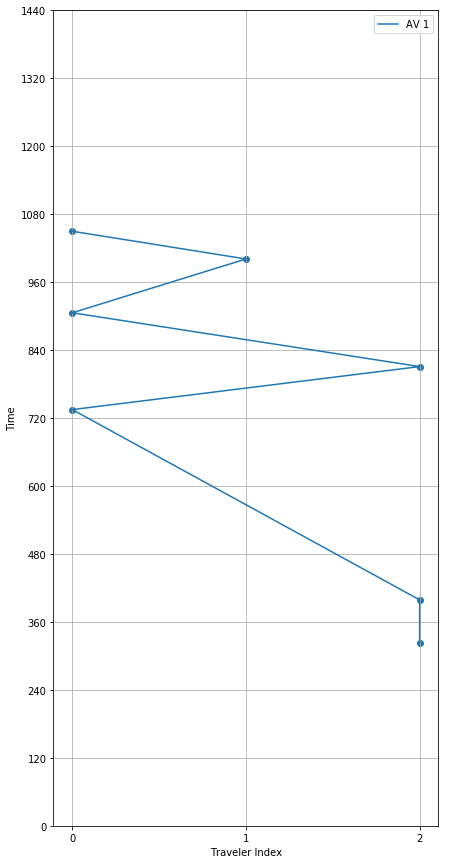

In [820]:
target_trips=traveler_trips.loc[(traveler_trips.tripmode<=6) &(traveler_trips.driver_passenger_flag>0)]
target_trips=target_trips[(target_trips.orig_taz!=target_trips.dest_taz) | (target_trips.trip_counter==1)]
target_trips=target_trips.append(traveler_trips[traveler_trips.tripmode>6])

analysis_one_hh_result(241508,darp_solutions_modechoice1,target_trips,1,Vehicular_Skim_Dict,superzone_map)

In [698]:
temp.groupby(['predicted_mode']).count()

,Unnamed: 0,person_id,num_trips,value_of_time,trip_counter,ActivityTime,tripmode,orig_purpose,dest_purpose,orig_maz,...,early_penalty_threshold,late_penalty_threshold,transit_time,transit_walk_time,transit_utility,car_time,car_dist,toll_cost,car_utility,actual_mode
predicted_mode,,,,,,,,,,,,,,,,,,,,,
Car,229784,229784,229784,229784,229784,229784,229784,229784,229784,229784,...,229784,229784,229784,229784,229784,229784,229784,229784,229784,229784
NonCar,24842,24842,24842,24842,24842,24842,24842,24842,24842,24842,...,24842,24842,24842,24842,24842,24842,24842,24842,24842,24842


In [700]:
darp_solutions_modechoice[0]

{'cav_use_mode': 0,
 'drivingcost_per_mile': 1,
 'hh_num_trips': 12,
 'num_cav': 1,
 'reward_mode': 1,
 'route_info':     orig_zone  dest_zone  orig_node_index  dest_node_index  person_id  \
 0           1         16                1               13    8600957   
 2          16          5                2               14    8600957   
 4           5          1                3               15    8600957   
 6           1          4                4               16    8600957   
 8           4          1                5               17    8600957   
 10          1          5                6               18    8600957   
 12          5          4                7               19    8600957   
 13          4          1               19                8          0   
 14          1         14                8               20    8600958   
 16         14          4                9               10    8600958   
 17          4          1               10               22    860095

In [711]:
temp[temp.hh_id==72808].predicted_mode

109          Car
112          Car
113          Car
114          Car
115          Car
233090    NonCar
233091       Car
233092    NonCar
233093       Car
233088       Car
233089    NonCar
Name: predicted_mode, dtype: object

In [709]:
zz_solution['route_info']

,orig_zone,dest_zone,orig_node_index,dest_node_index,person_id,origin_arrival_time,dest_arrival_time,dest_expected_arrival_time,value_of_time,start_time,Activity_Time,hh_id,hh_vehicle_id,intrasuperzone_flag,seg_index,veh_seg_index
0,12,5,1,12,145616,1.0,2.7,2.7,0.0755,1.0,309.3,72808.0,0.0,0,0,72808.0_0_0.0
1,5,12,12,2,0,2.7,312.0,312.0,0.0100,312.0,0.0,72808.0,0.0,0,1,72808.0_1_0.0
2,12,12,2,13,145615,312.0,316.4,316.4,0.0755,312.0,32.6,72808.0,0.0,0,2,72808.0_2_0.0
4,12,12,3,14,145615,349.0,353.4,353.4,0.0755,349.0,8.6,72808.0,0.0,0,3,72808.0_3_0.0
6,12,19,4,15,145615,362.0,367.1,367.1,0.0755,362.0,255.9,72808.0,0.0,0,4,72808.0_4_0.0
7,19,5,15,5,0,367.1,623.0,623.0,0.0100,623.0,0.0,72808.0,0.0,0,5,72808.0_5_0.0
8,5,6,5,16,145616,623.0,624.2,624.2,0.0755,623.0,17.8,72808.0,0.0,0,6,72808.0_6_0.0
10,6,5,6,17,145616,642.0,643.3,643.3,0.0755,642.0,28.7,72808.0,0.0,0,6,72808.0_6_0.0
12,5,1,7,18,145616,672.0,675.6,675.6,0.0755,672.0,27.4,72808.0,0.0,0,6,72808.0_6_0.0
13,1,19,18,8,0,675.6,703.0,703.0,0.0100,703.0,0.0,72808.0,0.0,0,7,72808.0_7_0.0


In [710]:
for solution in darp_solutions_modechoice:
#     print(i)
    if not solution['route_info'].hh_id.empty:
#     print(solution['route_info'].hh_id.iloc[0])
        temp_hh_id=solution['route_info'].hh_id.iloc[0]
        temp_route_info=solution['route_info'] 
        if len(temp_route_info[temp_route_info.orig_node_index<solution['hh_num_trips']])> \
        len(temp[(temp.hh_id==temp_hh_id)&(target_trips.predicted_mode=='Car')]):
            print(temp_hh_id,len(temp_route_info[temp_route_info.orig_node_index<solution['hh_num_trips']]),
                  len(temp[(temp.hh_id==temp_hh_id)&(target_trips.predicted_mode=='Car')]))
        if temp_hh_id==72808:
            zz_solution=solution

72808.0 10 8
2571871.0 7 5
2238689.0 26 23
1266865.0 7 6
2983590.0 6 5
1972436.0 13 12
2175587.0 13 12
1972992.0 17 16
1266603.0 13 12
3430422.0 10 9
3118656.0 13 12
2067066.0 18 16
2238716.0 17 14
2035795.0 24 21
1312563.0 15 14


KeyboardInterrupt: 

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


23
num_cav_trips 18
num_occupied_trips 14
num_unoccupied_trips 4
num_pickup_trips 13
num_shared_trips 1
num_convention car trips 17
total_convention_vehicle_driving_time 1.2566666666666668
total_AV_driving_time 1.19
total_AV_unoccupied_driving_time 0.3033333333333334
total_convention_vehicle_driving_distance 134.61200000000002
total_AV_driving_distance 132.28900000000002
total_AV_unoccupied_driving_distance 31.503
num_delayed_trips 0
num_early_trips 0
total_delayed_time 0
Total_early_time 0
total_reward 7999.018353423549
total_schedule_penalty 0.6229999999999993
total_travel_cost 154.41912
reward_mode 1
drivingcost_per_mile 1
share_ride_factor 1.5
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


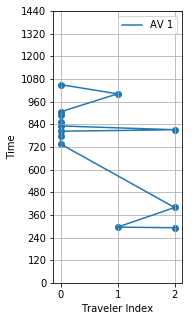

In [668]:
analysis_one_hh_result(target_hh_id,darp_solutions_modechoice,target_trips,1,Vehicular_Skim_Dict,superzone_map)

C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xax538\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


23
num_cav_trips 12
num_occupied_trips 10
num_unoccupied_trips 2
num_pickup_trips 10
num_shared_trips 0
num_convention car trips 17
total_convention_vehicle_driving_time 1.2566666666666668
total_AV_driving_time 0.7699999999999999
total_AV_unoccupied_driving_time 0.13499999999999998
total_convention_vehicle_driving_distance 134.61200000000002
total_AV_driving_distance 88.337
total_AV_unoccupied_driving_distance 14.539000000000001
num_delayed_trips 0
num_early_trips 0
total_delayed_time 0
Total_early_time 0
total_reward 7610.166808958057
total_schedule_penalty 0.0
total_travel_cost 105.57760800000001
reward_mode 1
drivingcost_per_mile 1
share_ride_factor 1.5
run_mode 0
num_cav 1
cav_use_mode 0
time_window_flag 0


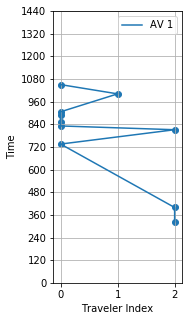

In [696]:
analysis_one_hh_result(target_hh_id,darp_solutions_modechoice09,target_trips,1,Vehicular_Skim_Dict,superzone_map)

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
single_model_runtime=60*5
drivingcost_per_mile=1
reward_mode=0
darp_solutions1=[]
cav_use_mode=1
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]

# for num_cav in [2]: #range(1,4):
#     for share_ride_factor in [1]: #[1,1.25,1.5]:
#         for time_window_flag in [0]:
num_cav=2
share_ride_factor=1.5
time_window_flag=0
#         time_window_flag=1
# num_cav=1
# share_ride_factor=1.5
# time_window_flag=0
print('**************')
print('Num_CAV',num_cav,share_ride_factor,time_window_flag)
print('**************')
darp_solutions1.extend([sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length,
                            reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                          cav_use_mode,time_window_flag,single_model_runtime)])

In [ ]:
#!/usr/bin/env python
import random
import pylab
from matplotlib.pyplot import pause

pylab.ion()
Gnormal=nx.Graph()
color_map=[]
for i in node_detail:
    color_map.append('blue')
# nx.draw_networkx_nodes(Gnormal, pos,node_list=[1,2,4],node_color='red',node_size=4)
def get_fig():
    global color_map
    for nodeinf in node_detail:
        node=nodeinf[0,0]
        Gnormal.add_node(node,pos=(nodexy[node][0],nodexy[node][1]))
    for linkinf in link_detail: 
        Gnormal.add_edge(linkinf[0,0],linkinf[0,1])

    pos=nx.get_node_attributes(Gnormal,'pos')
    nx.draw(Gnormal,pos,node_size=10,node_color=color_map )
num_plots = 50;
pylab.show()
for i in range(num_plots):
    color_map[i]='red'
    get_fig()
    pylab.draw()
    pause(2)

In [ ]:
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]

In [ ]:
analyzed_results4=pd.DataFrame()
for solution in darp_solutions4:
        analyzed_results4=analyzed_results4.append(pod.analysis_result(solution,sorted_trips,Vehicular_Skim,superzone_map),ignore_index=True)

In [ ]:
analyzed_results

In [ ]:
for i in range(1,4):
    line_label=str(i)+' CAV'
    plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,'total_AV_driving_time'],'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
sorted_trips.head()

In [ ]:
for i in range(1,4):
    line_label=str(i)+' CAV'
    plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,'total_AV_driving_distance'],'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
analyzed_results.columns

In [ ]:
analyzed_results4

In [ ]:
len(darp_solutions4[0]['route_info'])

In [ ]:
analyzed_results4.loc[analyzed_results4.share_ride_factor==1].transpose()

In [ ]:
zz.hh_vehicle_id.unique()

In [ ]:
for i in range(3):
    print(len(zz.loc[zz.hh_vehicle_id==i]))

In [ ]:
zz=darp_solutions4[-1]['route_info']
# zz=darp_solutions4[5]['route_info']
# zz['origin_network_node','dest_network_node']=zz.apply(lambda row: dy.find_orign_destination_node(row['orig_zone'],row['dest_zone'],origins,destinations))
for car_id in range(3):
    nodes=[]
    for index, row in zz.loc[zz.hh_vehicle_id==car_id].iterrows():
        nodes.extend(dy.find_orign_destination_node(row['orig_zone'],row['dest_zone'],origins,destinations))
    av.zone_node_highlight(nodes,node_detail,link_detail,nodexy,'r')

In [ ]:
darp_solutions4[-1]['route_info'].head()

In [ ]:
pod.plot_route_info_schedule(darp_solutions4[-1]['route_info'],sorted_trips,3)

In [ ]:
analyzed_results4.columns

In [ ]:
# for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
factor='total_schedule_penalty'
plt.pyplot.figure()
plt.pyplot.xlabel('Ridesharing Tolerance Factor')
plt.pyplot.ylabel('Total Late/Early Arrival')
for i in range(1,4):
    line_label=str(i)+' AV'
    plt.pyplot.plot(analyzed_results4.loc[analyzed_results4.num_cav==i,'share_ride_factor'],analyzed_results4.loc[analyzed_results4.num_cav==i,'Total_early_time'].apply(lambda x: abs(x))+analyzed_results4.loc[analyzed_results4.num_cav==i,'total_delayed_time'].apply(lambda x: abs(x)),'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
# for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
factor='total_travel_cost'
plt.pyplot.figure()
plt.pyplot.xlabel('Ridesharing Tolerance Factor ')
plt.pyplot.ylabel('Total Generalized Travel Cost')
for i in range(1,4):
    line_label=str(i)+' AV'
    plt.pyplot.plot(analyzed_results4.loc[analyzed_results4.num_cav==i,'share_ride_factor'],analyzed_results4.loc[analyzed_results4.num_cav==i,factor].apply(lambda x: abs(x)),'-o',label=line_label)
plt.pyplot.legend()

In [ ]:
len(darp_solutions4[-1]['route_info'])

In [ ]:
for factor in ['num_cav_trips','num_shared_trips','num_unoccupied_trips','total_schedule_penalty','total_travel_cost','num_pickup_trips']:
    plt.pyplot.figure()
    plt.pyplot.xlabel('share ride factor')
    plt.pyplot.ylabel(factor)
    for i in range(1,4):
        line_label=str(i)+' Cav'
        plt.pyplot.plot(analyzed_results.loc[analyzed_results.num_cav==i,'share_ride_factor'],analyzed_results.loc[analyzed_results.num_cav==i,factor].apply(lambda x: abs(x)),'-o',label=line_label)
    plt.pyplot.legend()

In [ ]:
for i in darp_solutions:
    print(i['num_cav'],i['share_ride_factor'])

In [ ]:

route_info.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2,superzone_map,drivingcost_per_mile),axis=1).sum()/60
route_info.apply(lambda row:prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1,superzone_map,drivingcost_per_mile) ,axis=1).sum()

In [ ]:
from Modules import Preprocess_DARP as prd

In [ ]:
for j in [2,5,8] :   
    z=darp_solutions4[j]['route_info']
    for i in range(3):
        zz=z.loc[z.hh_vehicle_id==i]
        if len(zz)>0:
            total_driving_time_temp=zz.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2,superzone_map,drivingcost_per_mile),axis=1).sum()/60
            total_driving_distance_temp=zz.apply(lambda row: prd.estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1,superzone_map,drivingcost_per_mile),axis=1).sum()
            num_pickup_trips=len(zz.loc[zz.orig_node_index<=len(sorted_trips)])
            print(i,j,len(zz),num_pickup_trips,total_driving_time_temp,total_driving_distance_temp)

In [ ]:
plt.pyplot.figure(1,figsize=[14.5,10])
plt.pyplot.subplot(131)
pod.plot_route_info_schedule(darp_solutions4[2]['route_info'],sorted_trips,darp_solutions4[2]['num_cav'])
plt.pyplot.subplot(132)
pod.plot_route_info_schedule(darp_solutions4[5]['route_info'],sorted_trips,darp_solutions4[5]['num_cav'])
plt.pyplot.subplot(133)
pod.plot_route_info_schedule(darp_solutions4[8]['route_info'],sorted_trips,darp_solutions4[8]['num_cav'])



In [ ]:
plt.pyplot.figure(1,figsize=[14.5,10])
plt.pyplot.subplot(131)
pod.plot_route_info_schedule(darp_solutions[2]['route_info'],sorted_trips,darp_solutions[2]['num_cav'])
plt.pyplot.subplot(132)
pod.plot_route_info_schedule(darp_solutions[5]['route_info'],sorted_trips,darp_solutions[5]['num_cav'])
plt.pyplot.subplot(133)
pod.plot_route_info_schedule(darp_solutions[8]['route_info'],sorted_trips,darp_solutions[8]['num_cav'])


In [ ]:
Vehicular_Skim.loc[18,15,1,1]

In [ ]:
zz1=solution['route_info']

In [ ]:
zz1.dest_zone=zz1.dest_zone.apply(lambda x: int(x))

In [ ]:
analyzed_results3=pd.DataFrame()
for solution in darp_solutions3:
    analyzed_results3=analyzed_results3.append(pod.analysis_result(solution,sorted_trips,Vehicular_Skim,superzone_map),ignore_index=True)

In [ ]:
analyzed_results3.transpose().to_csv('Output/hh_level_result3.csv')

In [ ]:
analyzed_results.transpose().to_csv('hh_level_result.csv')

In [ ]:
analyzed_results.transpose()

### Basic Statistics

In [ ]:
traveler_trips.head()

In [ ]:
traveler_trips.columns

In [ ]:
#Num of household
print('Number of household: \t',len(traveler_trips.hh_id.unique()))
print('Number of traveler: \t',len(traveler_trips.person_id.unique()))
print('Number of trips: \t',len(traveler_trips))
print('Number of indiv trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==0]))
print('Number of joint trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==1]))

In [ ]:
traveler_trips['orig_purpose'].value_counts().plot(kind='bar',title='Histogram of Origin Purpose')

In [ ]:
traveler_trips.tripmode.hist()

In [ ]:
traveler_trips.num_trips.hist()
plt.pyplot.title('Histogram of trip per person')

In [ ]:
traveler_trips.groupby('hh_id')['num_trips'].count().hist()
plt.pyplot.title('Histogram of trip per household')

### Sample Household
Select household 2287301 for intial analysis

In [ ]:
target_hh_id=2287301
people_in_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

#### Solve with heuristic

## Estimate travel time and cost

## Solve the optimization with Gurobi

In [ ]:
drivingcost_per_mile=1
transit_fare=2
transit_asc=2

##### Try to solve the problem for a single household

#### Solve with exact method

In [ ]:
print('prepare input for dial n ride model at ',datetime.datetime.now())
output_flag=1
target_hh_id=2287301
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
# R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
R=estimate_trip_reward(hh_num_trips,sorted_trips,Vehicular_Skim)
print('start sovling problem at ',datetime.datetime.now())
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode=)
print('finish solving problem at ',datetime.datetime.now())
route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
print('extract solution at',datetime.datetime.now())
route_info.to_csv('route_info_yingjie.csv')

In [ ]:
T_sol=np.ones(2*hh_num_trips+2)
for i in range(2*hh_num_trips+2):
#     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
    T_sol[i]=T[i].x
schedule_deviation=T_sol-expected_arrival_time
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,schedule_deviation)

#### Solve with the schedule partition heuristic

In [ ]:
def analysis_result(route_info,sorted_trips,Vehicular_Skim,schedule_deviation):
    print('Number of CAV Trips',len(route_info))
    print('Number of Occupied trips',len(route_info.loc[route_info.person_id>0]))
    print('Number of unoccupied trips',len(route_info.loc[route_info.person_id==0]))
    print('Number of pickup trips',len(route_info.loc[route_info.orig_node_index<=len(sorted_trips)]))
    print('Number of shared trips',len(route_info.loc[(route_info.orig_node_index<=len(sorted_trips)) &(route_info.dest_node_index<=len(sorted_trips))]))
    print('Number of convention car trips',len(sorted_trips.loc[sorted_trips.tripmode<=6]))
    # Compare the VHT between convention vehicle and CAV
    
    total_convention_vehicle_driving_time=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row:estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_driving_time=route_info.apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_unoccupied_driving_time=route_info.loc[route_info.person_id==0].apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    print('Convention car trips VHT: \t',total_convention_vehicle_driving_time/60,
          '\nAV driving time: \t',total_AV_driving_time/60,
          '\nAV unoccupied driving_time: \t',total_AV_unoccupied_driving_time/60)
    # Compare the VMT between convention vehicle and CAV
    total_convention_vehicle_driving_distance=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row: estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    total_AV_driving_distance=route_info.apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1) ,axis=1).sum()
    total_AV_unoccupied_driving_distance=route_info.loc[route_info.person_id==0].apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    print('Convention VMT: \t',total_convention_vehicle_driving_distance,
          '\nAV driving distance: \t',total_AV_driving_distance,
          '\nAV unoccupied driving_distance: \t',total_AV_unoccupied_driving_distance)
    print('Number of delayed trips\t',sum(1 for i in schedule_deviation if i >1))
    print('Number of early trips\t',sum(1 for i in schedule_deviation if i <-1))
    print('Total delayed time\t',sum(i for i in schedule_deviation if i >0))
    print('Total_early_time\t',sum(i for i in schedule_deviation if i <0))
    plt.pyplot.figure(1,figsize=[2.3,10])
    plot_route_info_schedule(route_info,sorted_trips)
    return

In [ ]:
def plot_route_info_schedule(route_info,sorted_trips):
#     z=traveler_trips[traveler_trips.hh_id==route_info.hh_id[0]]
    sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
    hh_num_trips=len(sorted_trips)
    person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
    person_id_and_inhouse_p_id_map[0]=-1
    route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
    
    plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                    route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
#     plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) & (route_info.dest_node_index<1+hh_num_trips),'p_id'],
#                     route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) &(route_info.dest_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.xlabel('Traveler Index')
    plt.pyplot.ylabel('Time')
    plt.pyplot.grid()
    plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
    plt.pyplot.yticks(np.arange(0,1441,30))
#     plt.pyplot.title(title)
    return 

#### All trips take CAV

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
share_ride_factor=2
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_partition,all_trips_schedule_deviation=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation)

#### Strict time window

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=2
time_window_flag=1
num_poav=2
single_model_runtime=60*5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_stricttw,all_trips_schedule_deviation_stricttw=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_stricttw,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_stricttw)

##### Only car trips take CAV

In [ ]:
len(sorted_car_trips)

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
sorted_car_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_car_trips.shape[0]
sorted_car_trips["hh_index"]=(range(hh_num_trips))
car_trips_route_info_partition,car_trips_schedule_deviation=solve_with_schedule_partition(sorted_car_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(car_trips_route_info_partition,sorted_car_trips,Vehicular_Skim,car_trips_schedule_deviation)

#### Ban Shared Rides

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_ban_sharerides,all_trips_schedule_deviation_ban_sharerides=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_ban_sharerides,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_ban_sharerides)

#### Share ride factor 1.25

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
share_ride_factor=1.25
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_sharerides125,all_trips_schedule_deviation_sharerides125=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_sharerides125,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_sharerides125)

In [ ]:
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(142)
plot_route_info_schedule(car_trips_route_info_partition,sorted_car_trips)
plt.pyplot.subplot(143)
plot_route_info_schedule(all_trips_route_info_partition,sorted_trips)
plt.pyplot.subplot(144)
plot_route_info_schedule(all_trips_route_info_ban_sharerides,sorted_trips)

#### Probability Mode Choice

In [ ]:
drivingcost_per_mile=1
transit_fare=1.4
transit_asc=2

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=1
share_ride_factor=1.5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
mode_choice_route_info,mode_choice_schedule_deviation=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
sorted_trips=compare_mode_utlity(sorted_trips)

In [ ]:
min_length=15
max_length=20
run_mode=0
share_ride_factor=1.5
force_serve_factor=1
car_sorted_trips=sorted_trips.loc[sorted_trips.expected_mode=='Car']
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
car_only_mode_choice_route_info,car_only_mode_choice_schedule_deviation=solve_with_schedule_partition(car_sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)
force_serve_factor=0

In [ ]:
sorted_trips[['transit_time','transit_walk_time','car_time','toll_cost','car_dist','transit_utility','car_utility','expected_mode','actual_mode','value_of_time']]

In [ ]:
# sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]
# sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
# route_info=pd.DataFrame()

# total_previous_sub_trips_length=0
# total_tailing_sub_trips_length=0
# schedule_deviation=[]
# x_list=[]
# for sub_sorted_trip in sub_sorted_trips:

#     num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
#     # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
#     R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
#     print('start sovling problem at ',datetime.datetime.now())
#     m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag)
#     x_list.extend([x])
#     print('finish solving problem at ',datetime.datetime.now())
#     sub_route_info=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
#     total_tailing_sub_trips_length=len(sorted_trips)-total_previous_sub_trips_length-len(sub_sorted_trip)
#     sub_route_info['orig_node_index']=sub_route_info.orig_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     sub_route_info['dest_node_index']=sub_route_info.dest_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     total_previous_sub_trips_length=total_previous_sub_trips_length+len(sub_sorted_trip)
#     route_info=route_info.append(sub_route_info)
# #         for index, row in route_info.iterrows():
# #             print(route_info.dest_expected_arrival_time,'\t',row.dest_arrival_time,'\t',row.start_time,'\t',T[row.dest_node_index].x)
# #         #Estimate the delay and early arrival
# T_sol=np.ones(2*hh_num_trips+2)
# for i in range(2*hh_num_trips+2):
# #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
#     T_sol[i]=T[i].x
#     print(T_sol[i],expected_arrival_time[i])
# schedule_deviation.extend(T_sol-expected_arrival_time)

In [ ]:
sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
hh_num_trips=len(sorted_trips)
person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
person_id_and_inhouse_p_id_map[0]=-1
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plot_route_info_schedule(car_only_mode_choice_route_info,car_sorted_trips)
z1=[sorted_trips.iloc[i-1].p_id for i in temp3]
z2=[sorted_trips.iloc[i-1].starttime for i in temp3]
print(z1,z2)
plt.pyplot.scatter(z1,z2)

In [ ]:
analysis_result(mode_choice_route_info,sorted_trips,Vehicular_Skim,mode_choice_schedule_deviation)

In [ ]:
sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
#     route_info=pd.DataFrame()
for sub_sorted_trip in sub_sorted_trips:
#     sub_sorted_trip=sub_sorted_trips[1]
    num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
    # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
    # R=np.ones(hh_num_trips+1)*10
    R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
    print('start sovling problem at ',datetime.datetime.now())
    m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode)
    print('finish solving problem at ',datetime.datetime.now())
    sub_route_info_temp=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
    
    T_sol=np.ones(2*hh_num_trips+2)
    for i in range(2*hh_num_trips+2):
    #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
        T_sol[i]=T[i].x
    schedule_deviation.extend(T_sol-expected_arrival_time)
    analysis_result(sub_route_info_temp,sub_sorted_trips,Vehicular_Skim,schedule_deviation)

In [ ]:
analysis_result(sub_route_info,sub_sorted_trip,Vehicular_Skim,schedule_deviation)

In [ ]:
z=traveler_trips[traveler_trips.hh_id==2287301]
z.loc[:,'p_id']=z.groupby(['person_id']).ngroup()
z.loc[:,'expected_arrival']=z.starttime+z.travel_time
person_id_and_inhouse_p_id_map=dict(zip(z.person_id,z.p_id))
person_id_and_inhouse_p_id_map[0]=-1
sorted_trips.loc[:,'p_id']=sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info_partition['p_id']=route_info_partition.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])

plt.pyplot.figure(1,figsize=[21,14])
plt.pyplot.subplot(131)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)

# plt.pyplot.scatter(z.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),z.starttime,marker='o',facecolors='none', edgecolors='r')

# plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
#                 route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'start_time']
#                )
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(132)
# plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
# plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
#                    sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
#                    c='r')

plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(133)
plt.pyplot.scatter(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])

plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))

In [ ]:
sorted_trips=target_hh.sort_values("starttime")
sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]

In [ ]:
plot_route_info_schedule(sub_route_info,traveler_trips)

In [ ]:
sub_route_info.groupby('person_id').count()

In [ ]:
sub_sorted_trip.groupby('person_id').count()

In [ ]:
sub_route_info

##### Solve the problem for all households

In [ ]:
route_infos=get_route_info_allhh(traveler_trips,0)

In [ ]:
route_infos.to_csv('Output/route_infos_fullconversion_lessthan40triphh.csv')

In [ ]:
route_infos.to_csv('Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_fullconversion.csv')
route_infos_part_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption.head()

#### Compare the new route with the old one

In [ ]:
initial_trips=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
len1=[]
len2=[]
origin_num_car_trips=[]
num_empty_car_trips=[]
num_initial_car_trips=0
for name, group in route_infos_full_adoption.groupby(['hh_id']):
    num_initial_car_trips=num_initial_car_trips+len(initial_trips.loc[(initial_trips.hh_id==name) & ((initial_trips.tripmode<=6) | (initial_trips.tripmode==13))])
#     len1.extend([len(group)])
#     len2.extend([len(initial_trips.loc[initial_trips.hh_id==name])])
#     origin_num_car_trips.extend([len(initial_trips.loc[(initial_trips.tripmode<=6) | (initial_trips.tripmode==13)])])
#     num_empty_car_trips.extend([len(group[group.person_id==0])])

In [ ]:
zz=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime']).groupby('hh_id').count() 

In [ ]:
zz1=traveler_trips.groupby('hh_id').count() 

In [ ]:
traveler_trips.columns

In [ ]:
zz[zz.person_id>30].person_id.sum()

In [ ]:
print('The new route plan has ',sum(len1),' trips')
print('The origin trip plan has ',sum(len2),' trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode<=6]),'car trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode==13]),'taxi trips')
print('The new route plan has',sum(num_empty_car_trips),'empty car trips')

### Route result analysis

##### Estimate how many trips are satisfied

In [ ]:
route_infos.head()

In [ ]:
def calculate_num_pick_up_trips(route_infos,traveler_trips):
    total_num_pickup_trip=0
    total_num_joint_trip=0
    for target_hh_id in route_infos.hh_id.unique():
        target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
        #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
        sorted_trips=target_hh.sort_values("starttime")
        hh_num_trips=len(sorted_trips)
        total_num_pickup_trip=total_num_pickup_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)])
        total_num_joint_trip=total_num_joint_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)& (route_infos.dest_node_index<hh_num_trips)])
    return total_num_pickup_trip,total_num_joint_trip
    #     print(target_hh_id)

In [ ]:
# Calculate the number of trips with/without passenger
full_adoption_num_pickup,full_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_full_adoption,traveler_trips)
full_adoption_empty_trips=len(route_infos_full_adoption.loc[route_infos_full_adoption.person_id==0])
partial_adoption_num_pickup,partial_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_part_adoption,traveler_trips)
partial_adoption_empty_trips=len(route_infos_part_adoption.loc[route_infos_part_adoption.person_id==0])

In [ ]:
full_adoption_num_pickup

In [ ]:
partial_adoption_num_pickup

In [ ]:
full_adoption_extra_joint

In [ ]:
len(route_infos_part_adoption)

In [ ]:
partial_adoption_extra_joint

In [ ]:
print('The full conversion plan pickup ',full_adoption_num_pickup,'trips (',round(full_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The full conversion plan incurs ', full_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is', full_adoption_empty_trips/full_adoption_num_pickup)
print('The partial conversion plan pickup ',partial_adoption_num_pickup,'trips (',round(partial_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The partial conversion plan incurs ', partial_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is' ,partial_adoption_empty_trips/partial_adoption_num_pickup)

In [ ]:
route_infos_full_adoption.columns

In [ ]:
z=route_infos_full_adoption.groupby('hh_id').apply(lambda x: (x==0).sum())

In [ ]:
z['num_hh_member']=traveler_trips.groupby('hh_id')['person_id'].nunique()

In [ ]:
def plot_num_trips_by_timeinterval(route_infos):
    route_infos['occupy_flag']=['Occupied' if x >0 else 'Empty' for x in route_infos['person_id']]
    route_infos['start_time_interval']=[math.floor(x/36) for x in route_infos['start_time']]
    z=route_infos.groupby(['start_time_interval', 'occupy_flag'])['start_time'].count().unstack('occupy_flag').fillna(0)
#     fig, axes = plt.pyplot.subplots(nrows=1 ,ncols=1,figsize=(16,6))
    
    z[['Occupied','Empty']].plot(kind='bar',stacked=True,figsize=(16,6))
    z['Empty_percentage']=z['Empty']/(z['Occupied']+z['Empty'])
#     z['Empty_percentage'].plot(kind='bar',ax=axes[1])
    return z

In [ ]:
z1=plot_num_trips_by_timeinterval(route_infos_full_adoption)

In [ ]:
z2=plot_num_trips_by_timeinterval(route_infos_part_adoption)

In [ ]:
fig = plt.pyplot.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
z1.Empty_percentage.plot(kind='bar',ax=ax,color='r',position=0)
z2.Empty_percentage.plot(kind='bar',ax=ax2,color='blue',position=1)

In [ ]:
# new_path='Output/newpath.dat'
# path_fileobj=open(new_path,'w')
# with open('Output/path.dat') as f:
#     for line in f: 
#         if len(line)>1:
#             for node in line.split():
#                 path_fileobj.write(node.rjust(7))
#             path_fileobj.write('\n')
#         else: 
#             path_fileobj.write('\n')
# path_fileobj.close()

#### Result Analysis